Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}")


DOLFINx version: 0.8.0


1: Total tims is  47.65 s
2: Total numb steps is  609


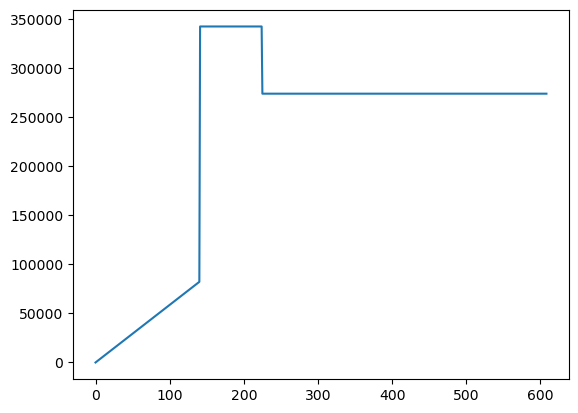

In [2]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions


# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 5
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 224
v_vehicle = 160
c_acc = 1

def vehicle_initial(angular_r, v_vehicle, c_contact, c_acc):
    import numpy as np
    # v_ini  =  raad/ss
    v_ini = v_vehicle/3.6   /   (920/2/1000) 
    # D_wheel = 920 mm, v = D_wheel /2 /1000 * v_ini *3.6   # km/h
    # Start time, Final time  
    t = 0
    t_brake = 49
    t_lag1 = 6
    t_lag2 = 4
    # rubbing element radius, Contact area 
    r_rub = 18.8
    S_rub_circle = r_rub**2 * c_contact
    S_total = S_rub_circle * np.pi * 18  #mm2
    # initial and brake pad temperature
    Ti = 60
    Tm = 60
    # density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
    t_u = 1e3 # m to mm
    rho = 7850 /(t_u**3)
    c = 462
    k = 48 / t_u
    # mu, P_brake,  r_disc , heat_distribution  
    mu = 0.376
    P_initial = 274000
    r_disc = 0.25
    heat_distribution = 0.88
    # calculate total num_steps
    if c_acc == 1:  # constant acc for the whole process
        acc = v_ini/t_brake
        # end velocity, km/h
        v_lag_end1 = (v_ini - (acc *t_lag1) )  
        v_lag_end2 = (v_ini - (acc *(t_lag1+t_lag2) ) )

        # angular speed, rad/s
        angular_r_rad = angular_r / 180 *np.pi  

        # lag time for period 1 and 2
        dt_lag1 = angular_r_rad  /  ( ( v_ini + v_lag_end1  ) /2 )
        dt_lag2 = angular_r_rad  /  ( ( v_lag_end1 + v_lag_end2  ) /2 )

        # lag steps for period 1 and 2
        n_lag1 = round (t_lag1 / dt_lag1) + 1 
        n_lag2 = round (t_lag2 / dt_lag2) + 1

        # every second, the rotation angular divide average speed, then know the average dt.
        dt_a_lag2 = angular_r_rad  /  ( v_lag_end2 /2 )
        
        n_a_lag =  round ( (t_brake - t_lag1 - t_lag2) / dt_a_lag2 )+ 1
        
        num_steps = n_lag1 + n_lag2 + n_a_lag
        dt = []
        v_angular = [v_ini]
        for i in range(num_steps):
            dt.append ( angular_r_rad / v_angular[i] )
            v_angular.append (  v_ini- sum(dt) * acc )           
        P = []
        for i in range(num_steps):
            if i <= n_lag1:
                # linear pressure increase * 10%
                P.append( P_initial/ n_lag1 * (i * 0.3) )
            elif n_lag1 < i <= (n_lag1 + n_lag2):
                # heat lost in lag1 is added on lag2, 50%, should be 90% here
                P.append( P_initial * (1+ n_lag1 / (2 * n_lag2)* 0.3 ) ) 
            else:
                P.append( P_initial) 
    # S_or is the original brake pad rubbing area, 200 cm2. 
    S_or = 200
    S_new = S_total/100 #mm2 to cm2
    # g is the heat source,unit is w/mm2 
    g = []
    for i in range(num_steps):
        g.append ( mu * P[i] * v_angular[i] * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) )
        
    #  h is the heat convection coefficient, unit is W/mm2 K  
    h = 7.75e-5
    # radiation is the radiation heat coefficient, unit is W/mm2 K
    # stefan-Boltzmann constant theta = 5.67*10e-8 w/m2 k-4,   0.64 is the emmissivity
    radiation = 5.670*(10e-8)/(t_u**2)  * 0.64

    return dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total,n_lag1,n_lag2,n_a_lag
    
# calling local functions to get all parameters
( dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c, k, t_brake,S_total,n_lag1,n_lag2,n_a_lag) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)



plt.plot(P)



In [3]:
print(n_lag1)
print(n_lag2)
print(n_a_lag)
from disc_f import *

140
84
385


## 2: Mesh

In [4]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2, 'tetr')
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-5.msh' exists, start creat now:
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                         



## 3: Setup 


In [5]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)
    + radiation * inner(u**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    # before 2024/5/16
    #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
    ## new start 2024/5/16, friction points do not have convection heat + heat input
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u, v) * ds(10 * i)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-09-15 18:42:08.806 (   7.650s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:09.244 (   8.088s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:09.367 (   8.212s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0218663 (tol = 1e-10) r (rel) = 1.52039e-06(tol = 1e-06)
2024-09-15 18:42:09.569 (   8.413s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:09.690 (   8.534s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.09205e-07 (tol = 1e-10) r (rel) = 7.59316e-12(tol = 1e-06)
2024-09-15 18:42:09.690 (   8.534s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.


## 5: Solution


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u, v) * ds(10 * j)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) 
         )

        

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 224 degree. 2: Current time is 0.0 s. 3: Completion is 0.1 %. 

2024-09-15 18:42:12.849 (  11.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:12.851 (  11.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:12.851 (  11.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:42:12.853 (  11.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:12.855 (  11.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:12.855 (  11.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:42:12.856 (  11.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:12.861 (  11.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.1 %. 

2024-09-15 18:42:14.113 (  12.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:14.114 (  12.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:14.119 (  12.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:14.119 (  12.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:14.145 (  12.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:14.246 (  13.090s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:42:14.440 (  13.284s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:15.073 (  13.917s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 448 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-09-15 18:42:15.515 (  14.359s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.16612e-11 (tol = 1e-10) r (rel) = 2.18565e-11(tol = 1e-06)
2024-09-15 18:42:15.515 (  14.359s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:42:15.516 (  14.360s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:42:15.875 (  14.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:15.878 (  14.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:15.878 (  14.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:42:15.881 (  14.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 0.2 %. 

2024-09-15 18:42:28.062 (  26.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:28.062 (  26.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:28.070 (  26.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:28.070 (  26.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:28.087 (  26.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:28.194 (  27.038s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:42:28.395 (  27.239s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:28.834 (  27.678s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 672 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-09-15 18:42:29.126 (  27.970s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:29.259 (  28.103s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.10522e-11 (tol = 1e-10) r (rel) = 2.15502e-11(tol = 1e-06)
2024-09-15 18:42:29.259 (  28.103s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:42:29.262 (  28.106s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:42:29.390 (  28.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:29.392 (  28.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:29.392 (  28.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 0.2 %. 

2024-09-15 18:42:41.454 (  40.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:41.454 (  40.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:41.461 (  40.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:41.461 (  40.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:41.481 (  40.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:41.571 (  40.416s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:42:41.759 (  40.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:42.259 (  41.103s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 896 degree. 2: Current time is 0.2 s. 3: Completion is 0.3 %. 

2024-09-15 18:42:42.678 (  41.522s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.86523e-11 (tol = 1e-10) r (rel) = 2.08724e-11(tol = 1e-06)
2024-09-15 18:42:42.678 (  41.522s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:42:42.678 (  41.522s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:42:42.838 (  41.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:42.841 (  41.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:42.841 (  41.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:42:42.845 (  41.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 0.3 %. 

2024-09-15 18:42:55.282 (  54.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:55.282 (  54.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:55.287 (  54.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:55.287 (  54.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:42:55.306 (  54.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:42:55.417 (  54.261s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:42:55.604 (  54.447s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:42:56.130 (  54.973s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1120 degree. 2: Current time is 0.2 s. 3: Completion is 0.4 %. 

2024-09-15 18:42:56.699 (  55.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:56.703 (  55.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:56.703 (  55.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:42:56.706 (  55.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:56.707 (  55.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:56.707 (  55.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:42:56.709 (  55.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:42:56.711 (  55.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.4 %. 

2024-09-15 18:43:09.791 (  68.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:09.792 (  68.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:09.797 (  68.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:09.798 (  68.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:09.816 (  68.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:09.929 (  68.773s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:43:10.123 (  68.967s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:43:10.621 (  69.465s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1344 degree. 2: Current time is 0.2 s. 3: Completion is 0.5 %. 

2024-09-15 18:43:11.129 (  69.982s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.91217e-10 (tol = 1e-10) r (rel) = 2.14707e-11(tol = 1e-06)
2024-09-15 18:43:11.138 (  69.982s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:43:11.145 (  69.993s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:43:11.300 (  70.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:11.304 (  70.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:11.305 (  70.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:43:11.306 (  70.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 0.5 %. 

2024-09-15 18:43:23.027 (  81.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:23.030 (  81.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:23.039 (  81.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:23.039 (  81.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:23.056 (  81.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:23.161 (  82.005s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:43:23.346 (  82.190s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:43:23.822 (  82.666s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1568 degree. 2: Current time is 0.3 s. 3: Completion is 0.6 %. 

2024-09-15 18:43:24.085 (  82.929s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:43:24.221 (  83.065s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.86762e-10 (tol = 1e-10) r (rel) = 2.09192e-11(tol = 1e-06)
2024-09-15 18:43:24.222 (  83.065s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:43:24.222 (  83.066s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:43:24.350 (  83.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:24.352 (  83.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:24.352 (  83.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 0.6 %. 

2024-09-15 18:43:36.646 (  95.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:36.655 (  95.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:36.660 (  95.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:36.660 (  95.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:36.682 (  95.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:36.732 (  95.576s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:43:36.967 (  95.811s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:43:37.386 (  96.230s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1792 degree. 2: Current time is 0.3 s. 3: Completion is 0.7 %. 

2024-09-15 18:43:37.765 (  96.611s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.29537e-10 (tol = 1e-10) r (rel) = 2.21498e-11(tol = 1e-06)
2024-09-15 18:43:37.768 (  96.612s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:43:37.769 (  96.613s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:43:37.902 (  96.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:37.905 (  96.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:37.905 (  96.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:43:37.907 (  96.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 0.7 %. 

2024-09-15 18:43:49.986 ( 108.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:49.986 ( 108.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:49.991 ( 108.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:49.991 ( 108.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:43:50.011 ( 108.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:43:50.113 ( 108.957s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:43:50.306 ( 109.149s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:43:50.757 ( 109.601s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2016 degree. 2: Current time is 0.4 s. 3: Completion is 0.7 %. 

2024-09-15 18:43:50.877 ( 109.720s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 5.93281e-05 (tol = 1e-10) r (rel) = 3.46038e-06(tol = 1e-06)
2024-09-15 18:43:51.027 ( 109.871s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:43:51.147 ( 109.991s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.72612e-10 (tol = 1e-10) r (rel) = 2.1733e-11(tol = 1e-06)
2024-09-15 18:43:51.147 ( 109.991s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:43:51.147 ( 109.991s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:43:51.286 ( 110.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:43:51.297 ( 110.141s) [main            ]topologycomputation.

1: Completion is 0.7 %. 

2024-09-15 18:44:03.019 ( 121.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:03.019 ( 121.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:03.024 ( 121.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:03.024 ( 121.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:03.044 ( 121.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:03.143 ( 121.987s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:44:03.329 ( 122.173s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:03.752 ( 122.596s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2240 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-09-15 18:44:03.892 ( 122.736s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 4.82705e-05 (tol = 1e-10) r (rel) = 3.44109e-06(tol = 1e-06)
2024-09-15 18:44:04.044 ( 122.888s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:04.177 ( 123.021s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.958e-10 (tol = 1e-10) r (rel) = 2.10869e-11(tol = 1e-06)
2024-09-15 18:44:04.177 ( 123.021s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:44:04.178 ( 123.022s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:44:04.305 ( 123.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:04.307 ( 123.150s) [main            ]topologycomputation.c

1: Completion is 0.8 %. 

2024-09-15 18:44:16.116 ( 134.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:16.116 ( 134.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:16.122 ( 134.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:16.122 ( 134.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:16.144 ( 134.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:16.248 ( 135.091s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:44:16.430 ( 135.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:16.869 ( 135.713s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2464 degree. 2: Current time is 0.4 s. 3: Completion is 0.9 %. 

2024-09-15 18:44:17.283 ( 136.127s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.32158e-10 (tol = 1e-10) r (rel) = 2.13143e-11(tol = 1e-06)
2024-09-15 18:44:17.283 ( 136.127s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:44:17.283 ( 136.127s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:44:17.410 ( 136.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:17.415 ( 136.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:17.415 ( 136.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:44:17.416 ( 136.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 0.9 %. 

2024-09-15 18:44:28.936 ( 148.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:29.219 ( 148.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:29.227 ( 148.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:29.227 ( 148.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:29.245 ( 148.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:29.354 ( 148.198s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:44:29.542 ( 148.386s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:30.050 ( 148.894s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2688 degree. 2: Current time is 0.5 s. 3: Completion is 1.0 %. 

2024-09-15 18:44:30.192 ( 149.036s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 6.65163e-05 (tol = 1e-10) r (rel) = 3.38621e-06(tol = 1e-06)
2024-09-15 18:44:30.345 ( 149.189s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:30.473 ( 149.317s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.09995e-10 (tol = 1e-10) r (rel) = 2.0872e-11(tol = 1e-06)
2024-09-15 18:44:30.473 ( 149.317s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:44:30.474 ( 149.318s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:44:30.604 ( 149.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:30.606 ( 149.450s) [main            ]topologycomputation.

1: Completion is 1.0 %. 

2024-09-15 18:44:42.477 ( 161.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:42.477 ( 161.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:42.482 ( 161.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:42.485 ( 161.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:42.502 ( 161.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:42.606 ( 161.450s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:44:42.788 ( 161.632s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:43.212 ( 162.056s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2912 degree. 2: Current time is 0.5 s. 3: Completion is 1.1 %. 

2024-09-15 18:44:43.626 ( 162.470s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.95051e-10 (tol = 1e-10) r (rel) = 2.12631e-11(tol = 1e-06)
2024-09-15 18:44:43.627 ( 162.470s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:44:43.629 ( 162.472s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:44:43.754 ( 162.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:43.756 ( 162.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:43.756 ( 162.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:44:43.758 ( 162.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 1.1 %. 

2024-09-15 18:44:55.477 ( 174.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:55.477 ( 174.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:55.482 ( 174.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:55.482 ( 174.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:44:55.500 ( 174.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:44:55.599 ( 174.442s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:44:55.813 ( 174.657s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:44:56.295 ( 175.139s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3136 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-09-15 18:44:56.716 ( 175.559s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.59691e-10 (tol = 1e-10) r (rel) = 2.22296e-11(tol = 1e-06)
2024-09-15 18:44:56.716 ( 175.560s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:44:56.716 ( 175.560s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:44:56.849 ( 175.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:56.851 ( 175.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:44:56.852 ( 175.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:44:56.853 ( 175.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 1.2 %. 

2024-09-15 18:45:09.196 ( 188.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:09.196 ( 188.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:09.201 ( 188.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:09.201 ( 188.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:09.220 ( 188.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:09.320 ( 188.164s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:45:09.502 ( 188.346s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:45:09.928 ( 188.772s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3360 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-09-15 18:45:10.329 ( 189.172s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:45:10.484 ( 189.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:10.486 ( 189.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:10.486 ( 189.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:45:10.487 ( 189.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:10.489 ( 189.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:10.489 ( 189.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:45:10.490 ( 189.334s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 1.2 %. 

2024-09-15 18:45:23.000 ( 201.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:23.000 ( 201.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:23.011 ( 201.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:23.011 ( 201.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:23.029 ( 201.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:23.136 ( 201.980s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:45:23.330 ( 202.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:45:23.750 ( 202.594s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3584 degree. 2: Current time is 0.7 s. 3: Completion is 1.3 %. 

2024-09-15 18:45:24.137 ( 202.981s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.83402e-10 (tol = 1e-10) r (rel) = 2.0816e-11(tol = 1e-06)
2024-09-15 18:45:24.138 ( 202.981s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:45:24.139 ( 202.982s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:45:24.286 ( 203.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:24.288 ( 203.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:24.288 ( 203.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:45:24.289 ( 203.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 1.3 %. 

2024-09-15 18:45:35.982 ( 214.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:35.982 ( 214.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:35.987 ( 214.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:35.987 ( 214.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:36.005 ( 214.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:36.101 ( 214.945s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:45:36.281 ( 215.125s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:45:36.727 ( 215.571s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3808 degree. 2: Current time is 0.7 s. 3: Completion is 1.4 %. 

2024-09-15 18:45:37.152 ( 215.996s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.20994e-10 (tol = 1e-10) r (rel) = 2.08193e-11(tol = 1e-06)
2024-09-15 18:45:37.152 ( 215.996s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:45:37.153 ( 215.997s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:45:37.285 ( 216.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:37.287 ( 216.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:37.287 ( 216.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:45:37.288 ( 216.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 1.4 %. 

2024-09-15 18:45:49.925 ( 228.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:49.925 ( 228.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:49.931 ( 228.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:49.931 ( 228.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:45:49.948 ( 228.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:45:50.040 ( 228.884s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:45:50.056 ( 228.915s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:45:50.673 ( 229.517s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4032 degree. 2: Current time is 0.7 s. 3: Completion is 1.5 %. 

2024-09-15 18:45:50.793 ( 229.637s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.17706e-05 (tol = 1e-10) r (rel) = 3.41023e-06(tol = 1e-06)
2024-09-15 18:45:50.946 ( 229.790s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:45:51.063 ( 229.907s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.56568e-10 (tol = 1e-10) r (rel) = 2.06822e-11(tol = 1e-06)
2024-09-15 18:45:51.063 ( 229.907s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:45:51.063 ( 229.907s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:45:51.196 ( 230.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:45:51.199 ( 230.043s) [main            ]topologycomputation

1: Completion is 1.5 %. 

2024-09-15 18:46:03.118 ( 241.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:03.118 ( 241.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:03.122 ( 241.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:03.122 ( 241.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:03.140 ( 241.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:03.234 ( 242.078s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:46:03.410 ( 242.254s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:03.847 ( 242.691s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4256 degree. 2: Current time is 0.8 s. 3: Completion is 1.6 %. 

2024-09-15 18:46:04.116 ( 242.960s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:04.254 ( 243.098s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.20059e-10 (tol = 1e-10) r (rel) = 2.08512e-11(tol = 1e-06)
2024-09-15 18:46:04.254 ( 243.098s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:46:04.256 ( 243.100s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:46:04.385 ( 243.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:04.388 ( 243.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:04.388 ( 243.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 1.6 %. 

2024-09-15 18:46:16.187 ( 255.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:16.188 ( 255.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:16.197 ( 255.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:16.197 ( 255.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:16.219 ( 255.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:16.321 ( 255.165s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:46:16.508 ( 255.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:16.945 ( 255.789s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4480 degree. 2: Current time is 0.8 s. 3: Completion is 1.7 %. 

2024-09-15 18:46:17.480 ( 256.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:17.482 ( 256.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:17.483 ( 256.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:46:17.485 ( 256.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:17.488 ( 256.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:17.489 ( 256.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:46:17.491 ( 256.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:17.492 ( 256.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.7 %. 

2024-09-15 18:46:29.725 ( 268.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:29.725 ( 268.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:29.730 ( 268.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:29.730 ( 268.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:29.747 ( 268.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:29.858 ( 268.702s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:46:30.041 ( 268.885s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:30.525 ( 269.369s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4704 degree. 2: Current time is 0.9 s. 3: Completion is 1.7 %. 

2024-09-15 18:46:30.937 ( 269.781s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.55209e-10 (tol = 1e-10) r (rel) = 2.07022e-11(tol = 1e-06)
2024-09-15 18:46:30.937 ( 269.781s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:46:30.938 ( 269.782s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:46:31.062 ( 269.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:31.064 ( 269.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:31.064 ( 269.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:46:31.066 ( 269.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 1.7 %. 

2024-09-15 18:46:43.245 ( 282.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:43.245 ( 282.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:43.247 ( 282.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:43.250 ( 282.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:43.267 ( 282.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:43.374 ( 282.219s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:46:43.583 ( 282.427s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:44.029 ( 282.873s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4928 degree. 2: Current time is 0.9 s. 3: Completion is 1.8 %. 

2024-09-15 18:46:44.588 ( 283.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:44.590 ( 283.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:44.590 ( 283.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:46:44.592 ( 283.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:44.594 ( 283.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:44.594 ( 283.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:46:44.596 ( 283.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:44.598 ( 283.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.8 %. 

2024-09-15 18:46:56.809 ( 295.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:56.811 ( 295.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:56.815 ( 295.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:56.815 ( 295.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:46:56.835 ( 295.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:46:56.943 ( 295.787s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:46:57.120 ( 295.964s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:57.555 ( 296.399s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5152 degree. 2: Current time is 0.9 s. 3: Completion is 1.9 %. 

2024-09-15 18:46:57.835 ( 296.679s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:46:58.005 ( 296.849s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.24733e-10 (tol = 1e-10) r (rel) = 2.0532e-11(tol = 1e-06)
2024-09-15 18:46:58.005 ( 296.849s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:46:58.005 ( 296.849s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:46:58.146 ( 296.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:58.148 ( 296.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:46:58.148 ( 296.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 1.9 %. 

2024-09-15 18:47:10.433 ( 309.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:10.433 ( 309.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:10.438 ( 309.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:10.438 ( 309.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:10.457 ( 309.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:10.573 ( 309.417s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:47:10.760 ( 309.604s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:11.195 ( 310.039s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5376 degree. 2: Current time is 1.0 s. 3: Completion is 2.0 %. 

2024-09-15 18:47:11.462 ( 310.306s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:11.581 ( 310.425s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.56783e-10 (tol = 1e-10) r (rel) = 2.09042e-11(tol = 1e-06)
2024-09-15 18:47:11.581 ( 310.425s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:47:11.581 ( 310.425s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:47:11.717 ( 310.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:11.719 ( 310.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:11.719 ( 310.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 2.0 %. 

2024-09-15 18:47:23.360 ( 322.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:23.361 ( 322.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:23.366 ( 322.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:23.366 ( 322.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:23.385 ( 322.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:23.486 ( 322.330s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:47:23.683 ( 322.527s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:24.123 ( 322.967s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5600 degree. 2: Current time is 1.0 s. 3: Completion is 2.1 %. 

2024-09-15 18:47:24.406 ( 323.250s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:24.542 ( 323.386s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.06511e-09 (tol = 1e-10) r (rel) = 2.15598e-11(tol = 1e-06)
2024-09-15 18:47:24.544 ( 323.388s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:47:24.545 ( 323.389s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:47:24.683 ( 323.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:24.685 ( 323.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:24.685 ( 323.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 2.1 %. 

2024-09-15 18:47:36.746 ( 335.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:36.746 ( 335.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:36.751 ( 335.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:36.751 ( 335.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:36.769 ( 335.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:36.879 ( 335.723s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:47:37.056 ( 335.900s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:37.616 ( 336.460s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5824 degree. 2: Current time is 1.1 s. 3: Completion is 2.2 %. 

2024-09-15 18:47:37.897 ( 336.740s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:38.022 ( 336.866s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.62882e-10 (tol = 1e-10) r (rel) = 2.14794e-11(tol = 1e-06)
2024-09-15 18:47:38.022 ( 336.866s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:47:38.023 ( 336.867s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:47:38.155 ( 336.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:38.158 ( 337.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:38.158 ( 337.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 2.2 %. 

2024-09-15 18:47:49.835 ( 348.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:49.835 ( 348.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:49.840 ( 348.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:49.840 ( 348.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:47:49.858 ( 348.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:47:49.961 ( 348.805s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:47:50.140 ( 348.984s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:50.578 ( 349.422s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6048 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-09-15 18:47:50.712 ( 349.557s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000162084 (tol = 1e-10) r (rel) = 3.54574e-06(tol = 1e-06)
2024-09-15 18:47:50.868 ( 349.712s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:47:51.012 ( 349.856s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.95297e-10 (tol = 1e-10) r (rel) = 2.1773e-11(tol = 1e-06)
2024-09-15 18:47:51.013 ( 349.856s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:47:51.013 ( 349.857s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:47:51.151 ( 349.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:47:51.153 ( 349.997s) [main            ]topologycomputation.

1: Completion is 2.3 %. 

2024-09-15 18:48:03.164 ( 362.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:03.164 ( 362.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:03.170 ( 362.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:03.171 ( 362.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:03.188 ( 362.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:03.310 ( 362.153s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:48:03.505 ( 362.348s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:03.960 ( 362.804s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6272 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-09-15 18:48:04.078 ( 362.922s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000155855 (tol = 1e-10) r (rel) = 3.465e-06(tol = 1e-06)
2024-09-15 18:48:04.230 ( 363.074s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:04.338 ( 363.182s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.4256e-10 (tol = 1e-10) r (rel) = 2.09552e-11(tol = 1e-06)
2024-09-15 18:48:04.341 ( 363.185s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:48:04.341 ( 363.185s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:48:04.491 ( 363.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:04.493 ( 363.337s) [main            ]topologycomputation.cp

1: Completion is 2.3 %. 

2024-09-15 18:48:15.963 ( 374.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:15.963 ( 374.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:15.968 ( 374.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:15.968 ( 374.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:15.985 ( 374.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:16.083 ( 374.926s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:48:16.251 ( 375.095s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:16.736 ( 375.580s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6496 degree. 2: Current time is 1.2 s. 3: Completion is 2.4 %. 

2024-09-15 18:48:17.106 ( 375.950s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.59747e-10 (tol = 1e-10) r (rel) = 2.18447e-11(tol = 1e-06)
2024-09-15 18:48:17.110 ( 375.954s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:48:17.112 ( 375.956s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:48:17.262 ( 376.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:17.264 ( 376.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:17.264 ( 376.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:48:17.265 ( 376.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 2.4 %. 

2024-09-15 18:48:29.659 ( 388.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:29.659 ( 388.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:29.666 ( 388.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:29.666 ( 388.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:29.687 ( 388.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:29.798 ( 388.644s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:48:30.029 ( 388.873s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:30.444 ( 389.288s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6720 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-09-15 18:48:30.563 ( 389.408s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000213254 (tol = 1e-10) r (rel) = 3.36585e-06(tol = 1e-06)
2024-09-15 18:48:30.715 ( 389.559s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:30.850 ( 389.694s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.3528e-09 (tol = 1e-10) r (rel) = 2.13516e-11(tol = 1e-06)
2024-09-15 18:48:30.850 ( 389.694s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:48:30.851 ( 389.695s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:48:30.988 ( 389.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:30.995 ( 389.839s) [main            ]topologycomputation.

1: Completion is 2.5 %. 

2024-09-15 18:48:43.182 ( 402.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:43.182 ( 402.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:43.187 ( 402.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:43.187 ( 402.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:43.205 ( 402.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:43.307 ( 402.151s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:48:43.507 ( 402.351s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:44.003 ( 402.847s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6944 degree. 2: Current time is 1.3 s. 3: Completion is 2.6 %. 

2024-09-15 18:48:44.289 ( 403.133s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:44.425 ( 403.269s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.03734e-09 (tol = 1e-10) r (rel) = 2.13619e-11(tol = 1e-06)
2024-09-15 18:48:44.425 ( 403.269s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:48:44.425 ( 403.269s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:48:44.568 ( 403.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:44.571 ( 403.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:44.571 ( 403.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 2.6 %. 

2024-09-15 18:48:56.729 ( 415.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:56.729 ( 415.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:56.734 ( 415.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:56.734 ( 415.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:48:56.752 ( 415.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:48:56.851 ( 415.695s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:48:57.034 ( 415.878s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:57.470 ( 416.317s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7168 degree. 2: Current time is 1.3 s. 3: Completion is 2.7 %. 

2024-09-15 18:48:57.596 ( 416.442s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000166868 (tol = 1e-10) r (rel) = 3.37369e-06(tol = 1e-06)
2024-09-15 18:48:57.749 ( 416.592s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:48:57.877 ( 416.721s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.01162e-09 (tol = 1e-10) r (rel) = 2.04527e-11(tol = 1e-06)
2024-09-15 18:48:57.877 ( 416.721s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:48:57.878 ( 416.722s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:48:58.015 ( 416.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:48:58.019 ( 416.863s) [main            ]topologycomputation

1: Completion is 2.7 %. 

2024-09-15 18:49:09.860 ( 428.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:09.860 ( 428.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:09.863 ( 428.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:09.863 ( 428.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:09.881 ( 428.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:09.976 ( 428.822s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:49:10.167 ( 429.011s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:49:10.585 ( 429.429s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7392 degree. 2: Current time is 1.4 s. 3: Completion is 2.8 %. 

2024-09-15 18:49:10.995 ( 429.841s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.32361e-09 (tol = 1e-10) r (rel) = 2.09446e-11(tol = 1e-06)
2024-09-15 18:49:10.998 ( 429.841s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:49:11.000 ( 429.844s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:49:11.139 ( 429.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:49:11.141 ( 429.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:49:11.141 ( 429.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:49:11.142 ( 429.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 2.8 %. 

2024-09-15 18:49:23.204 ( 442.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:23.204 ( 442.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:23.210 ( 442.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:23.210 ( 442.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:23.227 ( 442.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:23.329 ( 442.173s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:49:23.509 ( 442.353s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:49:24.036 ( 442.879s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7616 degree. 2: Current time is 1.4 s. 3: Completion is 2.8 %. 

2024-09-15 18:49:24.448 ( 443.293s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.14018e-09 (tol = 1e-10) r (rel) = 2.15455e-11(tol = 1e-06)
2024-09-15 18:49:24.450 ( 443.294s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:49:24.451 ( 443.295s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:49:24.593 ( 443.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:49:24.595 ( 443.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:49:24.595 ( 443.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:49:24.596 ( 443.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 2.8 %. 

2024-09-15 18:49:36.095 ( 454.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:36.095 ( 454.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:36.100 ( 454.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:36.100 ( 454.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:36.117 ( 454.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:36.209 ( 455.053s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:49:36.389 ( 455.233s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 7840 degree. 2: Current time is 1.4 s. 3: Completion is 2.9 %. 

2024-09-15 18:49:36.846 ( 455.690s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:49:36.961 ( 455.805s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000212505 (tol = 1e-10) r (rel) = 3.4353e-06(tol = 1e-06)
2024-09-15 18:49:37.099 ( 455.943s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:49:37.247 ( 456.091s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.30666e-09 (tol = 1e-10) r (rel) = 2.11231e-11(tol = 1e-06)
2024-09-15 18:49:37.247 ( 456.091s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:49:37.247 ( 456.091s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:49:37.377 ( 456.221s) [main            ]topologycomp

1: Completion is 2.9 %. 

2024-09-15 18:49:48.896 ( 467.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:48.896 ( 467.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:48.903 ( 467.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:48.903 ( 467.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:49:48.919 ( 467.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:49:49.011 ( 467.855s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:49:49.185 ( 468.029s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:49:49.650 ( 468.494s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8064 degree. 2: Current time is 1.5 s. 3: Completion is 3.0 %. 

2024-09-15 18:49:50.054 ( 468.898s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.13732e-09 (tol = 1e-10) r (rel) = 2.05677e-11(tol = 1e-06)
2024-09-15 18:49:50.054 ( 468.898s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:49:50.055 ( 468.899s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:49:50.194 ( 469.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:49:50.195 ( 469.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:49:50.195 ( 469.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:49:50.198 ( 469.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 3.0 %. 

2024-09-15 18:50:02.374 ( 481.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:02.374 ( 481.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:02.380 ( 481.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:02.380 ( 481.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:02.401 ( 481.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:02.519 ( 481.363s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:50:02.717 ( 481.562s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:03.178 ( 482.022s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8288 degree. 2: Current time is 1.5 s. 3: Completion is 3.1 %. 

2024-09-15 18:50:03.445 ( 482.289s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:03.571 ( 482.415s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.14808e-09 (tol = 1e-10) r (rel) = 2.01818e-11(tol = 1e-06)
2024-09-15 18:50:03.571 ( 482.415s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:50:03.572 ( 482.416s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:50:03.714 ( 482.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:03.716 ( 482.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:03.716 ( 482.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 3.1 %. 

2024-09-15 18:50:15.263 ( 494.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:15.264 ( 494.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:15.275 ( 494.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:15.275 ( 494.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:15.293 ( 494.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:15.387 ( 494.231s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:50:15.565 ( 494.409s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:15.995 ( 494.839s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8512 degree. 2: Current time is 1.6 s. 3: Completion is 3.2 %. 

2024-09-15 18:50:16.266 ( 495.110s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:16.397 ( 495.241s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.75411e-09 (tol = 1e-10) r (rel) = 2.12602e-11(tol = 1e-06)
2024-09-15 18:50:16.397 ( 495.241s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:50:16.399 ( 495.242s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:50:16.536 ( 495.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:16.539 ( 495.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:16.539 ( 495.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 3.2 %. 

2024-09-15 18:50:28.269 ( 507.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:28.269 ( 507.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:28.276 ( 507.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:28.277 ( 507.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:28.296 ( 507.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:28.393 ( 507.236s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:50:28.461 ( 507.414s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:29.003 ( 507.846s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8736 degree. 2: Current time is 1.6 s. 3: Completion is 3.3 %. 

2024-09-15 18:50:29.132 ( 507.976s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000212436 (tol = 1e-10) r (rel) = 3.41113e-06(tol = 1e-06)
2024-09-15 18:50:29.278 ( 508.122s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:29.407 ( 508.251s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.28213e-09 (tol = 1e-10) r (rel) = 2.05873e-11(tol = 1e-06)
2024-09-15 18:50:29.407 ( 508.251s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:50:29.408 ( 508.252s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:50:29.554 ( 508.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:29.559 ( 508.403s) [main            ]topologycomputation

1: Completion is 3.3 %. 

2024-09-15 18:50:41.086 ( 519.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:41.086 ( 519.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:41.096 ( 519.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:41.096 ( 519.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:41.113 ( 519.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:41.207 ( 520.051s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:50:41.383 ( 520.227s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:41.830 ( 520.673s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8960 degree. 2: Current time is 1.6 s. 3: Completion is 3.4 %. 

2024-09-15 18:50:42.099 ( 520.943s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:42.235 ( 521.079s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.31698e-09 (tol = 1e-10) r (rel) = 2.10972e-11(tol = 1e-06)
2024-09-15 18:50:42.235 ( 521.079s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:50:42.236 ( 521.080s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:50:42.361 ( 521.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:42.365 ( 521.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:42.365 ( 521.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 3.4 %. 

2024-09-15 18:50:53.811 ( 532.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:53.811 ( 532.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:53.824 ( 532.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:53.824 ( 532.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:50:53.848 ( 532.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:50:53.944 ( 532.788s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:50:54.120 ( 532.964s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:50:54.554 ( 533.398s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9184 degree. 2: Current time is 1.7 s. 3: Completion is 3.4 %. 

2024-09-15 18:50:54.950 ( 533.794s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.60964e-09 (tol = 1e-10) r (rel) = 2.07626e-11(tol = 1e-06)
2024-09-15 18:50:54.950 ( 533.794s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:50:54.950 ( 533.794s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:50:55.079 ( 533.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:55.084 ( 533.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:50:55.084 ( 533.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:50:55.086 ( 533.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 3.4 %. 

2024-09-15 18:51:06.836 ( 545.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:06.836 ( 545.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:06.845 ( 545.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:06.845 ( 545.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:06.862 ( 545.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:06.956 ( 545.800s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:51:07.132 ( 545.976s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:07.592 ( 546.436s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9408 degree. 2: Current time is 1.7 s. 3: Completion is 3.5 %. 

2024-09-15 18:51:07.716 ( 546.560s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000230043 (tol = 1e-10) r (rel) = 3.47447e-06(tol = 1e-06)
2024-09-15 18:51:07.859 ( 546.703s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:07.977 ( 546.821s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.40263e-09 (tol = 1e-10) r (rel) = 2.11846e-11(tol = 1e-06)
2024-09-15 18:51:07.979 ( 546.823s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:51:07.979 ( 546.823s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:51:08.127 ( 546.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:08.129 ( 546.973s) [main            ]topologycomputation

1: Completion is 3.5 %. 

2024-09-15 18:51:19.639 ( 558.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:19.639 ( 558.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:19.644 ( 558.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:19.644 ( 558.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:19.663 ( 558.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:19.786 ( 558.630s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:51:19.963 ( 558.807s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:20.397 ( 559.241s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9632 degree. 2: Current time is 1.8 s. 3: Completion is 3.6 %. 

2024-09-15 18:51:20.658 ( 559.502s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:20.775 ( 559.619s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.55892e-09 (tol = 1e-10) r (rel) = 2.03521e-11(tol = 1e-06)
2024-09-15 18:51:20.775 ( 559.619s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:51:20.775 ( 559.619s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:51:20.927 ( 559.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:20.930 ( 559.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:20.930 ( 559.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 3.6 %. 

2024-09-15 18:51:32.437 ( 571.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:32.437 ( 571.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:32.442 ( 571.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:32.442 ( 571.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:32.461 ( 571.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:32.554 ( 571.397s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:51:32.723 ( 571.567s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:33.659 ( 572.502s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9856 degree. 2: Current time is 1.8 s. 3: Completion is 3.7 %. 

2024-09-15 18:51:34.215 ( 573.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:34.217 ( 573.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:34.217 ( 573.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:51:34.218 ( 573.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:34.221 ( 573.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:34.221 ( 573.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:51:34.223 ( 573.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:34.226 ( 573.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.7 %. 

2024-09-15 18:51:46.130 ( 584.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:46.130 ( 584.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:46.140 ( 584.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:46.140 ( 584.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:46.165 ( 585.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:46.271 ( 585.115s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:51:46.480 ( 585.324s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:46.955 ( 585.798s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10080 degree. 2: Current time is 1.9 s. 3: Completion is 3.8 %. 

2024-09-15 18:51:47.084 ( 585.928s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000243108 (tol = 1e-10) r (rel) = 3.4999e-06(tol = 1e-06)
2024-09-15 18:51:47.232 ( 586.076s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:47.371 ( 586.216s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.4951e-09 (tol = 1e-10) r (rel) = 2.15242e-11(tol = 1e-06)
2024-09-15 18:51:47.372 ( 586.216s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:51:47.373 ( 586.217s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:51:47.496 ( 586.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:51:47.498 ( 586.342s) [main            ]topologycomputation.c

1: Completion is 3.8 %. 

2024-09-15 18:51:58.604 ( 597.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:58.982 ( 597.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:58.988 ( 597.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:58.988 ( 597.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:51:59.006 ( 597.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:51:59.100 ( 597.944s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:51:59.280 ( 598.124s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:51:59.755 ( 598.619s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10304 degree. 2: Current time is 1.9 s. 3: Completion is 3.9 %. 

2024-09-15 18:52:00.287 ( 599.131s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.46344e-09 (tol = 1e-10) r (rel) = 2.11931e-11(tol = 1e-06)
2024-09-15 18:52:00.287 ( 599.131s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:52:00.287 ( 599.131s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:52:00.434 ( 599.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:00.438 ( 599.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:00.438 ( 599.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:52:00.439 ( 599.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 3.9 %. 

2024-09-15 18:52:12.454 ( 611.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:12.454 ( 611.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:12.460 ( 611.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:12.461 ( 611.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:12.485 ( 611.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:12.601 ( 611.447s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:52:12.804 ( 611.650s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:13.316 ( 612.160s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10528 degree. 2: Current time is 1.9 s. 3: Completion is 4.0 %. 

2024-09-15 18:52:13.588 ( 612.432s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:13.708 ( 612.551s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.57424e-09 (tol = 1e-10) r (rel) = 2.06073e-11(tol = 1e-06)
2024-09-15 18:52:13.708 ( 612.551s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:52:13.708 ( 612.552s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:52:13.837 ( 612.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:13.839 ( 612.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:13.839 ( 612.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.0 %. 

2024-09-15 18:52:25.926 ( 624.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:25.926 ( 624.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:25.931 ( 624.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:25.931 ( 624.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:25.948 ( 624.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:26.062 ( 624.906s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:52:26.254 ( 625.098s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 10752 degree. 2: Current time is 2.0 s. 3: Completion is 4.0 %. 

2024-09-15 18:52:26.702 ( 625.546s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:26.829 ( 625.673s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000262222 (tol = 1e-10) r (rel) = 3.48357e-06(tol = 1e-06)
2024-09-15 18:52:26.991 ( 625.835s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:27.123 ( 625.968s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.59016e-09 (tol = 1e-10) r (rel) = 2.1125e-11(tol = 1e-06)
2024-09-15 18:52:27.127 ( 625.971s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:52:27.129 ( 625.973s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:52:27.261 ( 626.104s) [main            ]topologycomp

1: Completion is 4.0 %. 

2024-09-15 18:52:39.232 ( 638.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:39.232 ( 638.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:39.241 ( 638.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:39.241 ( 638.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:39.268 ( 638.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:39.379 ( 638.223s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:52:39.587 ( 638.431s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:40.037 ( 638.881s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10976 degree. 2: Current time is 2.0 s. 3: Completion is 4.1 %. 

2024-09-15 18:52:40.159 ( 639.003s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000295177 (tol = 1e-10) r (rel) = 3.35118e-06(tol = 1e-06)
2024-09-15 18:52:40.313 ( 639.157s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:40.436 ( 639.285s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.77896e-09 (tol = 1e-10) r (rel) = 2.01967e-11(tol = 1e-06)
2024-09-15 18:52:40.441 ( 639.285s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:52:40.443 ( 639.287s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:52:40.577 ( 639.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:40.580 ( 639.424s) [main            ]topologycomputation

1: Completion is 4.1 %. 

2024-09-15 18:52:52.131 ( 650.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:52.131 ( 650.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:52.137 ( 650.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:52.138 ( 650.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:52:52.154 ( 650.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:52:52.252 ( 651.096s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:52:52.431 ( 651.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:52.905 ( 651.749s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11200 degree. 2: Current time is 2.1 s. 3: Completion is 4.2 %. 

2024-09-15 18:52:53.166 ( 652.010s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:52:53.325 ( 652.169s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.57439e-09 (tol = 1e-10) r (rel) = 1.99595e-11(tol = 1e-06)
2024-09-15 18:52:53.325 ( 652.169s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:52:53.326 ( 652.170s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:52:53.454 ( 652.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:53.459 ( 652.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:52:53.460 ( 652.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.2 %. 

2024-09-15 18:53:05.427 ( 664.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:05.427 ( 664.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:05.433 ( 664.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:05.433 ( 664.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:05.450 ( 664.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:05.569 ( 664.413s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:53:05.767 ( 664.614s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:06.220 ( 665.064s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11424 degree. 2: Current time is 2.1 s. 3: Completion is 4.3 %. 

2024-09-15 18:53:06.510 ( 665.353s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:06.638 ( 665.482s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.01629e-09 (tol = 1e-10) r (rel) = 2.09626e-11(tol = 1e-06)
2024-09-15 18:53:06.638 ( 665.482s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:53:06.640 ( 665.484s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:53:06.770 ( 665.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:06.776 ( 665.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:06.776 ( 665.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.3 %. 

2024-09-15 18:53:18.640 ( 677.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:18.640 ( 677.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:18.645 ( 677.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:18.645 ( 677.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:18.662 ( 677.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:18.779 ( 677.623s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:53:18.958 ( 677.803s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:19.396 ( 678.240s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11648 degree. 2: Current time is 2.2 s. 3: Completion is 4.4 %. 

2024-09-15 18:53:19.684 ( 678.528s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:19.784 ( 678.653s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.68712e-09 (tol = 1e-10) r (rel) = 2.05441e-11(tol = 1e-06)
2024-09-15 18:53:19.815 ( 678.659s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:53:19.817 ( 678.661s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:53:19.968 ( 678.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:19.975 ( 678.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:19.975 ( 678.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.4 %. 

2024-09-15 18:53:31.999 ( 690.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:31.999 ( 690.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:32.004 ( 690.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:32.004 ( 690.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:32.022 ( 690.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:32.136 ( 690.980s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:53:32.324 ( 691.168s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:32.780 ( 691.624s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11872 degree. 2: Current time is 2.2 s. 3: Completion is 4.5 %. 

2024-09-15 18:53:33.251 ( 692.095s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.77635e-09 (tol = 1e-10) r (rel) = 2.16723e-11(tol = 1e-06)
2024-09-15 18:53:33.251 ( 692.095s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:53:33.252 ( 692.096s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:53:33.392 ( 692.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:33.394 ( 692.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:33.394 ( 692.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:53:33.395 ( 692.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 4.5 %. 

2024-09-15 18:53:45.234 ( 704.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:45.234 ( 704.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:45.239 ( 704.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:45.239 ( 704.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:45.257 ( 704.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:45.370 ( 704.213s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:53:45.550 ( 704.394s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:46.030 ( 704.874s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12096 degree. 2: Current time is 2.2 s. 3: Completion is 4.6 %. 

2024-09-15 18:53:46.332 ( 705.175s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:46.452 ( 705.296s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.45189e-09 (tol = 1e-10) r (rel) = 2.10259e-11(tol = 1e-06)
2024-09-15 18:53:46.452 ( 705.296s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:53:46.453 ( 705.296s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:53:46.575 ( 705.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:46.577 ( 705.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:46.577 ( 705.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.6 %. 

2024-09-15 18:53:58.463 ( 717.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:58.464 ( 717.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:58.469 ( 717.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:58.469 ( 717.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:53:58.490 ( 717.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:53:58.606 ( 717.450s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:53:58.797 ( 717.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:59.247 ( 718.098s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12320 degree. 2: Current time is 2.3 s. 3: Completion is 4.6 %. 

2024-09-15 18:53:59.531 ( 718.375s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:53:59.661 ( 718.505s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.84358e-09 (tol = 1e-10) r (rel) = 2.08169e-11(tol = 1e-06)
2024-09-15 18:53:59.661 ( 718.505s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:53:59.662 ( 718.506s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:53:59.796 ( 718.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:59.798 ( 718.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:53:59.798 ( 718.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.6 %. 

2024-09-15 18:54:11.622 ( 730.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:11.622 ( 730.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:11.627 ( 730.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:11.627 ( 730.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:11.649 ( 730.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:11.752 ( 730.598s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:54:11.940 ( 730.785s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:54:12.373 ( 731.217s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12544 degree. 2: Current time is 2.3 s. 3: Completion is 4.7 %. 

2024-09-15 18:54:12.653 ( 731.497s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:54:12.773 ( 731.622s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.85543e-09 (tol = 1e-10) r (rel) = 2.07816e-11(tol = 1e-06)
2024-09-15 18:54:12.782 ( 731.626s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:54:12.782 ( 731.626s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:54:12.916 ( 731.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:12.917 ( 731.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:12.917 ( 731.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 4.7 %. 

2024-09-15 18:54:24.840 ( 743.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:24.842 ( 743.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:24.847 ( 743.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:24.847 ( 743.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:24.866 ( 743.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:24.970 ( 743.814s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:54:25.165 ( 744.009s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:54:25.592 ( 744.436s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12768 degree. 2: Current time is 2.4 s. 3: Completion is 4.8 %. 

2024-09-15 18:54:26.028 ( 744.872s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.06904e-09 (tol = 1e-10) r (rel) = 2.01973e-11(tol = 1e-06)
2024-09-15 18:54:26.028 ( 744.872s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:54:26.029 ( 744.873s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:54:26.166 ( 745.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:26.169 ( 745.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:26.169 ( 745.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:54:26.170 ( 745.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 4.8 %. 

2024-09-15 18:54:37.494 ( 756.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:37.494 ( 756.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:37.499 ( 756.343s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:37.499 ( 756.343s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:37.520 ( 756.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:37.630 ( 756.473s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:54:37.824 ( 756.668s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:54:38.274 ( 757.118s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12992 degree. 2: Current time is 2.4 s. 3: Completion is 4.9 %. 

2024-09-15 18:54:38.824 ( 757.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:38.827 ( 757.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:38.827 ( 757.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:54:38.828 ( 757.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:38.831 ( 757.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:38.831 ( 757.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:54:38.832 ( 757.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:38.834 ( 757.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.9 %. 

2024-09-15 18:54:50.865 ( 769.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:50.865 ( 769.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:50.871 ( 769.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:50.871 ( 769.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:54:50.887 ( 769.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:54:50.993 ( 769.837s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:54:51.170 ( 770.018s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:54:51.615 ( 770.459s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13216 degree. 2: Current time is 2.4 s. 3: Completion is 5.0 %. 

2024-09-15 18:54:51.892 ( 770.736s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:54:52.027 ( 770.871s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.47118e-09 (tol = 1e-10) r (rel) = 2.16845e-11(tol = 1e-06)
2024-09-15 18:54:52.027 ( 770.871s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:54:52.028 ( 770.871s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:54:52.173 ( 771.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:52.175 ( 771.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:54:52.175 ( 771.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 5.0 %. 

2024-09-15 18:55:04.095 ( 782.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:04.095 ( 782.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:04.102 ( 782.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:04.102 ( 782.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:04.121 ( 782.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:04.222 ( 783.066s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:55:04.427 ( 783.270s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:04.884 ( 783.728s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13440 degree. 2: Current time is 2.5 s. 3: Completion is 5.1 %. 

2024-09-15 18:55:05.172 ( 784.015s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:05.289 ( 784.133s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.96804e-09 (tol = 1e-10) r (rel) = 2.08136e-11(tol = 1e-06)
2024-09-15 18:55:05.290 ( 784.133s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:55:05.290 ( 784.134s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:55:05.448 ( 784.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:05.451 ( 784.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:05.451 ( 784.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 5.1 %. 

2024-09-15 18:55:16.925 ( 795.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:16.925 ( 795.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:16.937 ( 795.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:16.937 ( 795.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:16.959 ( 795.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:17.049 ( 795.893s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:55:17.242 ( 796.086s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:17.690 ( 796.535s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13664 degree. 2: Current time is 2.5 s. 3: Completion is 5.2 %. 

2024-09-15 18:55:17.967 ( 796.811s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:18.095 ( 796.939s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.94034e-09 (tol = 1e-10) r (rel) = 2.04449e-11(tol = 1e-06)
2024-09-15 18:55:18.095 ( 796.939s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:55:18.095 ( 796.939s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:55:18.236 ( 797.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:18.238 ( 797.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:18.238 ( 797.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 5.2 %. 

2024-09-15 18:55:29.654 ( 808.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:29.654 ( 808.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:29.665 ( 808.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:29.665 ( 808.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:29.691 ( 808.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:29.802 ( 808.645s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:55:29.987 ( 808.831s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:30.445 ( 809.289s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13888 degree. 2: Current time is 2.6 s. 3: Completion is 5.3 %. 

2024-09-15 18:55:31.017 ( 809.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:31.020 ( 809.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:31.020 ( 809.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:55:31.022 ( 809.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:31.024 ( 809.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:31.024 ( 809.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:55:31.025 ( 809.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:31.027 ( 809.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.3 %. 

2024-09-15 18:55:43.045 ( 821.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:43.045 ( 821.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:43.050 ( 821.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:43.050 ( 821.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:43.069 ( 821.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:43.189 ( 822.033s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:55:43.376 ( 822.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:43.812 ( 822.656s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14112 degree. 2: Current time is 2.6 s. 3: Completion is 5.3 %. 

2024-09-15 18:55:44.218 ( 823.062s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.03744e-09 (tol = 1e-10) r (rel) = 2.03154e-11(tol = 1e-06)
2024-09-15 18:55:44.220 ( 823.064s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:55:44.222 ( 823.066s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:55:44.369 ( 823.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:44.371 ( 823.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:44.371 ( 823.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:55:44.372 ( 823.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 5.3 %. 

2024-09-15 18:55:56.334 ( 835.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:56.334 ( 835.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:56.342 ( 835.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:56.342 ( 835.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:55:56.361 ( 835.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:55:56.478 ( 835.324s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:55:56.673 ( 835.517s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:57.114 ( 835.958s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14336 degree. 2: Current time is 2.7 s. 3: Completion is 5.4 %. 

2024-09-15 18:55:57.388 ( 836.232s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:55:57.503 ( 836.347s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.14612e-09 (tol = 1e-10) r (rel) = 2.03176e-11(tol = 1e-06)
2024-09-15 18:55:57.503 ( 836.347s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:55:57.504 ( 836.348s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:55:57.642 ( 836.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:57.644 ( 836.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:55:57.644 ( 836.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 5.4 %. 

2024-09-15 18:56:09.589 ( 848.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:09.589 ( 848.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:09.595 ( 848.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:09.595 ( 848.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:09.618 ( 848.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:09.731 ( 848.575s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:56:09.915 ( 848.760s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:56:10.374 ( 849.218s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14560 degree. 2: Current time is 2.7 s. 3: Completion is 5.5 %. 

2024-09-15 18:56:10.917 ( 849.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:10.919 ( 849.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:10.919 ( 849.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:56:10.921 ( 849.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:10.925 ( 849.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:10.925 ( 849.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:56:10.927 ( 849.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:10.928 ( 849.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.5 %. 

2024-09-15 18:56:22.844 ( 861.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:22.844 ( 861.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:22.849 ( 861.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:22.849 ( 861.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:22.866 ( 861.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:22.968 ( 861.812s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:56:23.158 ( 862.002s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:56:23.594 ( 862.438s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14784 degree. 2: Current time is 2.7 s. 3: Completion is 5.6 %. 

2024-09-15 18:56:23.983 ( 862.827s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:56:24.124 ( 862.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:24.126 ( 862.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:24.127 ( 862.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:56:24.128 ( 862.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:24.130 ( 862.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:24.130 ( 862.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:56:24.132 ( 862.976s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 5.6 %. 

2024-09-15 18:56:36.262 ( 875.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:36.262 ( 875.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:36.268 ( 875.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:36.268 ( 875.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:36.285 ( 875.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:36.394 ( 875.238s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:56:36.591 ( 875.435s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:56:37.088 ( 875.932s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15008 degree. 2: Current time is 2.8 s. 3: Completion is 5.7 %. 

2024-09-15 18:56:37.210 ( 876.054s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000465174 (tol = 1e-10) r (rel) = 3.4035e-06(tol = 1e-06)
2024-09-15 18:56:37.362 ( 876.205s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:56:37.536 ( 876.381s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.852e-09 (tol = 1e-10) r (rel) = 2.0867e-11(tol = 1e-06)
2024-09-15 18:56:37.538 ( 876.382s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:56:37.538 ( 876.382s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:56:37.696 ( 876.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:37.698 ( 876.542s) [main            ]topologycomputation.cpp

1: Completion is 5.7 %. 

2024-09-15 18:56:49.569 ( 888.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:49.569 ( 888.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:49.573 ( 888.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:49.573 ( 888.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:56:49.594 ( 888.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:56:49.701 ( 888.545s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:56:49.883 ( 888.727s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:56:50.319 ( 889.163s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15232 degree. 2: Current time is 2.8 s. 3: Completion is 5.8 %. 

2024-09-15 18:56:50.712 ( 889.555s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.19151e-09 (tol = 1e-10) r (rel) = 2.01215e-11(tol = 1e-06)
2024-09-15 18:56:50.712 ( 889.556s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:56:50.713 ( 889.556s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:56:50.859 ( 889.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:50.861 ( 889.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:56:50.861 ( 889.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:56:50.862 ( 889.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 5.8 %. 

2024-09-15 18:57:02.878 ( 901.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:02.878 ( 901.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:02.889 ( 901.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:02.889 ( 901.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:02.908 ( 901.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:03.022 ( 901.866s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:57:03.211 ( 902.055s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:03.694 ( 902.538s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15456 degree. 2: Current time is 2.9 s. 3: Completion is 5.9 %. 

2024-09-15 18:57:04.252 ( 903.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:04.254 ( 903.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:04.254 ( 903.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:57:04.257 ( 903.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:04.260 ( 903.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:04.260 ( 903.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:57:04.262 ( 903.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:04.264 ( 903.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.9 %. 

2024-09-15 18:57:15.637 ( 914.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:15.637 ( 914.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:15.648 ( 914.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:15.648 ( 914.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:15.671 ( 914.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:15.768 ( 914.611s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:57:15.938 ( 914.782s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:16.360 ( 915.204s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15680 degree. 2: Current time is 2.9 s. 3: Completion is 6.0 %. 

2024-09-15 18:57:16.484 ( 915.333s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000484943 (tol = 1e-10) r (rel) = 3.41333e-06(tol = 1e-06)
2024-09-15 18:57:16.653 ( 915.497s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:16.780 ( 915.624s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.97482e-09 (tol = 1e-10) r (rel) = 2.09387e-11(tol = 1e-06)
2024-09-15 18:57:16.780 ( 915.624s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:57:16.780 ( 915.624s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:57:16.931 ( 915.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:16.936 ( 915.780s) [main            ]topologycomputation

1: Completion is 6.0 %. 

2024-09-15 18:57:28.477 ( 927.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:28.478 ( 927.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:28.485 ( 927.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:28.485 ( 927.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:28.502 ( 927.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:28.577 ( 927.425s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:57:28.788 ( 927.632s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:29.256 ( 928.100s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15904 degree. 2: Current time is 3.0 s. 3: Completion is 6.0 %. 

2024-09-15 18:57:29.660 ( 928.504s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.38713e-09 (tol = 1e-10) r (rel) = 2.09957e-11(tol = 1e-06)
2024-09-15 18:57:29.660 ( 928.504s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:57:29.662 ( 928.505s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:57:29.798 ( 928.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:29.801 ( 928.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:29.801 ( 928.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:57:29.804 ( 928.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 6.0 %. 

2024-09-15 18:57:41.516 ( 940.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:41.517 ( 940.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:41.523 ( 940.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:41.523 ( 940.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:41.540 ( 940.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:41.601 ( 940.446s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:57:41.812 ( 940.657s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:42.242 ( 941.086s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16128 degree. 2: Current time is 3.0 s. 3: Completion is 6.1 %. 

2024-09-15 18:57:42.515 ( 941.359s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:42.646 ( 941.489s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.66651e-09 (tol = 1e-10) r (rel) = 2.12565e-11(tol = 1e-06)
2024-09-15 18:57:42.646 ( 941.490s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:57:42.646 ( 941.490s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:57:42.772 ( 941.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:42.775 ( 941.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:42.775 ( 941.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 6.1 %. 

2024-09-15 18:57:54.477 ( 953.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:54.478 ( 953.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:54.483 ( 953.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:54.483 ( 953.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:57:54.500 ( 953.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:57:54.604 ( 953.448s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:57:54.796 ( 953.640s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:55.249 ( 954.093s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16352 degree. 2: Current time is 3.0 s. 3: Completion is 6.2 %. 

2024-09-15 18:57:55.385 ( 954.229s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000413684 (tol = 1e-10) r (rel) = 3.42848e-06(tol = 1e-06)
2024-09-15 18:57:55.552 ( 954.396s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:57:55.674 ( 954.518s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.4697e-09 (tol = 1e-10) r (rel) = 2.0468e-11(tol = 1e-06)
2024-09-15 18:57:55.674 ( 954.518s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:57:55.674 ( 954.518s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:57:55.810 ( 954.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:57:55.813 ( 954.657s) [main            ]topologycomputation.c

1: Completion is 6.2 %. 

2024-09-15 18:58:07.516 ( 966.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:07.517 ( 966.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:07.525 ( 966.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:07.525 ( 966.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:07.548 ( 966.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:07.661 ( 966.505s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:58:07.852 ( 966.696s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:08.301 ( 967.145s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16576 degree. 2: Current time is 3.1 s. 3: Completion is 6.3 %. 

2024-09-15 18:58:08.450 ( 967.296s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000401529 (tol = 1e-10) r (rel) = 3.48144e-06(tol = 1e-06)
2024-09-15 18:58:08.626 ( 967.470s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:08.739 ( 967.583s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.46541e-09 (tol = 1e-10) r (rel) = 2.13762e-11(tol = 1e-06)
2024-09-15 18:58:08.739 ( 967.583s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:58:08.739 ( 967.583s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:58:08.874 ( 967.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:58:08.881 ( 967.724s) [main            ]topologycomputation

1: Completion is 6.3 %. 

2024-09-15 18:58:20.721 ( 979.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:20.721 ( 979.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:20.726 ( 979.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:20.726 ( 979.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:20.743 ( 979.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:20.852 ( 979.696s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:58:21.032 ( 979.876s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:21.462 ( 980.306s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16800 degree. 2: Current time is 3.1 s. 3: Completion is 6.4 %. 

2024-09-15 18:58:21.737 ( 980.581s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:21.870 ( 980.714s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.33223e-09 (tol = 1e-10) r (rel) = 2.06637e-11(tol = 1e-06)
2024-09-15 18:58:21.870 ( 980.714s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:58:21.870 ( 980.714s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:58:21.995 ( 980.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:58:22.004 ( 980.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:58:22.004 ( 980.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 6.4 %. 

2024-09-15 18:58:33.378 ( 992.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:33.378 ( 992.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:33.383 ( 992.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:33.383 ( 992.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:33.400 ( 992.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:33.493 ( 992.337s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:58:33.673 ( 992.517s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:34.091 ( 992.935s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17024 degree. 2: Current time is 3.2 s. 3: Completion is 6.5 %. 

2024-09-15 18:58:34.232 ( 993.076s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000423229 (tol = 1e-10) r (rel) = 3.45798e-06(tol = 1e-06)
2024-09-15 18:58:34.374 ( 993.217s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:34.508 ( 993.352s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.57134e-09 (tol = 1e-10) r (rel) = 2.10091e-11(tol = 1e-06)
2024-09-15 18:58:34.508 ( 993.352s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:58:34.511 ( 993.354s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:58:34.638 ( 993.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:58:34.639 ( 993.483s) [main            ]topologycomputation

1: Completion is 6.5 %. 

2024-09-15 18:58:46.016 (1004.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:46.016 (1004.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:46.022 (1004.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:46.022 (1004.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:46.039 (1004.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:46.134 (1004.978s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:58:46.305 (1005.149s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:46.745 (1005.589s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17248 degree. 2: Current time is 3.2 s. 3: Completion is 6.6 %. 

2024-09-15 18:58:47.030 (1005.874s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:58:47.156 (1006.000s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.43157e-09 (tol = 1e-10) r (rel) = 1.99388e-11(tol = 1e-06)
2024-09-15 18:58:47.156 (1006.000s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:58:47.159 (1006.003s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:58:47.309 (1006.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:58:47.312 (1006.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:58:47.312 (1006.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 6.6 %. 

2024-09-15 18:58:59.215 (1018.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:59.215 (1018.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:59.224 (1018.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:59.224 (1018.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:58:59.241 (1018.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:58:59.243 (1018.090s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:58:59.508 (1018.351s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:00.096 (1018.940s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17472 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-09-15 18:59:00.800 (1019.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:00.802 (1019.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:00.802 (1019.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:59:00.804 (1019.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:00.808 (1019.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:00.808 (1019.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 18:59:00.810 (1019.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:00.812 (1019.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.7 %. 

2024-09-15 18:59:12.421 (1031.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:12.421 (1031.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:12.427 (1031.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:12.427 (1031.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:12.447 (1031.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:12.458 (1031.382s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:59:12.725 (1031.569s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:13.158 (1032.002s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17696 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-09-15 18:59:13.431 (1032.275s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:13.580 (1032.424s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.64968e-09 (tol = 1e-10) r (rel) = 2.10593e-11(tol = 1e-06)
2024-09-15 18:59:13.580 (1032.424s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:59:13.581 (1032.425s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:59:13.736 (1032.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:13.738 (1032.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:13.739 (1032.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 6.7 %. 

2024-09-15 18:59:24.756 (1043.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:25.130 (1043.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:25.136 (1043.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:25.137 (1043.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:25.155 (1043.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:25.249 (1044.093s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:59:25.432 (1044.276s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:25.839 (1044.683s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17920 degree. 2: Current time is 3.4 s. 3: Completion is 6.8 %. 

2024-09-15 18:59:26.105 (1044.949s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:26.239 (1045.083s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.956e-09 (tol = 1e-10) r (rel) = 2.0563e-11(tol = 1e-06)
2024-09-15 18:59:26.239 (1045.083s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:59:26.240 (1045.084s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:59:26.368 (1045.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:26.371 (1045.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:26.371 (1045.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2

1: Completion is 6.8 %. 

2024-09-15 18:59:38.422 (1057.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:38.422 (1057.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:38.427 (1057.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:38.427 (1057.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:38.448 (1057.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:38.565 (1057.409s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:59:38.751 (1057.595s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:39.193 (1058.037s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18144 degree. 2: Current time is 3.4 s. 3: Completion is 6.9 %. 

2024-09-15 18:59:39.476 (1058.320s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:39.610 (1058.453s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.5551e-09 (tol = 1e-10) r (rel) = 2.01263e-11(tol = 1e-06)
2024-09-15 18:59:39.610 (1058.454s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:59:39.610 (1058.454s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:59:39.734 (1058.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:39.739 (1058.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:39.739 (1058.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 6.9 %. 

2024-09-15 18:59:51.678 (1070.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:51.678 (1070.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:51.681 (1070.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:51.682 (1070.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 18:59:51.701 (1070.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 18:59:51.800 (1070.646s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 18:59:51.990 (1070.834s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:52.425 (1071.269s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18368 degree. 2: Current time is 3.4 s. 3: Completion is 7.0 %. 

2024-09-15 18:59:52.693 (1071.537s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 18:59:52.809 (1071.655s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.51033e-09 (tol = 1e-10) r (rel) = 1.95541e-11(tol = 1e-06)
2024-09-15 18:59:52.813 (1071.657s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 18:59:52.814 (1071.658s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 18:59:52.953 (1071.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:52.957 (1071.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 18:59:52.957 (1071.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 7.0 %. 

2024-09-15 19:00:04.556 (1083.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:04.556 (1083.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:04.561 (1083.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:04.561 (1083.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:04.581 (1083.425s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:04.673 (1083.517s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:00:04.845 (1083.689s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:05.285 (1084.129s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18592 degree. 2: Current time is 3.5 s. 3: Completion is 7.1 %. 

2024-09-15 19:00:05.406 (1084.250s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000616618 (tol = 1e-10) r (rel) = 3.38749e-06(tol = 1e-06)
2024-09-15 19:00:05.567 (1084.411s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:05.693 (1084.537s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.75394e-09 (tol = 1e-10) r (rel) = 2.06228e-11(tol = 1e-06)
2024-09-15 19:00:05.693 (1084.537s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:00:05.694 (1084.538s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:00:05.835 (1084.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:05.838 (1084.682s) [main            ]topologycomputation

1: Completion is 7.1 %. 

2024-09-15 19:00:17.532 (1096.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:17.532 (1096.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:17.537 (1096.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:17.537 (1096.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:17.554 (1096.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:17.565 (1096.412s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:00:17.828 (1096.672s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 18816 degree. 2: Current time is 3.5 s. 3: Completion is 7.2 %. 

2024-09-15 19:00:18.265 (1097.109s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:18.389 (1097.233s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000462353 (tol = 1e-10) r (rel) = 3.38328e-06(tol = 1e-06)
2024-09-15 19:00:18.549 (1097.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:18.671 (1097.515s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.75748e-09 (tol = 1e-10) r (rel) = 2.01779e-11(tol = 1e-06)
2024-09-15 19:00:18.671 (1097.515s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:00:18.672 (1097.516s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:00:18.800 (1097.644s) [main            ]topologycom

1: Completion is 7.2 %. 

2024-09-15 19:00:30.218 (1109.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:30.218 (1109.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:30.225 (1109.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:30.225 (1109.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:30.242 (1109.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:30.292 (1109.180s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:00:30.517 (1109.361s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:31.006 (1109.850s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19040 degree. 2: Current time is 3.6 s. 3: Completion is 7.3 %. 

2024-09-15 19:00:31.152 (1109.998s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000461713 (tol = 1e-10) r (rel) = 3.42392e-06(tol = 1e-06)
2024-09-15 19:00:31.308 (1110.152s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:31.485 (1110.329s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.78835e-09 (tol = 1e-10) r (rel) = 2.06775e-11(tol = 1e-06)
2024-09-15 19:00:31.485 (1110.329s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:00:31.486 (1110.330s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:00:31.646 (1110.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:31.649 (1110.493s) [main            ]topologycomputation

1: Completion is 7.3 %. 

2024-09-15 19:00:43.633 (1122.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:43.634 (1122.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:43.639 (1122.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:43.639 (1122.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:43.655 (1122.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:43.763 (1122.607s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:00:43.947 (1122.791s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:44.379 (1123.223s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19264 degree. 2: Current time is 3.6 s. 3: Completion is 7.4 %. 

2024-09-15 19:00:44.649 (1123.493s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:44.796 (1123.640s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.30192e-09 (tol = 1e-10) r (rel) = 2.01009e-11(tol = 1e-06)
2024-09-15 19:00:44.796 (1123.640s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:00:44.796 (1123.640s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:00:44.926 (1123.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:44.928 (1123.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:44.929 (1123.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 7.4 %. 

2024-09-15 19:00:56.522 (1135.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:56.522 (1135.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:56.527 (1135.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:56.527 (1135.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:00:56.548 (1135.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:00:56.638 (1135.482s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:00:56.817 (1135.661s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:00:57.252 (1136.096s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19488 degree. 2: Current time is 3.7 s. 3: Completion is 7.5 %. 

2024-09-15 19:00:57.808 (1136.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:57.812 (1136.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:57.812 (1136.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:00:57.813 (1136.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:57.817 (1136.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:57.817 (1136.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:00:57.818 (1136.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:00:57.821 (1136.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.5 %. 

2024-09-15 19:01:09.710 (1148.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:09.710 (1148.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:09.713 (1148.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:09.714 (1148.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:09.732 (1148.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:09.838 (1148.681s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:01:10.015 (1148.858s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:10.458 (1149.302s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19712 degree. 2: Current time is 3.7 s. 3: Completion is 7.5 %. 

2024-09-15 19:01:10.573 (1149.417s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000526585 (tol = 1e-10) r (rel) = 3.32475e-06(tol = 1e-06)
2024-09-15 19:01:10.728 (1149.571s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:10.862 (1149.705s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.127e-09 (tol = 1e-10) r (rel) = 1.97432e-11(tol = 1e-06)
2024-09-15 19:01:10.862 (1149.706s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:01:10.862 (1149.706s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:01:10.997 (1149.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:01:11.001 (1149.845s) [main            ]topologycomputation.c

1: Completion is 7.5 %. 

2024-09-15 19:01:22.931 (1161.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:22.931 (1161.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:22.935 (1161.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:22.935 (1161.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:22.956 (1161.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:23.061 (1161.905s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:01:23.256 (1162.100s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:23.738 (1162.582s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19936 degree. 2: Current time is 3.7 s. 3: Completion is 7.6 %. 

2024-09-15 19:01:24.148 (1162.992s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.96232e-09 (tol = 1e-10) r (rel) = 2.09623e-11(tol = 1e-06)
2024-09-15 19:01:24.148 (1162.992s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:01:24.152 (1162.996s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:01:24.293 (1163.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:01:24.295 (1163.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:01:24.295 (1163.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:01:24.296 (1163.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 7.6 %. 

2024-09-15 19:01:36.327 (1175.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:36.327 (1175.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:36.332 (1175.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:36.333 (1175.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:36.356 (1175.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:36.461 (1175.306s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:01:36.654 (1175.498s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:37.221 (1176.065s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20160 degree. 2: Current time is 3.8 s. 3: Completion is 7.7 %. 

2024-09-15 19:01:37.340 (1176.184s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000486663 (tol = 1e-10) r (rel) = 3.45987e-06(tol = 1e-06)
2024-09-15 19:01:37.485 (1176.329s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:37.623 (1176.467s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.93806e-09 (tol = 1e-10) r (rel) = 2.08877e-11(tol = 1e-06)
2024-09-15 19:01:37.623 (1176.467s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:01:37.624 (1176.468s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:01:37.766 (1176.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:01:37.768 (1176.612s) [main            ]topologycomputation

1: Completion is 7.7 %. 

2024-09-15 19:01:49.467 (1188.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:49.626 (1188.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:49.634 (1188.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:49.634 (1188.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:01:49.666 (1188.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:01:49.734 (1188.611s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:01:49.841 (1188.784s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:50.376 (1189.220s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20384 degree. 2: Current time is 3.8 s. 3: Completion is 7.8 %. 

2024-09-15 19:01:50.496 (1189.340s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000795735 (tol = 1e-10) r (rel) = 3.44993e-06(tol = 1e-06)
2024-09-15 19:01:50.637 (1189.481s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:01:50.758 (1189.602s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.7349e-09 (tol = 1e-10) r (rel) = 2.05283e-11(tol = 1e-06)
2024-09-15 19:01:50.759 (1189.602s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:01:50.759 (1189.603s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:01:50.892 (1189.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:01:50.895 (1189.738s) [main            ]topologycomputation.

1: Completion is 7.8 %. 

2024-09-15 19:02:02.942 (1201.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:02.942 (1201.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:02.951 (1201.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:02.951 (1201.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:02.972 (1201.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:03.071 (1201.918s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:02:03.279 (1202.123s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:03.735 (1202.579s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20608 degree. 2: Current time is 3.9 s. 3: Completion is 7.9 %. 

2024-09-15 19:02:04.122 (1202.966s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.07464e-09 (tol = 1e-10) r (rel) = 2.02778e-11(tol = 1e-06)
2024-09-15 19:02:04.123 (1202.967s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:02:04.124 (1202.968s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:02:04.264 (1203.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:04.267 (1203.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:04.267 (1203.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:02:04.268 (1203.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 7.9 %. 

2024-09-15 19:02:15.965 (1214.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:15.966 (1214.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:15.972 (1214.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:15.972 (1214.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:15.989 (1214.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:16.084 (1214.928s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:02:16.248 (1215.092s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:16.691 (1215.535s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20832 degree. 2: Current time is 3.9 s. 3: Completion is 8.0 %. 

2024-09-15 19:02:16.948 (1215.792s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:17.075 (1215.919s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.06704e-09 (tol = 1e-10) r (rel) = 2.07758e-11(tol = 1e-06)
2024-09-15 19:02:17.075 (1215.919s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:02:17.075 (1215.919s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:02:17.220 (1216.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:17.223 (1216.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:17.223 (1216.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 8.0 %. 

2024-09-15 19:02:29.237 (1228.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:29.237 (1228.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:29.247 (1228.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:29.247 (1228.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:29.270 (1228.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:29.361 (1228.205s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:02:29.535 (1228.379s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:29.968 (1228.812s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21056 degree. 2: Current time is 4.0 s. 3: Completion is 8.1 %. 

2024-09-15 19:02:30.249 (1229.092s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:30.374 (1229.218s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.32526e-09 (tol = 1e-10) r (rel) = 1.9539e-11(tol = 1e-06)
2024-09-15 19:02:30.374 (1229.218s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:02:30.376 (1229.220s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:02:30.514 (1229.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:30.516 (1229.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:30.516 (1229.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 8.1 %. 

2024-09-15 19:02:42.012 (1240.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:42.012 (1240.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:42.019 (1240.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:42.019 (1240.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:42.036 (1240.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:42.137 (1240.981s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:02:42.324 (1241.168s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:42.754 (1241.598s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21280 degree. 2: Current time is 4.0 s. 3: Completion is 8.2 %. 

2024-09-15 19:02:43.286 (1242.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:43.290 (1242.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:43.290 (1242.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:02:43.292 (1242.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:43.294 (1242.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:43.294 (1242.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:02:43.296 (1242.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:43.298 (1242.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.2 %. 

2024-09-15 19:02:55.170 (1254.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:55.174 (1254.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:55.179 (1254.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:55.180 (1254.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:02:55.201 (1254.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:02:55.312 (1254.156s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:02:55.505 (1254.349s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:02:55.960 (1254.803s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21504 degree. 2: Current time is 4.1 s. 3: Completion is 8.3 %. 

2024-09-15 19:02:56.350 (1255.194s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:02:56.494 (1255.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:56.499 (1255.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:56.499 (1255.343s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:02:56.500 (1255.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:56.502 (1255.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:02:56.502 (1255.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:02:56.504 (1255.348s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 8.3 %. 

2024-09-15 19:03:07.904 (1266.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:07.904 (1266.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:07.913 (1266.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:07.913 (1266.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:07.930 (1266.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:08.023 (1266.868s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:03:08.208 (1267.052s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:08.647 (1267.491s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21728 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-09-15 19:03:09.155 (1267.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:09.157 (1268.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:09.157 (1268.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:03:09.159 (1268.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:09.162 (1268.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:09.162 (1268.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:03:09.163 (1268.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:09.165 (1268.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.4 %. 

2024-09-15 19:03:20.655 (1279.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:20.655 (1279.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:20.667 (1279.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:20.667 (1279.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:20.695 (1279.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:20.793 (1279.637s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:03:20.964 (1279.808s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:21.394 (1280.238s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21952 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-09-15 19:03:21.518 (1280.362s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000528534 (tol = 1e-10) r (rel) = 3.45664e-06(tol = 1e-06)
2024-09-15 19:03:21.724 (1280.567s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:21.840 (1280.684s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.227e-09 (tol = 1e-10) r (rel) = 2.11047e-11(tol = 1e-06)
2024-09-15 19:03:21.840 (1280.684s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:03:21.841 (1280.685s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:03:21.981 (1280.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:21.984 (1280.828s) [main            ]topologycomputation.c

1: Completion is 8.4 %. 

2024-09-15 19:03:33.860 (1292.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:33.861 (1292.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:33.869 (1292.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:33.869 (1292.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:33.897 (1292.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:34.006 (1292.849s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:03:34.199 (1293.043s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 22176 degree. 2: Current time is 4.2 s. 3: Completion is 8.5 %. 

2024-09-15 19:03:34.650 (1293.494s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:34.784 (1293.628s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000730577 (tol = 1e-10) r (rel) = 3.40969e-06(tol = 1e-06)
2024-09-15 19:03:34.945 (1293.789s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:35.066 (1293.910s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.33076e-09 (tol = 1e-10) r (rel) = 2.02121e-11(tol = 1e-06)
2024-09-15 19:03:35.066 (1293.910s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:03:35.067 (1293.911s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:03:35.207 (1294.051s) [main            ]topologycom

1: Completion is 8.5 %. 

2024-09-15 19:03:47.329 (1306.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:47.329 (1306.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:47.333 (1306.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:47.333 (1306.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:03:47.352 (1306.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:03:47.473 (1306.317s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:03:47.663 (1306.507s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:48.107 (1306.951s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22400 degree. 2: Current time is 4.2 s. 3: Completion is 8.6 %. 

2024-09-15 19:03:48.384 (1307.228s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:03:48.520 (1307.364s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.31628e-09 (tol = 1e-10) r (rel) = 2.03983e-11(tol = 1e-06)
2024-09-15 19:03:48.520 (1307.364s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:03:48.520 (1307.364s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:03:48.652 (1307.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:48.656 (1307.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:03:48.656 (1307.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 8.6 %. 

2024-09-15 19:04:00.563 (1319.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:00.563 (1319.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:00.570 (1319.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:00.570 (1319.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:00.588 (1319.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:00.710 (1319.554s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:04:00.902 (1319.746s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:04:01.355 (1320.198s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22624 degree. 2: Current time is 4.3 s. 3: Completion is 8.7 %. 

2024-09-15 19:04:01.797 (1320.641s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.28036e-09 (tol = 1e-10) r (rel) = 2.02124e-11(tol = 1e-06)
2024-09-15 19:04:01.797 (1320.641s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:04:01.798 (1320.642s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:04:01.946 (1320.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:01.948 (1320.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:01.948 (1320.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:04:01.949 (1320.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 8.7 %. 

2024-09-15 19:04:14.260 (1333.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:14.260 (1333.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:14.265 (1333.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:14.265 (1333.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:14.282 (1333.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:14.376 (1333.220s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:04:14.550 (1333.394s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:04:14.994 (1333.843s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22848 degree. 2: Current time is 4.3 s. 3: Completion is 8.8 %. 

2024-09-15 19:04:15.588 (1334.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:15.592 (1334.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:15.592 (1334.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:04:15.593 (1334.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:15.595 (1334.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:15.595 (1334.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:04:15.596 (1334.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:15.599 (1334.443s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.8 %. 

2024-09-15 19:04:27.419 (1346.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:27.419 (1346.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:27.429 (1346.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:27.429 (1346.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:27.447 (1346.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:27.483 (1346.387s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:04:27.741 (1346.585s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:04:28.262 (1347.106s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23072 degree. 2: Current time is 4.4 s. 3: Completion is 8.9 %. 

2024-09-15 19:04:28.768 (1347.611s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.25512e-09 (tol = 1e-10) r (rel) = 1.99611e-11(tol = 1e-06)
2024-09-15 19:04:28.768 (1347.612s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:04:28.770 (1347.613s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:04:28.919 (1347.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:28.924 (1347.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:28.925 (1347.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:04:28.926 (1347.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 8.9 %. 

2024-09-15 19:04:40.979 (1359.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:40.979 (1359.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:40.985 (1359.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:40.985 (1359.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:41.001 (1359.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:41.100 (1359.944s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:04:41.287 (1360.131s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:04:41.718 (1360.562s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23296 degree. 2: Current time is 4.4 s. 3: Completion is 9.0 %. 

2024-09-15 19:04:42.375 (1361.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:42.378 (1361.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:42.378 (1361.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:04:42.379 (1361.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:42.382 (1361.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:42.382 (1361.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:04:42.386 (1361.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:42.390 (1361.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.0 %. 

2024-09-15 19:04:54.233 (1373.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:54.233 (1373.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:54.238 (1373.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:54.238 (1373.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:04:54.256 (1373.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:04:54.347 (1373.191s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:04:54.524 (1373.368s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:04:54.967 (1373.811s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23520 degree. 2: Current time is 4.4 s. 3: Completion is 9.1 %. 

2024-09-15 19:04:55.248 (1374.092s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:04:55.343 (1374.214s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.40898e-09 (tol = 1e-10) r (rel) = 2.04539e-11(tol = 1e-06)
2024-09-15 19:04:55.370 (1374.214s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:04:55.373 (1374.217s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:04:55.523 (1374.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:55.525 (1374.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:04:55.526 (1374.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 9.1 %. 

2024-09-15 19:05:07.540 (1386.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:07.540 (1386.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:07.545 (1386.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:07.545 (1386.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:07.565 (1386.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:07.676 (1386.520s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:05:07.871 (1386.715s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:08.312 (1387.156s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23744 degree. 2: Current time is 4.5 s. 3: Completion is 9.2 %. 

2024-09-15 19:05:08.592 (1387.436s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:08.731 (1387.575s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.31836e-09 (tol = 1e-10) r (rel) = 2.00016e-11(tol = 1e-06)
2024-09-15 19:05:08.731 (1387.575s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:05:08.732 (1387.575s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:05:08.869 (1387.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:08.871 (1387.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:08.871 (1387.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 9.2 %. 

2024-09-15 19:05:21.182 (1400.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:21.182 (1400.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:21.190 (1400.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:21.190 (1400.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:21.212 (1400.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:21.311 (1400.159s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:05:21.506 (1400.350s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:21.958 (1400.802s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23968 degree. 2: Current time is 4.5 s. 3: Completion is 9.3 %. 

2024-09-15 19:05:22.230 (1401.074s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:22.373 (1401.217s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.44597e-09 (tol = 1e-10) r (rel) = 1.93875e-11(tol = 1e-06)
2024-09-15 19:05:22.373 (1401.217s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:05:22.375 (1401.219s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:05:22.517 (1401.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:22.519 (1401.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:22.519 (1401.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 9.3 %. 

2024-09-15 19:05:34.594 (1413.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:34.594 (1413.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:34.599 (1413.443s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:34.599 (1413.443s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:34.619 (1413.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:34.730 (1413.574s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:05:34.922 (1413.766s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:35.369 (1414.213s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24192 degree. 2: Current time is 4.6 s. 3: Completion is 9.4 %. 

2024-09-15 19:05:35.833 (1414.677s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.44349e-09 (tol = 1e-10) r (rel) = 1.98884e-11(tol = 1e-06)
2024-09-15 19:05:35.833 (1414.677s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:05:35.834 (1414.678s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:05:35.996 (1414.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:35.998 (1414.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:35.999 (1414.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:05:36.001 (1414.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 9.4 %. 

2024-09-15 19:05:48.112 (1426.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:48.112 (1426.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:48.117 (1426.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:48.117 (1426.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:05:48.136 (1426.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:05:48.242 (1427.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:05:48.425 (1427.269s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:48.850 (1427.694s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24416 degree. 2: Current time is 4.6 s. 3: Completion is 9.4 %. 

2024-09-15 19:05:49.135 (1427.979s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:05:49.264 (1428.108s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.57064e-09 (tol = 1e-10) r (rel) = 1.97602e-11(tol = 1e-06)
2024-09-15 19:05:49.264 (1428.108s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:05:49.264 (1428.108s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:05:49.391 (1428.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:49.395 (1428.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:05:49.395 (1428.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 9.4 %. 

2024-09-15 19:06:01.360 (1440.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:01.360 (1440.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:01.365 (1440.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:01.365 (1440.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:01.382 (1440.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:01.478 (1440.322s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:06:01.659 (1440.503s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:02.086 (1440.930s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24640 degree. 2: Current time is 4.7 s. 3: Completion is 9.5 %. 

2024-09-15 19:06:02.494 (1441.337s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.82268e-09 (tol = 1e-10) r (rel) = 2.01816e-11(tol = 1e-06)
2024-09-15 19:06:02.494 (1441.337s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:06:02.494 (1441.338s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:06:02.651 (1441.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:02.653 (1441.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:02.653 (1441.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:06:02.654 (1441.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 9.5 %. 

2024-09-15 19:06:14.831 (1453.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:14.834 (1453.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:14.841 (1453.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:14.841 (1453.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:14.859 (1453.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:14.966 (1453.810s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:06:15.162 (1454.005s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:15.598 (1454.442s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24864 degree. 2: Current time is 4.7 s. 3: Completion is 9.6 %. 

2024-09-15 19:06:15.986 (1454.830s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.43535e-09 (tol = 1e-10) r (rel) = 1.95004e-11(tol = 1e-06)
2024-09-15 19:06:15.986 (1454.830s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:06:15.987 (1454.831s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:06:16.124 (1454.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:16.127 (1454.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:16.127 (1454.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:06:16.128 (1454.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 9.6 %. 

2024-09-15 19:06:27.514 (1466.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:27.514 (1466.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:27.519 (1466.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:27.519 (1466.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:27.536 (1466.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:27.638 (1466.482s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:06:27.811 (1466.655s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:28.245 (1467.089s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25088 degree. 2: Current time is 4.8 s. 3: Completion is 9.7 %. 

2024-09-15 19:06:28.656 (1467.500s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.59088e-09 (tol = 1e-10) r (rel) = 2.00904e-11(tol = 1e-06)
2024-09-15 19:06:28.656 (1467.500s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:06:28.657 (1467.501s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:06:28.828 (1467.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:28.831 (1467.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:28.831 (1467.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:06:28.833 (1467.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 9.7 %. 

2024-09-15 19:06:40.473 (1479.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:40.473 (1479.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:40.479 (1479.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:40.479 (1479.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:40.496 (1479.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:40.531 (1479.378s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:06:40.772 (1479.616s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:41.201 (1480.045s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25312 degree. 2: Current time is 4.8 s. 3: Completion is 9.8 %. 

2024-09-15 19:06:41.472 (1480.315s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:41.617 (1480.461s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.57923e-09 (tol = 1e-10) r (rel) = 1.96772e-11(tol = 1e-06)
2024-09-15 19:06:41.617 (1480.461s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:06:41.618 (1480.462s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:06:41.762 (1480.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:41.764 (1480.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:41.764 (1480.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 9.8 %. 

2024-09-15 19:06:53.807 (1492.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:53.807 (1492.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:53.817 (1492.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:53.817 (1492.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:06:53.838 (1492.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:06:53.946 (1492.790s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:06:54.130 (1492.974s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:54.582 (1493.425s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25536 degree. 2: Current time is 4.9 s. 3: Completion is 9.9 %. 

2024-09-15 19:06:54.841 (1493.685s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:06:54.962 (1493.805s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.57374e-09 (tol = 1e-10) r (rel) = 1.99094e-11(tol = 1e-06)
2024-09-15 19:06:54.962 (1493.806s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:06:54.962 (1493.806s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:06:55.098 (1493.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:55.101 (1493.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:06:55.101 (1493.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 9.9 %. 

2024-09-15 19:07:06.597 (1505.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:06.597 (1505.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:06.602 (1505.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:06.602 (1505.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:06.620 (1505.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:06.718 (1505.562s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:07:06.894 (1505.738s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:07.358 (1506.202s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25760 degree. 2: Current time is 4.9 s. 3: Completion is 10.0 %. 

2024-09-15 19:07:07.691 (1506.535s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:07.896 (1506.740s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.71638e-09 (tol = 1e-10) r (rel) = 2.02164e-11(tol = 1e-06)
2024-09-15 19:07:07.896 (1506.740s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:07:07.897 (1506.741s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:07:08.031 (1506.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:08.035 (1506.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:08.035 (1506.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 10.0 %. 

2024-09-15 19:07:20.015 (1518.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:20.015 (1518.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:20.024 (1518.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:20.024 (1518.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:20.043 (1518.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:20.146 (1518.990s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:07:20.344 (1519.188s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:20.837 (1519.680s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25984 degree. 2: Current time is 4.9 s. 3: Completion is 10.1 %. 

2024-09-15 19:07:20.961 (1519.810s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000644091 (tol = 1e-10) r (rel) = 3.45185e-06(tol = 1e-06)
2024-09-15 19:07:21.141 (1519.985s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:21.271 (1520.115s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.81222e-09 (tol = 1e-10) r (rel) = 2.04307e-11(tol = 1e-06)
2024-09-15 19:07:21.272 (1520.116s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:07:21.274 (1520.118s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:07:21.410 (1520.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:21.412 (1520.256s) [main            ]topologycomputation

1: Completion is 10.1 %. 

2024-09-15 19:07:33.119 (1531.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:33.119 (1531.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:33.127 (1531.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:33.127 (1531.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:33.145 (1531.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:33.244 (1532.089s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:07:33.420 (1532.264s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:33.829 (1532.673s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26208 degree. 2: Current time is 5.0 s. 3: Completion is 10.2 %. 

2024-09-15 19:07:34.365 (1533.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:34.369 (1533.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:34.369 (1533.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:07:34.370 (1533.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:34.372 (1533.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:34.372 (1533.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:07:34.373 (1533.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:34.375 (1533.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.2 %. 

2024-09-15 19:07:46.182 (1545.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:46.182 (1545.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:46.187 (1545.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:46.188 (1545.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:46.207 (1545.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:46.327 (1545.171s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:07:46.547 (1545.391s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:47.016 (1545.860s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26432 degree. 2: Current time is 5.0 s. 3: Completion is 10.3 %. 

2024-09-15 19:07:47.145 (1545.989s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000671389 (tol = 1e-10) r (rel) = 3.43414e-06(tol = 1e-06)
2024-09-15 19:07:47.296 (1546.140s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:07:47.412 (1546.258s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.89445e-09 (tol = 1e-10) r (rel) = 1.992e-11(tol = 1e-06)
2024-09-15 19:07:47.414 (1546.258s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:07:47.414 (1546.258s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:07:47.559 (1546.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:07:47.561 (1546.405s) [main            ]topologycomputation.c

1: Completion is 10.3 %. 

2024-09-15 19:07:59.521 (1558.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:59.521 (1558.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:59.527 (1558.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:59.527 (1558.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:07:59.546 (1558.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:07:59.655 (1558.499s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:07:59.835 (1558.679s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:00.298 (1559.142s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26656 degree. 2: Current time is 5.1 s. 3: Completion is 10.4 %. 

2024-09-15 19:08:00.689 (1559.535s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.85559e-09 (tol = 1e-10) r (rel) = 2.07271e-11(tol = 1e-06)
2024-09-15 19:08:00.702 (1559.546s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:08:00.704 (1559.548s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:08:00.844 (1559.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:00.847 (1559.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:00.847 (1559.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:08:00.849 (1559.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 10.4 %. 

2024-09-15 19:08:12.528 (1571.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:12.528 (1571.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:12.534 (1571.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:12.534 (1571.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:12.553 (1571.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:12.651 (1571.495s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:08:12.850 (1571.694s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:13.358 (1572.202s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26880 degree. 2: Current time is 5.1 s. 3: Completion is 10.5 %. 

2024-09-15 19:08:13.765 (1572.609s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.07791e-09 (tol = 1e-10) r (rel) = 1.97162e-11(tol = 1e-06)
2024-09-15 19:08:13.765 (1572.609s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:08:13.766 (1572.609s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:08:13.894 (1572.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:13.897 (1572.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:13.897 (1572.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:08:13.897 (1572.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 10.5 %. 

2024-09-15 19:08:26.069 (1584.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:26.069 (1584.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:26.073 (1584.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:26.074 (1584.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:26.093 (1584.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:26.209 (1585.053s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:08:26.392 (1585.236s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:26.852 (1585.696s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27104 degree. 2: Current time is 5.2 s. 3: Completion is 10.5 %. 

2024-09-15 19:08:27.113 (1585.957s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:27.249 (1586.093s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.02441e-09 (tol = 1e-10) r (rel) = 2.05735e-11(tol = 1e-06)
2024-09-15 19:08:27.249 (1586.093s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:08:27.250 (1586.094s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:08:27.390 (1586.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:27.393 (1586.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:27.393 (1586.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 10.5 %. 

2024-09-15 19:08:39.552 (1598.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:39.552 (1598.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:39.558 (1598.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:39.558 (1598.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:39.577 (1598.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:39.686 (1598.532s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:08:39.878 (1598.722s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:40.362 (1599.206s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27328 degree. 2: Current time is 5.2 s. 3: Completion is 10.6 %. 

2024-09-15 19:08:40.499 (1599.343s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000646422 (tol = 1e-10) r (rel) = 3.33756e-06(tol = 1e-06)
2024-09-15 19:08:40.646 (1599.490s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:40.762 (1599.606s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.73517e-09 (tol = 1e-10) r (rel) = 1.92851e-11(tol = 1e-06)
2024-09-15 19:08:40.763 (1599.606s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:08:40.764 (1599.608s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:08:40.903 (1599.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:40.906 (1599.749s) [main            ]topologycomputation

1: Completion is 10.6 %. 

2024-09-15 19:08:52.941 (1611.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:52.941 (1611.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:52.946 (1611.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:52.946 (1611.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:08:52.964 (1611.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:08:53.072 (1611.916s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:08:53.272 (1612.116s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:53.772 (1612.615s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27552 degree. 2: Current time is 5.3 s. 3: Completion is 10.7 %. 

2024-09-15 19:08:54.041 (1612.885s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:08:54.186 (1613.030s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.6687e-09 (tol = 1e-10) r (rel) = 1.95203e-11(tol = 1e-06)
2024-09-15 19:08:54.186 (1613.030s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:08:54.187 (1613.031s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:08:54.326 (1613.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:54.331 (1613.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:08:54.331 (1613.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 10.7 %. 

2024-09-15 19:09:06.368 (1625.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:06.368 (1625.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:06.372 (1625.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:06.373 (1625.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:06.390 (1625.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:06.500 (1625.344s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:09:06.720 (1625.564s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:07.175 (1626.018s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27776 degree. 2: Current time is 5.3 s. 3: Completion is 10.8 %. 

2024-09-15 19:09:07.453 (1626.297s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:07.578 (1626.422s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.03873e-09 (tol = 1e-10) r (rel) = 2.03936e-11(tol = 1e-06)
2024-09-15 19:09:07.578 (1626.422s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:09:07.579 (1626.423s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:09:07.720 (1626.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:09:07.722 (1626.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:09:07.722 (1626.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 10.8 %. 

2024-09-15 19:09:19.871 (1638.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:19.895 (1638.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:19.900 (1638.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:19.900 (1638.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:19.918 (1638.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:20.021 (1638.867s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:09:20.212 (1639.055s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:20.670 (1639.514s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28000 degree. 2: Current time is 5.3 s. 3: Completion is 10.9 %. 

2024-09-15 19:09:20.913 (1639.757s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00077849 (tol = 1e-10) r (rel) = 3.46677e-06(tol = 1e-06)
2024-09-15 19:09:21.064 (1639.907s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:21.199 (1640.042s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.4611e-09 (tol = 1e-10) r (rel) = 1.98661e-11(tol = 1e-06)
2024-09-15 19:09:21.199 (1640.043s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:09:21.200 (1640.044s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:09:21.334 (1640.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:09:21.336 (1640.180s) [main            ]topologycomputation.c

1: Completion is 10.9 %. 

2024-09-15 19:09:33.250 (1652.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:33.250 (1652.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:33.255 (1652.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:33.255 (1652.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:33.273 (1652.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:33.378 (1652.222s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:09:33.565 (1652.409s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:33.989 (1652.833s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28224 degree. 2: Current time is 5.4 s. 3: Completion is 11.0 %. 

2024-09-15 19:09:34.268 (1653.112s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:34.384 (1653.229s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.88624e-09 (tol = 1e-10) r (rel) = 1.96374e-11(tol = 1e-06)
2024-09-15 19:09:34.385 (1653.229s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:09:34.386 (1653.229s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:09:34.529 (1653.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:09:34.532 (1653.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:09:34.532 (1653.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 11.0 %. 

2024-09-15 19:09:46.590 (1665.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:46.590 (1665.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:46.595 (1665.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:46.595 (1665.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:46.613 (1665.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:46.723 (1665.570s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:09:46.925 (1665.769s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:47.412 (1666.255s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28448 degree. 2: Current time is 5.4 s. 3: Completion is 11.1 %. 

2024-09-15 19:09:47.540 (1666.384s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000668077 (tol = 1e-10) r (rel) = 3.35574e-06(tol = 1e-06)
2024-09-15 19:09:47.699 (1666.543s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:09:47.828 (1666.672s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.758e-09 (tol = 1e-10) r (rel) = 1.88764e-11(tol = 1e-06)
2024-09-15 19:09:47.828 (1666.672s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:09:47.829 (1666.672s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:09:47.969 (1666.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:09:47.972 (1666.816s) [main            ]topologycomputation.c

1: Completion is 11.1 %. 

2024-09-15 19:09:59.923 (1678.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:59.923 (1678.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:59.926 (1678.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:09:59.927 (1678.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:09:59.950 (1678.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:00.076 (1678.921s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:10:00.274 (1679.118s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:00.744 (1679.588s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28672 degree. 2: Current time is 5.5 s. 3: Completion is 11.2 %. 

2024-09-15 19:10:01.030 (1679.874s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:01.162 (1680.006s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.5244e-09 (tol = 1e-10) r (rel) = 1.97373e-11(tol = 1e-06)
2024-09-15 19:10:01.162 (1680.006s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:10:01.163 (1680.007s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:10:01.292 (1680.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:01.295 (1680.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:01.295 (1680.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 11.2 %. 

2024-09-15 19:10:13.036 (1691.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:13.036 (1691.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:13.041 (1691.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:13.041 (1691.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:13.058 (1691.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:13.153 (1691.997s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:10:13.325 (1692.168s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:13.833 (1692.677s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28896 degree. 2: Current time is 5.5 s. 3: Completion is 11.3 %. 

2024-09-15 19:10:14.105 (1692.949s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:14.232 (1693.076s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.14175e-09 (tol = 1e-10) r (rel) = 1.96868e-11(tol = 1e-06)
2024-09-15 19:10:14.232 (1693.076s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:10:14.233 (1693.077s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:10:14.369 (1693.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:14.371 (1693.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:14.371 (1693.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 11.3 %. 

2024-09-15 19:10:26.025 (1704.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:26.025 (1704.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:26.030 (1704.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:26.030 (1704.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:26.048 (1704.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:26.156 (1705.000s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:10:26.339 (1705.190s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:26.812 (1705.655s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29120 degree. 2: Current time is 5.6 s. 3: Completion is 11.4 %. 

2024-09-15 19:10:27.105 (1705.948s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:27.241 (1706.085s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.15104e-09 (tol = 1e-10) r (rel) = 2.01025e-11(tol = 1e-06)
2024-09-15 19:10:27.242 (1706.085s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:10:27.242 (1706.086s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:10:27.381 (1706.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:27.387 (1706.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:27.387 (1706.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 11.4 %. 

2024-09-15 19:10:38.777 (1717.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:38.777 (1717.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:38.785 (1717.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:38.785 (1717.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:38.802 (1717.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:38.895 (1717.739s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:10:39.111 (1717.955s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:39.560 (1718.404s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29344 degree. 2: Current time is 5.6 s. 3: Completion is 11.5 %. 

2024-09-15 19:10:39.831 (1718.675s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:39.959 (1718.803s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.81351e-09 (tol = 1e-10) r (rel) = 1.92768e-11(tol = 1e-06)
2024-09-15 19:10:39.959 (1718.803s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:10:39.960 (1718.804s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:10:40.091 (1718.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:40.093 (1718.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:40.093 (1718.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 11.5 %. 

2024-09-15 19:10:51.763 (1730.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:51.764 (1730.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:51.768 (1730.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:51.768 (1730.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:10:51.786 (1730.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:10:51.880 (1730.725s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:10:52.059 (1730.903s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:10:52.495 (1731.339s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29568 degree. 2: Current time is 5.7 s. 3: Completion is 11.6 %. 

2024-09-15 19:10:52.903 (1731.747s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.28401e-09 (tol = 1e-10) r (rel) = 2.02485e-11(tol = 1e-06)
2024-09-15 19:10:52.903 (1731.747s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:10:52.904 (1731.748s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:10:53.042 (1731.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:53.044 (1731.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:10:53.045 (1731.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:10:53.046 (1731.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 11.6 %. 

2024-09-15 19:11:05.183 (1744.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:05.183 (1744.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:05.189 (1744.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:05.189 (1744.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:05.206 (1744.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:05.305 (1744.149s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:11:05.488 (1744.332s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 29792 degree. 2: Current time is 5.7 s. 3: Completion is 11.7 %. 

2024-09-15 19:11:05.944 (1744.787s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:06.049 (1744.893s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000810695 (tol = 1e-10) r (rel) = 3.39175e-06(tol = 1e-06)
2024-09-15 19:11:06.200 (1745.044s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:06.309 (1745.153s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.54992e-09 (tol = 1e-10) r (rel) = 1.90357e-11(tol = 1e-06)
2024-09-15 19:11:06.313 (1745.156s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:11:06.313 (1745.157s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:11:06.456 (1745.300s) [main            ]topologycom

1: Completion is 11.7 %. 

2024-09-15 19:11:18.608 (1757.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:18.608 (1757.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:18.616 (1757.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:18.616 (1757.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:18.636 (1757.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:18.747 (1757.591s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:11:18.940 (1757.784s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:19.406 (1758.250s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30016 degree. 2: Current time is 5.8 s. 3: Completion is 11.8 %. 

2024-09-15 19:11:19.543 (1758.387s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000741748 (tol = 1e-10) r (rel) = 3.48325e-06(tol = 1e-06)
2024-09-15 19:11:19.702 (1758.546s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:19.846 (1758.690s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.35715e-09 (tol = 1e-10) r (rel) = 2.04612e-11(tol = 1e-06)
2024-09-15 19:11:19.846 (1758.690s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:11:19.846 (1758.690s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:11:19.978 (1758.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:19.980 (1758.824s) [main            ]topologycomputation

1: Completion is 11.8 %. 

2024-09-15 19:11:31.868 (1770.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:31.868 (1770.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:31.872 (1770.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:31.873 (1770.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:31.890 (1770.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:31.984 (1770.828s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:11:32.178 (1771.021s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:32.611 (1771.455s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30240 degree. 2: Current time is 5.8 s. 3: Completion is 11.8 %. 

2024-09-15 19:11:33.014 (1771.858s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:11:33.182 (1772.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:33.185 (1772.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:33.186 (1772.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:11:33.188 (1772.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:33.190 (1772.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:33.190 (1772.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:11:33.191 (1772.035s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 11.8 %. 

2024-09-15 19:11:45.040 (1783.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:45.040 (1783.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:45.048 (1783.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:45.048 (1783.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:45.064 (1783.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:45.163 (1784.007s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:11:45.330 (1784.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:45.835 (1784.679s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30464 degree. 2: Current time is 5.8 s. 3: Completion is 11.9 %. 

2024-09-15 19:11:46.117 (1784.960s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:46.248 (1785.092s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.7668e-09 (tol = 1e-10) r (rel) = 1.97086e-11(tol = 1e-06)
2024-09-15 19:11:46.248 (1785.092s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:11:46.248 (1785.092s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:11:46.377 (1785.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:46.382 (1785.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:46.382 (1785.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 11.9 %. 

2024-09-15 19:11:57.831 (1796.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:57.831 (1796.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:57.838 (1796.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:57.838 (1796.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:11:57.856 (1796.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:11:57.950 (1796.794s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:11:58.138 (1796.982s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:11:58.625 (1797.469s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30688 degree. 2: Current time is 5.9 s. 3: Completion is 12.0 %. 

2024-09-15 19:11:59.139 (1797.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:59.141 (1797.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:59.141 (1797.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:11:59.143 (1797.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:59.145 (1797.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:59.145 (1797.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:11:59.147 (1797.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:11:59.149 (1797.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.0 %. 

2024-09-15 19:12:10.841 (1809.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:10.841 (1809.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:10.854 (1809.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:10.854 (1809.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:10.873 (1809.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:10.916 (1809.812s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:12:11.146 (1809.990s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:12:11.573 (1810.417s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30912 degree. 2: Current time is 5.9 s. 3: Completion is 12.1 %. 

2024-09-15 19:12:12.031 (1810.875s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:12:12.032 (1810.876s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:12:12.179 (1811.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:12.181 (1811.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:12.181 (1811.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:12:12.184 (1811.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:12.187 (1811.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:12.187 (1811.031s) [main            ]topol

1: Completion is 12.1 %. 

2024-09-15 19:12:23.855 (1823.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:24.207 (1823.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:24.215 (1823.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:24.215 (1823.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:24.233 (1823.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:24.331 (1823.176s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:12:24.531 (1823.375s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:12:24.979 (1823.823s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31136 degree. 2: Current time is 6.0 s. 3: Completion is 12.2 %. 

2024-09-15 19:12:25.257 (1824.101s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:12:25.381 (1824.226s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.70128e-09 (tol = 1e-10) r (rel) = 1.87272e-11(tol = 1e-06)
2024-09-15 19:12:25.383 (1824.227s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:12:25.386 (1824.230s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:12:25.541 (1824.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:25.547 (1824.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:25.547 (1824.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 12.2 %. 

2024-09-15 19:12:37.415 (1836.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:37.415 (1836.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:37.421 (1836.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:37.421 (1836.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:37.440 (1836.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:37.550 (1836.394s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:12:37.758 (1836.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:12:38.206 (1837.052s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31360 degree. 2: Current time is 6.0 s. 3: Completion is 12.3 %. 

2024-09-15 19:12:38.761 (1837.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:38.763 (1837.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:38.763 (1837.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:12:38.764 (1837.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:38.768 (1837.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:38.769 (1837.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:12:38.770 (1837.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:38.771 (1837.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.3 %. 

2024-09-15 19:12:50.818 (1849.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:50.819 (1849.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:50.825 (1849.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:50.825 (1849.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:12:50.843 (1849.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:12:50.946 (1849.790s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:12:51.134 (1849.978s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:12:51.568 (1850.412s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31584 degree. 2: Current time is 6.1 s. 3: Completion is 12.4 %. 

2024-09-15 19:12:52.167 (1851.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:52.169 (1851.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:52.169 (1851.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:12:52.171 (1851.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:52.172 (1851.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:52.172 (1851.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:12:52.174 (1851.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:12:52.175 (1851.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.4 %. 

2024-09-15 19:13:04.210 (1863.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:04.210 (1863.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:04.215 (1863.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:04.215 (1863.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:04.234 (1863.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:04.348 (1863.192s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:13:04.531 (1863.375s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:05.002 (1863.846s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31808 degree. 2: Current time is 6.1 s. 3: Completion is 12.5 %. 

2024-09-15 19:13:05.114 (1863.958s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000772638 (tol = 1e-10) r (rel) = 3.41071e-06(tol = 1e-06)
2024-09-15 19:13:05.273 (1864.117s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:05.387 (1864.231s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.46104e-09 (tol = 1e-10) r (rel) = 1.96927e-11(tol = 1e-06)
2024-09-15 19:13:05.387 (1864.231s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:13:05.389 (1864.233s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:13:05.531 (1864.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:05.532 (1864.376s) [main            ]topologycomputation

1: Completion is 12.5 %. 

2024-09-15 19:13:17.549 (1876.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:17.549 (1876.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:17.555 (1876.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:17.555 (1876.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:17.576 (1876.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:17.678 (1876.523s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:13:17.867 (1876.711s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:18.285 (1877.129s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32032 degree. 2: Current time is 6.2 s. 3: Completion is 12.6 %. 

2024-09-15 19:13:18.568 (1877.412s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:18.695 (1877.539s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.85589e-08 (tol = 1e-10) r (rel) = 2.08122e-11(tol = 1e-06)
2024-09-15 19:13:18.695 (1877.539s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:13:18.697 (1877.541s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:13:18.835 (1877.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:18.837 (1877.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:18.837 (1877.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 12.6 %. 

2024-09-15 19:13:30.944 (1889.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:30.948 (1889.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:30.955 (1889.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:30.956 (1889.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:30.978 (1889.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:31.074 (1889.918s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:13:31.247 (1890.091s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:31.665 (1890.509s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32256 degree. 2: Current time is 6.2 s. 3: Completion is 12.7 %. 

2024-09-15 19:13:32.048 (1890.891s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:13:32.204 (1891.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:32.206 (1891.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:32.206 (1891.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:13:32.207 (1891.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:32.209 (1891.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:32.209 (1891.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:13:32.210 (1891.054s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 12.7 %. 

2024-09-15 19:13:44.239 (1903.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:44.240 (1903.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:44.246 (1903.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:44.246 (1903.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:44.263 (1903.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:44.356 (1903.200s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:13:44.537 (1903.381s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:44.981 (1903.825s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32480 degree. 2: Current time is 6.3 s. 3: Completion is 12.8 %. 

2024-09-15 19:13:45.378 (1904.221s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.05345e-08 (tol = 1e-10) r (rel) = 2.14238e-11(tol = 1e-06)
2024-09-15 19:13:45.378 (1904.222s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:13:45.380 (1904.224s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:13:45.547 (1904.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:45.549 (1904.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:45.549 (1904.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:13:45.550 (1904.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 12.8 %. 

2024-09-15 19:13:57.731 (1916.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:57.731 (1916.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:57.738 (1916.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:57.738 (1916.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:13:57.758 (1916.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:13:57.877 (1916.721s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:13:58.044 (1916.888s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:58.518 (1917.362s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32704 degree. 2: Current time is 6.3 s. 3: Completion is 12.9 %. 

2024-09-15 19:13:58.796 (1917.639s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:13:58.918 (1917.762s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.07387e-08 (tol = 1e-10) r (rel) = 2.18734e-11(tol = 1e-06)
2024-09-15 19:13:58.919 (1917.762s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:13:58.919 (1917.763s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:13:59.064 (1917.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:59.067 (1917.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:13:59.067 (1917.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 12.9 %. 

2024-09-15 19:14:11.019 (1929.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:11.019 (1929.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:11.024 (1929.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:11.024 (1929.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:11.044 (1929.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:11.145 (1929.989s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:14:11.333 (1930.176s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:14:11.770 (1930.615s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32928 degree. 2: Current time is 6.4 s. 3: Completion is 13.0 %. 

2024-09-15 19:14:12.252 (1931.096s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.4683e-08 (tol = 1e-10) r (rel) = 2.29735e-11(tol = 1e-06)
2024-09-15 19:14:12.252 (1931.096s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:14:12.253 (1931.097s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:14:12.388 (1931.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:12.391 (1931.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:12.391 (1931.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:14:12.393 (1931.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 13.0 %. 

2024-09-15 19:14:24.416 (1943.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:24.416 (1943.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:24.422 (1943.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:24.422 (1943.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:24.444 (1943.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:24.561 (1943.405s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:14:24.763 (1943.607s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:14:25.231 (1944.074s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33152 degree. 2: Current time is 6.4 s. 3: Completion is 13.1 %. 

2024-09-15 19:14:25.653 (1944.497s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.09265e-08 (tol = 1e-10) r (rel) = 2.24105e-11(tol = 1e-06)
2024-09-15 19:14:25.653 (1944.497s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:14:25.654 (1944.498s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:14:25.792 (1944.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:25.793 (1944.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:25.793 (1944.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:14:25.798 (1944.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 13.1 %. 

2024-09-15 19:14:37.341 (1956.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:37.341 (1956.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:37.348 (1956.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:37.348 (1956.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:37.367 (1956.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:37.465 (1956.309s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:14:37.646 (1956.489s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:14:38.093 (1956.937s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33376 degree. 2: Current time is 6.5 s. 3: Completion is 13.2 %. 

2024-09-15 19:14:38.491 (1957.335s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.92587e-08 (tol = 1e-10) r (rel) = 2.54042e-11(tol = 1e-06)
2024-09-15 19:14:38.491 (1957.335s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:14:38.492 (1957.336s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:14:38.637 (1957.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:38.642 (1957.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:38.642 (1957.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:14:38.643 (1957.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 13.2 %. 

2024-09-15 19:14:50.276 (1969.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:50.276 (1969.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:50.281 (1969.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:50.281 (1969.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:14:50.298 (1969.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:14:50.405 (1969.249s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:14:50.590 (1969.433s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:14:51.003 (1969.847s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33600 degree. 2: Current time is 6.5 s. 3: Completion is 13.3 %. 

2024-09-15 19:14:51.513 (1970.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:51.517 (1970.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:51.517 (1970.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:14:51.519 (1970.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:51.522 (1970.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:51.522 (1970.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:14:51.524 (1970.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:14:51.526 (1970.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.3 %. 

2024-09-15 19:15:03.427 (1982.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:03.427 (1982.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:03.433 (1982.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:03.433 (1982.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:03.451 (1982.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:03.563 (1982.409s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:15:03.785 (1982.629s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:04.237 (1983.080s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33824 degree. 2: Current time is 6.5 s. 3: Completion is 13.4 %. 

2024-09-15 19:15:04.332 (1983.198s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00566562 (tol = 1e-10) r (rel) = 6.161e-06(tol = 1e-06)
2024-09-15 19:15:04.516 (1983.360s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:04.635 (1983.479s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.30828e-08 (tol = 1e-10) r (rel) = 2.51011e-11(tol = 1e-06)
2024-09-15 19:15:04.637 (1983.482s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:15:04.641 (1983.485s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:15:04.771 (1983.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:04.772 (1983.616s) [main            ]topologycomputation.cp

1: Completion is 13.4 %. 

2024-09-15 19:15:16.785 (1995.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:16.785 (1995.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:16.791 (1995.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:16.791 (1995.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:16.809 (1995.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:16.929 (1995.773s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:15:17.108 (1995.953s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:17.561 (1996.405s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34048 degree. 2: Current time is 6.6 s. 3: Completion is 13.5 %. 

2024-09-15 19:15:18.199 (1997.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:18.206 (1997.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:18.206 (1997.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:15:18.207 (1997.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:18.209 (1997.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:18.209 (1997.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:15:18.210 (1997.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:18.213 (1997.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.5 %. 

2024-09-15 19:15:29.973 (2008.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:29.973 (2008.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:29.978 (2008.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:29.978 (2008.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:29.995 (2008.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:30.089 (2008.933s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:15:30.160 (2009.110s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:30.754 (2009.598s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34272 degree. 2: Current time is 6.6 s. 3: Completion is 13.5 %. 

2024-09-15 19:15:31.307 (2010.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:31.309 (2010.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:31.309 (2010.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:15:31.311 (2010.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:31.312 (2010.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:31.312 (2010.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:15:31.314 (2010.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:31.317 (2010.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.5 %. 

2024-09-15 19:15:42.880 (2021.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:42.880 (2021.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:42.885 (2021.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:42.885 (2021.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:42.904 (2021.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:43.007 (2021.851s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:15:43.194 (2022.038s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:43.698 (2022.542s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34496 degree. 2: Current time is 6.7 s. 3: Completion is 13.6 %. 

2024-09-15 19:15:43.810 (2022.654s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00649404 (tol = 1e-10) r (rel) = 6.64413e-06(tol = 1e-06)
2024-09-15 19:15:43.972 (2022.816s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:44.095 (2022.939s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.44574e-08 (tol = 1e-10) r (rel) = 2.50227e-11(tol = 1e-06)
2024-09-15 19:15:44.095 (2022.939s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:15:44.095 (2022.939s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:15:44.226 (2023.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:44.229 (2023.073s) [main            ]topologycomputation.

1: Completion is 13.6 %. 

2024-09-15 19:15:56.201 (2035.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:56.201 (2035.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:56.206 (2035.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:56.206 (2035.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:15:56.224 (2035.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:15:56.327 (2035.171s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:15:56.510 (2035.354s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:56.945 (2035.789s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34720 degree. 2: Current time is 6.7 s. 3: Completion is 13.7 %. 

2024-09-15 19:15:57.223 (2036.067s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:15:57.351 (2036.195s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.6656e-08 (tol = 1e-10) r (rel) = 2.62413e-11(tol = 1e-06)
2024-09-15 19:15:57.351 (2036.195s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:15:57.352 (2036.196s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:15:57.487 (2036.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:57.488 (2036.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:15:57.488 (2036.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 13.7 %. 

2024-09-15 19:16:09.271 (2048.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:09.271 (2048.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:09.275 (2048.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:09.275 (2048.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:09.293 (2048.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:09.357 (2048.236s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:16:09.586 (2048.430s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:10.007 (2048.851s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34944 degree. 2: Current time is 6.8 s. 3: Completion is 13.8 %. 

2024-09-15 19:16:10.291 (2049.135s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:10.411 (2049.255s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.51265e-08 (tol = 1e-10) r (rel) = 2.6894e-11(tol = 1e-06)
2024-09-15 19:16:10.411 (2049.255s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:16:10.412 (2049.256s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:16:10.560 (2049.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:10.563 (2049.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:10.563 (2049.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 13.8 %. 

2024-09-15 19:16:22.422 (2061.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:22.422 (2061.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:22.428 (2061.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:22.428 (2061.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:22.445 (2061.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:22.547 (2061.390s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:16:22.732 (2061.576s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:23.171 (2062.015s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35168 degree. 2: Current time is 6.8 s. 3: Completion is 13.9 %. 

2024-09-15 19:16:23.291 (2062.135s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0103879 (tol = 1e-10) r (rel) = 8.63375e-06(tol = 1e-06)
2024-09-15 19:16:23.439 (2062.283s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:23.578 (2062.422s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.53868e-08 (tol = 1e-10) r (rel) = 2.94111e-11(tol = 1e-06)
2024-09-15 19:16:23.578 (2062.422s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:16:23.578 (2062.422s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:16:23.715 (2062.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:23.719 (2062.563s) [main            ]topologycomputation.c

1: Completion is 13.9 %. 

2024-09-15 19:16:35.754 (2074.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:35.754 (2074.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:35.759 (2074.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:35.759 (2074.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:35.778 (2074.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:35.875 (2074.722s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:16:36.075 (2074.919s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:36.533 (2075.377s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35392 degree. 2: Current time is 6.9 s. 3: Completion is 14.0 %. 

2024-09-15 19:16:36.847 (2075.691s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:36.971 (2075.815s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.46583e-08 (tol = 1e-10) r (rel) = 2.59668e-11(tol = 1e-06)
2024-09-15 19:16:36.971 (2075.815s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:16:36.972 (2075.815s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:16:37.103 (2075.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:37.105 (2075.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:37.105 (2075.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 14.0 %. 

2024-09-15 19:16:49.350 (2088.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:49.352 (2088.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:49.360 (2088.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:49.360 (2088.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:16:49.378 (2088.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:16:49.483 (2088.334s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:16:49.674 (2088.520s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:50.114 (2088.958s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35616 degree. 2: Current time is 6.9 s. 3: Completion is 14.1 %. 

2024-09-15 19:16:50.378 (2089.222s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:16:50.512 (2089.356s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.5519e-08 (tol = 1e-10) r (rel) = 2.75589e-11(tol = 1e-06)
2024-09-15 19:16:50.512 (2089.356s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:16:50.512 (2089.356s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:16:50.639 (2089.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:50.642 (2089.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:16:50.642 (2089.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 14.1 %. 

2024-09-15 19:17:02.246 (2101.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:02.246 (2101.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:02.251 (2101.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:02.251 (2101.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:02.269 (2101.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:02.362 (2101.206s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:17:02.550 (2101.395s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:02.976 (2101.820s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35840 degree. 2: Current time is 7.0 s. 3: Completion is 14.2 %. 

2024-09-15 19:17:03.256 (2102.100s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:03.729 (2102.573s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.76802e-08 (tol = 1e-10) r (rel) = 3.1571e-11(tol = 1e-06)
2024-09-15 19:17:03.729 (2102.573s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:17:03.730 (2102.574s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:17:03.874 (2102.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:03.880 (2102.723s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:03.880 (2102.723s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 14.2 %. 

2024-09-15 19:17:15.906 (2114.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:15.906 (2114.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:15.911 (2114.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:15.911 (2114.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:15.928 (2114.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:16.033 (2114.877s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:17:16.227 (2115.071s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 36064 degree. 2: Current time is 7.0 s. 3: Completion is 14.3 %. 

2024-09-15 19:17:16.676 (2115.520s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:16.772 (2115.649s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00662999 (tol = 1e-10) r (rel) = 6.99707e-06(tol = 1e-06)
2024-09-15 19:17:16.963 (2115.807s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:17.117 (2115.960s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.55755e-08 (tol = 1e-10) r (rel) = 2.69915e-11(tol = 1e-06)
2024-09-15 19:17:17.117 (2115.961s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:17:17.117 (2115.961s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:17:17.256 (2116.100s) [main            ]topologycomp

1: Completion is 14.3 %. 

2024-09-15 19:17:28.692 (2127.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:28.693 (2127.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:28.706 (2127.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:28.706 (2127.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:28.733 (2127.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:28.830 (2127.674s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:17:29.006 (2127.850s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:29.474 (2128.318s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36288 degree. 2: Current time is 7.1 s. 3: Completion is 14.4 %. 

2024-09-15 19:17:29.876 (2128.720s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.17326e-08 (tol = 1e-10) r (rel) = 3.08956e-11(tol = 1e-06)
2024-09-15 19:17:29.876 (2128.720s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:17:29.877 (2128.721s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:17:30.015 (2128.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:30.018 (2128.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:30.018 (2128.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:17:30.020 (2128.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 14.4 %. 

2024-09-15 19:17:41.877 (2140.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:41.877 (2140.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:41.882 (2140.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:41.882 (2140.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:41.901 (2140.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:42.009 (2140.853s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:17:42.177 (2141.021s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:42.607 (2141.451s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36512 degree. 2: Current time is 7.1 s. 3: Completion is 14.5 %. 

2024-09-15 19:17:43.020 (2141.863s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.85877e-08 (tol = 1e-10) r (rel) = 2.93188e-11(tol = 1e-06)
2024-09-15 19:17:43.020 (2141.863s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:17:43.024 (2141.868s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:17:43.171 (2142.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:43.173 (2142.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:43.173 (2142.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:17:43.175 (2142.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 14.5 %. 

2024-09-15 19:17:54.674 (2153.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:54.674 (2153.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:54.680 (2153.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:54.680 (2153.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:17:54.697 (2153.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:17:54.794 (2153.638s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:17:55.018 (2153.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:55.443 (2154.287s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36736 degree. 2: Current time is 7.2 s. 3: Completion is 14.6 %. 

2024-09-15 19:17:55.715 (2154.559s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:17:55.862 (2154.706s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.75305e-08 (tol = 1e-10) r (rel) = 2.99541e-11(tol = 1e-06)
2024-09-15 19:17:55.862 (2154.706s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:17:55.862 (2154.706s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:17:55.992 (2154.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:55.994 (2154.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:17:55.994 (2154.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 14.6 %. 

2024-09-15 19:18:07.591 (2166.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:07.591 (2166.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:07.596 (2166.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:07.596 (2166.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:07.613 (2166.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:07.707 (2166.551s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:18:07.883 (2166.727s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:08.309 (2167.153s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36960 degree. 2: Current time is 7.2 s. 3: Completion is 14.7 %. 

2024-09-15 19:18:08.591 (2167.435s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:08.717 (2167.561s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.12738e-08 (tol = 1e-10) r (rel) = 3.27423e-11(tol = 1e-06)
2024-09-15 19:18:08.717 (2167.561s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:18:08.718 (2167.562s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:18:08.852 (2167.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:08.854 (2167.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:08.854 (2167.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 14.7 %. 

2024-09-15 19:18:20.457 (2179.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:20.457 (2179.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:20.466 (2179.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:20.467 (2179.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:20.468 (2179.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:20.581 (2179.424s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:18:20.756 (2179.600s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:21.278 (2180.122s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37184 degree. 2: Current time is 7.3 s. 3: Completion is 14.8 %. 

2024-09-15 19:18:21.560 (2180.404s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:21.708 (2180.551s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.78412e-08 (tol = 1e-10) r (rel) = 2.92398e-11(tol = 1e-06)
2024-09-15 19:18:21.708 (2180.551s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:18:21.708 (2180.552s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:18:21.844 (2180.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:21.849 (2180.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:21.849 (2180.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 14.8 %. 

2024-09-15 19:18:33.717 (2192.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:33.717 (2192.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:33.722 (2192.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:33.722 (2192.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:33.739 (2192.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:33.837 (2192.684s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:18:34.034 (2192.878s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:34.465 (2193.309s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37408 degree. 2: Current time is 7.3 s. 3: Completion is 14.9 %. 

2024-09-15 19:18:34.863 (2193.707s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.92782e-08 (tol = 1e-10) r (rel) = 3.1379e-11(tol = 1e-06)
2024-09-15 19:18:34.863 (2193.707s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:18:34.864 (2193.707s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:18:34.997 (2193.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:34.999 (2193.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:34.999 (2193.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:18:35.001 (2193.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 14.9 %. 

2024-09-15 19:18:46.702 (2205.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:46.702 (2205.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:46.717 (2205.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:46.717 (2205.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:46.740 (2205.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:46.834 (2205.678s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:18:47.014 (2205.858s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:47.436 (2206.280s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37632 degree. 2: Current time is 7.3 s. 3: Completion is 15.0 %. 

2024-09-15 19:18:47.563 (2206.407s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0112715 (tol = 1e-10) r (rel) = 9.87524e-06(tol = 1e-06)
2024-09-15 19:18:47.712 (2206.556s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:18:47.824 (2206.668s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.84408e-08 (tol = 1e-10) r (rel) = 3.3679e-11(tol = 1e-06)
2024-09-15 19:18:47.824 (2206.668s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:18:47.824 (2206.668s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:18:47.960 (2206.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:18:47.962 (2206.805s) [main            ]topologycomputation.cp

1: Completion is 15.0 %. 

2024-09-15 19:18:59.775 (2218.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:59.775 (2218.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:59.780 (2218.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:59.780 (2218.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:18:59.800 (2218.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:18:59.898 (2218.742s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:19:00.088 (2218.932s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:00.533 (2219.377s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37856 degree. 2: Current time is 7.4 s. 3: Completion is 15.1 %. 

2024-09-15 19:19:00.645 (2219.488s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00728894 (tol = 1e-10) r (rel) = 7.75927e-06(tol = 1e-06)
2024-09-15 19:19:00.804 (2219.648s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:00.926 (2219.770s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.86073e-08 (tol = 1e-10) r (rel) = 3.04532e-11(tol = 1e-06)
2024-09-15 19:19:00.926 (2219.770s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:19:00.927 (2219.771s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:19:01.070 (2219.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:01.072 (2219.916s) [main            ]topologycomputation.

1: Completion is 15.1 %. 

2024-09-15 19:19:13.140 (2231.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:13.140 (2231.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:13.146 (2231.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:13.146 (2231.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:13.170 (2232.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:13.284 (2232.128s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:19:13.465 (2232.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:13.921 (2232.765s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38080 degree. 2: Current time is 7.4 s. 3: Completion is 15.2 %. 

2024-09-15 19:19:14.323 (2233.167s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.60343e-08 (tol = 1e-10) r (rel) = 3.41503e-11(tol = 1e-06)
2024-09-15 19:19:14.323 (2233.167s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:19:14.324 (2233.168s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:19:14.469 (2233.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:14.472 (2233.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:14.472 (2233.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:19:14.474 (2233.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 15.2 %. 

2024-09-15 19:19:26.470 (2245.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:26.470 (2245.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:26.475 (2245.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:26.475 (2245.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:26.494 (2245.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:26.601 (2245.450s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:19:26.787 (2245.636s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:27.241 (2246.085s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38304 degree. 2: Current time is 7.5 s. 3: Completion is 15.3 %. 

2024-09-15 19:19:27.515 (2246.359s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:27.650 (2246.493s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.7791e-08 (tol = 1e-10) r (rel) = 3.00789e-11(tol = 1e-06)
2024-09-15 19:19:27.650 (2246.494s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:19:27.650 (2246.494s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:19:27.792 (2246.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:27.797 (2246.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:27.798 (2246.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 15.3 %. 

2024-09-15 19:19:39.746 (2258.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:39.746 (2258.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:39.754 (2258.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:39.754 (2258.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:39.775 (2258.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:39.882 (2258.726s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:19:40.052 (2258.909s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:40.493 (2259.338s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38528 degree. 2: Current time is 7.5 s. 3: Completion is 15.4 %. 

2024-09-15 19:19:41.001 (2259.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:41.003 (2259.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:41.003 (2259.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:19:41.005 (2259.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:41.008 (2259.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:41.008 (2259.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:19:41.009 (2259.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:41.011 (2259.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.4 %. 

2024-09-15 19:19:52.736 (2271.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:53.021 (2271.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:53.029 (2271.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:53.029 (2271.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:19:53.048 (2271.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:19:53.155 (2271.999s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:19:53.248 (2272.196s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:19:53.929 (2272.773s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38752 degree. 2: Current time is 7.6 s. 3: Completion is 15.5 %. 

2024-09-15 19:19:54.536 (2273.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:54.539 (2273.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:54.539 (2273.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:19:54.540 (2273.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:54.543 (2273.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:54.543 (2273.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:19:54.545 (2273.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:19:54.548 (2273.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.5 %. 

2024-09-15 19:20:06.580 (2285.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:06.580 (2285.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:06.588 (2285.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:06.588 (2285.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:06.614 (2285.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:06.708 (2285.552s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:20:06.895 (2285.739s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:07.332 (2286.176s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38976 degree. 2: Current time is 7.6 s. 3: Completion is 15.6 %. 

2024-09-15 19:20:07.619 (2286.462s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:07.775 (2286.619s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.11311e-08 (tol = 1e-10) r (rel) = 3.24465e-11(tol = 1e-06)
2024-09-15 19:20:07.775 (2286.619s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:20:07.775 (2286.619s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:20:07.924 (2286.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:07.929 (2286.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:07.929 (2286.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 15.6 %. 

2024-09-15 19:20:20.045 (2298.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:20.045 (2298.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:20.051 (2298.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:20.051 (2298.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:20.068 (2298.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:20.170 (2299.016s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:20:20.359 (2299.203s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:20.793 (2299.643s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39200 degree. 2: Current time is 7.7 s. 3: Completion is 15.7 %. 

2024-09-15 19:20:21.211 (2300.055s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.09724e-08 (tol = 1e-10) r (rel) = 3.3195e-11(tol = 1e-06)
2024-09-15 19:20:21.211 (2300.055s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:20:21.212 (2300.056s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:20:21.351 (2300.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:21.354 (2300.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:21.354 (2300.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:20:21.355 (2300.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 15.7 %. 

2024-09-15 19:20:33.425 (2312.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:33.425 (2312.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:33.428 (2312.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:33.429 (2312.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:33.454 (2312.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:33.557 (2312.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:20:33.752 (2312.596s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:34.181 (2313.025s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39424 degree. 2: Current time is 7.7 s. 3: Completion is 15.8 %. 

2024-09-15 19:20:34.457 (2313.301s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:34.587 (2313.431s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.03619e-08 (tol = 1e-10) r (rel) = 3.61247e-11(tol = 1e-06)
2024-09-15 19:20:34.587 (2313.431s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:20:34.588 (2313.432s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:20:34.725 (2313.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:34.727 (2313.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:34.727 (2313.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 15.8 %. 

2024-09-15 19:20:46.913 (2325.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:46.913 (2325.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:46.918 (2325.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:46.919 (2325.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:20:46.941 (2325.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:20:47.056 (2325.901s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:20:47.252 (2326.096s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:47.703 (2326.547s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39648 degree. 2: Current time is 7.8 s. 3: Completion is 15.9 %. 

2024-09-15 19:20:47.833 (2326.677s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00798267 (tol = 1e-10) r (rel) = 8.47627e-06(tol = 1e-06)
2024-09-15 19:20:47.999 (2326.843s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:20:48.112 (2326.956s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.178e-08 (tol = 1e-10) r (rel) = 3.37451e-11(tol = 1e-06)
2024-09-15 19:20:48.112 (2326.956s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:20:48.115 (2326.959s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:20:48.282 (2327.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:20:48.284 (2327.128s) [main            ]topologycomputation.cp

1: Completion is 15.9 %. 

2024-09-15 19:21:00.082 (2338.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:00.082 (2338.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:00.087 (2338.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:00.087 (2338.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:00.104 (2338.948s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:00.112 (2338.957s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:21:00.394 (2339.238s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:00.868 (2339.712s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39872 degree. 2: Current time is 7.8 s. 3: Completion is 16.0 %. 

2024-09-15 19:21:01.144 (2339.988s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:01.273 (2340.117s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.72985e-08 (tol = 1e-10) r (rel) = 3.53938e-11(tol = 1e-06)
2024-09-15 19:21:01.274 (2340.117s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:21:01.278 (2340.121s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:21:01.411 (2340.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:01.414 (2340.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:01.414 (2340.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 16.0 %. 

2024-09-15 19:21:13.183 (2352.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:13.183 (2352.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:13.191 (2352.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:13.191 (2352.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:13.209 (2352.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:13.303 (2352.147s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:21:13.486 (2352.330s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:13.950 (2352.793s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40096 degree. 2: Current time is 7.9 s. 3: Completion is 16.1 %. 

2024-09-15 19:21:14.067 (2352.910s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00776548 (tol = 1e-10) r (rel) = 8.31611e-06(tol = 1e-06)
2024-09-15 19:21:14.220 (2353.063s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:14.345 (2353.188s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.07792e-08 (tol = 1e-10) r (rel) = 3.29617e-11(tol = 1e-06)
2024-09-15 19:21:14.345 (2353.189s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:21:14.346 (2353.190s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:21:14.478 (2353.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:14.480 (2353.324s) [main            ]topologycomputation.

1: Completion is 16.1 %. 

2024-09-15 19:21:26.481 (2365.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:26.481 (2365.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:26.486 (2365.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:26.486 (2365.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:26.503 (2365.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:26.610 (2365.454s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:21:26.785 (2365.629s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:27.209 (2366.053s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40320 degree. 2: Current time is 7.9 s. 3: Completion is 16.2 %. 

2024-09-15 19:21:27.620 (2366.464s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.12007e-08 (tol = 1e-10) r (rel) = 3.4005e-11(tol = 1e-06)
2024-09-15 19:21:27.620 (2366.464s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:21:27.621 (2366.465s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:21:27.757 (2366.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:27.760 (2366.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:27.760 (2366.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:21:27.761 (2366.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 16.2 %. 

2024-09-15 19:21:39.950 (2378.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:39.951 (2378.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:39.957 (2378.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:39.957 (2378.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:39.978 (2378.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:40.089 (2378.933s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:21:40.293 (2379.137s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:40.730 (2379.574s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40544 degree. 2: Current time is 8.0 s. 3: Completion is 16.3 %. 

2024-09-15 19:21:41.149 (2379.993s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.89597e-08 (tol = 1e-10) r (rel) = 3.9889e-11(tol = 1e-06)
2024-09-15 19:21:41.149 (2379.993s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:21:41.150 (2379.994s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:21:41.288 (2380.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:41.290 (2380.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:41.290 (2380.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:21:41.291 (2380.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 16.3 %. 

2024-09-15 19:21:53.485 (2392.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:53.485 (2392.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:53.488 (2392.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:53.489 (2392.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:21:53.508 (2392.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:21:53.625 (2392.469s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:21:53.818 (2392.662s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:21:54.268 (2393.112s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40768 degree. 2: Current time is 8.0 s. 3: Completion is 16.4 %. 

2024-09-15 19:21:54.789 (2393.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:54.792 (2393.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:54.792 (2393.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:21:54.793 (2393.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:54.795 (2393.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:54.796 (2393.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:21:54.798 (2393.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:21:54.799 (2393.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.4 %. 

2024-09-15 19:22:07.465 (2406.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:07.466 (2406.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:07.471 (2406.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:07.471 (2406.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:07.492 (2406.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:07.599 (2406.443s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:22:07.801 (2406.645s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:22:08.259 (2407.103s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40992 degree. 2: Current time is 8.1 s. 3: Completion is 16.5 %. 

2024-09-15 19:22:08.773 (2407.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:08.774 (2407.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:08.774 (2407.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:22:08.776 (2407.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:08.778 (2407.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:08.778 (2407.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:22:08.779 (2407.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:08.781 (2407.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.5 %. 

2024-09-15 19:22:20.660 (2419.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:20.660 (2419.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:20.665 (2419.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:20.665 (2419.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:20.685 (2419.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:20.787 (2419.632s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:22:20.975 (2419.818s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:22:21.463 (2420.307s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41216 degree. 2: Current time is 8.1 s. 3: Completion is 16.6 %. 

2024-09-15 19:22:21.580 (2420.424s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0121844 (tol = 1e-10) r (rel) = 1.15263e-05(tol = 1e-06)
2024-09-15 19:22:21.741 (2420.584s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:22:21.858 (2420.702s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.10158e-08 (tol = 1e-10) r (rel) = 3.88004e-11(tol = 1e-06)
2024-09-15 19:22:21.858 (2420.702s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:22:21.859 (2420.703s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:22:21.998 (2420.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:22.000 (2420.844s) [main            ]topologycomputation.c

1: Completion is 16.6 %. 

2024-09-15 19:22:34.063 (2432.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:34.064 (2432.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:34.068 (2432.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:34.068 (2432.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:34.087 (2432.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:34.194 (2433.038s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:22:34.427 (2433.271s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:22:34.871 (2433.715s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41440 degree. 2: Current time is 8.2 s. 3: Completion is 16.7 %. 

2024-09-15 19:22:34.988 (2433.832s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00827003 (tol = 1e-10) r (rel) = 8.82321e-06(tol = 1e-06)
2024-09-15 19:22:35.152 (2433.996s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:22:35.265 (2434.109s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.35095e-08 (tol = 1e-10) r (rel) = 3.57509e-11(tol = 1e-06)
2024-09-15 19:22:35.265 (2434.109s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:22:35.265 (2434.109s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:22:35.407 (2434.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:35.414 (2434.258s) [main            ]topologycomputation.

1: Completion is 16.7 %. 

2024-09-15 19:22:47.455 (2446.299s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:47.456 (2446.299s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:47.461 (2446.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:47.461 (2446.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:22:47.478 (2446.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:22:47.595 (2446.439s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:22:47.783 (2446.627s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:22:48.232 (2447.076s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41664 degree. 2: Current time is 8.2 s. 3: Completion is 16.8 %. 

2024-09-15 19:22:48.641 (2447.485s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.53343e-08 (tol = 1e-10) r (rel) = 4.09289e-11(tol = 1e-06)
2024-09-15 19:22:48.641 (2447.485s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:22:48.642 (2447.485s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:22:48.776 (2447.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:48.778 (2447.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:22:48.778 (2447.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:22:48.779 (2447.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 16.8 %. 

2024-09-15 19:23:00.596 (2459.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:00.597 (2459.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:00.603 (2459.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:00.603 (2459.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:00.622 (2459.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:00.720 (2459.564s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:23:00.914 (2459.758s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:01.353 (2460.197s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41888 degree. 2: Current time is 8.3 s. 3: Completion is 16.9 %. 

2024-09-15 19:23:01.907 (2460.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:01.909 (2460.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:01.909 (2460.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:23:01.910 (2460.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:01.913 (2460.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:01.913 (2460.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:23:01.915 (2460.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:01.917 (2460.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.9 %. 

2024-09-15 19:23:13.696 (2472.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:13.696 (2472.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:13.701 (2472.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:13.701 (2472.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:13.719 (2472.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:13.824 (2472.668s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:23:14.002 (2472.846s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:14.417 (2473.261s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42112 degree. 2: Current time is 8.3 s. 3: Completion is 17.0 %. 

2024-09-15 19:23:14.699 (2473.543s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:14.817 (2473.660s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.26428e-08 (tol = 1e-10) r (rel) = 3.57025e-11(tol = 1e-06)
2024-09-15 19:23:14.817 (2473.661s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:23:14.817 (2473.661s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:23:14.954 (2473.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:14.957 (2473.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:14.957 (2473.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 17.0 %. 

2024-09-15 19:23:26.958 (2485.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:26.959 (2485.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:26.965 (2485.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:26.965 (2485.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:26.982 (2485.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:27.083 (2485.927s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:23:27.276 (2486.119s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:27.721 (2486.565s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42336 degree. 2: Current time is 8.4 s. 3: Completion is 17.1 %. 

2024-09-15 19:23:27.999 (2486.843s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:28.127 (2486.971s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.6777e-08 (tol = 1e-10) r (rel) = 4.51195e-11(tol = 1e-06)
2024-09-15 19:23:28.127 (2486.971s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:23:28.128 (2486.972s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:23:28.273 (2487.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:28.278 (2487.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:28.278 (2487.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 17.1 %. 

2024-09-15 19:23:39.907 (2499.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:40.203 (2499.047s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:40.213 (2499.057s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:40.213 (2499.057s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:40.231 (2499.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:40.242 (2499.167s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:23:40.503 (2499.347s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:40.940 (2499.784s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42560 degree. 2: Current time is 8.4 s. 3: Completion is 17.2 %. 

2024-09-15 19:23:41.063 (2499.907s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00900165 (tol = 1e-10) r (rel) = 9.42378e-06(tol = 1e-06)
2024-09-15 19:23:41.205 (2500.049s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:41.315 (2500.172s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.63379e-08 (tol = 1e-10) r (rel) = 3.8042e-11(tol = 1e-06)
2024-09-15 19:23:41.328 (2500.172s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:23:41.329 (2500.172s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:23:41.462 (2500.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:41.473 (2500.317s) [main            ]topologycomputation.c

1: Completion is 17.2 %. 

2024-09-15 19:23:53.136 (2511.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:53.136 (2511.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:53.142 (2511.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:53.142 (2511.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:23:53.159 (2512.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:23:53.251 (2512.096s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:23:53.430 (2512.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:23:53.855 (2512.699s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42784 degree. 2: Current time is 8.5 s. 3: Completion is 17.3 %. 

2024-09-15 19:23:54.296 (2513.140s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.60292e-08 (tol = 1e-10) r (rel) = 3.82675e-11(tol = 1e-06)
2024-09-15 19:23:54.296 (2513.140s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:23:54.297 (2513.141s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:23:54.428 (2513.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:54.431 (2513.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:23:54.431 (2513.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:23:54.433 (2513.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 17.3 %. 

2024-09-15 19:24:06.528 (2525.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:06.528 (2525.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:06.534 (2525.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:06.534 (2525.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:06.551 (2525.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:06.656 (2525.500s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:24:06.841 (2525.685s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:24:07.265 (2526.109s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43008 degree. 2: Current time is 8.5 s. 3: Completion is 17.4 %. 

2024-09-15 19:24:07.531 (2526.375s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:24:07.659 (2526.503s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.28852e-08 (tol = 1e-10) r (rel) = 4.07314e-11(tol = 1e-06)
2024-09-15 19:24:07.660 (2526.503s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:24:07.660 (2526.504s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:24:07.819 (2526.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:07.825 (2526.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:07.825 (2526.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 17.4 %. 

2024-09-15 19:24:19.755 (2538.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:19.762 (2538.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:19.765 (2538.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:19.767 (2538.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:19.786 (2538.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:19.897 (2538.741s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:24:20.075 (2538.919s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:24:20.503 (2539.347s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43232 degree. 2: Current time is 8.6 s. 3: Completion is 17.5 %. 

2024-09-15 19:24:20.923 (2539.767s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.45941e-08 (tol = 1e-10) r (rel) = 3.72691e-11(tol = 1e-06)
2024-09-15 19:24:20.923 (2539.767s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:24:20.924 (2539.768s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:24:21.051 (2539.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:21.058 (2539.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:21.058 (2539.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:24:21.059 (2539.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 17.5 %. 

2024-09-15 19:24:33.121 (2551.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:33.121 (2551.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:33.127 (2551.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:33.127 (2551.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:33.147 (2551.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:33.265 (2552.110s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:24:33.451 (2552.295s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:24:33.869 (2552.713s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43456 degree. 2: Current time is 8.6 s. 3: Completion is 17.6 %. 

2024-09-15 19:24:34.272 (2553.116s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.08148e-08 (tol = 1e-10) r (rel) = 4.50616e-11(tol = 1e-06)
2024-09-15 19:24:34.273 (2553.116s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:24:34.275 (2553.119s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:24:34.421 (2553.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:34.423 (2553.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:34.423 (2553.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:24:34.424 (2553.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 17.6 %. 

2024-09-15 19:24:46.523 (2565.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:46.523 (2565.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:46.527 (2565.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:46.528 (2565.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:46.548 (2565.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:46.645 (2565.489s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:24:46.827 (2565.671s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:24:47.285 (2566.129s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43680 degree. 2: Current time is 8.6 s. 3: Completion is 17.7 %. 

2024-09-15 19:24:47.418 (2566.263s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00855712 (tol = 1e-10) r (rel) = 9.18964e-06(tol = 1e-06)
2024-09-15 19:24:47.575 (2566.419s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:24:47.705 (2566.549s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.48685e-08 (tol = 1e-10) r (rel) = 3.74459e-11(tol = 1e-06)
2024-09-15 19:24:47.705 (2566.549s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:24:47.706 (2566.550s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:24:47.848 (2566.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:24:47.851 (2566.695s) [main            ]topologycomputation.

1: Completion is 17.7 %. 

2024-09-15 19:24:59.679 (2578.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:59.679 (2578.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:59.684 (2578.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:59.684 (2578.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:24:59.702 (2578.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:24:59.807 (2578.650s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:24:59.989 (2578.833s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:00.587 (2579.431s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43904 degree. 2: Current time is 8.7 s. 3: Completion is 17.8 %. 

2024-09-15 19:25:01.166 (2580.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:01.168 (2580.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:01.168 (2580.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:25:01.169 (2580.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:01.172 (2580.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:01.172 (2580.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:25:01.173 (2580.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:01.176 (2580.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.8 %. 

2024-09-15 19:25:12.843 (2591.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:12.843 (2591.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:12.849 (2591.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:12.849 (2591.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:12.867 (2591.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:12.912 (2591.805s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:25:13.145 (2591.989s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:13.579 (2592.422s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44128 degree. 2: Current time is 8.7 s. 3: Completion is 17.9 %. 

2024-09-15 19:25:13.972 (2592.816s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.62008e-08 (tol = 1e-10) r (rel) = 4.5157e-11(tol = 1e-06)
2024-09-15 19:25:13.972 (2592.816s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:25:13.972 (2592.816s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:25:14.107 (2592.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:14.109 (2592.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:14.109 (2592.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:25:14.110 (2592.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 17.9 %. 

2024-09-15 19:25:25.827 (2604.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:25.827 (2604.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:25.840 (2604.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:25.840 (2604.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:25.862 (2604.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:25.957 (2604.801s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:25:26.131 (2604.975s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:26.565 (2605.409s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44352 degree. 2: Current time is 8.8 s. 3: Completion is 18.0 %. 

2024-09-15 19:25:26.828 (2605.672s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:26.945 (2605.789s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.64992e-08 (tol = 1e-10) r (rel) = 3.87817e-11(tol = 1e-06)
2024-09-15 19:25:26.946 (2605.789s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:25:26.947 (2605.790s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:25:27.088 (2605.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:27.090 (2605.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:27.090 (2605.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 18.0 %. 

2024-09-15 19:25:38.752 (2617.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:38.752 (2617.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:38.757 (2617.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:38.757 (2617.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:38.778 (2617.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:38.873 (2617.717s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:25:38.962 (2617.806s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:39.470 (2618.314s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44576 degree. 2: Current time is 8.8 s. 3: Completion is 18.1 %. 

2024-09-15 19:25:39.781 (2618.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:39.928 (2618.772s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.95134e-08 (tol = 1e-10) r (rel) = 4.0776e-11(tol = 1e-06)
2024-09-15 19:25:39.928 (2618.772s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:25:39.928 (2618.772s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:25:40.067 (2618.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:40.068 (2618.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:40.068 (2618.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 18.1 %. 

2024-09-15 19:25:51.564 (2630.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:51.565 (2630.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:51.570 (2630.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:51.570 (2630.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:25:51.589 (2630.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:25:51.675 (2630.534s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:25:51.880 (2630.724s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:25:52.341 (2631.185s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44800 degree. 2: Current time is 8.9 s. 3: Completion is 18.2 %. 

2024-09-15 19:25:52.773 (2631.617s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.23057e-08 (tol = 1e-10) r (rel) = 4.21097e-11(tol = 1e-06)
2024-09-15 19:25:52.773 (2631.617s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:25:52.773 (2631.617s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:25:52.911 (2631.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:52.915 (2631.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:25:52.915 (2631.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:25:52.917 (2631.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 18.2 %. 

2024-09-15 19:26:05.002 (2643.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:05.003 (2643.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:05.008 (2643.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:05.008 (2643.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:05.025 (2643.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:05.136 (2643.980s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:26:05.322 (2644.166s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:05.765 (2644.609s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45024 degree. 2: Current time is 8.9 s. 3: Completion is 18.3 %. 

2024-09-15 19:26:06.056 (2644.900s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:06.182 (2645.025s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.77739e-08 (tol = 1e-10) r (rel) = 4.0687e-11(tol = 1e-06)
2024-09-15 19:26:06.182 (2645.025s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:26:06.182 (2645.026s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:26:06.316 (2645.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:06.319 (2645.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:06.319 (2645.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 18.3 %. 

2024-09-15 19:26:17.870 (2656.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:17.870 (2656.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:17.873 (2656.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:17.874 (2656.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:17.876 (2656.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:17.916 (2656.786s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:26:18.168 (2657.012s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:18.586 (2657.430s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45248 degree. 2: Current time is 9.0 s. 3: Completion is 18.4 %. 

2024-09-15 19:26:18.975 (2657.819s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.62719e-08 (tol = 1e-10) r (rel) = 4.74726e-11(tol = 1e-06)
2024-09-15 19:26:18.975 (2657.819s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:26:18.976 (2657.821s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:26:19.133 (2657.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:19.136 (2657.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:19.136 (2657.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:26:19.137 (2657.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 18.4 %. 

2024-09-15 19:26:31.054 (2669.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:31.054 (2669.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:31.059 (2669.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:31.059 (2669.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:31.076 (2669.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:31.202 (2670.046s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:26:31.383 (2670.227s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:31.832 (2670.675s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45472 degree. 2: Current time is 9.0 s. 3: Completion is 18.5 %. 

2024-09-15 19:26:31.966 (2670.810s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00954498 (tol = 1e-10) r (rel) = 1.01207e-05(tol = 1e-06)
2024-09-15 19:26:32.114 (2670.958s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:32.240 (2671.084s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.8159e-08 (tol = 1e-10) r (rel) = 4.04606e-11(tol = 1e-06)
2024-09-15 19:26:32.240 (2671.084s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:26:32.240 (2671.084s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:26:32.372 (2671.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:32.375 (2671.218s) [main            ]topologycomputation.c

1: Completion is 18.5 %. 

2024-09-15 19:26:43.946 (2682.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:43.946 (2682.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:43.951 (2682.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:43.951 (2682.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:43.968 (2682.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:44.062 (2682.905s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:26:44.243 (2683.087s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:44.683 (2683.527s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45696 degree. 2: Current time is 9.1 s. 3: Completion is 18.6 %. 

2024-09-15 19:26:45.089 (2683.933s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.7462e-08 (tol = 1e-10) r (rel) = 4.06804e-11(tol = 1e-06)
2024-09-15 19:26:45.089 (2683.933s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:26:45.090 (2683.934s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:26:45.232 (2684.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:45.235 (2684.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:45.235 (2684.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:26:45.237 (2684.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 18.6 %. 

2024-09-15 19:26:56.655 (2695.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:56.655 (2695.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:56.661 (2695.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:56.661 (2695.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:26:56.679 (2695.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:26:56.775 (2695.619s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:26:56.957 (2695.800s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:57.379 (2696.223s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45920 degree. 2: Current time is 9.1 s. 3: Completion is 18.7 %. 

2024-09-15 19:26:57.508 (2696.352s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0166711 (tol = 1e-10) r (rel) = 1.41559e-05(tol = 1e-06)
2024-09-15 19:26:57.655 (2696.499s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:26:57.773 (2696.617s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.74027e-08 (tol = 1e-10) r (rel) = 4.87422e-11(tol = 1e-06)
2024-09-15 19:26:57.773 (2696.617s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:26:57.774 (2696.618s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:26:57.908 (2696.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:26:57.910 (2696.754s) [main            ]topologycomputation.c

1: Completion is 18.7 %. 

2024-09-15 19:27:08.981 (2708.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:09.343 (2708.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:09.352 (2708.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:09.352 (2708.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:09.371 (2708.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:09.466 (2708.311s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:27:09.659 (2708.503s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:10.076 (2708.920s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46144 degree. 2: Current time is 9.2 s. 3: Completion is 18.8 %. 

2024-09-15 19:27:10.488 (2709.332s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.79671e-08 (tol = 1e-10) r (rel) = 4.02936e-11(tol = 1e-06)
2024-09-15 19:27:10.488 (2709.332s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:27:10.490 (2709.334s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:27:10.647 (2709.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:10.651 (2709.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:10.651 (2709.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:27:10.653 (2709.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 18.8 %. 

2024-09-15 19:27:22.151 (2720.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:22.151 (2720.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:22.156 (2721.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:22.157 (2721.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:22.174 (2721.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:22.284 (2721.128s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:27:22.468 (2721.312s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:22.933 (2721.777s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46368 degree. 2: Current time is 9.2 s. 3: Completion is 18.9 %. 

2024-09-15 19:27:23.211 (2722.055s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:23.342 (2722.186s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.78207e-08 (tol = 1e-10) r (rel) = 4.69988e-11(tol = 1e-06)
2024-09-15 19:27:23.342 (2722.186s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:27:23.342 (2722.186s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:27:23.482 (2722.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:23.485 (2722.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:23.485 (2722.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 18.9 %. 

2024-09-15 19:27:34.902 (2733.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:34.902 (2733.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:34.916 (2733.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:34.916 (2733.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:34.940 (2733.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:35.041 (2733.885s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:27:35.235 (2734.079s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:35.681 (2734.525s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46592 degree. 2: Current time is 9.3 s. 3: Completion is 19.0 %. 

2024-09-15 19:27:35.934 (2734.778s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.010568 (tol = 1e-10) r (rel) = 1.09267e-05(tol = 1e-06)
2024-09-15 19:27:36.096 (2734.940s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:36.234 (2735.078s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.23877e-08 (tol = 1e-10) r (rel) = 4.38263e-11(tol = 1e-06)
2024-09-15 19:27:36.234 (2735.078s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:27:36.235 (2735.079s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:27:36.380 (2735.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:36.382 (2735.226s) [main            ]topologycomputation.cp

1: Completion is 19.0 %. 

2024-09-15 19:27:47.909 (2746.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:47.909 (2746.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:47.914 (2746.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:47.914 (2746.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:27:47.931 (2746.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:27:48.025 (2746.869s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:27:48.202 (2747.046s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:48.651 (2747.495s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46816 degree. 2: Current time is 9.3 s. 3: Completion is 19.1 %. 

2024-09-15 19:27:48.925 (2747.769s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:27:49.162 (2748.006s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.93355e-08 (tol = 1e-10) r (rel) = 4.30595e-11(tol = 1e-06)
2024-09-15 19:27:49.163 (2748.006s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:27:49.163 (2748.007s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:27:49.292 (2748.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:49.294 (2748.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:27:49.295 (2748.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 19.1 %. 

2024-09-15 19:28:00.875 (2759.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:00.875 (2759.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:00.880 (2759.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:00.880 (2759.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:00.897 (2759.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:00.998 (2759.842s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:28:01.174 (2760.018s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:01.614 (2760.458s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47040 degree. 2: Current time is 9.4 s. 3: Completion is 19.2 %. 

2024-09-15 19:28:01.898 (2760.742s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:02.034 (2760.878s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.1095e-08 (tol = 1e-10) r (rel) = 4.91216e-11(tol = 1e-06)
2024-09-15 19:28:02.034 (2760.878s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:28:02.035 (2760.879s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:28:02.171 (2761.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:02.174 (2761.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:02.175 (2761.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 19.2 %. 

2024-09-15 19:28:14.168 (2773.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:14.168 (2773.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:14.172 (2773.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:14.172 (2773.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:14.191 (2773.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:14.297 (2773.144s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:28:14.492 (2773.336s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:14.968 (2773.812s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47264 degree. 2: Current time is 9.4 s. 3: Completion is 19.3 %. 

2024-09-15 19:28:15.100 (2773.944s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0100214 (tol = 1e-10) r (rel) = 1.0582e-05(tol = 1e-06)
2024-09-15 19:28:15.256 (2774.100s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:15.371 (2774.215s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.08975e-08 (tol = 1e-10) r (rel) = 4.31855e-11(tol = 1e-06)
2024-09-15 19:28:15.372 (2774.215s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:28:15.372 (2774.216s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:28:15.505 (2774.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:15.506 (2774.350s) [main            ]topologycomputation.cp

1: Completion is 19.3 %. 

2024-09-15 19:28:26.961 (2785.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:26.961 (2785.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:26.970 (2785.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:26.970 (2785.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:26.989 (2785.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:26.997 (2785.924s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:28:27.276 (2786.120s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:27.747 (2786.590s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47488 degree. 2: Current time is 9.5 s. 3: Completion is 19.4 %. 

2024-09-15 19:28:28.154 (2786.998s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.12392e-08 (tol = 1e-10) r (rel) = 4.44766e-11(tol = 1e-06)
2024-09-15 19:28:28.154 (2786.998s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:28:28.155 (2786.998s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:28:28.292 (2787.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:28.297 (2787.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:28.297 (2787.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:28:28.298 (2787.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 19.4 %. 

2024-09-15 19:28:39.830 (2798.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:39.832 (2798.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:39.844 (2798.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:39.844 (2798.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:39.867 (2798.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:39.964 (2798.808s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:28:40.145 (2798.989s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 47712 degree. 2: Current time is 9.5 s. 3: Completion is 19.5 %. 

2024-09-15 19:28:40.577 (2799.420s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:40.695 (2799.539s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0163458 (tol = 1e-10) r (rel) = 1.44853e-05(tol = 1e-06)
2024-09-15 19:28:40.851 (2799.695s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:40.966 (2799.809s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.64011e-08 (tol = 1e-10) r (rel) = 4.99814e-11(tol = 1e-06)
2024-09-15 19:28:40.966 (2799.809s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:28:40.966 (2799.810s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:28:41.121 (2799.964s) [main            ]topologycompu

1: Completion is 19.5 %. 

2024-09-15 19:28:53.379 (2812.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:53.379 (2812.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:53.384 (2812.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:53.384 (2812.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:28:53.402 (2812.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:28:53.505 (2812.349s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:28:53.692 (2812.538s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:54.183 (2813.027s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47936 degree. 2: Current time is 9.6 s. 3: Completion is 19.6 %. 

2024-09-15 19:28:54.454 (2813.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:28:54.585 (2813.429s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.02874e-08 (tol = 1e-10) r (rel) = 4.31308e-11(tol = 1e-06)
2024-09-15 19:28:54.585 (2813.429s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:28:54.586 (2813.430s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:28:54.735 (2813.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:54.739 (2813.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:28:54.740 (2813.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 19.6 %. 

2024-09-15 19:29:06.814 (2825.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:06.814 (2825.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:06.822 (2825.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:06.822 (2825.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:06.840 (2825.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:06.935 (2825.779s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:29:07.122 (2825.966s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:07.569 (2826.413s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48160 degree. 2: Current time is 9.6 s. 3: Completion is 19.7 %. 

2024-09-15 19:29:07.837 (2826.681s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:07.970 (2826.814s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.19954e-08 (tol = 1e-10) r (rel) = 4.9761e-11(tol = 1e-06)
2024-09-15 19:29:07.970 (2826.814s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:29:07.971 (2826.814s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:29:08.131 (2826.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:08.135 (2826.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:08.135 (2826.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 19.7 %. 

2024-09-15 19:29:19.667 (2838.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:19.667 (2838.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:19.672 (2838.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:19.672 (2838.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:19.689 (2838.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:19.784 (2838.628s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:29:19.955 (2838.798s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:20.371 (2839.215s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48384 degree. 2: Current time is 9.7 s. 3: Completion is 19.8 %. 

2024-09-15 19:29:20.938 (2839.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:20.941 (2839.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:20.941 (2839.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:29:20.945 (2839.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:20.947 (2839.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:20.947 (2839.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:29:20.948 (2839.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:20.951 (2839.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.8 %. 

2024-09-15 19:29:32.422 (2851.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:32.422 (2851.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:32.430 (2851.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:32.430 (2851.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:32.447 (2851.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:32.468 (2851.313s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:29:32.714 (2851.557s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:33.144 (2851.988s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48608 degree. 2: Current time is 9.7 s. 3: Completion is 19.9 %. 

2024-09-15 19:29:33.542 (2852.386s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.07279e-08 (tol = 1e-10) r (rel) = 4.4535e-11(tol = 1e-06)
2024-09-15 19:29:33.542 (2852.386s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:29:33.543 (2852.387s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:29:33.691 (2852.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:33.693 (2852.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:33.693 (2852.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:29:33.696 (2852.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 19.9 %. 

2024-09-15 19:29:45.184 (2864.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:45.184 (2864.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:45.191 (2864.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:45.191 (2864.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:45.209 (2864.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:45.302 (2864.146s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:29:45.483 (2864.327s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:45.908 (2864.752s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48832 degree. 2: Current time is 9.8 s. 3: Completion is 20.0 %. 

2024-09-15 19:29:46.188 (2865.032s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:46.300 (2865.144s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.83436e-08 (tol = 1e-10) r (rel) = 5.40045e-11(tol = 1e-06)
2024-09-15 19:29:46.301 (2865.144s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:29:46.301 (2865.145s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:29:46.449 (2865.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:46.451 (2865.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:46.451 (2865.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 20.0 %. 

2024-09-15 19:29:58.590 (2877.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:58.590 (2877.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:58.595 (2877.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:58.595 (2877.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:29:58.612 (2877.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:29:58.712 (2877.556s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:29:58.907 (2877.751s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:59.363 (2878.207s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49056 degree. 2: Current time is 9.8 s. 3: Completion is 20.1 %. 

2024-09-15 19:29:59.633 (2878.477s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:29:59.778 (2878.622s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.39959e-08 (tol = 1e-10) r (rel) = 4.61054e-11(tol = 1e-06)
2024-09-15 19:29:59.778 (2878.622s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:29:59.778 (2878.622s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:29:59.917 (2878.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:59.923 (2878.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:29:59.923 (2878.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 20.1 %. 

2024-09-15 19:30:11.637 (2890.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:11.637 (2890.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:11.642 (2890.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:11.643 (2890.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:11.663 (2890.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:11.757 (2890.602s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:30:11.951 (2890.795s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:30:12.379 (2891.223s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49280 degree. 2: Current time is 9.9 s. 3: Completion is 20.2 %. 

2024-09-15 19:30:12.949 (2891.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:12.952 (2891.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:12.952 (2891.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:30:12.953 (2891.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:12.955 (2891.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:12.955 (2891.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:30:12.956 (2891.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:12.958 (2891.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.2 %. 

2024-09-15 19:30:24.007 (2903.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:24.362 (2903.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:24.369 (2903.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:24.369 (2903.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:24.390 (2903.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:24.490 (2903.334s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:30:24.674 (2903.518s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:30:25.096 (2903.940s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49504 degree. 2: Current time is 9.9 s. 3: Completion is 20.3 %. 

2024-09-15 19:30:25.502 (2904.346s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.68982e-08 (tol = 1e-10) r (rel) = 5.1471e-11(tol = 1e-06)
2024-09-15 19:30:25.502 (2904.346s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:30:25.502 (2904.346s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:30:25.639 (2904.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:25.642 (2904.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:25.642 (2904.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:30:25.644 (2904.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 20.3 %. 

2024-09-15 19:30:37.284 (2916.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:37.284 (2916.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:37.289 (2916.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:37.289 (2916.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:37.309 (2916.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:37.429 (2916.273s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:30:37.654 (2916.497s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:30:38.063 (2916.907s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49728 degree. 2: Current time is 10.0 s. 3: Completion is 20.4 %. 

2024-09-15 19:30:38.330 (2917.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:30:38.448 (2917.292s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.41255e-08 (tol = 1e-10) r (rel) = 4.71453e-11(tol = 1e-06)
2024-09-15 19:30:38.448 (2917.292s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:30:38.449 (2917.293s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:30:38.593 (2917.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:38.594 (2917.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:38.595 (2917.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 20.4 %. 

2024-09-15 19:30:50.595 (2929.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:50.595 (2929.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:50.601 (2929.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:50.601 (2929.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:30:50.621 (2929.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:30:50.724 (2929.567s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:30:50.908 (2929.752s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:30:51.347 (2930.191s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49952 degree. 2: Current time is 10.0 s. 3: Completion is 20.5 %. 

2024-09-15 19:30:51.469 (2930.313s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0144407 (tol = 1e-10) r (rel) = 1.38368e-05(tol = 1e-06)
2024-09-15 19:30:51.625 (2930.469s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:30:51.752 (2930.595s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.22141e-08 (tol = 1e-10) r (rel) = 5.00304e-11(tol = 1e-06)
2024-09-15 19:30:51.752 (2930.595s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:30:51.752 (2930.596s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:30:51.898 (2930.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:30:51.904 (2930.748s) [main            ]topologycomputation.c

1: Completion is 20.5 %. 

2024-09-15 19:31:04.189 (2943.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:04.189 (2943.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:04.194 (2943.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:04.194 (2943.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:04.211 (2943.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:04.313 (2943.157s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:04.503 (2943.347s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:05.204 (2944.048s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50176 degree. 2: Current time is 10.1 s. 3: Completion is 20.6 %. 

2024-09-15 19:31:05.720 (2944.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:05.726 (2944.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:05.726 (2944.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:05.729 (2944.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:05.733 (2944.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:05.733 (2944.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:05.734 (2944.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:05.738 (2944.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.6 %. 

2024-09-15 19:31:17.726 (2956.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:17.726 (2956.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:17.731 (2956.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:17.731 (2956.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:17.750 (2956.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:17.847 (2956.691s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:18.031 (2956.874s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:18.446 (2957.290s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50400 degree. 2: Current time is 10.2 s. 3: Completion is 20.7 %. 

2024-09-15 19:31:18.563 (2957.407s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0102975 (tol = 1e-10) r (rel) = 1.12988e-05(tol = 1e-06)
2024-09-15 19:31:18.716 (2957.560s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:18.831 (2957.679s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.21669e-08 (tol = 1e-10) r (rel) = 4.62672e-11(tol = 1e-06)
2024-09-15 19:31:18.836 (2957.679s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:18.836 (2957.680s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:18.977 (2957.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:18.979 (2957.823s) [main            ]topologycomputation.c

1: Completion is 20.7 %. 

2024-09-15 19:31:31.135 (2969.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:31.135 (2969.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:31.140 (2969.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:31.140 (2969.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:31.161 (2970.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:31.275 (2970.119s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:31.465 (2970.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:31.915 (2970.759s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50624 degree. 2: Current time is 10.2 s. 3: Completion is 20.8 %. 

2024-09-15 19:31:32.200 (2971.044s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:32.328 (2971.172s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.18086e-08 (tol = 1e-10) r (rel) = 5.60123e-11(tol = 1e-06)
2024-09-15 19:31:32.328 (2971.172s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:32.329 (2971.173s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:32.468 (2971.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:32.470 (2971.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:32.470 (2971.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 20.8 %. 

2024-09-15 19:31:33.605 (2972.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:33.606 (2972.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:33.611 (2972.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:33.611 (2972.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:33.630 (2972.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:33.723 (2972.567s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:33.894 (2972.738s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:34.327 (2973.171s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50848 degree. 2: Current time is 10.3 s. 3: Completion is 20.9 %. 

2024-09-15 19:31:34.740 (2973.584s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:34.741 (2973.585s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:34.879 (2973.723s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:34.882 (2973.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:34.882 (2973.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:34.883 (2973.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:34.888 (2973.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:34.888 (2973.732s) [main            ]topol

1: Completion is 20.9 %. 

2024-09-15 19:31:35.988 (2974.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:35.988 (2974.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:35.993 (2974.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:35.993 (2974.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:36.010 (2974.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:36.114 (2974.957s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:36.304 (2975.148s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:36.762 (2975.605s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51072 degree. 2: Current time is 10.3 s. 3: Completion is 21.0 %. 

2024-09-15 19:31:37.143 (2976.006s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.76022e-08 (tol = 1e-10) r (rel) = 3.62228e-11(tol = 1e-06)
2024-09-15 19:31:37.162 (2976.006s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:37.163 (2976.007s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:37.314 (2976.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:37.319 (2976.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:37.319 (2976.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:37.320 (2976.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 21.0 %. 

2024-09-15 19:31:38.469 (2977.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:38.469 (2977.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:38.474 (2977.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:38.474 (2977.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:38.495 (2977.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:38.615 (2977.458s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:38.824 (2977.668s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:39.282 (2978.126s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51296 degree. 2: Current time is 10.4 s. 3: Completion is 21.1 %. 

2024-09-15 19:31:39.399 (2978.243s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00976883 (tol = 1e-10) r (rel) = 1.16228e-05(tol = 1e-06)
2024-09-15 19:31:39.552 (2978.396s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:39.674 (2978.518s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.4189e-08 (tol = 1e-10) r (rel) = 4.06775e-11(tol = 1e-06)
2024-09-15 19:31:39.674 (2978.518s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:39.675 (2978.519s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:39.812 (2978.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:39.818 (2978.662s) [main            ]topologycomputation.c

1: Completion is 21.1 %. 

2024-09-15 19:31:41.026 (2979.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:41.026 (2979.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:41.032 (2979.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:41.032 (2979.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:41.050 (2979.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:41.159 (2980.003s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:41.357 (2980.200s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:41.855 (2980.700s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51520 degree. 2: Current time is 10.4 s. 3: Completion is 21.2 %. 

2024-09-15 19:31:42.396 (2981.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:42.400 (2981.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:42.400 (2981.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:42.401 (2981.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:42.403 (2981.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:42.403 (2981.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:42.405 (2981.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:42.406 (2981.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.2 %. 

2024-09-15 19:31:43.566 (2982.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:43.566 (2982.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:43.574 (2982.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:43.574 (2982.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:43.592 (2982.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:43.708 (2982.552s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:43.900 (2982.744s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:44.334 (2983.178s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51744 degree. 2: Current time is 10.5 s. 3: Completion is 21.3 %. 

2024-09-15 19:31:44.459 (2983.303s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.010296 (tol = 1e-10) r (rel) = 1.17527e-05(tol = 1e-06)
2024-09-15 19:31:44.612 (2983.455s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:44.728 (2983.572s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.76681e-08 (tol = 1e-10) r (rel) = 4.29971e-11(tol = 1e-06)
2024-09-15 19:31:44.733 (2983.577s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:44.734 (2983.577s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:44.862 (2983.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:44.865 (2983.709s) [main            ]topologycomputation.cp

1: Completion is 21.3 %. 

2024-09-15 19:31:45.996 (2984.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:45.996 (2984.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:46.001 (2984.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:46.001 (2984.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:46.020 (2984.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:46.129 (2984.973s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:46.313 (2985.158s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:46.748 (2985.592s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51968 degree. 2: Current time is 10.5 s. 3: Completion is 21.4 %. 

2024-09-15 19:31:47.020 (2985.863s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:47.140 (2985.984s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.82395e-08 (tol = 1e-10) r (rel) = 3.76762e-11(tol = 1e-06)
2024-09-15 19:31:47.140 (2985.984s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:47.141 (2985.985s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:47.274 (2986.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:47.277 (2986.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:47.277 (2986.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 21.4 %. 

2024-09-15 19:31:48.433 (2987.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:48.433 (2987.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:48.443 (2987.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:48.443 (2987.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:48.461 (2987.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:48.553 (2987.397s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:48.741 (2987.585s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:49.252 (2988.096s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52192 degree. 2: Current time is 10.6 s. 3: Completion is 21.6 %. 

2024-09-15 19:31:49.364 (2988.232s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00635444 (tol = 1e-10) r (rel) = 8.7068e-06(tol = 1e-06)
2024-09-15 19:31:49.535 (2988.379s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:49.653 (2988.520s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.62313e-08 (tol = 1e-10) r (rel) = 3.59419e-11(tol = 1e-06)
2024-09-15 19:31:49.677 (2988.521s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:49.677 (2988.521s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:49.826 (2988.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:49.829 (2988.673s) [main            ]topologycomputation.c

1: Completion is 21.6 %. 

2024-09-15 19:31:50.972 (2989.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:50.972 (2989.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:50.975 (2989.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:50.976 (2989.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:50.996 (2989.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:51.111 (2989.955s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:51.320 (2990.164s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:51.799 (2990.644s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52416 degree. 2: Current time is 10.6 s. 3: Completion is 21.7 %. 

2024-09-15 19:31:52.233 (2991.077s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.57039e-08 (tol = 1e-10) r (rel) = 4.61306e-11(tol = 1e-06)
2024-09-15 19:31:52.233 (2991.077s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:52.234 (2991.078s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:52.380 (2991.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:52.388 (2991.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:52.388 (2991.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:52.390 (2991.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 21.7 %. 

2024-09-15 19:31:53.500 (2992.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:53.500 (2992.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:53.509 (2992.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:53.509 (2992.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:53.528 (2992.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:53.620 (2992.464s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:53.800 (2992.644s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:54.300 (2993.144s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52640 degree. 2: Current time is 10.7 s. 3: Completion is 21.8 %. 

2024-09-15 19:31:54.566 (2993.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:54.702 (2993.546s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.91631e-08 (tol = 1e-10) r (rel) = 3.81582e-11(tol = 1e-06)
2024-09-15 19:31:54.702 (2993.546s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:54.702 (2993.546s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:54.841 (2993.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:54.844 (2993.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:54.844 (2993.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 21.8 %. 

2024-09-15 19:31:55.914 (2994.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:55.915 (2994.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:55.920 (2994.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:55.920 (2994.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:55.938 (2994.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:56.028 (2994.872s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:56.203 (2995.047s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:56.636 (2995.480s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52864 degree. 2: Current time is 10.7 s. 3: Completion is 21.9 %. 

2024-09-15 19:31:57.120 (2995.963s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.89798e-08 (tol = 1e-10) r (rel) = 3.85948e-11(tol = 1e-06)
2024-09-15 19:31:57.120 (2995.964s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:57.121 (2995.965s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:57.257 (2996.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:57.259 (2996.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:57.259 (2996.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:31:57.262 (2996.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 21.9 %. 

2024-09-15 19:31:58.401 (2997.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:58.401 (2997.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:58.407 (2997.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:58.407 (2997.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:31:58.425 (2997.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:31:58.524 (2997.368s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:31:58.704 (2997.548s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:59.178 (2998.022s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53088 degree. 2: Current time is 10.8 s. 3: Completion is 22.0 %. 

2024-09-15 19:31:59.470 (2998.314s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:31:59.593 (2998.437s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.43082e-08 (tol = 1e-10) r (rel) = 4.10998e-11(tol = 1e-06)
2024-09-15 19:31:59.594 (2998.437s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:31:59.594 (2998.438s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:31:59.739 (2998.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:59.742 (2998.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:31:59.742 (2998.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 22.0 %. 

2024-09-15 19:32:00.976 (2999.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:00.976 (2999.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:00.981 (2999.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:00.981 (2999.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:01.002 (2999.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:01.119 (2999.963s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:01.313 (3000.157s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:01.782 (3000.626s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53312 degree. 2: Current time is 10.8 s. 3: Completion is 22.1 %. 

2024-09-15 19:32:02.076 (3000.920s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:02.212 (3001.057s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.74225e-08 (tol = 1e-10) r (rel) = 3.70631e-11(tol = 1e-06)
2024-09-15 19:32:02.213 (3001.057s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:02.214 (3001.058s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:02.361 (3001.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:02.364 (3001.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:02.364 (3001.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 22.1 %. 

2024-09-15 19:32:03.488 (3002.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:03.488 (3002.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:03.494 (3002.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:03.494 (3002.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:03.512 (3002.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:03.617 (3002.461s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:03.794 (3002.638s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:04.260 (3003.104s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53536 degree. 2: Current time is 10.9 s. 3: Completion is 22.2 %. 

2024-09-15 19:32:04.660 (3003.504s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.93846e-08 (tol = 1e-10) r (rel) = 4.41512e-11(tol = 1e-06)
2024-09-15 19:32:04.660 (3003.504s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:04.662 (3003.506s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:04.803 (3003.647s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:04.805 (3003.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:04.805 (3003.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:04.807 (3003.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 22.2 %. 

2024-09-15 19:32:05.927 (3004.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:05.927 (3004.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:05.933 (3004.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:05.933 (3004.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:05.953 (3004.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:06.059 (3004.903s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:06.251 (3005.094s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:06.759 (3005.603s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53760 degree. 2: Current time is 10.9 s. 3: Completion is 22.3 %. 

2024-09-15 19:32:07.168 (3006.012s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.7367e-08 (tol = 1e-10) r (rel) = 3.6868e-11(tol = 1e-06)
2024-09-15 19:32:07.173 (3006.017s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:07.174 (3006.018s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:07.306 (3006.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:07.307 (3006.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:07.308 (3006.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:07.309 (3006.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 22.3 %. 

2024-09-15 19:32:08.460 (3007.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:08.461 (3007.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:08.466 (3007.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:08.466 (3007.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:08.483 (3007.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:08.586 (3007.430s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:08.821 (3007.665s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:09.267 (3008.111s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53984 degree. 2: Current time is 11.0 s. 3: Completion is 22.4 %. 

2024-09-15 19:32:09.797 (3008.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:09.800 (3008.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:09.800 (3008.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:09.801 (3008.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:09.804 (3008.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:09.804 (3008.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:09.805 (3008.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:09.807 (3008.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.4 %. 

2024-09-15 19:32:10.915 (3009.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:10.937 (3009.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:10.942 (3009.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:10.942 (3009.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:10.959 (3009.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:11.054 (3009.898s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:11.235 (3010.079s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:11.738 (3010.582s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54208 degree. 2: Current time is 11.0 s. 3: Completion is 22.5 %. 

2024-09-15 19:32:11.874 (3010.718s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0128195 (tol = 1e-10) r (rel) = 1.30406e-05(tol = 1e-06)
2024-09-15 19:32:12.031 (3010.875s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:12.159 (3011.003s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.3527e-08 (tol = 1e-10) r (rel) = 4.42776e-11(tol = 1e-06)
2024-09-15 19:32:12.159 (3011.003s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:12.159 (3011.003s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:12.312 (3011.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:12.314 (3011.158s) [main            ]topologycomputation.cp

1: Completion is 22.5 %. 

2024-09-15 19:32:13.546 (3012.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:13.546 (3012.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:13.551 (3012.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:13.551 (3012.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:13.568 (3012.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:13.682 (3012.526s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:13.872 (3012.716s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:14.313 (3013.157s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54432 degree. 2: Current time is 11.1 s. 3: Completion is 22.6 %. 

2024-09-15 19:32:14.588 (3013.432s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:14.717 (3013.561s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.82769e-08 (tol = 1e-10) r (rel) = 3.76692e-11(tol = 1e-06)
2024-09-15 19:32:14.717 (3013.561s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:14.717 (3013.561s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:14.857 (3013.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:14.859 (3013.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:14.859 (3013.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 22.6 %. 

2024-09-15 19:32:16.025 (3014.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:16.025 (3014.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:16.030 (3014.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:16.030 (3014.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:16.052 (3014.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:16.166 (3015.010s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:16.364 (3015.208s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:16.815 (3015.658s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54656 degree. 2: Current time is 11.1 s. 3: Completion is 22.7 %. 

2024-09-15 19:32:17.249 (3016.093s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.09161e-08 (tol = 1e-10) r (rel) = 4.01411e-11(tol = 1e-06)
2024-09-15 19:32:17.249 (3016.093s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:17.252 (3016.095s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:17.381 (3016.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:17.386 (3016.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:17.386 (3016.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:17.388 (3016.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 22.7 %. 

2024-09-15 19:32:18.533 (3017.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:18.534 (3017.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:18.541 (3017.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:18.541 (3017.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:18.560 (3017.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:18.676 (3017.521s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:18.879 (3017.723s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:19.304 (3018.148s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54880 degree. 2: Current time is 11.2 s. 3: Completion is 22.8 %. 

2024-09-15 19:32:19.579 (3018.423s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:19.726 (3018.570s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23242e-08 (tol = 1e-10) r (rel) = 4.05361e-11(tol = 1e-06)
2024-09-15 19:32:19.726 (3018.570s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:19.727 (3018.570s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:19.868 (3018.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:19.872 (3018.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:19.872 (3018.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 22.8 %. 

2024-09-15 19:32:21.032 (3019.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:21.032 (3019.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:21.043 (3019.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:21.043 (3019.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:21.065 (3019.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:21.174 (3020.017s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:21.354 (3020.198s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:21.792 (3020.636s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55104 degree. 2: Current time is 11.2 s. 3: Completion is 22.9 %. 

2024-09-15 19:32:22.219 (3021.063s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.88125e-08 (tol = 1e-10) r (rel) = 3.9012e-11(tol = 1e-06)
2024-09-15 19:32:22.220 (3021.064s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:22.222 (3021.066s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:22.358 (3021.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:22.363 (3021.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:22.363 (3021.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:22.364 (3021.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 22.9 %. 

2024-09-15 19:32:23.537 (3022.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:23.537 (3022.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:23.545 (3022.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:23.545 (3022.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:23.563 (3022.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:23.662 (3022.506s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:23.842 (3022.686s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:24.255 (3023.099s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55328 degree. 2: Current time is 11.3 s. 3: Completion is 23.0 %. 

2024-09-15 19:32:24.545 (3023.389s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:24.655 (3023.499s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.21497e-08 (tol = 1e-10) r (rel) = 4.49585e-11(tol = 1e-06)
2024-09-15 19:32:24.655 (3023.499s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:24.656 (3023.500s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:24.791 (3023.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:24.794 (3023.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:24.794 (3023.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 23.0 %. 

2024-09-15 19:32:25.954 (3024.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:25.954 (3024.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:25.960 (3024.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:25.960 (3024.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:25.978 (3024.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:26.093 (3024.937s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:26.299 (3025.143s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:26.749 (3025.592s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55552 degree. 2: Current time is 11.3 s. 3: Completion is 23.1 %. 

2024-09-15 19:32:26.871 (3025.715s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00701617 (tol = 1e-10) r (rel) = 9.34238e-06(tol = 1e-06)
2024-09-15 19:32:27.016 (3025.859s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:27.134 (3025.978s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.89396e-08 (tol = 1e-10) r (rel) = 3.85346e-11(tol = 1e-06)
2024-09-15 19:32:27.134 (3025.978s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:27.134 (3025.978s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:27.270 (3026.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:27.272 (3026.116s) [main            ]topologycomputation.

1: Completion is 23.1 %. 

2024-09-15 19:32:28.368 (3027.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:28.368 (3027.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:28.374 (3027.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:28.374 (3027.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:28.391 (3027.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:28.508 (3027.352s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:28.686 (3027.530s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:29.164 (3028.008s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55776 degree. 2: Current time is 11.4 s. 3: Completion is 23.3 %. 

2024-09-15 19:32:29.547 (3028.391s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.78831e-08 (tol = 1e-10) r (rel) = 3.80636e-11(tol = 1e-06)
2024-09-15 19:32:29.547 (3028.391s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:29.549 (3028.393s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:29.698 (3028.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:29.701 (3028.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:29.701 (3028.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:29.702 (3028.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 23.3 %. 

2024-09-15 19:32:30.967 (3029.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:30.967 (3029.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:30.967 (3029.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:30.968 (3029.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:30.989 (3029.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:31.087 (3029.931s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:31.277 (3030.121s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:31.707 (3030.551s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56000 degree. 2: Current time is 11.4 s. 3: Completion is 23.4 %. 

2024-09-15 19:32:31.987 (3030.830s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:32.109 (3030.953s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.27338e-08 (tol = 1e-10) r (rel) = 4.5875e-11(tol = 1e-06)
2024-09-15 19:32:32.112 (3030.956s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:32.113 (3030.956s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:32.246 (3031.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:32.248 (3031.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:32.248 (3031.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 23.4 %. 

2024-09-15 19:32:33.409 (3032.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:33.409 (3032.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:33.414 (3032.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:33.414 (3032.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:33.430 (3032.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:33.546 (3032.391s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:33.733 (3032.577s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:34.202 (3033.046s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56224 degree. 2: Current time is 11.5 s. 3: Completion is 23.5 %. 

2024-09-15 19:32:34.619 (3033.463s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.82757e-08 (tol = 1e-10) r (rel) = 3.76868e-11(tol = 1e-06)
2024-09-15 19:32:34.619 (3033.463s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:34.620 (3033.463s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:34.752 (3033.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:34.755 (3033.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:34.755 (3033.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:34.756 (3033.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 23.5 %. 

2024-09-15 19:32:35.884 (3034.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:35.884 (3034.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:35.892 (3034.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:35.893 (3034.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:35.914 (3034.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:36.019 (3034.866s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:36.230 (3035.074s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:36.765 (3035.609s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56448 degree. 2: Current time is 11.6 s. 3: Completion is 23.6 %. 

2024-09-15 19:32:36.890 (3035.734s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00886415 (tol = 1e-10) r (rel) = 1.09787e-05(tol = 1e-06)
2024-09-15 19:32:37.028 (3035.872s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:37.151 (3035.995s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.57806e-08 (tol = 1e-10) r (rel) = 4.43163e-11(tol = 1e-06)
2024-09-15 19:32:37.152 (3035.995s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:37.152 (3035.996s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:37.286 (3036.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:37.288 (3036.132s) [main            ]topologycomputation.

1: Completion is 23.6 %. 

2024-09-15 19:32:38.442 (3037.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:38.442 (3037.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:38.445 (3037.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:38.446 (3037.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:38.470 (3037.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:38.584 (3037.428s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:38.781 (3037.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:39.254 (3038.098s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56672 degree. 2: Current time is 11.6 s. 3: Completion is 23.7 %. 

2024-09-15 19:32:39.530 (3038.374s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:39.659 (3038.503s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.14068e-08 (tol = 1e-10) r (rel) = 4.08735e-11(tol = 1e-06)
2024-09-15 19:32:39.659 (3038.503s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:39.660 (3038.504s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:39.813 (3038.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:39.818 (3038.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:39.818 (3038.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 23.7 %. 

2024-09-15 19:32:40.973 (3039.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:40.973 (3039.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:40.979 (3039.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:40.979 (3039.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:41.001 (3039.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:41.107 (3039.951s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:41.307 (3040.151s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:41.738 (3040.582s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56896 degree. 2: Current time is 11.7 s. 3: Completion is 23.8 %. 

2024-09-15 19:32:42.127 (3040.971s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.88689e-08 (tol = 1e-10) r (rel) = 3.97409e-11(tol = 1e-06)
2024-09-15 19:32:42.127 (3040.971s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:42.128 (3040.972s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:42.260 (3041.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:42.262 (3041.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:42.262 (3041.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:42.263 (3041.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 23.8 %. 

2024-09-15 19:32:43.433 (3042.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:43.433 (3042.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:43.437 (3042.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:43.438 (3042.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:43.456 (3042.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:43.542 (3042.395s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:43.751 (3042.595s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:44.186 (3043.033s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57120 degree. 2: Current time is 11.7 s. 3: Completion is 23.9 %. 

2024-09-15 19:32:44.482 (3043.326s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:44.601 (3043.445s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.52466e-08 (tol = 1e-10) r (rel) = 4.60232e-11(tol = 1e-06)
2024-09-15 19:32:44.601 (3043.445s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:44.602 (3043.446s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:44.753 (3043.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:44.756 (3043.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:44.756 (3043.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 23.9 %. 

2024-09-15 19:32:45.898 (3044.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:45.898 (3044.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:45.905 (3044.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:45.906 (3044.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:45.931 (3044.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:46.032 (3044.876s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:46.234 (3045.077s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:46.666 (3045.510s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57344 degree. 2: Current time is 11.8 s. 3: Completion is 24.0 %. 

2024-09-15 19:32:46.800 (3045.644s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00718327 (tol = 1e-10) r (rel) = 9.52523e-06(tol = 1e-06)
2024-09-15 19:32:46.950 (3045.794s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:47.084 (3045.931s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.99044e-08 (tol = 1e-10) r (rel) = 3.96542e-11(tol = 1e-06)
2024-09-15 19:32:47.087 (3045.931s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:47.087 (3045.931s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:47.232 (3046.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:47.236 (3046.080s) [main            ]topologycomputation.

1: Completion is 24.0 %. 

2024-09-15 19:32:48.395 (3047.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:48.395 (3047.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:48.399 (3047.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:48.401 (3047.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:48.421 (3047.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:48.530 (3047.376s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:48.716 (3047.560s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:49.187 (3048.031s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57568 degree. 2: Current time is 11.8 s. 3: Completion is 24.1 %. 

2024-09-15 19:32:49.472 (3048.315s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:49.609 (3048.453s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.9929e-08 (tol = 1e-10) r (rel) = 4.06047e-11(tol = 1e-06)
2024-09-15 19:32:49.610 (3048.453s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:49.610 (3048.454s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:49.737 (3048.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:49.750 (3048.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:49.750 (3048.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 24.1 %. 

2024-09-15 19:32:50.918 (3049.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:50.918 (3049.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:50.923 (3049.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:50.923 (3049.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:50.942 (3049.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:51.058 (3049.903s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:51.247 (3050.091s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:51.726 (3050.570s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57792 degree. 2: Current time is 11.9 s. 3: Completion is 24.2 %. 

2024-09-15 19:32:51.999 (3050.842s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:52.132 (3050.976s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.06702e-08 (tol = 1e-10) r (rel) = 4.55339e-11(tol = 1e-06)
2024-09-15 19:32:52.132 (3050.976s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:52.132 (3050.976s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:52.265 (3051.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:52.267 (3051.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:52.267 (3051.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 24.2 %. 

2024-09-15 19:32:53.417 (3052.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:53.417 (3052.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:53.421 (3052.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:53.421 (3052.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:53.441 (3052.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:53.557 (3052.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:53.749 (3052.593s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:54.183 (3053.027s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58016 degree. 2: Current time is 11.9 s. 3: Completion is 24.3 %. 

2024-09-15 19:32:54.576 (3053.420s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.89044e-08 (tol = 1e-10) r (rel) = 3.88924e-11(tol = 1e-06)
2024-09-15 19:32:54.577 (3053.420s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:54.577 (3053.421s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:54.705 (3053.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:54.707 (3053.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:54.708 (3053.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:54.709 (3053.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 24.3 %. 

2024-09-15 19:32:55.839 (3054.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:55.839 (3054.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:55.844 (3054.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:55.844 (3054.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:55.863 (3054.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:55.967 (3054.811s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:56.171 (3055.015s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:56.599 (3055.443s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58240 degree. 2: Current time is 12.0 s. 3: Completion is 24.4 %. 

2024-09-15 19:32:57.141 (3055.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:57.143 (3055.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:57.143 (3055.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:57.148 (3055.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:57.151 (3055.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:57.151 (3055.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:32:57.152 (3055.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:57.154 (3055.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.4 %. 

2024-09-15 19:32:58.267 (3057.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:58.267 (3057.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:58.272 (3057.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:58.272 (3057.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:32:58.292 (3057.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:32:58.400 (3057.244s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:32:58.595 (3057.439s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:59.056 (3057.900s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58464 degree. 2: Current time is 12.0 s. 3: Completion is 24.6 %. 

2024-09-15 19:32:59.196 (3058.040s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00665961 (tol = 1e-10) r (rel) = 9.12416e-06(tol = 1e-06)
2024-09-15 19:32:59.342 (3058.186s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:32:59.465 (3058.309s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.86613e-08 (tol = 1e-10) r (rel) = 3.92682e-11(tol = 1e-06)
2024-09-15 19:32:59.469 (3058.313s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:32:59.470 (3058.314s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:32:59.602 (3058.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:32:59.605 (3058.449s) [main            ]topologycomputation.

1: Completion is 24.6 %. 

2024-09-15 19:33:00.767 (3059.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:00.767 (3059.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:00.775 (3059.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:00.775 (3059.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:00.795 (3059.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:00.912 (3059.756s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:01.103 (3059.946s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:01.539 (3060.383s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58688 degree. 2: Current time is 12.1 s. 3: Completion is 24.7 %. 

2024-09-15 19:33:01.669 (3060.513s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00709464 (tol = 1e-10) r (rel) = 9.76415e-06(tol = 1e-06)
2024-09-15 19:33:01.815 (3060.659s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:01.924 (3060.768s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.93938e-08 (tol = 1e-10) r (rel) = 4.04539e-11(tol = 1e-06)
2024-09-15 19:33:01.928 (3060.772s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:01.929 (3060.772s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:02.071 (3060.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:02.073 (3060.917s) [main            ]topologycomputation.

1: Completion is 24.7 %. 

2024-09-15 19:33:03.265 (3062.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:03.265 (3062.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:03.272 (3062.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:03.272 (3062.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:03.291 (3062.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:03.407 (3062.251s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:03.599 (3062.443s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:04.042 (3062.886s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58912 degree. 2: Current time is 12.1 s. 3: Completion is 24.8 %. 

2024-09-15 19:33:04.162 (3063.024s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0138389 (tol = 1e-10) r (rel) = 1.38333e-05(tol = 1e-06)
2024-09-15 19:33:04.337 (3063.181s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:04.458 (3063.302s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.82694e-08 (tol = 1e-10) r (rel) = 4.825e-11(tol = 1e-06)
2024-09-15 19:33:04.458 (3063.302s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:04.459 (3063.303s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:04.592 (3063.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:04.595 (3063.439s) [main            ]topologycomputation.cpp

1: Completion is 24.8 %. 

2024-09-15 19:33:05.768 (3064.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:05.768 (3064.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:05.773 (3064.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:05.773 (3064.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:05.792 (3064.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:05.894 (3064.738s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:06.079 (3064.923s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:06.507 (3065.353s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59136 degree. 2: Current time is 12.2 s. 3: Completion is 24.9 %. 

2024-09-15 19:33:06.639 (3065.483s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00737688 (tol = 1e-10) r (rel) = 9.7131e-06(tol = 1e-06)
2024-09-15 19:33:06.781 (3065.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:06.896 (3065.740s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.12118e-08 (tol = 1e-10) r (rel) = 4.10965e-11(tol = 1e-06)
2024-09-15 19:33:06.896 (3065.740s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:06.897 (3065.740s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:07.029 (3065.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:07.031 (3065.875s) [main            ]topologycomputation.c

1: Completion is 24.9 %. 

2024-09-15 19:33:08.168 (3067.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:08.170 (3067.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:08.181 (3067.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:08.181 (3067.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:08.199 (3067.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:08.312 (3067.156s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:08.494 (3067.338s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:08.941 (3067.786s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59360 degree. 2: Current time is 12.2 s. 3: Completion is 25.0 %. 

2024-09-15 19:33:09.501 (3068.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:09.504 (3068.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:09.504 (3068.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:09.505 (3068.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:09.507 (3068.350s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:09.507 (3068.350s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:09.508 (3068.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:09.509 (3068.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.0 %. 

2024-09-15 19:33:10.742 (3069.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:10.745 (3069.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:10.755 (3069.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:10.755 (3069.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:10.776 (3069.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:10.867 (3069.711s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:11.052 (3069.895s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:11.492 (3070.340s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59584 degree. 2: Current time is 12.3 s. 3: Completion is 25.1 %. 

2024-09-15 19:33:12.026 (3070.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:12.030 (3070.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:12.030 (3070.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:12.032 (3070.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:12.035 (3070.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:12.036 (3070.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:12.039 (3070.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:12.042 (3070.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.1 %. 

2024-09-15 19:33:13.167 (3072.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:13.167 (3072.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:13.174 (3072.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:13.174 (3072.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:13.197 (3072.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:13.287 (3072.131s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:13.471 (3072.315s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:13.890 (3072.734s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59808 degree. 2: Current time is 12.4 s. 3: Completion is 25.2 %. 

2024-09-15 19:33:14.006 (3072.850s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00747244 (tol = 1e-10) r (rel) = 1.0042e-05(tol = 1e-06)
2024-09-15 19:33:14.154 (3072.998s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:14.275 (3073.119s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.08378e-08 (tol = 1e-10) r (rel) = 4.14421e-11(tol = 1e-06)
2024-09-15 19:33:14.275 (3073.119s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:14.276 (3073.119s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:14.422 (3073.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:14.424 (3073.268s) [main            ]topologycomputation.c

1: Completion is 25.2 %. 

2024-09-15 19:33:15.620 (3074.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:15.620 (3074.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:15.625 (3074.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:15.625 (3074.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:15.644 (3074.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:15.742 (3074.586s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:15.928 (3074.771s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:16.380 (3075.224s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60032 degree. 2: Current time is 12.4 s. 3: Completion is 25.3 %. 

2024-09-15 19:33:16.658 (3075.501s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:16.877 (3075.721s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.6646e-08 (tol = 1e-10) r (rel) = 4.43131e-11(tol = 1e-06)
2024-09-15 19:33:16.877 (3075.721s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:16.878 (3075.722s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:17.015 (3075.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:17.017 (3075.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:17.017 (3075.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 25.3 %. 

2024-09-15 19:33:18.161 (3077.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:18.161 (3077.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:18.165 (3077.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:18.165 (3077.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:18.184 (3077.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:18.285 (3077.129s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:18.475 (3077.319s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:18.912 (3077.757s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60256 degree. 2: Current time is 12.5 s. 3: Completion is 25.4 %. 

2024-09-15 19:33:19.179 (3078.023s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:19.327 (3078.171s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.9725e-08 (tol = 1e-10) r (rel) = 4.03316e-11(tol = 1e-06)
2024-09-15 19:33:19.327 (3078.171s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:19.328 (3078.171s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:19.474 (3078.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:19.476 (3078.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:19.476 (3078.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 25.4 %. 

2024-09-15 19:33:20.561 (3079.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:20.561 (3079.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:20.570 (3079.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:20.570 (3079.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:20.593 (3079.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:20.704 (3079.548s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:20.895 (3079.739s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:21.345 (3080.189s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60480 degree. 2: Current time is 12.5 s. 3: Completion is 25.5 %. 

2024-09-15 19:33:21.782 (3080.625s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:21.929 (3080.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:21.934 (3080.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:21.934 (3080.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:21.935 (3080.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:21.941 (3080.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:21.941 (3080.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:21.943 (3080.787s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 25.5 %. 

2024-09-15 19:33:23.137 (3081.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:23.138 (3081.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:23.143 (3081.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:23.143 (3081.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:23.161 (3082.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:23.266 (3082.110s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:23.454 (3082.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:23.906 (3082.750s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60704 degree. 2: Current time is 12.6 s. 3: Completion is 25.7 %. 

2024-09-15 19:33:24.321 (3083.165s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.75079e-08 (tol = 1e-10) r (rel) = 4.9919e-11(tol = 1e-06)
2024-09-15 19:33:24.321 (3083.165s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:24.323 (3083.167s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:24.457 (3083.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:24.460 (3083.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:24.460 (3083.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:24.462 (3083.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 25.7 %. 

2024-09-15 19:33:25.635 (3084.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:25.635 (3084.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:25.642 (3084.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:25.642 (3084.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:25.667 (3084.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:25.788 (3084.632s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:25.947 (3084.810s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:26.404 (3085.248s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60928 degree. 2: Current time is 12.6 s. 3: Completion is 25.8 %. 

2024-09-15 19:33:26.665 (3085.509s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:26.792 (3085.636s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.98236e-08 (tol = 1e-10) r (rel) = 3.87269e-11(tol = 1e-06)
2024-09-15 19:33:26.792 (3085.636s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:26.793 (3085.637s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:26.933 (3085.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:26.939 (3085.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:26.939 (3085.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 25.8 %. 

2024-09-15 19:33:28.074 (3086.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:28.074 (3086.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:28.079 (3086.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:28.079 (3086.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:28.101 (3086.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:28.216 (3087.060s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:28.399 (3087.242s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:28.843 (3087.687s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61152 degree. 2: Current time is 12.7 s. 3: Completion is 25.9 %. 

2024-09-15 19:33:28.971 (3087.815s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00719159 (tol = 1e-10) r (rel) = 9.75677e-06(tol = 1e-06)
2024-09-15 19:33:29.115 (3087.958s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:29.207 (3088.051s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.0109e-08 (tol = 1e-10) r (rel) = 4.08486e-11(tol = 1e-06)
2024-09-15 19:33:29.234 (3088.078s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:29.234 (3088.078s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:29.380 (3088.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:29.382 (3088.226s) [main            ]topologycomputation.c

1: Completion is 25.9 %. 

2024-09-15 19:33:30.559 (3089.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:30.559 (3089.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:30.562 (3089.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:30.563 (3089.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:30.583 (3089.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:30.689 (3089.533s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:30.889 (3089.733s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:31.336 (3090.180s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61376 degree. 2: Current time is 12.7 s. 3: Completion is 26.0 %. 

2024-09-15 19:33:31.873 (3090.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:31.876 (3090.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:31.876 (3090.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:31.877 (3090.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:31.880 (3090.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:31.880 (3090.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:31.881 (3090.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:31.882 (3090.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.0 %. 

2024-09-15 19:33:32.980 (3091.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:32.980 (3091.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:32.985 (3091.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:32.985 (3091.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:33.003 (3091.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:33.105 (3091.949s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:33.301 (3092.145s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:33.761 (3092.605s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61600 degree. 2: Current time is 12.8 s. 3: Completion is 26.1 %. 

2024-09-15 19:33:34.152 (3092.996s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.05559e-08 (tol = 1e-10) r (rel) = 4.12786e-11(tol = 1e-06)
2024-09-15 19:33:34.152 (3092.996s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:34.153 (3092.997s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:34.301 (3093.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:34.304 (3093.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:34.304 (3093.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:34.305 (3093.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 26.1 %. 

2024-09-15 19:33:35.436 (3094.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:35.436 (3094.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:35.441 (3094.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:35.441 (3094.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:35.461 (3094.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:35.553 (3094.397s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:35.728 (3094.572s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:36.164 (3095.008s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61824 degree. 2: Current time is 12.8 s. 3: Completion is 26.2 %. 

2024-09-15 19:33:36.430 (3095.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:36.545 (3095.390s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.08728e-08 (tol = 1e-10) r (rel) = 4.70731e-11(tol = 1e-06)
2024-09-15 19:33:36.546 (3095.391s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:36.548 (3095.392s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:36.682 (3095.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:36.685 (3095.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:36.685 (3095.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 26.2 %. 

2024-09-15 19:33:37.916 (3096.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:37.919 (3096.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:37.924 (3096.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:37.924 (3096.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:37.943 (3096.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:38.050 (3096.894s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:38.230 (3097.074s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:38.662 (3097.506s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62048 degree. 2: Current time is 12.9 s. 3: Completion is 26.3 %. 

2024-09-15 19:33:39.103 (3097.947s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.09245e-08 (tol = 1e-10) r (rel) = 4.17941e-11(tol = 1e-06)
2024-09-15 19:33:39.103 (3097.947s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:39.108 (3097.952s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:39.262 (3098.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:39.266 (3098.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:39.266 (3098.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:39.267 (3098.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 26.3 %. 

2024-09-15 19:33:40.415 (3099.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:40.416 (3099.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:40.421 (3099.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:40.421 (3099.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:40.441 (3099.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:40.547 (3099.391s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:40.736 (3099.580s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:41.194 (3100.038s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62272 degree. 2: Current time is 13.0 s. 3: Completion is 26.4 %. 

2024-09-15 19:33:41.577 (3100.421s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.84544e-08 (tol = 1e-10) r (rel) = 3.94327e-11(tol = 1e-06)
2024-09-15 19:33:41.577 (3100.421s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:41.578 (3100.421s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:41.737 (3100.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:41.740 (3100.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:41.740 (3100.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:41.742 (3100.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 26.4 %. 

2024-09-15 19:33:42.949 (3101.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:42.949 (3101.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:42.955 (3101.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:42.955 (3101.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:42.974 (3101.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:43.078 (3101.922s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:43.263 (3102.109s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:43.718 (3102.562s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62496 degree. 2: Current time is 13.0 s. 3: Completion is 26.6 %. 

2024-09-15 19:33:44.126 (3102.970s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.99166e-08 (tol = 1e-10) r (rel) = 5.07189e-11(tol = 1e-06)
2024-09-15 19:33:44.126 (3102.970s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:44.130 (3102.973s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:44.272 (3103.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:44.275 (3103.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:44.276 (3103.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:44.277 (3103.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 26.6 %. 

2024-09-15 19:33:45.424 (3104.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:45.424 (3104.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:45.429 (3104.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:45.430 (3104.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:45.447 (3104.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:45.566 (3104.409s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:45.751 (3104.595s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:46.195 (3105.039s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62720 degree. 2: Current time is 13.1 s. 3: Completion is 26.7 %. 

2024-09-15 19:33:46.309 (3105.153s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00773704 (tol = 1e-10) r (rel) = 1.02393e-05(tol = 1e-06)
2024-09-15 19:33:46.466 (3105.310s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:46.575 (3105.419s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.17771e-08 (tol = 1e-10) r (rel) = 4.20543e-11(tol = 1e-06)
2024-09-15 19:33:46.576 (3105.419s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:46.576 (3105.420s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:46.733 (3105.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:46.735 (3105.579s) [main            ]topologycomputation.

1: Completion is 26.7 %. 

2024-09-15 19:33:47.843 (3106.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:47.844 (3106.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:47.849 (3106.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:47.849 (3106.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:47.866 (3106.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:47.967 (3106.811s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:48.179 (3107.023s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:48.603 (3107.447s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62944 degree. 2: Current time is 13.1 s. 3: Completion is 26.8 %. 

2024-09-15 19:33:49.017 (3107.860s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.20183e-08 (tol = 1e-10) r (rel) = 4.31279e-11(tol = 1e-06)
2024-09-15 19:33:49.017 (3107.861s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:49.018 (3107.862s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:49.154 (3107.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:49.157 (3108.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:49.157 (3108.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:49.158 (3108.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 26.8 %. 

2024-09-15 19:33:50.312 (3109.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:50.312 (3109.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:50.317 (3109.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:50.317 (3109.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:50.337 (3109.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:50.438 (3109.282s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:50.630 (3109.474s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:51.109 (3109.953s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63168 degree. 2: Current time is 13.2 s. 3: Completion is 26.9 %. 

2024-09-15 19:33:51.731 (3110.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:51.735 (3110.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:51.735 (3110.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:51.736 (3110.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:51.738 (3110.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:51.738 (3110.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:51.739 (3110.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:51.740 (3110.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.9 %. 

2024-09-15 19:33:52.856 (3111.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:52.856 (3111.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:52.862 (3111.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:52.862 (3111.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:52.880 (3111.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:52.990 (3111.834s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:53.176 (3112.020s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:53.602 (3112.446s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63392 degree. 2: Current time is 13.2 s. 3: Completion is 27.0 %. 

2024-09-15 19:33:54.000 (3112.844s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.01577e-08 (tol = 1e-10) r (rel) = 4.11612e-11(tol = 1e-06)
2024-09-15 19:33:54.000 (3112.844s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:54.002 (3112.846s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:54.159 (3113.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:54.162 (3113.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:54.162 (3113.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:33:54.163 (3113.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 27.0 %. 

2024-09-15 19:33:55.315 (3114.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:55.315 (3114.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:55.320 (3114.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:55.320 (3114.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:55.338 (3114.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:55.448 (3114.291s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:55.628 (3114.472s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:56.055 (3114.899s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63616 degree. 2: Current time is 13.3 s. 3: Completion is 27.1 %. 

2024-09-15 19:33:56.156 (3114.999s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0122218 (tol = 1e-10) r (rel) = 1.38303e-05(tol = 1e-06)
2024-09-15 19:33:56.307 (3115.151s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:56.431 (3115.275s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.263e-08 (tol = 1e-10) r (rel) = 4.82404e-11(tol = 1e-06)
2024-09-15 19:33:56.432 (3115.275s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:56.433 (3115.277s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:56.576 (3115.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:56.578 (3115.422s) [main            ]topologycomputation.cpp

1: Completion is 27.1 %. 

2024-09-15 19:33:57.736 (3116.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:57.736 (3116.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:57.742 (3116.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:57.742 (3116.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:33:57.762 (3116.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:33:57.878 (3116.722s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:33:58.065 (3116.909s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:58.512 (3117.355s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63840 degree. 2: Current time is 13.3 s. 3: Completion is 27.2 %. 

2024-09-15 19:33:58.622 (3117.466s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00727973 (tol = 1e-10) r (rel) = 9.89897e-06(tol = 1e-06)
2024-09-15 19:33:58.765 (3117.609s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:33:58.904 (3117.748s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.01538e-08 (tol = 1e-10) r (rel) = 4.10031e-11(tol = 1e-06)
2024-09-15 19:33:58.904 (3117.748s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:33:58.905 (3117.748s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:33:59.045 (3117.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:33:59.047 (3117.891s) [main            ]topologycomputation.

1: Completion is 27.2 %. 

2024-09-15 19:34:00.288 (3119.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:00.288 (3119.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:00.294 (3119.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:00.294 (3119.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:00.312 (3119.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:00.416 (3119.260s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:00.614 (3119.458s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:01.044 (3119.888s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64064 degree. 2: Current time is 13.4 s. 3: Completion is 27.3 %. 

2024-09-15 19:34:01.337 (3120.181s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:01.469 (3120.313s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.08704e-08 (tol = 1e-10) r (rel) = 4.274e-11(tol = 1e-06)
2024-09-15 19:34:01.469 (3120.313s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:01.471 (3120.315s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:01.608 (3120.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:01.611 (3120.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:01.611 (3120.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 27.3 %. 

2024-09-15 19:34:02.829 (3121.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:02.830 (3121.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:02.835 (3121.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:02.835 (3121.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:02.852 (3121.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:02.946 (3121.790s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:03.135 (3121.979s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:03.541 (3122.385s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64288 degree. 2: Current time is 13.5 s. 3: Completion is 27.5 %. 

2024-09-15 19:34:03.894 (3122.738s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:04.034 (3122.878s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.79271e-08 (tol = 1e-10) r (rel) = 4.92525e-11(tol = 1e-06)
2024-09-15 19:34:04.034 (3122.878s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:04.034 (3122.878s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:04.165 (3123.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:04.169 (3123.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:04.169 (3123.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 27.5 %. 

2024-09-15 19:34:05.307 (3124.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:05.308 (3124.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:05.313 (3124.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:05.313 (3124.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:05.330 (3124.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:05.440 (3124.284s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:05.620 (3124.464s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:06.058 (3124.902s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64512 degree. 2: Current time is 13.5 s. 3: Completion is 27.6 %. 

2024-09-15 19:34:06.340 (3125.184s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:06.461 (3125.309s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.12496e-08 (tol = 1e-10) r (rel) = 4.19895e-11(tol = 1e-06)
2024-09-15 19:34:06.465 (3125.309s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:06.465 (3125.309s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:06.600 (3125.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:06.602 (3125.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:06.602 (3125.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 27.6 %. 

2024-09-15 19:34:07.713 (3126.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:07.713 (3126.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:07.719 (3126.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:07.719 (3126.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:07.738 (3126.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:07.850 (3126.694s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:08.033 (3126.877s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:08.494 (3127.338s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64736 degree. 2: Current time is 13.6 s. 3: Completion is 27.7 %. 

2024-09-15 19:34:08.627 (3127.471s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00849005 (tol = 1e-10) r (rel) = 1.11312e-05(tol = 1e-06)
2024-09-15 19:34:08.774 (3127.618s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:08.895 (3127.739s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.40898e-08 (tol = 1e-10) r (rel) = 4.46948e-11(tol = 1e-06)
2024-09-15 19:34:08.895 (3127.739s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:08.896 (3127.740s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:09.040 (3127.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:09.053 (3127.897s) [main            ]topologycomputation.

1: Completion is 27.7 %. 

2024-09-15 19:34:10.224 (3129.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:10.224 (3129.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:10.230 (3129.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:10.230 (3129.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:10.250 (3129.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:10.365 (3129.209s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:10.551 (3129.395s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:10.971 (3129.815s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64960 degree. 2: Current time is 13.6 s. 3: Completion is 27.8 %. 

2024-09-15 19:34:11.542 (3130.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:11.545 (3130.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:11.546 (3130.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:11.547 (3130.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:11.549 (3130.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:11.549 (3130.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:11.550 (3130.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:11.552 (3130.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.8 %. 

2024-09-15 19:34:12.722 (3131.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:12.722 (3131.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:12.727 (3131.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:12.727 (3131.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:12.745 (3131.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:12.862 (3131.706s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:13.070 (3131.914s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:13.536 (3132.380s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65184 degree. 2: Current time is 13.7 s. 3: Completion is 27.9 %. 

2024-09-15 19:34:14.064 (3132.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:14.066 (3132.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:14.066 (3132.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:14.067 (3132.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:14.069 (3132.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:14.069 (3132.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:14.070 (3132.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:14.072 (3132.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.9 %. 

2024-09-15 19:34:15.189 (3134.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:15.189 (3134.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:15.196 (3134.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:15.196 (3134.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:15.216 (3134.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:15.326 (3134.170s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:15.504 (3134.356s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:15.956 (3134.800s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65408 degree. 2: Current time is 13.7 s. 3: Completion is 28.0 %. 

2024-09-15 19:34:16.244 (3135.088s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:16.393 (3135.237s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.59267e-08 (tol = 1e-10) r (rel) = 4.95037e-11(tol = 1e-06)
2024-09-15 19:34:16.393 (3135.237s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:16.393 (3135.237s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:16.551 (3135.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:16.553 (3135.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:16.554 (3135.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 28.0 %. 

2024-09-15 19:34:17.688 (3136.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:17.689 (3136.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:17.696 (3136.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:17.696 (3136.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:17.716 (3136.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:17.815 (3136.659s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:18.010 (3136.854s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:18.433 (3137.277s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65632 degree. 2: Current time is 13.8 s. 3: Completion is 28.1 %. 

2024-09-15 19:34:18.716 (3137.560s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:18.843 (3137.687s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.17249e-08 (tol = 1e-10) r (rel) = 4.26182e-11(tol = 1e-06)
2024-09-15 19:34:18.844 (3137.688s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:18.844 (3137.688s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:18.984 (3137.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:18.987 (3137.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:18.987 (3137.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 28.1 %. 

2024-09-15 19:34:20.158 (3139.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:20.159 (3139.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:20.162 (3139.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:20.163 (3139.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:20.182 (3139.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:20.293 (3139.137s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:20.491 (3139.335s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:20.932 (3139.775s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65856 degree. 2: Current time is 13.8 s. 3: Completion is 28.3 %. 

2024-09-15 19:34:21.216 (3140.060s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:21.357 (3140.201s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.99804e-08 (tol = 1e-10) r (rel) = 4.13119e-11(tol = 1e-06)
2024-09-15 19:34:21.358 (3140.202s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:21.358 (3140.202s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:21.501 (3140.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:21.503 (3140.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:21.503 (3140.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 28.3 %. 

2024-09-15 19:34:22.716 (3141.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:22.717 (3141.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:22.722 (3141.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:22.722 (3141.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:22.743 (3141.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:22.837 (3141.681s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:23.026 (3141.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:23.465 (3142.309s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66080 degree. 2: Current time is 13.9 s. 3: Completion is 28.4 %. 

2024-09-15 19:34:23.950 (3142.794s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.65548e-08 (tol = 1e-10) r (rel) = 5.05242e-11(tol = 1e-06)
2024-09-15 19:34:23.951 (3142.795s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:23.951 (3142.795s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:24.081 (3142.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:24.085 (3142.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:24.085 (3142.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:24.086 (3142.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 28.4 %. 

2024-09-15 19:34:25.216 (3144.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:25.216 (3144.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:25.222 (3144.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:25.222 (3144.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:25.242 (3144.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:25.344 (3144.188s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:25.533 (3144.377s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:25.962 (3144.806s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66304 degree. 2: Current time is 14.0 s. 3: Completion is 28.5 %. 

2024-09-15 19:34:26.506 (3145.350s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:26.508 (3145.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:26.508 (3145.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:26.512 (3145.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:26.514 (3145.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:26.514 (3145.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:26.515 (3145.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:26.517 (3145.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 28.5 %. 

2024-09-15 19:34:27.698 (3146.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:27.698 (3146.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:27.703 (3146.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:27.703 (3146.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:27.727 (3146.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:27.837 (3146.681s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:28.027 (3146.871s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:28.477 (3147.320s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66528 degree. 2: Current time is 14.0 s. 3: Completion is 28.6 %. 

2024-09-15 19:34:28.590 (3147.434s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00987115 (tol = 1e-10) r (rel) = 1.23488e-05(tol = 1e-06)
2024-09-15 19:34:28.734 (3147.578s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:28.866 (3147.710s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.90818e-08 (tol = 1e-10) r (rel) = 4.88915e-11(tol = 1e-06)
2024-09-15 19:34:28.866 (3147.710s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:28.867 (3147.710s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:28.998 (3147.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:29.002 (3147.846s) [main            ]topologycomputation.

1: Completion is 28.6 %. 

2024-09-15 19:34:30.123 (3148.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:30.123 (3148.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:30.128 (3148.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:30.128 (3148.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:30.149 (3148.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:30.249 (3149.093s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:30.427 (3149.271s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:30.871 (3149.715s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66752 degree. 2: Current time is 14.1 s. 3: Completion is 28.7 %. 

2024-09-15 19:34:30.988 (3149.831s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00845847 (tol = 1e-10) r (rel) = 1.1116e-05(tol = 1e-06)
2024-09-15 19:34:31.125 (3149.969s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:31.245 (3150.089s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.43785e-08 (tol = 1e-10) r (rel) = 4.51797e-11(tol = 1e-06)
2024-09-15 19:34:31.246 (3150.090s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:31.247 (3150.090s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:31.378 (3150.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:31.383 (3150.227s) [main            ]topologycomputation.c

1: Completion is 28.7 %. 

2024-09-15 19:34:32.490 (3151.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:32.490 (3151.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:32.496 (3151.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:32.496 (3151.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:32.512 (3151.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:32.606 (3151.450s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:32.783 (3151.627s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:33.250 (3152.094s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66976 degree. 2: Current time is 14.1 s. 3: Completion is 28.8 %. 

2024-09-15 19:34:33.621 (3152.470s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.12294e-08 (tol = 1e-10) r (rel) = 4.33944e-11(tol = 1e-06)
2024-09-15 19:34:33.627 (3152.471s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:33.628 (3152.472s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:33.769 (3152.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:33.771 (3152.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:33.771 (3152.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:33.772 (3152.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 28.8 %. 

2024-09-15 19:34:34.886 (3153.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:34.887 (3153.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:34.891 (3153.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:34.891 (3153.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:34.909 (3153.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:35.003 (3153.846s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:35.188 (3154.032s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:35.628 (3154.473s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67200 degree. 2: Current time is 14.2 s. 3: Completion is 29.0 %. 

2024-09-15 19:34:36.135 (3154.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:36.138 (3154.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:36.138 (3154.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:36.139 (3154.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:36.141 (3154.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:36.141 (3154.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:36.143 (3154.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:36.145 (3154.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.0 %. 

2024-09-15 19:34:37.276 (3156.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:37.276 (3156.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:37.281 (3156.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:37.281 (3156.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:37.299 (3156.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:37.395 (3156.241s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:37.581 (3156.425s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:38.003 (3156.847s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67424 degree. 2: Current time is 14.2 s. 3: Completion is 29.1 %. 

2024-09-15 19:34:38.273 (3157.117s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:38.402 (3157.249s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.26813e-08 (tol = 1e-10) r (rel) = 4.36996e-11(tol = 1e-06)
2024-09-15 19:34:38.405 (3157.249s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:38.405 (3157.249s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:38.538 (3157.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:38.545 (3157.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:38.545 (3157.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 29.1 %. 

2024-09-15 19:34:39.731 (3158.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:39.731 (3158.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:39.736 (3158.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:39.736 (3158.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:39.754 (3158.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:39.853 (3158.697s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:40.042 (3158.886s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:40.496 (3159.340s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67648 degree. 2: Current time is 14.3 s. 3: Completion is 29.2 %. 

2024-09-15 19:34:41.035 (3159.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:41.038 (3159.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:41.038 (3159.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:41.039 (3159.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:41.042 (3159.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:41.043 (3159.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:41.044 (3159.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:41.045 (3159.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.2 %. 

2024-09-15 19:34:42.237 (3161.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:42.237 (3161.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:42.243 (3161.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:42.243 (3161.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:42.266 (3161.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:42.372 (3161.216s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:42.557 (3161.401s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:43.019 (3161.863s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67872 degree. 2: Current time is 14.4 s. 3: Completion is 29.3 %. 

2024-09-15 19:34:43.149 (3161.993s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0129553 (tol = 1e-10) r (rel) = 1.46716e-05(tol = 1e-06)
2024-09-15 19:34:43.316 (3162.160s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:43.440 (3162.284s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.3927e-08 (tol = 1e-10) r (rel) = 4.97463e-11(tol = 1e-06)
2024-09-15 19:34:43.440 (3162.284s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:43.440 (3162.284s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:43.571 (3162.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:43.572 (3162.416s) [main            ]topologycomputation.cp

1: Completion is 29.3 %. 

2024-09-15 19:34:44.771 (3163.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:44.772 (3163.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:44.777 (3163.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:44.777 (3163.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:44.794 (3163.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:44.885 (3163.729s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:45.067 (3163.911s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:45.529 (3164.372s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68096 degree. 2: Current time is 14.4 s. 3: Completion is 29.4 %. 

2024-09-15 19:34:45.779 (3164.623s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:45.900 (3164.744s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.12965e-08 (tol = 1e-10) r (rel) = 4.24906e-11(tol = 1e-06)
2024-09-15 19:34:45.900 (3164.744s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:45.901 (3164.745s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:46.042 (3164.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:46.045 (3164.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:46.045 (3164.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 29.4 %. 

2024-09-15 19:34:47.183 (3166.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:47.184 (3166.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:47.189 (3166.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:47.189 (3166.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:47.207 (3166.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:47.321 (3166.165s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:47.504 (3166.348s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:47.934 (3166.778s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68320 degree. 2: Current time is 14.5 s. 3: Completion is 29.5 %. 

2024-09-15 19:34:48.313 (3167.157s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:48.314 (3167.158s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:48.459 (3167.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:48.462 (3167.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:48.462 (3167.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:48.464 (3167.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:48.466 (3167.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:48.466 (3167.310s) [main            ]topol

1: Completion is 29.5 %. 

2024-09-15 19:34:49.614 (3168.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:49.615 (3168.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:49.622 (3168.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:49.622 (3168.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:49.647 (3168.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:49.749 (3168.593s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:49.949 (3168.792s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:50.380 (3169.224s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68544 degree. 2: Current time is 14.5 s. 3: Completion is 29.7 %. 

2024-09-15 19:34:50.921 (3169.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:50.925 (3169.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:50.925 (3169.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:50.926 (3169.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:50.927 (3169.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:50.927 (3169.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:50.931 (3169.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:50.933 (3169.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.7 %. 

2024-09-15 19:34:52.100 (3170.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:52.100 (3170.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:52.105 (3170.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:52.105 (3170.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:52.122 (3170.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:52.232 (3171.076s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:52.425 (3171.269s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:52.877 (3171.721s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68768 degree. 2: Current time is 14.6 s. 3: Completion is 29.8 %. 

2024-09-15 19:34:53.037 (3171.887s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00786375 (tol = 1e-10) r (rel) = 1.09297e-05(tol = 1e-06)
2024-09-15 19:34:53.196 (3172.039s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:53.305 (3172.151s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.19477e-08 (tol = 1e-10) r (rel) = 4.44035e-11(tol = 1e-06)
2024-09-15 19:34:53.307 (3172.151s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:53.308 (3172.152s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:53.464 (3172.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:53.466 (3172.310s) [main            ]topologycomputation.

1: Completion is 29.8 %. 

2024-09-15 19:34:54.605 (3173.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:54.605 (3173.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:54.610 (3173.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:54.610 (3173.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:54.628 (3173.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:54.723 (3173.567s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:54.899 (3173.742s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:55.331 (3174.175s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68992 degree. 2: Current time is 14.6 s. 3: Completion is 29.9 %. 

2024-09-15 19:34:55.649 (3174.493s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:55.776 (3174.620s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.18394e-08 (tol = 1e-10) r (rel) = 5.24581e-11(tol = 1e-06)
2024-09-15 19:34:55.776 (3174.620s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:55.777 (3174.623s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:55.915 (3174.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:55.918 (3174.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:55.918 (3174.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 29.9 %. 

2024-09-15 19:34:57.076 (3175.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:57.076 (3175.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:57.080 (3175.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:57.082 (3175.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:57.099 (3175.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:57.214 (3176.057s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:57.395 (3176.241s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:34:57.850 (3176.694s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69216 degree. 2: Current time is 14.7 s. 3: Completion is 30.0 %. 

2024-09-15 19:34:58.246 (3177.089s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.34589e-08 (tol = 1e-10) r (rel) = 4.44305e-11(tol = 1e-06)
2024-09-15 19:34:58.246 (3177.090s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:34:58.246 (3177.090s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:34:58.378 (3177.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:58.383 (3177.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:34:58.383 (3177.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:34:58.384 (3177.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 30.0 %. 

2024-09-15 19:34:59.479 (3178.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:59.479 (3178.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:59.492 (3178.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:59.492 (3178.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:34:59.512 (3178.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:34:59.605 (3178.449s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:34:59.798 (3178.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:00.260 (3179.104s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69440 degree. 2: Current time is 14.8 s. 3: Completion is 30.1 %. 

2024-09-15 19:35:00.546 (3179.390s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:00.674 (3179.518s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.17308e-08 (tol = 1e-10) r (rel) = 4.35018e-11(tol = 1e-06)
2024-09-15 19:35:00.674 (3179.518s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:00.674 (3179.518s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:00.814 (3179.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:00.816 (3179.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:00.816 (3179.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 30.1 %. 

2024-09-15 19:35:02.021 (3180.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:02.022 (3180.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:02.027 (3180.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:02.027 (3180.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:02.046 (3180.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:02.151 (3180.995s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:02.361 (3181.205s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:02.804 (3181.647s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69664 degree. 2: Current time is 14.8 s. 3: Completion is 30.2 %. 

2024-09-15 19:35:03.348 (3182.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:03.351 (3182.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:03.351 (3182.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:03.352 (3182.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:03.356 (3182.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:03.356 (3182.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:03.357 (3182.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:03.359 (3182.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.2 %. 

2024-09-15 19:35:04.446 (3183.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:04.447 (3183.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:04.453 (3183.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:04.453 (3183.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:04.472 (3183.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:04.573 (3183.417s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:04.758 (3183.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:05.204 (3184.049s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69888 degree. 2: Current time is 14.9 s. 3: Completion is 30.4 %. 

2024-09-15 19:35:05.326 (3184.170s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00827141 (tol = 1e-10) r (rel) = 1.12212e-05(tol = 1e-06)
2024-09-15 19:35:05.471 (3184.315s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:05.595 (3184.440s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.31912e-08 (tol = 1e-10) r (rel) = 4.5028e-11(tol = 1e-06)
2024-09-15 19:35:05.596 (3184.440s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:05.603 (3184.447s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:05.763 (3184.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:05.765 (3184.609s) [main            ]topologycomputation.c

1: Completion is 30.4 %. 

2024-09-15 19:35:06.924 (3185.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:06.924 (3185.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:06.929 (3185.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:06.929 (3185.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:06.949 (3185.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:07.053 (3185.897s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:07.259 (3186.103s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:07.775 (3186.619s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70112 degree. 2: Current time is 14.9 s. 3: Completion is 30.5 %. 

2024-09-15 19:35:08.035 (3186.879s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:08.165 (3187.012s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.92646e-08 (tol = 1e-10) r (rel) = 4.80285e-11(tol = 1e-06)
2024-09-15 19:35:08.168 (3187.012s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:08.168 (3187.012s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:08.299 (3187.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:08.302 (3187.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:08.302 (3187.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 30.5 %. 

2024-09-15 19:35:09.425 (3188.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:09.425 (3188.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:09.430 (3188.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:09.430 (3188.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:09.449 (3188.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:09.562 (3188.406s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:09.768 (3188.612s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:10.443 (3189.287s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70336 degree. 2: Current time is 15.0 s. 3: Completion is 30.6 %. 

2024-09-15 19:35:10.701 (3189.544s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:10.828 (3189.672s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.19904e-08 (tol = 1e-10) r (rel) = 4.38296e-11(tol = 1e-06)
2024-09-15 19:35:10.829 (3189.672s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:10.829 (3189.673s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:10.981 (3189.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:10.984 (3189.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:10.985 (3189.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 30.6 %. 

2024-09-15 19:35:12.217 (3191.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:12.217 (3191.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:12.222 (3191.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:12.222 (3191.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:12.240 (3191.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:12.337 (3191.181s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:12.522 (3191.366s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:12.934 (3191.778s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70560 degree. 2: Current time is 15.0 s. 3: Completion is 30.7 %. 

2024-09-15 19:35:13.336 (3192.180s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.19176e-08 (tol = 1e-10) r (rel) = 4.4533e-11(tol = 1e-06)
2024-09-15 19:35:13.336 (3192.180s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:13.336 (3192.180s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:13.466 (3192.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:13.470 (3192.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:13.470 (3192.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:13.471 (3192.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 30.7 %. 

2024-09-15 19:35:14.678 (3193.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:14.678 (3193.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:14.683 (3193.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:14.683 (3193.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:14.700 (3193.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:14.774 (3193.617s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:14.976 (3193.820s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:15.413 (3194.257s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70784 degree. 2: Current time is 15.1 s. 3: Completion is 30.8 %. 

2024-09-15 19:35:15.812 (3194.656s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.28517e-08 (tol = 1e-10) r (rel) = 5.51796e-11(tol = 1e-06)
2024-09-15 19:35:15.812 (3194.659s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:15.816 (3194.659s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:15.946 (3194.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:15.949 (3194.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:15.949 (3194.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:15.951 (3194.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 30.8 %. 

2024-09-15 19:35:17.092 (3195.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:17.092 (3195.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:17.097 (3195.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:17.097 (3195.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:17.113 (3195.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:17.209 (3196.053s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:17.389 (3196.236s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:17.894 (3196.738s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71008 degree. 2: Current time is 15.2 s. 3: Completion is 31.0 %. 

2024-09-15 19:35:18.438 (3197.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:18.440 (3197.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:18.440 (3197.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:18.443 (3197.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:18.447 (3197.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:18.447 (3197.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:18.448 (3197.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:18.449 (3197.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.0 %. 

2024-09-15 19:35:19.739 (3198.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:19.739 (3198.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:19.748 (3198.592s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:19.748 (3198.592s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:19.768 (3198.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:19.875 (3198.719s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:20.057 (3198.901s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:20.498 (3199.342s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71232 degree. 2: Current time is 15.2 s. 3: Completion is 31.1 %. 

2024-09-15 19:35:21.043 (3199.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:21.046 (3199.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:21.046 (3199.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:21.048 (3199.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:21.051 (3199.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:21.051 (3199.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:21.052 (3199.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:21.054 (3199.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.1 %. 

2024-09-15 19:35:22.216 (3201.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:22.217 (3201.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:22.222 (3201.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:22.222 (3201.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:22.241 (3201.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:22.352 (3201.196s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:22.543 (3201.386s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:22.996 (3201.840s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71456 degree. 2: Current time is 15.3 s. 3: Completion is 31.2 %. 

2024-09-15 19:35:23.433 (3202.278s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.03534e-08 (tol = 1e-10) r (rel) = 4.92908e-11(tol = 1e-06)
2024-09-15 19:35:23.434 (3202.278s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:23.437 (3202.281s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:23.575 (3202.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:23.579 (3202.423s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:23.580 (3202.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:23.581 (3202.425s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 31.2 %. 

2024-09-15 19:35:24.711 (3203.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:24.711 (3203.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:24.716 (3203.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:24.716 (3203.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:24.738 (3203.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:24.839 (3203.683s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:25.020 (3203.864s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:25.441 (3204.285s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71680 degree. 2: Current time is 15.3 s. 3: Completion is 31.3 %. 

2024-09-15 19:35:25.855 (3204.699s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23583e-08 (tol = 1e-10) r (rel) = 4.41355e-11(tol = 1e-06)
2024-09-15 19:35:25.855 (3204.699s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:25.856 (3204.700s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:25.988 (3204.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:25.990 (3204.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:25.990 (3204.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:25.991 (3204.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 31.3 %. 

2024-09-15 19:35:27.175 (3206.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:27.175 (3206.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:27.180 (3206.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:27.180 (3206.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:27.199 (3206.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:27.304 (3206.150s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:27.500 (3206.344s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:27.936 (3206.780s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71904 degree. 2: Current time is 15.4 s. 3: Completion is 31.4 %. 

2024-09-15 19:35:28.205 (3207.049s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:28.332 (3207.176s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.27905e-08 (tol = 1e-10) r (rel) = 4.98819e-11(tol = 1e-06)
2024-09-15 19:35:28.332 (3207.176s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:28.333 (3207.176s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:28.465 (3207.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:28.467 (3207.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:28.467 (3207.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 31.4 %. 

2024-09-15 19:35:29.585 (3208.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:29.586 (3208.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:29.591 (3208.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:29.591 (3208.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:29.612 (3208.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:29.728 (3208.572s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:29.924 (3208.768s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:30.369 (3209.213s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72128 degree. 2: Current time is 15.5 s. 3: Completion is 31.6 %. 

2024-09-15 19:35:30.494 (3209.337s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00802944 (tol = 1e-10) r (rel) = 1.09562e-05(tol = 1e-06)
2024-09-15 19:35:30.652 (3209.496s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:30.763 (3209.607s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.29462e-08 (tol = 1e-10) r (rel) = 4.49553e-11(tol = 1e-06)
2024-09-15 19:35:30.766 (3209.611s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:30.774 (3209.618s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:30.923 (3209.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:30.925 (3209.768s) [main            ]topologycomputation.

1: Completion is 31.6 %. 

2024-09-15 19:35:32.078 (3210.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:32.078 (3210.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:32.084 (3210.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:32.084 (3210.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:32.103 (3210.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:32.204 (3211.048s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:32.387 (3211.231s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:32.906 (3211.750s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72352 degree. 2: Current time is 15.5 s. 3: Completion is 31.7 %. 

2024-09-15 19:35:33.038 (3211.882s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00777249 (tol = 1e-10) r (rel) = 1.08832e-05(tol = 1e-06)
2024-09-15 19:35:33.189 (3212.033s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:33.309 (3212.154s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.01394e-08 (tol = 1e-10) r (rel) = 4.22017e-11(tol = 1e-06)
2024-09-15 19:35:33.310 (3212.154s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:33.311 (3212.154s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:33.444 (3212.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:33.448 (3212.292s) [main            ]topologycomputation.

1: Completion is 31.7 %. 

2024-09-15 19:35:34.650 (3213.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:34.651 (3213.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:34.656 (3213.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:34.656 (3213.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:34.689 (3213.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:34.792 (3213.636s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:34.976 (3213.820s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:35.412 (3214.256s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72576 degree. 2: Current time is 15.6 s. 3: Completion is 31.8 %. 

2024-09-15 19:35:35.534 (3214.378s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0158931 (tol = 1e-10) r (rel) = 1.63596e-05(tol = 1e-06)
2024-09-15 19:35:35.681 (3214.524s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:35.808 (3214.652s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.33507e-08 (tol = 1e-10) r (rel) = 5.49165e-11(tol = 1e-06)
2024-09-15 19:35:35.808 (3214.652s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:35.812 (3214.655s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:35.943 (3214.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:35.947 (3214.791s) [main            ]topologycomputation.c

1: Completion is 31.8 %. 

2024-09-15 19:35:37.055 (3215.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:37.056 (3215.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:37.061 (3215.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:37.061 (3215.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:37.078 (3215.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:37.214 (3216.058s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:37.419 (3216.263s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:37.866 (3216.710s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72800 degree. 2: Current time is 15.6 s. 3: Completion is 31.9 %. 

2024-09-15 19:35:38.147 (3216.991s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:38.265 (3217.119s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.33657e-08 (tol = 1e-10) r (rel) = 4.45599e-11(tol = 1e-06)
2024-09-15 19:35:38.275 (3217.119s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:38.275 (3217.119s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:38.404 (3217.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:38.407 (3217.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:38.407 (3217.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 31.9 %. 

2024-09-15 19:35:39.555 (3218.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:39.555 (3218.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:39.561 (3218.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:39.561 (3218.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:39.580 (3218.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:39.702 (3218.546s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:39.900 (3218.744s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:40.354 (3219.198s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73024 degree. 2: Current time is 15.7 s. 3: Completion is 32.0 %. 

2024-09-15 19:35:40.760 (3219.606s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.40477e-08 (tol = 1e-10) r (rel) = 4.63588e-11(tol = 1e-06)
2024-09-15 19:35:40.762 (3219.607s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:40.764 (3219.608s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:40.894 (3219.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:40.898 (3219.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:40.898 (3219.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:40.899 (3219.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 32.0 %. 

2024-09-15 19:35:42.066 (3220.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:42.071 (3220.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:42.076 (3220.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:42.076 (3220.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:42.095 (3220.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:42.196 (3221.040s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:42.384 (3221.228s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:42.886 (3221.730s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73248 degree. 2: Current time is 15.8 s. 3: Completion is 32.2 %. 

2024-09-15 19:35:43.423 (3222.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:43.426 (3222.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:43.426 (3222.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:43.428 (3222.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:43.430 (3222.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:43.431 (3222.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:43.432 (3222.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:43.434 (3222.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 32.2 %. 

2024-09-15 19:35:44.559 (3223.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:44.559 (3223.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:44.564 (3223.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:44.564 (3223.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:44.583 (3223.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:44.690 (3223.534s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:44.897 (3223.741s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:45.379 (3224.223s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73472 degree. 2: Current time is 15.8 s. 3: Completion is 32.3 %. 

2024-09-15 19:35:45.774 (3224.617s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.22897e-08 (tol = 1e-10) r (rel) = 4.45185e-11(tol = 1e-06)
2024-09-15 19:35:45.774 (3224.617s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:45.774 (3224.618s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:45.903 (3224.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:45.905 (3224.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:45.905 (3224.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:45.907 (3224.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 32.3 %. 

2024-09-15 19:35:47.065 (3225.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:47.065 (3225.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:47.069 (3225.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:47.070 (3225.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:47.087 (3225.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:47.200 (3226.044s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:47.389 (3226.233s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:47.903 (3226.747s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73696 degree. 2: Current time is 15.9 s. 3: Completion is 32.4 %. 

2024-09-15 19:35:48.183 (3227.027s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:48.306 (3227.150s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.4881e-08 (tol = 1e-10) r (rel) = 5.14337e-11(tol = 1e-06)
2024-09-15 19:35:48.307 (3227.150s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:48.307 (3227.151s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:48.439 (3227.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:48.442 (3227.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:48.442 (3227.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 32.4 %. 

2024-09-15 19:35:49.614 (3228.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:49.614 (3228.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:49.619 (3228.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:49.619 (3228.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:49.641 (3228.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:49.751 (3228.595s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:49.945 (3228.789s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:50.395 (3229.239s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73920 degree. 2: Current time is 15.9 s. 3: Completion is 32.5 %. 

2024-09-15 19:35:50.782 (3229.626s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.21241e-08 (tol = 1e-10) r (rel) = 4.41083e-11(tol = 1e-06)
2024-09-15 19:35:50.782 (3229.626s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:50.783 (3229.627s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:50.922 (3229.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:50.925 (3229.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:50.925 (3229.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:50.926 (3229.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 32.5 %. 

2024-09-15 19:35:52.039 (3230.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:52.039 (3230.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:52.047 (3230.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:52.047 (3230.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:52.070 (3230.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:52.170 (3231.016s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:52.343 (3231.187s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:52.751 (3231.595s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74144 degree. 2: Current time is 16.0 s. 3: Completion is 32.6 %. 

2024-09-15 19:35:53.024 (3231.868s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:53.154 (3231.998s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.19148e-08 (tol = 1e-10) r (rel) = 4.46621e-11(tol = 1e-06)
2024-09-15 19:35:53.155 (3231.998s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:53.155 (3231.999s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:53.301 (3232.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:53.305 (3232.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:53.305 (3232.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 32.6 %. 

2024-09-15 19:35:54.418 (3233.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:54.418 (3233.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:54.429 (3233.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:54.429 (3233.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:54.452 (3233.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:54.552 (3233.396s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:54.728 (3233.571s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:55.161 (3234.005s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74368 degree. 2: Current time is 16.1 s. 3: Completion is 32.8 %. 

2024-09-15 19:35:55.644 (3234.488s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.13711e-08 (tol = 1e-10) r (rel) = 5.35246e-11(tol = 1e-06)
2024-09-15 19:35:55.644 (3234.488s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:55.645 (3234.489s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:55.775 (3234.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:55.778 (3234.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:55.778 (3234.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:35:55.780 (3234.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 32.8 %. 

2024-09-15 19:35:56.866 (3235.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:56.866 (3235.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:56.871 (3235.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:56.871 (3235.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:56.888 (3235.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:56.978 (3235.822s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:57.164 (3236.008s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:57.572 (3236.416s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74592 degree. 2: Current time is 16.1 s. 3: Completion is 32.9 %. 

2024-09-15 19:35:57.838 (3236.682s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:35:57.970 (3236.814s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.30655e-08 (tol = 1e-10) r (rel) = 4.48359e-11(tol = 1e-06)
2024-09-15 19:35:57.970 (3236.814s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:35:57.971 (3236.815s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:35:58.097 (3236.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:58.099 (3236.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:35:58.099 (3236.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 32.9 %. 

2024-09-15 19:35:59.201 (3238.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:59.201 (3238.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:59.206 (3238.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:59.206 (3238.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:35:59.224 (3238.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:35:59.321 (3238.164s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:35:59.561 (3238.405s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:00.022 (3238.867s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74816 degree. 2: Current time is 16.2 s. 3: Completion is 33.0 %. 

2024-09-15 19:36:00.149 (3238.993s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00943046 (tol = 1e-10) r (rel) = 1.25054e-05(tol = 1e-06)
2024-09-15 19:36:00.295 (3239.139s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:00.408 (3239.252s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.58528e-08 (tol = 1e-10) r (rel) = 4.75432e-11(tol = 1e-06)
2024-09-15 19:36:00.408 (3239.252s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:00.409 (3239.253s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:00.554 (3239.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:00.557 (3239.401s) [main            ]topologycomputation.

1: Completion is 33.0 %. 

2024-09-15 19:36:01.662 (3240.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:01.662 (3240.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:01.667 (3240.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:01.667 (3240.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:01.686 (3240.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:01.777 (3240.621s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:01.957 (3240.801s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:02.386 (3241.230s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75040 degree. 2: Current time is 16.2 s. 3: Completion is 33.1 %. 

2024-09-15 19:36:02.810 (3241.654s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:02.945 (3241.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:02.949 (3241.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:02.949 (3241.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:02.951 (3241.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:02.954 (3241.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:02.954 (3241.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:02.955 (3241.799s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 33.1 %. 

2024-09-15 19:36:04.035 (3242.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:04.036 (3242.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:04.040 (3242.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:04.040 (3242.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:04.058 (3242.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:04.150 (3242.994s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:04.325 (3243.169s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:04.792 (3243.635s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75264 degree. 2: Current time is 16.3 s. 3: Completion is 33.3 %. 

2024-09-15 19:36:05.069 (3243.913s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:05.192 (3244.036s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.30893e-08 (tol = 1e-10) r (rel) = 4.57295e-11(tol = 1e-06)
2024-09-15 19:36:05.193 (3244.036s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:05.193 (3244.037s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:05.325 (3244.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:05.327 (3244.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:05.327 (3244.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 33.3 %. 

2024-09-15 19:36:06.533 (3245.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:06.533 (3245.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:06.538 (3245.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:06.538 (3245.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:06.555 (3245.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:06.661 (3245.505s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:06.851 (3245.695s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:07.285 (3246.129s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75488 degree. 2: Current time is 16.4 s. 3: Completion is 33.4 %. 

2024-09-15 19:36:07.728 (3246.572s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.852e-08 (tol = 1e-10) r (rel) = 5.30072e-11(tol = 1e-06)
2024-09-15 19:36:07.728 (3246.572s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:07.729 (3246.573s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:07.888 (3246.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:07.891 (3246.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:07.891 (3246.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:07.892 (3246.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 33.4 %. 

2024-09-15 19:36:09.130 (3247.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:09.130 (3247.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:09.135 (3247.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:09.135 (3247.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:09.153 (3247.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:09.254 (3248.098s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:09.432 (3248.276s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:09.871 (3248.715s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75712 degree. 2: Current time is 16.4 s. 3: Completion is 33.5 %. 

2024-09-15 19:36:10.169 (3249.013s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:10.294 (3249.138s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.32328e-08 (tol = 1e-10) r (rel) = 4.50937e-11(tol = 1e-06)
2024-09-15 19:36:10.294 (3249.139s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:10.296 (3249.139s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:10.438 (3249.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:10.444 (3249.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:10.444 (3249.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 33.5 %. 

2024-09-15 19:36:11.667 (3250.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:11.667 (3250.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:11.672 (3250.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:11.672 (3250.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:11.692 (3250.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:11.800 (3250.643s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:12.011 (3250.855s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:12.467 (3251.311s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75936 degree. 2: Current time is 16.5 s. 3: Completion is 33.6 %. 

2024-09-15 19:36:12.607 (3251.451s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00822892 (tol = 1e-10) r (rel) = 1.14644e-05(tol = 1e-06)
2024-09-15 19:36:12.760 (3251.604s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:12.921 (3251.765s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.10149e-08 (tol = 1e-10) r (rel) = 4.32093e-11(tol = 1e-06)
2024-09-15 19:36:12.921 (3251.765s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:12.922 (3251.766s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:13.059 (3251.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:13.062 (3251.906s) [main            ]topologycomputation.

1: Completion is 33.6 %. 

2024-09-15 19:36:14.220 (3253.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:14.220 (3253.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:14.225 (3253.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:14.225 (3253.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:14.249 (3253.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:14.356 (3253.199s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:14.537 (3253.381s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:15.027 (3253.871s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76160 degree. 2: Current time is 16.5 s. 3: Completion is 33.8 %. 

2024-09-15 19:36:15.161 (3254.005s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0147298 (tol = 1e-10) r (rel) = 1.62076e-05(tol = 1e-06)
2024-09-15 19:36:15.309 (3254.153s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:15.428 (3254.273s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.9805e-08 (tol = 1e-10) r (rel) = 5.4802e-11(tol = 1e-06)
2024-09-15 19:36:15.429 (3254.273s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:15.430 (3254.274s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:15.563 (3254.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:15.565 (3254.409s) [main            ]topologycomputation.cpp

1: Completion is 33.8 %. 

2024-09-15 19:36:16.721 (3255.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:16.721 (3255.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:16.726 (3255.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:16.726 (3255.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:16.746 (3255.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:16.869 (3255.713s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:17.065 (3255.910s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:17.605 (3256.448s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76384 degree. 2: Current time is 16.6 s. 3: Completion is 33.9 %. 

2024-09-15 19:36:17.886 (3256.730s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:18.008 (3256.852s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.2547e-08 (tol = 1e-10) r (rel) = 4.41913e-11(tol = 1e-06)
2024-09-15 19:36:18.008 (3256.852s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:18.009 (3256.853s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:18.148 (3256.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:18.153 (3256.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:18.153 (3256.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 33.9 %. 

2024-09-15 19:36:19.320 (3258.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:19.320 (3258.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:19.322 (3258.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:19.323 (3258.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:19.342 (3258.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:19.449 (3258.293s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:19.636 (3258.480s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:20.172 (3259.016s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76608 degree. 2: Current time is 16.7 s. 3: Completion is 34.0 %. 

2024-09-15 19:36:20.553 (3259.399s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.08759e-08 (tol = 1e-10) r (rel) = 5.17627e-11(tol = 1e-06)
2024-09-15 19:36:20.555 (3259.401s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:20.559 (3259.403s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:20.708 (3259.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:20.710 (3259.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:20.710 (3259.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:20.711 (3259.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 34.0 %. 

2024-09-15 19:36:21.917 (3260.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:21.917 (3260.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:21.924 (3260.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:21.924 (3260.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:21.942 (3260.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:22.051 (3260.895s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:22.238 (3261.082s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:22.707 (3261.551s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76832 degree. 2: Current time is 16.7 s. 3: Completion is 34.1 %. 

2024-09-15 19:36:22.981 (3261.825s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:23.100 (3261.944s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.62973e-08 (tol = 1e-10) r (rel) = 4.82591e-11(tol = 1e-06)
2024-09-15 19:36:23.100 (3261.944s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:23.100 (3261.944s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:23.238 (3262.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:23.241 (3262.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:23.241 (3262.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 34.1 %. 

2024-09-15 19:36:24.368 (3263.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:24.368 (3263.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:24.373 (3263.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:24.373 (3263.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:24.391 (3263.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:24.510 (3263.354s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:24.693 (3263.537s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:25.142 (3263.986s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77056 degree. 2: Current time is 16.8 s. 3: Completion is 34.3 %. 

2024-09-15 19:36:25.557 (3264.401s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.22451e-08 (tol = 1e-10) r (rel) = 4.53081e-11(tol = 1e-06)
2024-09-15 19:36:25.557 (3264.401s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:25.558 (3264.402s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:25.699 (3264.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:25.701 (3264.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:25.701 (3264.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:25.703 (3264.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 34.3 %. 

2024-09-15 19:36:26.868 (3265.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:26.868 (3265.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:26.873 (3265.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:26.873 (3265.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:26.892 (3265.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:27.010 (3265.855s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:27.210 (3266.054s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:27.638 (3266.482s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77280 degree. 2: Current time is 16.8 s. 3: Completion is 34.4 %. 

2024-09-15 19:36:27.906 (3266.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:28.035 (3266.879s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.20024e-08 (tol = 1e-10) r (rel) = 5.43084e-11(tol = 1e-06)
2024-09-15 19:36:28.035 (3266.879s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:28.037 (3266.880s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:28.170 (3267.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:28.174 (3267.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:28.174 (3267.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 34.4 %. 

2024-09-15 19:36:29.334 (3268.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:29.334 (3268.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:29.339 (3268.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:29.339 (3268.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:29.357 (3268.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:29.459 (3268.305s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:29.647 (3268.491s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:30.090 (3268.934s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77504 degree. 2: Current time is 16.9 s. 3: Completion is 34.5 %. 

2024-09-15 19:36:30.376 (3269.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:30.524 (3269.376s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.38289e-08 (tol = 1e-10) r (rel) = 4.56801e-11(tol = 1e-06)
2024-09-15 19:36:30.532 (3269.376s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:30.533 (3269.377s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:30.657 (3269.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:30.659 (3269.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:30.659 (3269.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 34.5 %. 

2024-09-15 19:36:31.831 (3270.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:31.831 (3270.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:31.836 (3270.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:31.836 (3270.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:31.858 (3270.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:31.958 (3270.802s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:32.168 (3271.012s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:32.613 (3271.457s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77728 degree. 2: Current time is 17.0 s. 3: Completion is 34.6 %. 

2024-09-15 19:36:33.022 (3271.866s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:33.181 (3272.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:33.182 (3272.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:33.183 (3272.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:33.185 (3272.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:33.190 (3272.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:33.190 (3272.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:33.191 (3272.035s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 34.6 %. 

2024-09-15 19:36:34.306 (3273.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:34.306 (3273.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:34.311 (3273.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:34.311 (3273.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:34.330 (3273.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:34.441 (3273.284s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:34.636 (3273.480s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:35.073 (3273.916s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77952 degree. 2: Current time is 17.0 s. 3: Completion is 34.8 %. 

2024-09-15 19:36:35.364 (3274.208s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:35.558 (3274.402s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.58635e-08 (tol = 1e-10) r (rel) = 5.26775e-11(tol = 1e-06)
2024-09-15 19:36:35.558 (3274.402s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:35.559 (3274.403s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:35.703 (3274.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:35.706 (3274.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:35.706 (3274.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 34.8 %. 

2024-09-15 19:36:36.861 (3275.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:36.861 (3275.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:36.869 (3275.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:36.869 (3275.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:36.892 (3275.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:36.994 (3275.838s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:37.182 (3276.026s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:37.623 (3276.467s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78176 degree. 2: Current time is 17.1 s. 3: Completion is 34.9 %. 

2024-09-15 19:36:38.214 (3277.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:38.217 (3277.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:38.217 (3277.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:38.223 (3277.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:38.225 (3277.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:38.225 (3277.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:38.227 (3277.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:38.228 (3277.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 34.9 %. 

2024-09-15 19:36:39.366 (3278.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:39.366 (3278.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:39.371 (3278.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:39.371 (3278.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:39.388 (3278.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:39.464 (3278.312s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:39.665 (3278.509s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:40.103 (3278.946s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78400 degree. 2: Current time is 17.2 s. 3: Completion is 35.0 %. 

2024-09-15 19:36:40.494 (3279.338s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.14337e-08 (tol = 1e-10) r (rel) = 5.12186e-11(tol = 1e-06)
2024-09-15 19:36:40.494 (3279.338s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:40.494 (3279.338s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:40.633 (3279.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:40.634 (3279.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:40.634 (3279.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:40.636 (3279.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 35.0 %. 

2024-09-15 19:36:41.843 (3280.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:41.844 (3280.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:41.848 (3280.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:41.848 (3280.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:41.866 (3280.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:41.990 (3280.834s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:42.176 (3281.020s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:42.603 (3281.447s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78624 degree. 2: Current time is 17.2 s. 3: Completion is 35.1 %. 

2024-09-15 19:36:42.907 (3281.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:43.029 (3281.873s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.17453e-08 (tol = 1e-10) r (rel) = 4.43864e-11(tol = 1e-06)
2024-09-15 19:36:43.029 (3281.873s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:43.030 (3281.874s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:43.166 (3282.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:43.168 (3282.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:43.169 (3282.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 35.1 %. 

2024-09-15 19:36:44.399 (3283.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:44.399 (3283.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:44.405 (3283.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:44.405 (3283.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:44.422 (3283.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:44.520 (3283.363s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:44.707 (3283.551s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:45.115 (3283.959s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78848 degree. 2: Current time is 17.3 s. 3: Completion is 35.3 %. 

2024-09-15 19:36:45.245 (3284.090s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00871222 (tol = 1e-10) r (rel) = 1.22545e-05(tol = 1e-06)
2024-09-15 19:36:45.405 (3284.249s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:45.522 (3284.371s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.28142e-08 (tol = 1e-10) r (rel) = 4.6156e-11(tol = 1e-06)
2024-09-15 19:36:45.528 (3284.372s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:45.528 (3284.372s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:45.652 (3284.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:45.654 (3284.498s) [main            ]topologycomputation.c

1: Completion is 35.3 %. 

2024-09-15 19:36:46.791 (3285.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:46.791 (3285.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:46.797 (3285.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:46.797 (3285.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:46.816 (3285.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:46.915 (3285.759s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:47.115 (3285.959s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:47.657 (3286.501s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79072 degree. 2: Current time is 17.3 s. 3: Completion is 35.4 %. 

2024-09-15 19:36:48.009 (3286.878s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.43405e-08 (tol = 1e-10) r (rel) = 5.58305e-11(tol = 1e-06)
2024-09-15 19:36:48.037 (3286.881s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:48.038 (3286.882s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:48.170 (3287.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:48.172 (3287.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:48.172 (3287.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:48.173 (3287.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 35.4 %. 

2024-09-15 19:36:49.250 (3288.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:49.250 (3288.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:49.255 (3288.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:49.255 (3288.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:49.273 (3288.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:49.374 (3288.218s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:49.568 (3288.412s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:49.991 (3288.835s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79296 degree. 2: Current time is 17.4 s. 3: Completion is 35.5 %. 

2024-09-15 19:36:50.403 (3289.247s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.40081e-08 (tol = 1e-10) r (rel) = 4.56233e-11(tol = 1e-06)
2024-09-15 19:36:50.403 (3289.247s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:50.404 (3289.248s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:50.539 (3289.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:50.543 (3289.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:50.543 (3289.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:50.544 (3289.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 35.5 %. 

2024-09-15 19:36:51.635 (3290.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:51.635 (3290.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:51.644 (3290.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:51.644 (3290.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:51.661 (3290.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:51.757 (3290.601s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:51.947 (3290.791s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:52.354 (3291.198s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79520 degree. 2: Current time is 17.5 s. 3: Completion is 35.7 %. 

2024-09-15 19:36:52.624 (3291.468s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:52.742 (3291.586s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.20936e-08 (tol = 1e-10) r (rel) = 4.45309e-11(tol = 1e-06)
2024-09-15 19:36:52.743 (3291.586s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:52.743 (3291.587s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:52.886 (3291.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:52.889 (3291.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:52.889 (3291.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 35.7 %. 

2024-09-15 19:36:53.988 (3292.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:53.988 (3292.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:53.995 (3292.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:53.995 (3292.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:54.013 (3292.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:54.051 (3292.895s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:54.292 (3293.136s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:54.721 (3293.565s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79744 degree. 2: Current time is 17.5 s. 3: Completion is 35.8 %. 

2024-09-15 19:36:54.880 (3293.724s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0141086 (tol = 1e-10) r (rel) = 1.65493e-05(tol = 1e-06)
2024-09-15 19:36:55.023 (3293.867s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:55.141 (3293.986s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.55944e-08 (tol = 1e-10) r (rel) = 5.34819e-11(tol = 1e-06)
2024-09-15 19:36:55.142 (3293.986s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:36:55.142 (3293.986s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:36:55.281 (3294.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:55.291 (3294.135s) [main            ]topologycomputation.c

1: Completion is 35.8 %. 

2024-09-15 19:36:56.552 (3295.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:56.552 (3295.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:56.557 (3295.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:56.557 (3295.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:56.577 (3295.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:56.680 (3295.524s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:56.869 (3295.712s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:57.342 (3296.186s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79968 degree. 2: Current time is 17.6 s. 3: Completion is 35.9 %. 

2024-09-15 19:36:57.950 (3296.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:57.952 (3296.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:57.952 (3296.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:57.956 (3296.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:57.959 (3296.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:57.959 (3296.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:36:57.962 (3296.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:36:57.966 (3296.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.9 %. 

2024-09-15 19:36:59.078 (3297.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:59.078 (3297.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:59.084 (3297.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:59.084 (3297.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:36:59.104 (3297.948s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:36:59.211 (3298.055s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:36:59.395 (3298.246s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:36:59.917 (3298.761s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80192 degree. 2: Current time is 17.7 s. 3: Completion is 36.0 %. 

2024-09-15 19:37:00.482 (3299.334s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.99541e-08 (tol = 1e-10) r (rel) = 4.95652e-11(tol = 1e-06)
2024-09-15 19:37:00.490 (3299.334s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:00.491 (3299.335s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:00.648 (3299.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:00.650 (3299.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:00.650 (3299.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:00.652 (3299.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 36.0 %. 

2024-09-15 19:37:01.832 (3300.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:01.832 (3300.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:01.837 (3300.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:01.837 (3300.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:01.857 (3300.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:01.963 (3300.808s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:02.167 (3301.011s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:02.619 (3301.463s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80416 degree. 2: Current time is 17.7 s. 3: Completion is 36.2 %. 

2024-09-15 19:37:02.901 (3301.745s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:03.042 (3301.886s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.27139e-08 (tol = 1e-10) r (rel) = 4.53544e-11(tol = 1e-06)
2024-09-15 19:37:03.042 (3301.886s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:03.043 (3301.886s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:03.192 (3302.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:03.194 (3302.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:03.194 (3302.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 36.2 %. 

2024-09-15 19:37:04.322 (3303.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:04.322 (3303.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:04.328 (3303.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:04.328 (3303.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:04.348 (3303.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:04.447 (3303.291s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:04.633 (3303.477s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:05.081 (3303.925s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80640 degree. 2: Current time is 17.8 s. 3: Completion is 36.3 %. 

2024-09-15 19:37:05.608 (3304.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:05.612 (3304.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:05.612 (3304.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:05.615 (3304.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:05.617 (3304.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:05.617 (3304.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:05.618 (3304.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:05.620 (3304.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.3 %. 

2024-09-15 19:37:06.796 (3305.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:06.796 (3305.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:06.800 (3305.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:06.801 (3305.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:06.821 (3305.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:06.934 (3305.778s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:07.124 (3305.968s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:07.573 (3306.426s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80864 degree. 2: Current time is 17.8 s. 3: Completion is 36.4 %. 

2024-09-15 19:37:07.869 (3306.713s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:08.001 (3306.845s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.66645e-08 (tol = 1e-10) r (rel) = 5.93859e-11(tol = 1e-06)
2024-09-15 19:37:08.001 (3306.845s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:08.002 (3306.846s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:08.135 (3306.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:08.136 (3306.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:08.136 (3306.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 36.4 %. 

2024-09-15 19:37:09.297 (3308.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:09.297 (3308.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:09.303 (3308.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:09.303 (3308.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:09.320 (3308.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:09.424 (3308.268s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:09.613 (3308.459s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:10.076 (3308.919s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81088 degree. 2: Current time is 17.9 s. 3: Completion is 36.6 %. 

2024-09-15 19:37:10.500 (3309.345s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.26925e-08 (tol = 1e-10) r (rel) = 4.31869e-11(tol = 1e-06)
2024-09-15 19:37:10.502 (3309.345s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:10.502 (3309.346s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:10.638 (3309.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:10.641 (3309.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:10.641 (3309.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:10.643 (3309.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 36.6 %. 

2024-09-15 19:37:11.781 (3310.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:11.781 (3310.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:11.787 (3310.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:11.787 (3310.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:11.810 (3310.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:11.927 (3310.771s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:12.118 (3310.962s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:12.672 (3311.516s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81312 degree. 2: Current time is 18.0 s. 3: Completion is 36.7 %. 

2024-09-15 19:37:13.311 (3312.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:13.316 (3312.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:13.318 (3312.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:13.320 (3312.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:13.323 (3312.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:13.323 (3312.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:13.324 (3312.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:13.327 (3312.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.7 %. 

2024-09-15 19:37:14.445 (3313.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:14.445 (3313.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:14.458 (3313.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:14.458 (3313.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:14.482 (3313.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:14.578 (3313.422s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:14.754 (3313.598s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:15.182 (3314.026s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81536 degree. 2: Current time is 18.0 s. 3: Completion is 36.8 %. 

2024-09-15 19:37:15.439 (3314.283s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:15.554 (3314.398s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.16216e-08 (tol = 1e-10) r (rel) = 5.16093e-11(tol = 1e-06)
2024-09-15 19:37:15.554 (3314.398s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:15.555 (3314.399s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:15.699 (3314.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:15.702 (3314.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:15.702 (3314.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 36.8 %. 

2024-09-15 19:37:16.880 (3315.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:16.881 (3315.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:16.886 (3315.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:16.887 (3315.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:16.904 (3315.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:17.023 (3315.867s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:17.207 (3316.051s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:17.676 (3316.520s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81760 degree. 2: Current time is 18.1 s. 3: Completion is 36.9 %. 

2024-09-15 19:37:17.935 (3316.778s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:18.085 (3316.929s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23663e-08 (tol = 1e-10) r (rel) = 4.46731e-11(tol = 1e-06)
2024-09-15 19:37:18.086 (3316.930s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:18.087 (3316.931s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:18.240 (3317.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:18.243 (3317.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:18.244 (3317.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 36.9 %. 

2024-09-15 19:37:19.439 (3318.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:19.439 (3318.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:19.444 (3318.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:19.444 (3318.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:19.466 (3318.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:19.584 (3318.428s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:19.766 (3318.611s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:20.233 (3319.077s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81984 degree. 2: Current time is 18.2 s. 3: Completion is 37.1 %. 

2024-09-15 19:37:20.550 (3319.394s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:20.676 (3319.523s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.37961e-08 (tol = 1e-10) r (rel) = 5.1817e-11(tol = 1e-06)
2024-09-15 19:37:20.680 (3319.523s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:20.684 (3319.528s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:20.840 (3319.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:20.843 (3319.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:20.843 (3319.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 37.1 %. 

2024-09-15 19:37:22.029 (3320.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:22.030 (3320.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:22.036 (3320.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:22.037 (3320.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:22.057 (3320.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:22.157 (3321.001s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:22.343 (3321.186s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:22.786 (3321.630s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82208 degree. 2: Current time is 18.2 s. 3: Completion is 37.2 %. 

2024-09-15 19:37:23.182 (3322.043s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.30573e-08 (tol = 1e-10) r (rel) = 4.56388e-11(tol = 1e-06)
2024-09-15 19:37:23.199 (3322.043s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:23.200 (3322.043s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:23.355 (3322.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:23.357 (3322.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:23.357 (3322.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:23.358 (3322.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 37.2 %. 

2024-09-15 19:37:24.516 (3323.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:24.516 (3323.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:24.523 (3323.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:24.523 (3323.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:24.541 (3323.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:24.654 (3323.498s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:24.837 (3323.681s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:25.368 (3324.214s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82432 degree. 2: Current time is 18.3 s. 3: Completion is 37.3 %. 

2024-09-15 19:37:25.770 (3324.614s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.06345e-08 (tol = 1e-10) r (rel) = 4.34443e-11(tol = 1e-06)
2024-09-15 19:37:25.771 (3324.615s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:25.773 (3324.617s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:25.911 (3324.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:25.913 (3324.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:25.913 (3324.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:25.914 (3324.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 37.3 %. 

2024-09-15 19:37:27.074 (3325.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:27.075 (3325.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:27.080 (3325.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:27.080 (3325.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:27.101 (3325.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:27.203 (3326.047s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:27.411 (3326.255s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:27.842 (3326.686s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82656 degree. 2: Current time is 18.4 s. 3: Completion is 37.5 %. 

2024-09-15 19:37:28.392 (3327.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:28.399 (3327.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:28.399 (3327.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:28.400 (3327.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:28.402 (3327.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:28.402 (3327.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:28.405 (3327.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:28.407 (3327.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.5 %. 

2024-09-15 19:37:29.569 (3328.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:29.569 (3328.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:29.574 (3328.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:29.574 (3328.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:29.595 (3328.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:29.690 (3328.534s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:29.869 (3328.713s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:30.270 (3329.114s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82880 degree. 2: Current time is 18.4 s. 3: Completion is 37.6 %. 

2024-09-15 19:37:30.582 (3329.426s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:30.669 (3329.539s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.29691e-08 (tol = 1e-10) r (rel) = 4.45258e-11(tol = 1e-06)
2024-09-15 19:37:30.695 (3329.539s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:30.696 (3329.539s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:30.836 (3329.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:30.842 (3329.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:30.842 (3329.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 37.6 %. 

2024-09-15 19:37:31.985 (3330.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:31.985 (3330.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:31.990 (3330.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:31.990 (3330.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:32.007 (3330.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:32.116 (3330.960s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:32.306 (3331.150s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:32.774 (3331.618s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83104 degree. 2: Current time is 18.5 s. 3: Completion is 37.7 %. 

2024-09-15 19:37:32.913 (3331.756s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0092959 (tol = 1e-10) r (rel) = 1.28259e-05(tol = 1e-06)
2024-09-15 19:37:33.058 (3331.902s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:33.188 (3332.035s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.3794e-08 (tol = 1e-10) r (rel) = 4.66269e-11(tol = 1e-06)
2024-09-15 19:37:33.191 (3332.035s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:33.192 (3332.036s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:33.338 (3332.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:33.340 (3332.184s) [main            ]topologycomputation.cp

1: Completion is 37.7 %. 

2024-09-15 19:37:34.523 (3333.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:34.523 (3333.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:34.528 (3333.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:34.528 (3333.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:34.547 (3333.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:34.656 (3333.500s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:34.842 (3333.686s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:35.276 (3334.120s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83328 degree. 2: Current time is 18.6 s. 3: Completion is 37.9 %. 

2024-09-15 19:37:35.701 (3334.545s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.24597e-08 (tol = 1e-10) r (rel) = 5.27902e-11(tol = 1e-06)
2024-09-15 19:37:35.701 (3334.545s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:35.702 (3334.546s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:35.850 (3334.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:35.851 (3334.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:35.851 (3334.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:35.852 (3334.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 37.9 %. 

2024-09-15 19:37:37.002 (3335.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:37.003 (3335.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:37.004 (3335.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:37.006 (3335.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:37.029 (3335.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:37.147 (3335.991s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:37.335 (3336.179s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:37.765 (3336.608s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83552 degree. 2: Current time is 18.6 s. 3: Completion is 38.0 %. 

2024-09-15 19:37:38.039 (3336.883s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:38.154 (3336.998s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.27181e-08 (tol = 1e-10) r (rel) = 4.5675e-11(tol = 1e-06)
2024-09-15 19:37:38.154 (3336.998s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:38.155 (3336.999s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:38.296 (3337.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:38.299 (3337.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:38.299 (3337.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 38.0 %. 

2024-09-15 19:37:39.489 (3338.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:39.489 (3338.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:39.497 (3338.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:39.497 (3338.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:39.519 (3338.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:39.625 (3338.469s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:39.814 (3338.658s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:40.251 (3339.098s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83776 degree. 2: Current time is 18.7 s. 3: Completion is 38.1 %. 

2024-09-15 19:37:40.641 (3339.507s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.65997e-08 (tol = 1e-10) r (rel) = 5.42406e-11(tol = 1e-06)
2024-09-15 19:37:40.663 (3339.507s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:40.667 (3339.511s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:40.814 (3339.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:40.816 (3339.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:40.816 (3339.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:40.817 (3339.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 38.1 %. 

2024-09-15 19:37:42.048 (3340.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:42.048 (3340.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:42.053 (3340.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:42.053 (3340.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:42.069 (3340.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:42.176 (3341.020s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:42.358 (3341.202s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:42.842 (3341.686s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84000 degree. 2: Current time is 18.8 s. 3: Completion is 38.3 %. 

2024-09-15 19:37:43.363 (3342.206s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.27584e-08 (tol = 1e-10) r (rel) = 4.55219e-11(tol = 1e-06)
2024-09-15 19:37:43.363 (3342.207s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:43.363 (3342.207s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:43.501 (3342.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:43.503 (3342.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:43.503 (3342.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:43.504 (3342.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 38.3 %. 

2024-09-15 19:37:44.726 (3343.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:44.727 (3343.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:44.733 (3343.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:44.733 (3343.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:44.756 (3343.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:44.854 (3343.698s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:45.045 (3343.889s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:45.508 (3344.352s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84224 degree. 2: Current time is 18.8 s. 3: Completion is 38.4 %. 

2024-09-15 19:37:45.928 (3344.771s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.13547e-08 (tol = 1e-10) r (rel) = 4.4464e-11(tol = 1e-06)
2024-09-15 19:37:45.928 (3344.771s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:45.929 (3344.773s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:46.087 (3344.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:46.088 (3344.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:46.088 (3344.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:46.089 (3344.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 38.4 %. 

2024-09-15 19:37:47.285 (3346.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:47.285 (3346.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:47.290 (3346.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:47.290 (3346.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:47.309 (3346.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:47.415 (3346.258s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:47.593 (3346.437s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:48.021 (3346.864s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84448 degree. 2: Current time is 18.9 s. 3: Completion is 38.5 %. 

2024-09-15 19:37:48.420 (3347.264s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.38953e-08 (tol = 1e-10) r (rel) = 5.71159e-11(tol = 1e-06)
2024-09-15 19:37:48.420 (3347.264s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:48.425 (3347.270s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:48.560 (3347.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:48.562 (3347.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:48.563 (3347.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:48.564 (3347.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 38.5 %. 

2024-09-15 19:37:49.688 (3348.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:49.688 (3348.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:49.693 (3348.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:49.693 (3348.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:49.712 (3348.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:49.816 (3348.660s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:49.996 (3348.840s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:50.453 (3349.298s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84672 degree. 2: Current time is 18.9 s. 3: Completion is 38.7 %. 

2024-09-15 19:37:50.878 (3349.722s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.26769e-08 (tol = 1e-10) r (rel) = 4.48144e-11(tol = 1e-06)
2024-09-15 19:37:50.878 (3349.722s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:50.879 (3349.723s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:51.024 (3349.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:51.027 (3349.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:51.027 (3349.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:51.028 (3349.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 38.7 %. 

2024-09-15 19:37:52.152 (3350.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:52.153 (3350.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:52.163 (3351.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:52.163 (3351.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:52.182 (3351.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:52.288 (3351.132s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:52.475 (3351.319s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:52.932 (3351.775s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84896 degree. 2: Current time is 19.0 s. 3: Completion is 38.8 %. 

2024-09-15 19:37:53.346 (3352.190s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.59138e-08 (tol = 1e-10) r (rel) = 4.82986e-11(tol = 1e-06)
2024-09-15 19:37:53.346 (3352.190s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:53.347 (3352.190s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:53.478 (3352.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:53.493 (3352.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:53.493 (3352.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:53.494 (3352.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 38.8 %. 

2024-09-15 19:37:54.631 (3353.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:54.632 (3353.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:54.637 (3353.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:54.637 (3353.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:54.655 (3353.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:54.764 (3353.608s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:54.965 (3353.809s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:55.421 (3354.265s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85120 degree. 2: Current time is 19.1 s. 3: Completion is 38.9 %. 

2024-09-15 19:37:56.028 (3354.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:56.030 (3354.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:56.030 (3354.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:56.031 (3354.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:56.033 (3354.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:56.033 (3354.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:37:56.035 (3354.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:56.037 (3354.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.9 %. 

2024-09-15 19:37:57.160 (3356.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:57.160 (3356.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:57.165 (3356.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:57.165 (3356.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:57.184 (3356.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:57.286 (3356.130s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:57.483 (3356.327s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:57.923 (3356.766s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85344 degree. 2: Current time is 19.1 s. 3: Completion is 39.1 %. 

2024-09-15 19:37:58.054 (3356.898s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00960827 (tol = 1e-10) r (rel) = 1.34606e-05(tol = 1e-06)
2024-09-15 19:37:58.207 (3357.051s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:37:58.327 (3357.170s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.30482e-08 (tol = 1e-10) r (rel) = 4.62984e-11(tol = 1e-06)
2024-09-15 19:37:58.327 (3357.171s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:37:58.327 (3357.172s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:37:58.471 (3357.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:37:58.480 (3357.324s) [main            ]topologycomputation.

1: Completion is 39.1 %. 

2024-09-15 19:37:59.635 (3358.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:59.636 (3358.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:59.641 (3358.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:59.641 (3358.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:37:59.660 (3358.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:37:59.759 (3358.603s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:37:59.942 (3358.786s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:00.503 (3359.347s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85568 degree. 2: Current time is 19.2 s. 3: Completion is 39.2 %. 

2024-09-15 19:38:00.934 (3359.778s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.97132e-08 (tol = 1e-10) r (rel) = 5.52213e-11(tol = 1e-06)
2024-09-15 19:38:00.935 (3359.778s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:00.938 (3359.782s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:01.084 (3359.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:01.085 (3359.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:01.085 (3359.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:01.086 (3359.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 39.2 %. 

2024-09-15 19:38:02.183 (3361.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:02.183 (3361.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:02.188 (3361.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:02.188 (3361.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:02.204 (3361.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:02.251 (3361.145s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:02.487 (3361.331s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:02.940 (3361.784s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85792 degree. 2: Current time is 19.3 s. 3: Completion is 39.3 %. 

2024-09-15 19:38:03.354 (3362.198s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.25719e-08 (tol = 1e-10) r (rel) = 4.47521e-11(tol = 1e-06)
2024-09-15 19:38:03.355 (3362.198s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:03.356 (3362.200s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:03.490 (3362.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:03.496 (3362.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:03.496 (3362.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:03.497 (3362.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 39.3 %. 

2024-09-15 19:38:04.664 (3363.508s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:04.664 (3363.508s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:04.669 (3363.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:04.669 (3363.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:04.690 (3363.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:04.802 (3363.646s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:04.988 (3363.832s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:05.411 (3364.255s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86016 degree. 2: Current time is 19.3 s. 3: Completion is 39.5 %. 

2024-09-15 19:38:05.952 (3364.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:05.955 (3364.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:05.955 (3364.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:05.956 (3364.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:05.958 (3364.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:05.959 (3364.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:05.960 (3364.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:05.963 (3364.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.5 %. 

2024-09-15 19:38:07.060 (3365.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:07.060 (3365.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:07.072 (3365.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:07.072 (3365.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:07.094 (3365.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:07.205 (3366.049s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:07.234 (3366.224s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:07.882 (3366.725s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86240 degree. 2: Current time is 19.4 s. 3: Completion is 39.6 %. 

2024-09-15 19:38:08.068 (3366.912s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0157937 (tol = 1e-10) r (rel) = 1.76773e-05(tol = 1e-06)
2024-09-15 19:38:08.240 (3367.084s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:08.364 (3367.208s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.24406e-08 (tol = 1e-10) r (rel) = 5.8695e-11(tol = 1e-06)
2024-09-15 19:38:08.364 (3367.208s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:08.364 (3367.208s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:08.512 (3367.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:08.514 (3367.357s) [main            ]topologycomputation.cp

1: Completion is 39.6 %. 

2024-09-15 19:38:09.693 (3368.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:09.693 (3368.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:09.699 (3368.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:09.699 (3368.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:09.717 (3368.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:09.821 (3368.665s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:10.024 (3368.867s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:10.493 (3369.337s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86464 degree. 2: Current time is 19.5 s. 3: Completion is 39.8 %. 

2024-09-15 19:38:11.011 (3369.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:11.015 (3369.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:11.015 (3369.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:11.016 (3369.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:11.018 (3369.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:11.019 (3369.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:11.020 (3369.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:11.023 (3369.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.8 %. 

2024-09-15 19:38:12.101 (3370.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:12.101 (3370.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:12.107 (3370.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:12.107 (3370.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:12.128 (3370.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:12.235 (3371.080s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:12.419 (3371.263s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:12.839 (3371.683s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86688 degree. 2: Current time is 19.5 s. 3: Completion is 39.9 %. 

2024-09-15 19:38:13.243 (3372.087s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.04022e-08 (tol = 1e-10) r (rel) = 5.1945e-11(tol = 1e-06)
2024-09-15 19:38:13.244 (3372.087s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:13.244 (3372.088s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:13.392 (3372.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:13.394 (3372.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:13.394 (3372.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:13.396 (3372.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 39.9 %. 

2024-09-15 19:38:14.531 (3373.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:14.531 (3373.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:14.537 (3373.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:14.537 (3373.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:14.556 (3373.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:14.630 (3373.505s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:14.843 (3373.687s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:15.366 (3374.210s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86912 degree. 2: Current time is 19.6 s. 3: Completion is 40.0 %. 

2024-09-15 19:38:15.749 (3374.593s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.67853e-08 (tol = 1e-10) r (rel) = 4.96205e-11(tol = 1e-06)
2024-09-15 19:38:15.749 (3374.593s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:15.750 (3374.593s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:15.885 (3374.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:15.886 (3374.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:15.886 (3374.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:15.887 (3374.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 40.0 %. 

2024-09-15 19:38:16.975 (3375.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:16.975 (3375.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:16.980 (3375.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:16.980 (3375.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:16.997 (3375.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:17.092 (3375.936s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:17.277 (3376.120s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:17.723 (3376.567s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87136 degree. 2: Current time is 19.7 s. 3: Completion is 40.2 %. 

2024-09-15 19:38:18.234 (3377.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:18.236 (3377.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:18.236 (3377.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:18.238 (3377.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:18.240 (3377.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:18.240 (3377.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:18.241 (3377.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:18.243 (3377.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.2 %. 

2024-09-15 19:38:19.333 (3378.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:19.333 (3378.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:19.343 (3378.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:19.345 (3378.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:19.365 (3378.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:19.460 (3378.304s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:19.640 (3378.484s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:20.052 (3378.896s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87360 degree. 2: Current time is 19.8 s. 3: Completion is 40.3 %. 

2024-09-15 19:38:20.423 (3379.267s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.23875e-08 (tol = 1e-10) r (rel) = 5.57159e-11(tol = 1e-06)
2024-09-15 19:38:20.423 (3379.267s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:20.424 (3379.268s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:20.572 (3379.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:20.574 (3379.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:20.574 (3379.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:20.576 (3379.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 40.3 %. 

2024-09-15 19:38:21.767 (3380.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:21.768 (3380.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:21.773 (3380.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:21.773 (3380.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:21.789 (3380.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:21.898 (3380.742s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:22.078 (3380.922s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:22.496 (3381.340s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87584 degree. 2: Current time is 19.8 s. 3: Completion is 40.4 %. 

2024-09-15 19:38:22.771 (3381.615s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:22.905 (3381.751s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.24136e-08 (tol = 1e-10) r (rel) = 4.43136e-11(tol = 1e-06)
2024-09-15 19:38:22.907 (3381.751s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:22.910 (3381.754s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:23.049 (3381.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:23.050 (3381.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:23.051 (3381.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 40.4 %. 

2024-09-15 19:38:24.299 (3383.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:24.300 (3383.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:24.307 (3383.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:24.307 (3383.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:24.325 (3383.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:24.437 (3383.281s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:24.630 (3383.474s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:25.071 (3383.915s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87808 degree. 2: Current time is 19.9 s. 3: Completion is 40.6 %. 

2024-09-15 19:38:26.035 (3384.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:26.037 (3384.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:26.037 (3384.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:26.039 (3384.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:26.041 (3384.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:26.041 (3384.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:26.043 (3384.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:26.046 (3384.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.6 %. 

2024-09-15 19:38:27.127 (3385.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:27.127 (3385.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:27.138 (3385.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:27.138 (3385.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:27.159 (3386.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:27.262 (3386.106s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:27.464 (3386.307s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:27.878 (3386.722s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88032 degree. 2: Current time is 20.0 s. 3: Completion is 40.7 %. 

2024-09-15 19:38:27.999 (3386.855s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.015095 (tol = 1e-10) r (rel) = 1.76447e-05(tol = 1e-06)
2024-09-15 19:38:28.158 (3387.002s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:28.288 (3387.136s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.7678e-08 (tol = 1e-10) r (rel) = 5.57314e-11(tol = 1e-06)
2024-09-15 19:38:28.293 (3387.136s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:28.293 (3387.137s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:28.432 (3387.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:28.435 (3387.278s) [main            ]topologycomputation.cpp

1: Completion is 40.7 %. 

2024-09-15 19:38:29.613 (3388.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:29.613 (3388.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:29.620 (3388.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:29.620 (3388.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:29.641 (3388.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:29.754 (3388.598s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:29.936 (3388.781s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:30.383 (3389.227s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88256 degree. 2: Current time is 20.0 s. 3: Completion is 40.9 %. 

2024-09-15 19:38:30.527 (3389.370s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00972737 (tol = 1e-10) r (rel) = 1.35305e-05(tol = 1e-06)
2024-09-15 19:38:30.663 (3389.506s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:30.826 (3389.670s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.17475e-08 (tol = 1e-10) r (rel) = 4.41598e-11(tol = 1e-06)
2024-09-15 19:38:30.826 (3389.670s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:30.827 (3389.671s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:30.966 (3389.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:30.967 (3389.811s) [main            ]topologycomputation.

1: Completion is 40.9 %. 

2024-09-15 19:38:32.183 (3391.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:32.183 (3391.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:32.189 (3391.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:32.189 (3391.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:32.207 (3391.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:32.321 (3391.165s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:32.521 (3391.365s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:32.960 (3391.804s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88480 degree. 2: Current time is 20.1 s. 3: Completion is 41.0 %. 

2024-09-15 19:38:33.347 (3392.190s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.15426e-08 (tol = 1e-10) r (rel) = 5.21996e-11(tol = 1e-06)
2024-09-15 19:38:33.347 (3392.191s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:33.347 (3392.191s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:33.500 (3392.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:33.502 (3392.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:33.502 (3392.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:33.503 (3392.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 41.0 %. 

2024-09-15 19:38:34.678 (3393.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:34.678 (3393.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:34.682 (3393.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:34.682 (3393.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:34.704 (3393.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:34.814 (3393.658s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:35.003 (3393.847s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:35.457 (3394.301s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88704 degree. 2: Current time is 20.2 s. 3: Completion is 41.1 %. 

2024-09-15 19:38:35.734 (3394.577s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:35.861 (3394.706s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.13574e-08 (tol = 1e-10) r (rel) = 4.44603e-11(tol = 1e-06)
2024-09-15 19:38:35.862 (3394.708s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:35.865 (3394.709s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:36.012 (3394.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:36.014 (3394.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:36.014 (3394.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 41.1 %. 

2024-09-15 19:38:37.103 (3395.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:37.103 (3395.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:37.111 (3395.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:37.111 (3395.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:37.138 (3395.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:37.245 (3396.089s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:37.440 (3396.284s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:37.889 (3396.733s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88928 degree. 2: Current time is 20.2 s. 3: Completion is 41.3 %. 

2024-09-15 19:38:38.100 (3396.945s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00965062 (tol = 1e-10) r (rel) = 1.37801e-05(tol = 1e-06)
2024-09-15 19:38:38.245 (3397.089s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:38.349 (3397.193s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.20235e-08 (tol = 1e-10) r (rel) = 4.57263e-11(tol = 1e-06)
2024-09-15 19:38:38.349 (3397.193s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:38.350 (3397.193s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:38.486 (3397.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:38.492 (3397.336s) [main            ]topologycomputation.

1: Completion is 41.3 %. 

2024-09-15 19:38:39.631 (3398.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:39.631 (3398.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:39.642 (3398.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:39.642 (3398.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:39.663 (3398.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:39.761 (3398.605s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:39.936 (3398.780s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:40.347 (3399.191s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89152 degree. 2: Current time is 20.3 s. 3: Completion is 41.4 %. 

2024-09-15 19:38:40.895 (3399.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:40.897 (3399.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:40.898 (3399.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:40.899 (3399.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:40.901 (3399.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:40.901 (3399.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:40.902 (3399.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:40.904 (3399.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 41.4 %. 

2024-09-15 19:38:42.077 (3400.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:42.077 (3400.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:42.084 (3400.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:42.084 (3400.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:42.102 (3400.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:42.210 (3401.054s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:42.382 (3401.226s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:42.793 (3401.637s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89376 degree. 2: Current time is 20.4 s. 3: Completion is 41.6 %. 

2024-09-15 19:38:43.172 (3402.016s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.29375e-08 (tol = 1e-10) r (rel) = 4.47636e-11(tol = 1e-06)
2024-09-15 19:38:43.172 (3402.016s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:43.174 (3402.018s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:43.306 (3402.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:43.312 (3402.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:43.312 (3402.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:43.313 (3402.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 41.6 %. 

2024-09-15 19:38:44.450 (3403.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:44.450 (3403.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:44.456 (3403.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:44.456 (3403.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:44.484 (3403.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:44.597 (3403.441s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:44.793 (3403.637s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:45.226 (3404.070s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89600 degree. 2: Current time is 20.4 s. 3: Completion is 41.7 %. 

2024-09-15 19:38:45.608 (3404.452s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.10317e-08 (tol = 1e-10) r (rel) = 4.37162e-11(tol = 1e-06)
2024-09-15 19:38:45.608 (3404.452s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:45.611 (3404.454s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:45.764 (3404.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:45.767 (3404.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:45.767 (3404.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:45.768 (3404.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 41.7 %. 

2024-09-15 19:38:46.973 (3405.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:46.973 (3405.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:46.978 (3405.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:46.978 (3405.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:46.998 (3405.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:47.099 (3405.943s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:47.304 (3406.148s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:47.768 (3406.612s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89824 degree. 2: Current time is 20.5 s. 3: Completion is 41.8 %. 

2024-09-15 19:38:47.879 (3406.723s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0150522 (tol = 1e-10) r (rel) = 1.79784e-05(tol = 1e-06)
2024-09-15 19:38:48.017 (3406.861s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:48.132 (3406.976s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.78646e-08 (tol = 1e-10) r (rel) = 5.71695e-11(tol = 1e-06)
2024-09-15 19:38:48.132 (3406.976s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:48.133 (3406.977s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:48.287 (3407.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:48.294 (3407.138s) [main            ]topologycomputation.c

1: Completion is 41.8 %. 

2024-09-15 19:38:49.457 (3408.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:49.457 (3408.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:49.463 (3408.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:49.463 (3408.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:49.480 (3408.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:49.591 (3408.435s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:49.775 (3408.619s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:50.218 (3409.061s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90048 degree. 2: Current time is 20.6 s. 3: Completion is 42.0 %. 

2024-09-15 19:38:50.605 (3409.449s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.30012e-08 (tol = 1e-10) r (rel) = 4.59468e-11(tol = 1e-06)
2024-09-15 19:38:50.605 (3409.449s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:50.608 (3409.451s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:50.755 (3409.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:50.759 (3409.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:50.759 (3409.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:50.760 (3409.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 42.0 %. 

2024-09-15 19:38:51.927 (3410.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:51.927 (3410.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:51.933 (3410.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:51.933 (3410.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:51.950 (3410.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:52.042 (3410.886s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:52.219 (3411.063s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:52.743 (3411.587s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90272 degree. 2: Current time is 20.6 s. 3: Completion is 42.1 %. 

2024-09-15 19:38:53.115 (3411.959s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.02493e-08 (tol = 1e-10) r (rel) = 5.0824e-11(tol = 1e-06)
2024-09-15 19:38:53.116 (3411.959s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:53.116 (3411.960s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:53.260 (3412.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:53.261 (3412.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:53.262 (3412.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:38:53.263 (3412.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 42.1 %. 

2024-09-15 19:38:54.417 (3413.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:54.417 (3413.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:54.422 (3413.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:54.422 (3413.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:54.440 (3413.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:54.492 (3413.379s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:54.708 (3413.552s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:55.172 (3414.016s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90496 degree. 2: Current time is 20.7 s. 3: Completion is 42.3 %. 

2024-09-15 19:38:55.336 (3414.180s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00974899 (tol = 1e-10) r (rel) = 1.37201e-05(tol = 1e-06)
2024-09-15 19:38:55.489 (3414.333s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:55.611 (3414.455s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.18694e-08 (tol = 1e-10) r (rel) = 4.48509e-11(tol = 1e-06)
2024-09-15 19:38:55.611 (3414.455s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:55.612 (3414.456s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:55.750 (3414.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:55.752 (3414.596s) [main            ]topologycomputation.

1: Completion is 42.3 %. 

2024-09-15 19:38:56.895 (3415.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:56.895 (3415.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:56.897 (3415.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:56.900 (3415.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:56.917 (3415.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:57.027 (3415.871s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:57.214 (3416.058s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:57.650 (3416.493s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90720 degree. 2: Current time is 20.8 s. 3: Completion is 42.4 %. 

2024-09-15 19:38:57.913 (3416.757s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:38:58.044 (3416.888s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.21655e-08 (tol = 1e-10) r (rel) = 4.61468e-11(tol = 1e-06)
2024-09-15 19:38:58.044 (3416.888s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:38:58.045 (3416.888s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:38:58.188 (3417.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:58.190 (3417.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:38:58.190 (3417.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 42.4 %. 

2024-09-15 19:38:59.368 (3418.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:59.368 (3418.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:59.372 (3418.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:59.372 (3418.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:38:59.391 (3418.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:38:59.502 (3418.346s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:38:59.692 (3418.536s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:00.161 (3419.005s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90944 degree. 2: Current time is 20.9 s. 3: Completion is 42.6 %. 

2024-09-15 19:39:00.591 (3419.453s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.87296e-08 (tol = 1e-10) r (rel) = 6.24133e-11(tol = 1e-06)
2024-09-15 19:39:00.609 (3419.453s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:00.612 (3419.456s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:00.756 (3419.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:00.761 (3419.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:00.761 (3419.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:00.763 (3419.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 42.6 %. 

2024-09-15 19:39:01.874 (3420.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:01.874 (3420.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:01.881 (3420.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:01.881 (3420.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:01.901 (3420.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:01.995 (3420.838s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:02.183 (3421.027s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:02.672 (3421.515s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91168 degree. 2: Current time is 20.9 s. 3: Completion is 42.7 %. 

2024-09-15 19:39:03.059 (3421.903s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23606e-08 (tol = 1e-10) r (rel) = 4.32814e-11(tol = 1e-06)
2024-09-15 19:39:03.059 (3421.903s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:03.060 (3421.904s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:03.195 (3422.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:03.197 (3422.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:03.197 (3422.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:03.198 (3422.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 42.7 %. 

2024-09-15 19:39:04.426 (3423.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:04.426 (3423.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:04.431 (3423.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:04.431 (3423.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:04.449 (3423.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:04.553 (3423.396s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:04.729 (3423.574s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:05.168 (3424.012s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91392 degree. 2: Current time is 21.0 s. 3: Completion is 42.8 %. 

2024-09-15 19:39:05.726 (3424.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:05.733 (3424.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:05.733 (3424.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:05.734 (3424.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:05.737 (3424.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:05.737 (3424.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:05.738 (3424.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:05.740 (3424.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 42.8 %. 

2024-09-15 19:39:06.903 (3425.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:06.903 (3425.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:06.911 (3425.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:06.911 (3425.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:06.931 (3425.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:07.049 (3425.893s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:07.247 (3426.091s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:07.722 (3426.565s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91616 degree. 2: Current time is 21.1 s. 3: Completion is 43.0 %. 

2024-09-15 19:39:07.979 (3426.823s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:08.109 (3426.953s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.21171e-08 (tol = 1e-10) r (rel) = 5.32253e-11(tol = 1e-06)
2024-09-15 19:39:08.110 (3426.953s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:08.110 (3426.954s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:08.270 (3427.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:08.271 (3427.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:08.271 (3427.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 43.0 %. 

2024-09-15 19:39:09.434 (3428.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:09.435 (3428.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:09.440 (3428.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:09.440 (3428.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:09.457 (3428.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:09.563 (3428.409s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:09.745 (3428.589s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:10.156 (3429.000s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91840 degree. 2: Current time is 21.1 s. 3: Completion is 43.1 %. 

2024-09-15 19:39:10.683 (3429.529s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.13386e-08 (tol = 1e-10) r (rel) = 4.39148e-11(tol = 1e-06)
2024-09-15 19:39:10.686 (3429.529s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:10.686 (3429.530s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:10.819 (3429.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:10.822 (3429.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:10.822 (3429.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:10.823 (3429.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 43.1 %. 

2024-09-15 19:39:11.984 (3430.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:11.984 (3430.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:11.990 (3430.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:11.990 (3430.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:12.010 (3430.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:12.111 (3430.955s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:12.331 (3431.175s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:12.773 (3431.617s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92064 degree. 2: Current time is 21.2 s. 3: Completion is 43.3 %. 

2024-09-15 19:39:13.069 (3431.913s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:13.206 (3432.050s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.54713e-08 (tol = 1e-10) r (rel) = 5.48173e-11(tol = 1e-06)
2024-09-15 19:39:13.206 (3432.050s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:13.211 (3432.055s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:13.353 (3432.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:13.360 (3432.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:13.360 (3432.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 43.3 %. 

2024-09-15 19:39:14.506 (3433.350s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:14.506 (3433.350s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:14.513 (3433.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:14.513 (3433.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:14.533 (3433.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:14.641 (3433.485s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:14.824 (3433.668s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:15.266 (3434.110s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92288 degree. 2: Current time is 21.3 s. 3: Completion is 43.4 %. 

2024-09-15 19:39:15.672 (3434.516s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.19565e-08 (tol = 1e-10) r (rel) = 4.47851e-11(tol = 1e-06)
2024-09-15 19:39:15.673 (3434.517s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:15.675 (3434.519s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:15.830 (3434.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:15.835 (3434.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:15.835 (3434.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:15.837 (3434.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 43.4 %. 

2024-09-15 19:39:17.018 (3435.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:17.019 (3435.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:17.025 (3435.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:17.025 (3435.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:17.043 (3435.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:17.146 (3435.990s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:17.336 (3436.180s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:17.905 (3436.749s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92512 degree. 2: Current time is 21.4 s. 3: Completion is 43.6 %. 

2024-09-15 19:39:18.308 (3437.152s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.04238e-08 (tol = 1e-10) r (rel) = 4.38524e-11(tol = 1e-06)
2024-09-15 19:39:18.308 (3437.152s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:18.308 (3437.152s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:18.452 (3437.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:18.453 (3437.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:18.453 (3437.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:18.454 (3437.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 43.6 %. 

2024-09-15 19:39:19.602 (3438.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:19.602 (3438.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:19.608 (3438.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:19.608 (3438.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:19.626 (3438.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:19.732 (3438.576s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:19.926 (3438.770s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:20.393 (3439.237s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92736 degree. 2: Current time is 21.4 s. 3: Completion is 43.7 %. 

2024-09-15 19:39:20.689 (3439.533s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:20.815 (3439.659s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.6312e-08 (tol = 1e-10) r (rel) = 6.01041e-11(tol = 1e-06)
2024-09-15 19:39:20.816 (3439.660s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:20.821 (3439.665s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:20.975 (3439.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:20.979 (3439.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:20.979 (3439.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 43.7 %. 

2024-09-15 19:39:22.168 (3441.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:22.173 (3441.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:22.178 (3441.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:22.178 (3441.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:22.199 (3441.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:22.304 (3441.148s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:22.500 (3441.344s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:22.927 (3441.771s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92960 degree. 2: Current time is 21.5 s. 3: Completion is 43.9 %. 

2024-09-15 19:39:23.503 (3442.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:23.507 (3442.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:23.507 (3442.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:23.508 (3442.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:23.511 (3442.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:23.511 (3442.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:23.512 (3442.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:23.517 (3442.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.9 %. 

2024-09-15 19:39:24.687 (3443.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:24.687 (3443.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:24.691 (3443.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:24.692 (3443.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:24.710 (3443.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:24.821 (3443.665s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:25.006 (3443.850s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:25.444 (3444.288s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93184 degree. 2: Current time is 21.6 s. 3: Completion is 44.0 %. 

2024-09-15 19:39:25.652 (3444.496s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0103168 (tol = 1e-10) r (rel) = 1.4478e-05(tol = 1e-06)
2024-09-15 19:39:25.809 (3444.653s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:25.921 (3444.765s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.25616e-08 (tol = 1e-10) r (rel) = 4.56951e-11(tol = 1e-06)
2024-09-15 19:39:25.921 (3444.765s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:25.921 (3444.765s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:26.066 (3444.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:26.069 (3444.913s) [main            ]topologycomputation.cp

1: Completion is 44.0 %. 

2024-09-15 19:39:27.261 (3446.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:27.261 (3446.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:27.267 (3446.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:27.267 (3446.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:27.288 (3446.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:27.409 (3446.253s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:27.591 (3446.435s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:28.039 (3446.883s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93408 degree. 2: Current time is 21.6 s. 3: Completion is 44.2 %. 

2024-09-15 19:39:28.453 (3447.296s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.1313e-08 (tol = 1e-10) r (rel) = 5.23515e-11(tol = 1e-06)
2024-09-15 19:39:28.453 (3447.297s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:28.454 (3447.298s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:28.628 (3447.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:28.630 (3447.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:28.630 (3447.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:28.631 (3447.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 44.2 %. 

2024-09-15 19:39:29.797 (3448.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:29.797 (3448.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:29.802 (3448.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:29.803 (3448.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:29.823 (3448.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:29.940 (3448.784s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:30.122 (3448.965s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:30.571 (3449.415s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93632 degree. 2: Current time is 21.7 s. 3: Completion is 44.3 %. 

2024-09-15 19:39:30.851 (3449.695s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:30.997 (3449.840s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.20844e-08 (tol = 1e-10) r (rel) = 4.55147e-11(tol = 1e-06)
2024-09-15 19:39:30.997 (3449.841s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:30.997 (3449.841s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:31.128 (3449.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:31.134 (3449.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:31.135 (3449.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 44.3 %. 

2024-09-15 19:39:32.318 (3451.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:32.318 (3451.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:32.323 (3451.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:32.323 (3451.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:32.341 (3451.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:32.447 (3451.293s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:32.649 (3451.493s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:33.105 (3451.955s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93856 degree. 2: Current time is 21.8 s. 3: Completion is 44.5 %. 

2024-09-15 19:39:33.250 (3452.093s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0153353 (tol = 1e-10) r (rel) = 1.82074e-05(tol = 1e-06)
2024-09-15 19:39:33.400 (3452.243s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:33.518 (3452.362s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.85069e-08 (tol = 1e-10) r (rel) = 5.75915e-11(tol = 1e-06)
2024-09-15 19:39:33.519 (3452.363s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:33.519 (3452.363s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:33.649 (3452.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:33.651 (3452.495s) [main            ]topologycomputation.c

1: Completion is 44.5 %. 

2024-09-15 19:39:34.827 (3453.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:34.827 (3453.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:34.833 (3453.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:34.836 (3453.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:34.858 (3453.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:34.975 (3453.819s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:35.159 (3454.003s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:35.629 (3454.472s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94080 degree. 2: Current time is 21.9 s. 3: Completion is 44.6 %. 

2024-09-15 19:39:35.904 (3454.748s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:36.111 (3454.955s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.25606e-08 (tol = 1e-10) r (rel) = 4.59533e-11(tol = 1e-06)
2024-09-15 19:39:36.111 (3454.955s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:36.112 (3454.955s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:36.251 (3455.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:36.254 (3455.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:36.254 (3455.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 44.6 %. 

2024-09-15 19:39:37.389 (3456.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:37.389 (3456.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:37.394 (3456.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:37.394 (3456.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:37.418 (3456.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:37.520 (3456.364s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:37.714 (3456.558s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:38.237 (3457.081s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94304 degree. 2: Current time is 21.9 s. 3: Completion is 44.8 %. 

2024-09-15 19:39:38.361 (3457.205s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00999492 (tol = 1e-10) r (rel) = 1.44177e-05(tol = 1e-06)
2024-09-15 19:39:38.507 (3457.351s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:38.638 (3457.482s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.09214e-08 (tol = 1e-10) r (rel) = 4.46041e-11(tol = 1e-06)
2024-09-15 19:39:38.638 (3457.482s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:38.639 (3457.482s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:38.779 (3457.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:38.781 (3457.625s) [main            ]topologycomputation.

1: Completion is 44.8 %. 

2024-09-15 19:39:40.013 (3458.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:40.013 (3458.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:40.019 (3458.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:40.019 (3458.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:40.037 (3458.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:40.151 (3458.995s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:40.346 (3459.190s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:40.787 (3459.631s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94528 degree. 2: Current time is 22.0 s. 3: Completion is 44.9 %. 

2024-09-15 19:39:41.338 (3460.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:41.341 (3460.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:41.341 (3460.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:41.342 (3460.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:41.344 (3460.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:41.344 (3460.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:41.345 (3460.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:41.347 (3460.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.9 %. 

2024-09-15 19:39:42.517 (3461.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:42.517 (3461.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:42.522 (3461.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:42.522 (3461.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:42.541 (3461.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:42.648 (3461.492s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:42.839 (3461.683s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:43.268 (3462.112s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94752 degree. 2: Current time is 22.1 s. 3: Completion is 45.1 %. 

2024-09-15 19:39:43.388 (3462.238s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0101232 (tol = 1e-10) r (rel) = 1.409e-05(tol = 1e-06)
2024-09-15 19:39:43.548 (3462.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:43.681 (3462.525s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23026e-08 (tol = 1e-10) r (rel) = 4.49604e-11(tol = 1e-06)
2024-09-15 19:39:43.682 (3462.526s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:43.685 (3462.530s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:43.831 (3462.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:43.834 (3462.678s) [main            ]topologycomputation.cpp

1: Completion is 45.1 %. 

2024-09-15 19:39:44.986 (3463.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:44.986 (3463.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:44.991 (3463.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:44.991 (3463.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:45.014 (3463.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:45.109 (3463.952s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:45.300 (3464.144s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:45.731 (3464.575s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94976 degree. 2: Current time is 22.2 s. 3: Completion is 45.2 %. 

2024-09-15 19:39:45.865 (3464.741s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0113667 (tol = 1e-10) r (rel) = 1.55662e-05(tol = 1e-06)
2024-09-15 19:39:46.041 (3464.885s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:46.161 (3465.005s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.62556e-08 (tol = 1e-10) r (rel) = 4.96506e-11(tol = 1e-06)
2024-09-15 19:39:46.161 (3465.005s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:46.162 (3465.006s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:46.290 (3465.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:46.295 (3465.139s) [main            ]topologycomputation.c

1: Completion is 45.2 %. 

2024-09-15 19:39:47.451 (3466.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:47.451 (3466.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:47.456 (3466.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:47.456 (3466.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:47.476 (3466.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:47.574 (3466.419s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:47.758 (3466.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:48.203 (3467.047s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95200 degree. 2: Current time is 22.2 s. 3: Completion is 45.4 %. 

2024-09-15 19:39:48.469 (3467.313s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:48.607 (3467.452s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.90326e-08 (tol = 1e-10) r (rel) = 5.17398e-11(tol = 1e-06)
2024-09-15 19:39:48.608 (3467.452s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:48.608 (3467.452s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:48.738 (3467.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:48.738 (3467.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:48.738 (3467.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 45.4 %. 

2024-09-15 19:39:49.823 (3468.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:49.823 (3468.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:49.829 (3468.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:49.829 (3468.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:49.846 (3468.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:49.944 (3468.788s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:50.127 (3468.971s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:50.556 (3469.400s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95424 degree. 2: Current time is 22.3 s. 3: Completion is 45.5 %. 

2024-09-15 19:39:51.109 (3469.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:51.113 (3469.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:51.113 (3469.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:51.115 (3469.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:51.118 (3469.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:51.118 (3469.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:51.119 (3469.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:51.121 (3469.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 45.5 %. 

2024-09-15 19:39:52.205 (3471.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:52.205 (3471.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:52.211 (3471.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:52.211 (3471.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:52.228 (3471.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:52.325 (3471.168s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:52.515 (3471.359s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:52.925 (3471.768s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95648 degree. 2: Current time is 22.4 s. 3: Completion is 45.7 %. 

2024-09-15 19:39:53.333 (3472.177s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.05064e-08 (tol = 1e-10) r (rel) = 5.73124e-11(tol = 1e-06)
2024-09-15 19:39:53.333 (3472.177s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:53.336 (3472.179s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:53.485 (3472.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:53.487 (3472.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:53.487 (3472.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:53.488 (3472.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 45.7 %. 

2024-09-15 19:39:54.625 (3473.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:54.625 (3473.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:54.630 (3473.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:54.630 (3473.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:54.648 (3473.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:54.754 (3473.599s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:54.948 (3473.792s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:55.420 (3474.264s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95872 degree. 2: Current time is 22.4 s. 3: Completion is 45.8 %. 

2024-09-15 19:39:55.723 (3474.567s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:55.850 (3474.694s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23324e-08 (tol = 1e-10) r (rel) = 4.5151e-11(tol = 1e-06)
2024-09-15 19:39:55.850 (3474.694s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:55.850 (3474.694s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:55.985 (3474.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:55.988 (3474.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:55.988 (3474.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 45.8 %. 

2024-09-15 19:39:57.150 (3475.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:57.150 (3475.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:57.156 (3476.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:57.156 (3476.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:57.175 (3476.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:57.283 (3476.127s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:57.467 (3476.311s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:39:57.920 (3476.763s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96096 degree. 2: Current time is 22.5 s. 3: Completion is 46.0 %. 

2024-09-15 19:39:58.302 (3477.146s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.09782e-08 (tol = 1e-10) r (rel) = 4.4539e-11(tol = 1e-06)
2024-09-15 19:39:58.302 (3477.146s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:39:58.304 (3477.147s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:39:58.439 (3477.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:58.444 (3477.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:39:58.444 (3477.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:39:58.446 (3477.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 46.0 %. 

2024-09-15 19:39:59.540 (3478.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:59.540 (3478.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:59.545 (3478.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:59.545 (3478.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:39:59.562 (3478.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:39:59.656 (3478.500s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:39:59.850 (3478.694s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:00.279 (3479.123s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96320 degree. 2: Current time is 22.6 s. 3: Completion is 46.1 %. 

2024-09-15 19:40:00.401 (3479.245s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0167423 (tol = 1e-10) r (rel) = 1.91551e-05(tol = 1e-06)
2024-09-15 19:40:00.548 (3479.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:00.678 (3479.522s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.35853e-08 (tol = 1e-10) r (rel) = 6.13077e-11(tol = 1e-06)
2024-09-15 19:40:00.678 (3479.522s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:00.678 (3479.522s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:00.821 (3479.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:00.824 (3479.668s) [main            ]topologycomputation.c

1: Completion is 46.1 %. 

2024-09-15 19:40:01.988 (3480.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:01.989 (3480.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:01.994 (3480.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:01.995 (3480.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:02.012 (3480.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:02.116 (3480.960s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:02.301 (3481.145s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:02.676 (3481.585s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96544 degree. 2: Current time is 22.7 s. 3: Completion is 46.3 %. 

2024-09-15 19:40:03.275 (3482.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:03.277 (3482.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:03.277 (3482.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:03.278 (3482.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:03.280 (3482.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:03.280 (3482.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:03.282 (3482.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:03.283 (3482.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.3 %. 

2024-09-15 19:40:04.995 (3483.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:04.995 (3483.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:05.003 (3483.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:05.003 (3483.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:05.023 (3483.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:05.147 (3483.991s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:05.376 (3484.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:05.832 (3484.676s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96768 degree. 2: Current time is 22.7 s. 3: Completion is 46.4 %. 

2024-09-15 19:40:06.368 (3485.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:06.371 (3485.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:06.371 (3485.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:06.373 (3485.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:06.375 (3485.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:06.375 (3485.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:06.376 (3485.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:06.378 (3485.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.4 %. 

2024-09-15 19:40:07.464 (3486.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:07.464 (3486.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:07.470 (3486.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:07.470 (3486.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:07.489 (3486.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:07.591 (3486.435s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:07.767 (3486.611s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:08.198 (3487.042s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96992 degree. 2: Current time is 22.8 s. 3: Completion is 46.6 %. 

2024-09-15 19:40:08.596 (3487.440s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.61912e-08 (tol = 1e-10) r (rel) = 4.97454e-11(tol = 1e-06)
2024-09-15 19:40:08.596 (3487.440s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:08.597 (3487.441s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:08.723 (3487.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:08.725 (3487.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:08.725 (3487.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:08.727 (3487.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 46.6 %. 

2024-09-15 19:40:09.827 (3488.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:09.827 (3488.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:09.833 (3488.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:09.833 (3488.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:09.851 (3488.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:09.945 (3488.789s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:10.135 (3488.979s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:10.556 (3489.400s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97216 degree. 2: Current time is 22.9 s. 3: Completion is 46.7 %. 

2024-09-15 19:40:10.828 (3489.672s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:10.950 (3489.794s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.22312e-08 (tol = 1e-10) r (rel) = 4.67673e-11(tol = 1e-06)
2024-09-15 19:40:10.950 (3489.794s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:10.951 (3489.795s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:11.095 (3489.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:11.097 (3489.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:11.097 (3489.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 46.7 %. 

2024-09-15 19:40:12.265 (3491.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:12.265 (3491.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:12.270 (3491.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:12.270 (3491.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:12.288 (3491.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:12.386 (3491.230s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:12.563 (3491.407s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:12.985 (3491.829s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97440 degree. 2: Current time is 23.0 s. 3: Completion is 46.9 %. 

2024-09-15 19:40:13.420 (3492.264s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.48682e-08 (tol = 1e-10) r (rel) = 5.97443e-11(tol = 1e-06)
2024-09-15 19:40:13.421 (3492.264s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:13.421 (3492.265s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:13.575 (3492.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:13.577 (3492.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:13.577 (3492.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:13.578 (3492.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 46.9 %. 

2024-09-15 19:40:14.719 (3493.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:14.719 (3493.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:14.724 (3493.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:14.724 (3493.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:14.744 (3493.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:14.862 (3493.706s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:15.048 (3493.892s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:15.489 (3494.333s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97664 degree. 2: Current time is 23.1 s. 3: Completion is 47.0 %. 

2024-09-15 19:40:15.651 (3494.495s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0107887 (tol = 1e-10) r (rel) = 1.49924e-05(tol = 1e-06)
2024-09-15 19:40:15.814 (3494.658s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:15.976 (3494.820s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.25074e-08 (tol = 1e-10) r (rel) = 4.51737e-11(tol = 1e-06)
2024-09-15 19:40:15.976 (3494.820s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:15.976 (3494.820s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:16.127 (3494.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:16.128 (3494.972s) [main            ]topologycomputation.c

1: Completion is 47.0 %. 

2024-09-15 19:40:17.286 (3496.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:17.286 (3496.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:17.292 (3496.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:17.292 (3496.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:17.315 (3496.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:17.430 (3496.274s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:17.630 (3496.474s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:18.111 (3496.955s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97888 degree. 2: Current time is 23.1 s. 3: Completion is 47.2 %. 

2024-09-15 19:40:18.240 (3497.084s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0107049 (tol = 1e-10) r (rel) = 1.53463e-05(tol = 1e-06)
2024-09-15 19:40:18.388 (3497.232s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:18.516 (3497.363s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.23449e-08 (tol = 1e-10) r (rel) = 4.63689e-11(tol = 1e-06)
2024-09-15 19:40:18.520 (3497.364s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:18.520 (3497.364s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:18.665 (3497.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:18.668 (3497.512s) [main            ]topologycomputation.c

1: Completion is 47.2 %. 

2024-09-15 19:40:19.839 (3498.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:19.840 (3498.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:19.845 (3498.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:19.845 (3498.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:19.868 (3498.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:19.984 (3498.828s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:20.182 (3499.026s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:20.634 (3499.478s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98112 degree. 2: Current time is 23.2 s. 3: Completion is 47.4 %. 

2024-09-15 19:40:20.841 (3499.685s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0159473 (tol = 1e-10) r (rel) = 1.90708e-05(tol = 1e-06)
2024-09-15 19:40:21.005 (3499.849s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:21.125 (3499.969s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.98131e-08 (tol = 1e-10) r (rel) = 5.95699e-11(tol = 1e-06)
2024-09-15 19:40:21.125 (3499.969s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:21.126 (3499.970s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:21.290 (3500.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:21.292 (3500.136s) [main            ]topologycomputation.c

1: Completion is 47.4 %. 

2024-09-15 19:40:22.461 (3501.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:22.464 (3501.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:22.475 (3501.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:22.475 (3501.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:22.496 (3501.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:22.598 (3501.442s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:22.789 (3501.633s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:23.248 (3502.091s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98336 degree. 2: Current time is 23.3 s. 3: Completion is 47.5 %. 

2024-09-15 19:40:23.751 (3502.595s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.22943e-08 (tol = 1e-10) r (rel) = 4.57275e-11(tol = 1e-06)
2024-09-15 19:40:23.751 (3502.595s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:23.751 (3502.595s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:23.890 (3502.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:23.897 (3502.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:23.898 (3502.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:23.899 (3502.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 47.5 %. 

2024-09-15 19:40:25.039 (3503.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:25.039 (3503.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:25.044 (3503.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:25.044 (3503.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:25.063 (3503.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:25.165 (3504.008s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:25.349 (3504.193s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:25.778 (3504.622s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98560 degree. 2: Current time is 23.4 s. 3: Completion is 47.7 %. 

2024-09-15 19:40:26.163 (3505.007s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:26.303 (3505.147s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.24027e-08 (tol = 1e-10) r (rel) = 5.44319e-11(tol = 1e-06)
2024-09-15 19:40:26.303 (3505.147s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:26.303 (3505.147s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:26.438 (3505.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:26.444 (3505.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:26.444 (3505.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 47.7 %. 

2024-09-15 19:40:27.615 (3506.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:27.616 (3506.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:27.620 (3506.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:27.621 (3506.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:27.638 (3506.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:27.747 (3506.591s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:27.953 (3506.797s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:28.399 (3507.243s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98784 degree. 2: Current time is 23.4 s. 3: Completion is 47.8 %. 

2024-09-15 19:40:28.923 (3507.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:28.926 (3507.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:28.926 (3507.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:28.927 (3507.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:28.933 (3507.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:28.933 (3507.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:28.934 (3507.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:28.938 (3507.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.8 %. 

2024-09-15 19:40:30.086 (3508.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:30.086 (3508.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:30.090 (3508.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:30.090 (3508.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:30.109 (3508.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:30.218 (3509.062s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:30.420 (3509.264s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:30.890 (3509.734s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99008 degree. 2: Current time is 23.5 s. 3: Completion is 48.0 %. 

2024-09-15 19:40:31.156 (3510.001s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:31.390 (3510.234s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.28747e-08 (tol = 1e-10) r (rel) = 4.788e-11(tol = 1e-06)
2024-09-15 19:40:31.390 (3510.234s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:31.392 (3510.235s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:31.530 (3510.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:31.538 (3510.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:31.538 (3510.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 48.0 %. 

2024-09-15 19:40:32.728 (3511.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:32.728 (3511.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:32.733 (3511.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:32.733 (3511.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:32.751 (3511.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:32.865 (3511.712s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:33.053 (3511.897s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:33.522 (3512.367s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99232 degree. 2: Current time is 23.6 s. 3: Completion is 48.1 %. 

2024-09-15 19:40:33.808 (3512.652s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:33.934 (3512.777s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.70917e-08 (tol = 1e-10) r (rel) = 6.12755e-11(tol = 1e-06)
2024-09-15 19:40:33.934 (3512.778s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:33.934 (3512.778s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:34.080 (3512.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:34.083 (3512.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:34.083 (3512.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 48.1 %. 

2024-09-15 19:40:35.256 (3514.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:35.256 (3514.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:35.261 (3514.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:35.261 (3514.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:35.278 (3514.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:35.367 (3514.211s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:35.545 (3514.389s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:36.072 (3514.916s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99456 degree. 2: Current time is 23.7 s. 3: Completion is 48.3 %. 

2024-09-15 19:40:36.226 (3515.071s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0110407 (tol = 1e-10) r (rel) = 1.52667e-05(tol = 1e-06)
2024-09-15 19:40:36.376 (3515.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:36.521 (3515.365s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.44511e-08 (tol = 1e-10) r (rel) = 4.76377e-11(tol = 1e-06)
2024-09-15 19:40:36.521 (3515.365s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:36.521 (3515.365s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:36.671 (3515.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:36.673 (3515.517s) [main            ]topologycomputation.c

1: Completion is 48.3 %. 

2024-09-15 19:40:37.847 (3516.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:37.847 (3516.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:37.852 (3516.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:37.852 (3516.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:37.870 (3516.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:37.978 (3516.822s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:38.169 (3517.013s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:38.707 (3517.551s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99680 degree. 2: Current time is 23.7 s. 3: Completion is 48.5 %. 

2024-09-15 19:40:38.991 (3517.836s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:39.111 (3517.956s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.24699e-08 (tol = 1e-10) r (rel) = 4.66718e-11(tol = 1e-06)
2024-09-15 19:40:39.116 (3517.960s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:39.116 (3517.960s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:39.260 (3518.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:39.268 (3518.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:39.269 (3518.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 48.5 %. 

2024-09-15 19:40:40.467 (3519.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:40.467 (3519.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:40.472 (3519.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:40.472 (3519.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:40.492 (3519.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:40.613 (3519.457s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:40.806 (3519.654s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:41.317 (3520.160s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99904 degree. 2: Current time is 23.8 s. 3: Completion is 48.6 %. 

2024-09-15 19:40:41.581 (3520.425s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:41.719 (3520.574s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.07486e-08 (tol = 1e-10) r (rel) = 6.20698e-11(tol = 1e-06)
2024-09-15 19:40:41.730 (3520.574s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:41.731 (3520.575s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:41.871 (3520.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:41.873 (3520.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:41.873 (3520.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 48.6 %. 

2024-09-15 19:40:43.053 (3521.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:43.053 (3521.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:43.059 (3521.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:43.059 (3521.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:43.078 (3521.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:43.185 (3522.029s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:43.379 (3522.223s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:43.935 (3522.779s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100128 degree. 2: Current time is 23.9 s. 3: Completion is 48.8 %. 

2024-09-15 19:40:44.054 (3522.900s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.011101 (tol = 1e-10) r (rel) = 1.57563e-05(tol = 1e-06)
2024-09-15 19:40:44.215 (3523.058s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:44.340 (3523.184s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.49843e-08 (tol = 1e-10) r (rel) = 4.96556e-11(tol = 1e-06)
2024-09-15 19:40:44.340 (3523.184s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:44.341 (3523.184s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:44.480 (3523.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:44.485 (3523.328s) [main            ]topologycomputation.cp

1: Completion is 48.8 %. 

2024-09-15 19:40:45.762 (3524.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:45.762 (3524.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:45.767 (3524.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:45.767 (3524.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:45.785 (3524.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:45.899 (3524.743s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:46.097 (3524.941s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:46.562 (3525.406s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100352 degree. 2: Current time is 24.0 s. 3: Completion is 48.9 %. 

2024-09-15 19:40:46.849 (3525.693s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:46.984 (3525.828s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.08537e-08 (tol = 1e-10) r (rel) = 5.28076e-11(tol = 1e-06)
2024-09-15 19:40:46.984 (3525.828s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:46.986 (3525.830s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:47.143 (3525.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:47.145 (3525.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:47.145 (3525.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 48.9 %. 

2024-09-15 19:40:48.311 (3527.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:48.311 (3527.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:48.316 (3527.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:48.316 (3527.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:48.338 (3527.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:48.446 (3527.289s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:48.637 (3527.480s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:49.090 (3527.934s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100576 degree. 2: Current time is 24.1 s. 3: Completion is 49.1 %. 

2024-09-15 19:40:49.637 (3528.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:49.641 (3528.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:49.641 (3528.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:49.643 (3528.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:49.645 (3528.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:49.645 (3528.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:49.646 (3528.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:49.648 (3528.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 49.1 %. 

2024-09-15 19:40:50.810 (3529.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:50.810 (3529.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:50.817 (3529.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:50.817 (3529.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:50.840 (3529.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:50.958 (3529.801s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:51.146 (3529.990s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:51.635 (3530.479s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100800 degree. 2: Current time is 24.1 s. 3: Completion is 49.3 %. 

2024-09-15 19:40:52.220 (3531.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:52.222 (3531.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:52.222 (3531.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:52.223 (3531.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:52.226 (3531.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:52.226 (3531.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:40:52.227 (3531.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:52.229 (3531.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 49.3 %. 

2024-09-15 19:40:53.384 (3532.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:53.385 (3532.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:53.390 (3532.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:53.390 (3532.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:53.408 (3532.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:53.514 (3532.365s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:53.714 (3532.558s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:54.455 (3533.299s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101024 degree. 2: Current time is 24.2 s. 3: Completion is 49.4 %. 

2024-09-15 19:40:54.731 (3533.575s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:54.866 (3533.710s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.11267e-08 (tol = 1e-10) r (rel) = 6.62472e-11(tol = 1e-06)
2024-09-15 19:40:54.866 (3533.710s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:54.867 (3533.711s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:55.002 (3533.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:55.005 (3533.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:55.005 (3533.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 49.4 %. 

2024-09-15 19:40:56.178 (3535.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:56.179 (3535.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:56.185 (3535.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:56.185 (3535.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:56.204 (3535.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:56.307 (3535.150s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:56.494 (3535.338s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:56.929 (3535.773s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101248 degree. 2: Current time is 24.3 s. 3: Completion is 49.6 %. 

2024-09-15 19:40:57.060 (3535.904s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0111181 (tol = 1e-10) r (rel) = 1.51217e-05(tol = 1e-06)
2024-09-15 19:40:57.223 (3536.067s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:57.338 (3536.182s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.401e-08 (tol = 1e-10) r (rel) = 4.62568e-11(tol = 1e-06)
2024-09-15 19:40:57.338 (3536.182s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:57.338 (3536.182s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:40:57.469 (3536.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:40:57.472 (3536.316s) [main            ]topologycomputation.cpp

1: Completion is 49.6 %. 

2024-09-15 19:40:58.630 (3537.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:58.631 (3537.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:58.639 (3537.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:58.639 (3537.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:40:58.658 (3537.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:40:58.766 (3537.610s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:40:58.945 (3537.791s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:40:59.431 (3538.275s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101472 degree. 2: Current time is 24.4 s. 3: Completion is 49.8 %. 

2024-09-15 19:40:59.853 (3538.697s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.26675e-08 (tol = 1e-10) r (rel) = 4.69545e-11(tol = 1e-06)
2024-09-15 19:40:59.853 (3538.697s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:40:59.854 (3538.698s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:00.027 (3538.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:00.029 (3538.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:00.029 (3538.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:00.030 (3538.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 49.8 %. 

2024-09-15 19:41:01.196 (3540.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:01.196 (3540.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:01.204 (3540.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:01.204 (3540.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:01.236 (3540.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:01.351 (3540.195s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:01.542 (3540.386s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:02.027 (3540.871s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101696 degree. 2: Current time is 24.5 s. 3: Completion is 49.9 %. 

2024-09-15 19:41:02.414 (3541.258s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.44766e-08 (tol = 1e-10) r (rel) = 5.76393e-11(tol = 1e-06)
2024-09-15 19:41:02.414 (3541.258s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:02.414 (3541.258s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:02.572 (3541.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:02.575 (3541.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:02.575 (3541.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:02.576 (3541.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 49.9 %. 

2024-09-15 19:41:03.719 (3542.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:03.719 (3542.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:03.724 (3542.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:03.724 (3542.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:03.745 (3542.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:03.872 (3542.715s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:04.047 (3542.891s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:04.492 (3543.337s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101920 degree. 2: Current time is 24.5 s. 3: Completion is 50.1 %. 

2024-09-15 19:41:05.061 (3543.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:05.063 (3543.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:05.063 (3543.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:05.065 (3543.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:05.067 (3543.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:05.067 (3543.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:05.068 (3543.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:05.070 (3543.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.1 %. 

2024-09-15 19:41:06.274 (3545.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:06.274 (3545.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:06.280 (3545.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:06.280 (3545.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:06.300 (3545.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:06.396 (3545.240s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:06.583 (3545.427s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:07.040 (3545.884s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102144 degree. 2: Current time is 24.6 s. 3: Completion is 50.3 %. 

2024-09-15 19:41:07.331 (3546.175s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:07.484 (3546.328s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.71844e-08 (tol = 1e-10) r (rel) = 5.83205e-11(tol = 1e-06)
2024-09-15 19:41:07.485 (3546.328s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:07.485 (3546.329s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:07.622 (3546.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:07.625 (3546.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:07.625 (3546.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 50.3 %. 

2024-09-15 19:41:08.725 (3547.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:08.725 (3547.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:08.730 (3547.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:08.730 (3547.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:08.747 (3547.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:08.841 (3547.685s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:08.902 (3547.867s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:09.436 (3548.280s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102368 degree. 2: Current time is 24.7 s. 3: Completion is 50.4 %. 

2024-09-15 19:41:09.820 (3548.664s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.3849e-08 (tol = 1e-10) r (rel) = 4.84056e-11(tol = 1e-06)
2024-09-15 19:41:09.820 (3548.664s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:09.821 (3548.665s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:09.958 (3548.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:09.960 (3548.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:09.960 (3548.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:09.962 (3548.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 50.4 %. 

2024-09-15 19:41:11.076 (3549.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:11.077 (3549.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:11.083 (3549.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:11.084 (3549.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:11.102 (3549.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:11.202 (3550.046s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:11.384 (3550.228s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:11.820 (3550.664s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102592 degree. 2: Current time is 24.8 s. 3: Completion is 50.6 %. 

2024-09-15 19:41:12.101 (3550.945s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:12.233 (3551.078s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.24915e-08 (tol = 1e-10) r (rel) = 4.78679e-11(tol = 1e-06)
2024-09-15 19:41:12.234 (3551.078s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:12.235 (3551.079s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:12.382 (3551.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:12.385 (3551.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:12.385 (3551.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 50.6 %. 

2024-09-15 19:41:13.607 (3552.450s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:13.607 (3552.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:13.612 (3552.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:13.612 (3552.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:13.631 (3552.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:13.732 (3552.578s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:13.923 (3552.767s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:14.347 (3553.191s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102816 degree. 2: Current time is 24.9 s. 3: Completion is 50.8 %. 

2024-09-15 19:41:14.638 (3553.482s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:14.801 (3553.651s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.8636e-08 (tol = 1e-10) r (rel) = 6.42997e-11(tol = 1e-06)
2024-09-15 19:41:14.810 (3553.654s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:14.811 (3553.654s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:14.961 (3553.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:14.969 (3553.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:14.969 (3553.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 50.8 %. 

2024-09-15 19:41:16.179 (3555.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:16.179 (3555.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:16.184 (3555.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:16.184 (3555.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:16.202 (3555.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:16.313 (3555.157s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:16.508 (3555.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:16.941 (3555.785s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103040 degree. 2: Current time is 25.0 s. 3: Completion is 50.9 %. 

2024-09-15 19:41:17.341 (3556.185s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.48587e-08 (tol = 1e-10) r (rel) = 4.87103e-11(tol = 1e-06)
2024-09-15 19:41:17.341 (3556.185s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:17.343 (3556.187s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:17.487 (3556.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:17.492 (3556.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:17.492 (3556.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:17.494 (3556.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 50.9 %. 

2024-09-15 19:41:18.601 (3557.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:18.601 (3557.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:18.610 (3557.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:18.610 (3557.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:18.628 (3557.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:18.726 (3557.570s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:18.912 (3557.756s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:19.386 (3558.233s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103264 degree. 2: Current time is 25.0 s. 3: Completion is 51.1 %. 

2024-09-15 19:41:19.667 (3558.511s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:19.829 (3558.672s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.44246e-08 (tol = 1e-10) r (rel) = 4.94295e-11(tol = 1e-06)
2024-09-15 19:41:19.829 (3558.673s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:19.829 (3558.673s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:19.965 (3558.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:19.970 (3558.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:19.970 (3558.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 51.1 %. 

2024-09-15 19:41:21.127 (3559.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:21.128 (3559.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:21.132 (3559.976s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:21.132 (3559.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:21.158 (3560.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:21.264 (3560.108s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:21.453 (3560.297s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:21.926 (3560.770s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103488 degree. 2: Current time is 25.1 s. 3: Completion is 51.3 %. 

2024-09-15 19:41:22.214 (3561.058s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:22.346 (3561.190s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.44139e-08 (tol = 1e-10) r (rel) = 5.77394e-11(tol = 1e-06)
2024-09-15 19:41:22.346 (3561.190s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:22.347 (3561.191s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:22.505 (3561.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:22.514 (3561.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:22.517 (3561.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 51.3 %. 

2024-09-15 19:41:23.726 (3562.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:23.726 (3562.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:23.732 (3562.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:23.732 (3562.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:23.753 (3562.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:23.872 (3562.716s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:24.075 (3562.919s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:24.521 (3563.365s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103712 degree. 2: Current time is 25.2 s. 3: Completion is 51.4 %. 

2024-09-15 19:41:24.781 (3563.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:24.904 (3563.748s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.45333e-08 (tol = 1e-10) r (rel) = 5.00688e-11(tol = 1e-06)
2024-09-15 19:41:24.904 (3563.748s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:24.906 (3563.750s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:25.032 (3563.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:25.039 (3563.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:25.039 (3563.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 51.4 %. 

2024-09-15 19:41:26.221 (3565.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:26.221 (3565.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:26.226 (3565.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:26.226 (3565.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:26.243 (3565.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:26.351 (3565.195s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:26.554 (3565.398s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:26.989 (3565.832s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103936 degree. 2: Current time is 25.3 s. 3: Completion is 51.6 %. 

2024-09-15 19:41:27.111 (3565.955s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0161316 (tol = 1e-10) r (rel) = 1.96718e-05(tol = 1e-06)
2024-09-15 19:41:27.271 (3566.115s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:27.378 (3566.226s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.02463e-08 (tol = 1e-10) r (rel) = 6.12733e-11(tol = 1e-06)
2024-09-15 19:41:27.382 (3566.227s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:27.383 (3566.227s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:27.536 (3566.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:27.546 (3566.390s) [main            ]topologycomputation.c

1: Completion is 51.6 %. 

2024-09-15 19:41:28.653 (3567.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:28.653 (3567.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:28.660 (3567.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:28.660 (3567.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:28.678 (3567.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:28.776 (3567.620s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:28.953 (3567.797s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:29.393 (3568.237s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104160 degree. 2: Current time is 25.4 s. 3: Completion is 51.8 %. 

2024-09-15 19:41:29.982 (3568.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:29.986 (3568.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:29.986 (3568.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:29.988 (3568.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:29.990 (3568.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:29.991 (3568.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:29.992 (3568.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:29.994 (3568.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 51.8 %. 

2024-09-15 19:41:31.115 (3569.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:31.115 (3569.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:31.121 (3569.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:31.121 (3569.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:31.139 (3569.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:31.236 (3570.080s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:31.420 (3570.265s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:31.871 (3570.715s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104384 degree. 2: Current time is 25.5 s. 3: Completion is 51.9 %. 

2024-09-15 19:41:32.272 (3571.116s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.28099e-08 (tol = 1e-10) r (rel) = 4.844e-11(tol = 1e-06)
2024-09-15 19:41:32.272 (3571.116s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:32.273 (3571.117s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:32.407 (3571.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:32.408 (3571.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:32.408 (3571.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:32.409 (3571.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 51.9 %. 

2024-09-15 19:41:33.612 (3572.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:33.612 (3572.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:33.617 (3572.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:33.617 (3572.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:33.635 (3572.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:33.740 (3572.584s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:33.934 (3572.778s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:34.368 (3573.213s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104608 degree. 2: Current time is 25.5 s. 3: Completion is 52.1 %. 

2024-09-15 19:41:34.513 (3573.357s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0186673 (tol = 1e-10) r (rel) = 2.08157e-05(tol = 1e-06)
2024-09-15 19:41:34.686 (3573.529s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:34.952 (3573.796s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.67448e-08 (tol = 1e-10) r (rel) = 6.32756e-11(tol = 1e-06)
2024-09-15 19:41:34.953 (3573.796s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:34.953 (3573.797s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:35.083 (3573.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:35.087 (3573.930s) [main            ]topologycomputation.c

1: Completion is 52.1 %. 

2024-09-15 19:41:36.254 (3575.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:36.254 (3575.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:36.260 (3575.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:36.260 (3575.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:36.278 (3575.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:36.378 (3575.223s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:36.587 (3575.431s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:37.038 (3575.882s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104832 degree. 2: Current time is 25.6 s. 3: Completion is 52.3 %. 

2024-09-15 19:41:37.424 (3576.268s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.5476e-08 (tol = 1e-10) r (rel) = 5.03961e-11(tol = 1e-06)
2024-09-15 19:41:37.424 (3576.268s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:37.425 (3576.269s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:37.568 (3576.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:37.570 (3576.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:37.571 (3576.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:37.572 (3576.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 52.3 %. 

2024-09-15 19:41:38.771 (3577.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:38.785 (3577.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:38.791 (3577.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:38.791 (3577.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:38.808 (3577.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:38.920 (3577.764s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:39.105 (3577.949s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:39.604 (3578.449s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105056 degree. 2: Current time is 25.7 s. 3: Completion is 52.5 %. 

2024-09-15 19:41:40.026 (3578.881s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.93791e-08 (tol = 1e-10) r (rel) = 5.52816e-11(tol = 1e-06)
2024-09-15 19:41:40.037 (3578.881s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:40.038 (3578.882s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:40.186 (3579.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:40.189 (3579.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:40.189 (3579.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:40.190 (3579.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 52.5 %. 

2024-09-15 19:41:41.321 (3580.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:41.321 (3580.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:41.326 (3580.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:41.326 (3580.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:41.345 (3580.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:41.449 (3580.293s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:41.653 (3580.497s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:42.111 (3580.955s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105280 degree. 2: Current time is 25.8 s. 3: Completion is 52.6 %. 

2024-09-15 19:41:42.232 (3581.076s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0135587 (tol = 1e-10) r (rel) = 1.84416e-05(tol = 1e-06)
2024-09-15 19:41:42.375 (3581.218s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:42.566 (3581.410s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.29073e-08 (tol = 1e-10) r (rel) = 5.83595e-11(tol = 1e-06)
2024-09-15 19:41:42.566 (3581.410s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:42.567 (3581.411s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:42.698 (3581.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:42.703 (3581.546s) [main            ]topologycomputation.c

1: Completion is 52.6 %. 

2024-09-15 19:41:43.830 (3582.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:43.830 (3582.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:43.837 (3582.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:43.837 (3582.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:43.861 (3582.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:43.964 (3582.812s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:44.158 (3583.002s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:44.633 (3583.477s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105504 degree. 2: Current time is 25.9 s. 3: Completion is 52.8 %. 

2024-09-15 19:41:45.197 (3584.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:45.201 (3584.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:45.201 (3584.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:45.202 (3584.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:45.204 (3584.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:45.204 (3584.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:45.206 (3584.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:45.208 (3584.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 52.8 %. 

2024-09-15 19:41:46.347 (3585.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:46.347 (3585.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:46.352 (3585.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:46.352 (3585.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:46.369 (3585.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:46.469 (3585.313s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:46.594 (3585.514s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:47.091 (3585.934s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105728 degree. 2: Current time is 26.0 s. 3: Completion is 53.0 %. 

2024-09-15 19:41:47.360 (3586.204s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:47.488 (3586.332s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.35991e-08 (tol = 1e-10) r (rel) = 6.26181e-11(tol = 1e-06)
2024-09-15 19:41:47.488 (3586.332s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:47.489 (3586.333s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:47.621 (3586.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:47.623 (3586.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:47.623 (3586.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 53.0 %. 

2024-09-15 19:41:48.716 (3587.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:48.716 (3587.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:48.721 (3587.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:48.721 (3587.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:48.738 (3587.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:48.774 (3587.676s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:49.015 (3587.858s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:49.420 (3588.264s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105952 degree. 2: Current time is 26.0 s. 3: Completion is 53.2 %. 

2024-09-15 19:41:49.816 (3588.660s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.40835e-08 (tol = 1e-10) r (rel) = 4.86807e-11(tol = 1e-06)
2024-09-15 19:41:49.816 (3588.660s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:49.817 (3588.661s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:49.957 (3588.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:49.960 (3588.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:49.960 (3588.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:49.961 (3588.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 53.2 %. 

2024-09-15 19:41:51.056 (3589.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:51.056 (3589.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:51.061 (3589.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:51.061 (3589.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:51.082 (3589.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:51.183 (3590.027s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:51.226 (3590.205s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:51.795 (3590.639s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 106176 degree. 2: Current time is 26.1 s. 3: Completion is 53.3 %. 

2024-09-15 19:41:52.192 (3591.036s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.36465e-08 (tol = 1e-10) r (rel) = 4.95803e-11(tol = 1e-06)
2024-09-15 19:41:52.192 (3591.036s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:52.193 (3591.037s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:52.354 (3591.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:52.355 (3591.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:52.355 (3591.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:41:52.356 (3591.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 53.3 %. 

2024-09-15 19:41:53.475 (3592.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:53.475 (3592.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:53.479 (3592.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:53.479 (3592.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:53.497 (3592.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:53.592 (3592.436s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:53.769 (3592.613s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:54.183 (3593.027s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 106400 degree. 2: Current time is 26.2 s. 3: Completion is 53.5 %. 

2024-09-15 19:41:54.485 (3593.330s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:54.636 (3593.480s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.53635e-08 (tol = 1e-10) r (rel) = 6.52762e-11(tol = 1e-06)
2024-09-15 19:41:54.636 (3593.480s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:54.636 (3593.480s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:54.770 (3593.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:54.772 (3593.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:54.772 (3593.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 53.5 %. 

2024-09-15 19:41:55.865 (3594.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:55.865 (3594.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:55.870 (3594.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:55.871 (3594.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:55.889 (3594.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:55.984 (3594.828s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:56.166 (3595.010s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:56.631 (3595.475s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 106624 degree. 2: Current time is 26.3 s. 3: Completion is 53.7 %. 

2024-09-15 19:41:56.914 (3595.758s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:57.047 (3595.892s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.51713e-08 (tol = 1e-10) r (rel) = 5.0282e-11(tol = 1e-06)
2024-09-15 19:41:57.048 (3595.892s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:57.051 (3595.895s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:57.186 (3596.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:57.189 (3596.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:57.189 (3596.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 53.7 %. 

2024-09-15 19:41:58.303 (3597.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:58.303 (3597.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:58.310 (3597.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:58.310 (3597.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:41:58.328 (3597.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:41:58.427 (3597.271s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:41:58.608 (3597.452s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:59.037 (3597.882s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 106848 degree. 2: Current time is 26.4 s. 3: Completion is 53.9 %. 

2024-09-15 19:41:59.318 (3598.162s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:41:59.447 (3598.291s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.24395e-08 (tol = 1e-10) r (rel) = 5.71869e-11(tol = 1e-06)
2024-09-15 19:41:59.447 (3598.291s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:41:59.448 (3598.292s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:41:59.574 (3598.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:59.577 (3598.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:41:59.577 (3598.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 53.9 %. 

2024-09-15 19:42:00.722 (3599.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:00.722 (3599.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:00.727 (3599.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:00.727 (3599.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:00.745 (3599.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:00.843 (3599.687s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:01.022 (3599.866s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:01.461 (3600.305s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107072 degree. 2: Current time is 26.5 s. 3: Completion is 54.0 %. 

2024-09-15 19:42:01.738 (3600.581s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:01.864 (3600.708s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.95376e-08 (tol = 1e-10) r (rel) = 5.57793e-11(tol = 1e-06)
2024-09-15 19:42:01.864 (3600.708s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:01.865 (3600.709s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:01.997 (3600.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:01.999 (3600.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:01.999 (3600.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 54.0 %. 

2024-09-15 19:42:03.143 (3601.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:03.143 (3601.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:03.153 (3601.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:03.153 (3601.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:03.175 (3602.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:03.271 (3602.115s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:03.446 (3602.290s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:03.853 (3602.697s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107296 degree. 2: Current time is 26.6 s. 3: Completion is 54.2 %. 

2024-09-15 19:42:04.099 (3602.942s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:04.244 (3603.088s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.50679e-08 (tol = 1e-10) r (rel) = 5.21884e-11(tol = 1e-06)
2024-09-15 19:42:04.244 (3603.088s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:04.245 (3603.089s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:04.385 (3603.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:04.387 (3603.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:04.387 (3603.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 54.2 %. 

2024-09-15 19:42:05.525 (3604.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:05.525 (3604.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:05.531 (3604.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:05.531 (3604.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:05.548 (3604.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:05.643 (3604.487s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:05.825 (3604.669s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:06.229 (3605.073s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107520 degree. 2: Current time is 26.7 s. 3: Completion is 54.4 %. 

2024-09-15 19:42:06.529 (3605.373s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:06.654 (3605.503s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.69379e-08 (tol = 1e-10) r (rel) = 6.40467e-11(tol = 1e-06)
2024-09-15 19:42:06.660 (3605.504s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:06.661 (3605.505s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:06.822 (3605.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:06.825 (3605.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:06.825 (3605.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 54.4 %. 

2024-09-15 19:42:07.934 (3606.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:07.935 (3606.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:07.937 (3606.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:07.939 (3606.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:07.956 (3606.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:08.054 (3606.898s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:08.190 (3607.081s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:08.690 (3607.534s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107744 degree. 2: Current time is 26.7 s. 3: Completion is 54.6 %. 

2024-09-15 19:42:08.966 (3607.809s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:09.090 (3607.934s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.50729e-08 (tol = 1e-10) r (rel) = 4.98784e-11(tol = 1e-06)
2024-09-15 19:42:09.090 (3607.934s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:09.091 (3607.934s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:09.246 (3608.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:09.248 (3608.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:09.248 (3608.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 54.6 %. 

2024-09-15 19:42:10.446 (3609.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:10.446 (3609.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:10.452 (3609.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:10.452 (3609.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:10.475 (3609.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:10.587 (3609.431s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:10.783 (3609.627s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:11.256 (3610.100s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107968 degree. 2: Current time is 26.8 s. 3: Completion is 54.8 %. 

2024-09-15 19:42:11.392 (3610.239s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0116395 (tol = 1e-10) r (rel) = 1.71393e-05(tol = 1e-06)
2024-09-15 19:42:11.558 (3610.402s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:11.687 (3610.531s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.48333e-08 (tol = 1e-10) r (rel) = 5.12924e-11(tol = 1e-06)
2024-09-15 19:42:11.687 (3610.531s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:11.688 (3610.532s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:11.843 (3610.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:11.847 (3610.691s) [main            ]topologycomputation.c

1: Completion is 54.8 %. 

2024-09-15 19:42:13.063 (3611.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:13.063 (3611.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:13.071 (3611.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:13.071 (3611.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:13.090 (3611.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:13.204 (3612.048s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:13.398 (3612.242s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:14.035 (3612.879s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108192 degree. 2: Current time is 26.9 s. 3: Completion is 55.0 %. 

2024-09-15 19:42:14.311 (3613.154s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:14.445 (3613.289s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.14355e-08 (tol = 1e-10) r (rel) = 6.34899e-11(tol = 1e-06)
2024-09-15 19:42:14.445 (3613.289s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:14.446 (3613.289s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:14.579 (3613.423s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:14.582 (3613.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:14.582 (3613.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 55.0 %. 

2024-09-15 19:42:15.697 (3614.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:15.697 (3614.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:15.702 (3614.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:15.702 (3614.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:15.718 (3614.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:15.808 (3614.652s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:15.995 (3614.839s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:16.478 (3615.322s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108416 degree. 2: Current time is 27.0 s. 3: Completion is 55.1 %. 

2024-09-15 19:42:17.063 (3615.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:17.065 (3615.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:17.066 (3615.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:17.067 (3615.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:17.071 (3615.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:17.071 (3615.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:17.072 (3615.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:17.074 (3615.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 55.1 %. 

2024-09-15 19:42:18.249 (3617.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:18.249 (3617.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:18.255 (3617.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:18.255 (3617.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:18.277 (3617.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:18.391 (3617.235s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:18.581 (3617.425s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:19.025 (3617.869s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108640 degree. 2: Current time is 27.1 s. 3: Completion is 55.3 %. 

2024-09-15 19:42:19.408 (3618.252s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:19.560 (3618.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:19.562 (3618.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:19.562 (3618.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:19.563 (3618.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:19.565 (3618.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:19.565 (3618.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:19.567 (3618.410s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 55.3 %. 

2024-09-15 19:42:20.709 (3619.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:20.709 (3619.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:20.714 (3619.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:20.714 (3619.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:20.731 (3619.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:20.829 (3619.673s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:21.016 (3619.859s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:21.465 (3620.309s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108864 degree. 2: Current time is 27.2 s. 3: Completion is 55.5 %. 

2024-09-15 19:42:22.042 (3620.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:22.044 (3620.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:22.044 (3620.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:22.046 (3620.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:22.048 (3620.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:22.048 (3620.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:22.049 (3620.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:22.052 (3620.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 55.5 %. 

2024-09-15 19:42:23.166 (3622.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:23.166 (3622.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:23.171 (3622.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:23.171 (3622.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:23.191 (3622.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:23.203 (3622.132s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:23.465 (3622.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:23.870 (3622.714s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109088 degree. 2: Current time is 27.3 s. 3: Completion is 55.7 %. 

2024-09-15 19:42:24.160 (3623.004s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:24.293 (3623.136s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.55228e-08 (tol = 1e-10) r (rel) = 5.32024e-11(tol = 1e-06)
2024-09-15 19:42:24.293 (3623.137s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:24.293 (3623.137s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:24.428 (3623.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:24.432 (3623.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:24.432 (3623.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 55.7 %. 

2024-09-15 19:42:25.609 (3624.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:25.611 (3624.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:25.617 (3624.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:25.617 (3624.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:25.635 (3624.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:25.740 (3624.584s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:25.937 (3624.781s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:26.364 (3625.208s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109312 degree. 2: Current time is 27.4 s. 3: Completion is 55.9 %. 

2024-09-15 19:42:26.930 (3625.774s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.95464e-08 (tol = 1e-10) r (rel) = 6.6163e-11(tol = 1e-06)
2024-09-15 19:42:26.930 (3625.774s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:26.931 (3625.775s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:27.181 (3626.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:27.183 (3626.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:27.183 (3626.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:27.185 (3626.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 55.9 %. 

2024-09-15 19:42:28.361 (3627.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:28.361 (3627.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:28.365 (3627.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:28.365 (3627.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:28.384 (3627.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:28.499 (3627.343s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:28.678 (3627.522s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:29.114 (3627.957s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109536 degree. 2: Current time is 27.5 s. 3: Completion is 56.1 %. 

2024-09-15 19:42:29.249 (3628.093s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0119545 (tol = 1e-10) r (rel) = 1.69464e-05(tol = 1e-06)
2024-09-15 19:42:29.392 (3628.236s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:29.513 (3628.357s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.60966e-08 (tol = 1e-10) r (rel) = 5.11699e-11(tol = 1e-06)
2024-09-15 19:42:29.514 (3628.358s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:29.517 (3628.361s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:29.657 (3628.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:29.663 (3628.507s) [main            ]topologycomputation.c

1: Completion is 56.1 %. 

2024-09-15 19:42:30.771 (3629.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:30.771 (3629.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:30.776 (3629.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:30.776 (3629.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:30.793 (3629.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:30.886 (3629.730s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:31.061 (3629.905s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:31.520 (3630.364s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109760 degree. 2: Current time is 27.6 s. 3: Completion is 56.2 %. 

2024-09-15 19:42:32.089 (3630.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:32.094 (3630.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:32.094 (3630.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:32.095 (3630.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:32.097 (3630.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:32.097 (3630.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:32.099 (3630.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:32.102 (3630.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 56.2 %. 

2024-09-15 19:42:33.194 (3632.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:33.194 (3632.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:33.199 (3632.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:33.199 (3632.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:33.217 (3632.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:33.323 (3632.167s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:33.510 (3632.354s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:33.940 (3632.784s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109984 degree. 2: Current time is 27.7 s. 3: Completion is 56.4 %. 

2024-09-15 19:42:34.060 (3632.903s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0165296 (tol = 1e-10) r (rel) = 2.09066e-05(tol = 1e-06)
2024-09-15 19:42:34.208 (3633.052s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:34.328 (3633.172s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.9665e-08 (tol = 1e-10) r (rel) = 6.28162e-11(tol = 1e-06)
2024-09-15 19:42:34.328 (3633.172s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:34.329 (3633.172s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:34.474 (3633.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:34.476 (3633.320s) [main            ]topologycomputation.cp

1: Completion is 56.4 %. 

2024-09-15 19:42:35.627 (3634.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:35.627 (3634.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:35.632 (3634.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:35.632 (3634.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:35.651 (3634.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:35.747 (3634.591s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:35.931 (3634.775s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:36.382 (3635.226s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110208 degree. 2: Current time is 27.7 s. 3: Completion is 56.6 %. 

2024-09-15 19:42:36.516 (3635.360s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0119986 (tol = 1e-10) r (rel) = 1.75075e-05(tol = 1e-06)
2024-09-15 19:42:36.676 (3635.520s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:36.778 (3635.635s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.72054e-08 (tol = 1e-10) r (rel) = 5.42874e-11(tol = 1e-06)
2024-09-15 19:42:36.791 (3635.635s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:36.792 (3635.635s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:36.931 (3635.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:36.934 (3635.777s) [main            ]topologycomputation.c

1: Completion is 56.6 %. 

2024-09-15 19:42:38.116 (3636.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:38.117 (3636.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:38.122 (3636.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:38.122 (3636.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:38.140 (3636.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:38.240 (3637.085s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:38.425 (3637.269s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:38.873 (3637.717s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110432 degree. 2: Current time is 27.8 s. 3: Completion is 56.8 %. 

2024-09-15 19:42:39.383 (3638.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:39.386 (3638.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:39.386 (3638.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:39.388 (3638.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:39.390 (3638.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:39.390 (3638.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:39.391 (3638.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:39.393 (3638.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 56.8 %. 

2024-09-15 19:42:40.507 (3639.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:40.507 (3639.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:40.513 (3639.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:40.513 (3639.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:40.531 (3639.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:40.637 (3639.481s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:40.836 (3639.680s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:41.268 (3640.112s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110656 degree. 2: Current time is 27.9 s. 3: Completion is 57.0 %. 

2024-09-15 19:42:41.641 (3640.485s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.45027e-08 (tol = 1e-10) r (rel) = 5.09777e-11(tol = 1e-06)
2024-09-15 19:42:41.641 (3640.485s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:41.646 (3640.489s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:41.780 (3640.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:41.787 (3640.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:41.787 (3640.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:41.787 (3640.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 57.0 %. 

2024-09-15 19:42:43.021 (3641.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:43.022 (3641.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:43.026 (3641.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:43.026 (3641.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:43.045 (3641.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:43.164 (3642.008s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:43.353 (3642.196s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:43.831 (3642.675s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110880 degree. 2: Current time is 28.0 s. 3: Completion is 57.2 %. 

2024-09-15 19:42:43.966 (3642.810s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0114578 (tol = 1e-10) r (rel) = 1.72896e-05(tol = 1e-06)
2024-09-15 19:42:44.111 (3642.955s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:44.220 (3643.064s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.57296e-08 (tol = 1e-10) r (rel) = 5.39154e-11(tol = 1e-06)
2024-09-15 19:42:44.220 (3643.064s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:44.220 (3643.064s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:44.354 (3643.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:44.357 (3643.201s) [main            ]topologycomputation.c

1: Completion is 57.2 %. 

2024-09-15 19:42:45.656 (3644.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:45.656 (3644.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:45.661 (3644.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:45.661 (3644.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:45.678 (3644.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:45.792 (3644.636s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:45.978 (3644.822s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:46.405 (3645.249s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111104 degree. 2: Current time is 28.1 s. 3: Completion is 57.4 %. 

2024-09-15 19:42:46.822 (3645.666s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.14471e-08 (tol = 1e-10) r (rel) = 6.89972e-11(tol = 1e-06)
2024-09-15 19:42:46.822 (3645.666s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:46.823 (3645.667s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:47.004 (3645.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:47.007 (3645.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:47.007 (3645.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:47.008 (3645.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 57.4 %. 

2024-09-15 19:42:48.167 (3647.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:48.167 (3647.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:48.172 (3647.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:48.172 (3647.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:48.189 (3647.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:48.281 (3647.126s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:48.462 (3647.306s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:48.878 (3647.722s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111328 degree. 2: Current time is 28.2 s. 3: Completion is 57.6 %. 

2024-09-15 19:42:49.150 (3647.994s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:49.266 (3648.109s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.63163e-08 (tol = 1e-10) r (rel) = 5.06259e-11(tol = 1e-06)
2024-09-15 19:42:49.266 (3648.109s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:49.270 (3648.114s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:49.403 (3648.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:49.410 (3648.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:49.410 (3648.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 57.6 %. 

2024-09-15 19:42:50.538 (3649.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:50.538 (3649.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:50.541 (3649.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:50.542 (3649.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:50.562 (3649.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:50.660 (3649.503s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:50.840 (3649.685s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:51.277 (3650.121s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111552 degree. 2: Current time is 28.3 s. 3: Completion is 57.8 %. 

2024-09-15 19:42:51.411 (3650.255s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0116252 (tol = 1e-10) r (rel) = 1.72173e-05(tol = 1e-06)
2024-09-15 19:42:51.562 (3650.405s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:51.684 (3650.528s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.45471e-08 (tol = 1e-10) r (rel) = 5.11656e-11(tol = 1e-06)
2024-09-15 19:42:51.684 (3650.528s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:51.687 (3650.531s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:51.816 (3650.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:51.818 (3650.662s) [main            ]topologycomputation.c

1: Completion is 57.8 %. 

2024-09-15 19:42:52.967 (3651.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:52.971 (3651.815s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:52.976 (3651.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:52.976 (3651.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:52.994 (3651.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:53.099 (3651.943s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:53.294 (3652.138s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:53.723 (3652.567s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111776 degree. 2: Current time is 28.4 s. 3: Completion is 58.0 %. 

2024-09-15 19:42:54.128 (3652.973s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.42213e-08 (tol = 1e-10) r (rel) = 5.94169e-11(tol = 1e-06)
2024-09-15 19:42:54.129 (3652.973s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:54.129 (3652.973s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:54.275 (3653.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:54.277 (3653.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:54.277 (3653.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:42:54.278 (3653.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 58.0 %. 

2024-09-15 19:42:55.448 (3654.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:55.448 (3654.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:55.453 (3654.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:55.453 (3654.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:55.471 (3654.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:55.579 (3654.423s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:55.762 (3654.606s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:56.196 (3655.040s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112000 degree. 2: Current time is 28.5 s. 3: Completion is 58.2 %. 

2024-09-15 19:42:56.478 (3655.322s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:56.616 (3655.460s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.54153e-08 (tol = 1e-10) r (rel) = 5.2185e-11(tol = 1e-06)
2024-09-15 19:42:56.616 (3655.460s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:56.625 (3655.468s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:56.771 (3655.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:56.777 (3655.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:56.777 (3655.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 58.2 %. 

2024-09-15 19:42:57.959 (3656.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:57.959 (3656.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:57.964 (3656.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:57.964 (3656.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:42:57.981 (3656.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:42:58.075 (3656.919s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:42:58.264 (3657.108s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:58.755 (3657.599s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112224 degree. 2: Current time is 28.6 s. 3: Completion is 58.4 %. 

2024-09-15 19:42:59.037 (3657.881s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:42:59.177 (3658.021s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.84752e-08 (tol = 1e-10) r (rel) = 6.21211e-11(tol = 1e-06)
2024-09-15 19:42:59.177 (3658.021s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:42:59.182 (3658.025s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:42:59.329 (3658.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:59.331 (3658.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:42:59.331 (3658.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 58.4 %. 

2024-09-15 19:43:00.584 (3659.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:00.584 (3659.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:00.589 (3659.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:00.589 (3659.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:00.612 (3659.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:00.707 (3659.551s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:00.893 (3659.737s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:01.378 (3660.222s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112448 degree. 2: Current time is 28.7 s. 3: Completion is 58.6 %. 

2024-09-15 19:43:01.654 (3660.498s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:01.859 (3660.703s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.61096e-08 (tol = 1e-10) r (rel) = 5.3194e-11(tol = 1e-06)
2024-09-15 19:43:01.859 (3660.703s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:01.859 (3660.703s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:02.029 (3660.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:02.032 (3660.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:02.032 (3660.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 58.6 %. 

2024-09-15 19:43:03.169 (3662.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:03.169 (3662.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:03.174 (3662.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:03.174 (3662.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:03.193 (3662.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:03.306 (3662.149s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:03.491 (3662.335s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:03.921 (3662.764s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112672 degree. 2: Current time is 28.8 s. 3: Completion is 58.8 %. 

2024-09-15 19:43:04.202 (3663.046s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:04.314 (3663.158s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.50448e-08 (tol = 1e-10) r (rel) = 5.33086e-11(tol = 1e-06)
2024-09-15 19:43:04.314 (3663.163s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:04.323 (3663.167s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:04.459 (3663.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:04.462 (3663.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:04.462 (3663.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 58.8 %. 

2024-09-15 19:43:05.637 (3664.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:05.637 (3664.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:05.642 (3664.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:05.643 (3664.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:05.660 (3664.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:05.754 (3664.598s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:05.920 (3664.764s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:06.388 (3665.232s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112896 degree. 2: Current time is 28.9 s. 3: Completion is 59.0 %. 

2024-09-15 19:43:06.924 (3665.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:06.929 (3665.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:06.930 (3665.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:06.931 (3665.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:06.934 (3665.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:06.934 (3665.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:06.935 (3665.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:06.940 (3665.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.0 %. 

2024-09-15 19:43:08.091 (3666.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:08.092 (3666.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:08.100 (3666.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:08.100 (3666.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:08.121 (3666.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:08.231 (3667.075s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:08.415 (3667.259s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:08.859 (3667.703s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113120 degree. 2: Current time is 29.0 s. 3: Completion is 59.2 %. 

2024-09-15 19:43:09.442 (3668.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:09.445 (3668.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:09.445 (3668.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:09.447 (3668.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:09.448 (3668.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:09.449 (3668.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:09.450 (3668.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:09.451 (3668.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.2 %. 

2024-09-15 19:43:10.583 (3669.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:10.583 (3669.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:10.589 (3669.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:10.589 (3669.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:10.607 (3669.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:10.711 (3669.555s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:10.902 (3669.746s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:11.397 (3670.241s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113344 degree. 2: Current time is 29.1 s. 3: Completion is 59.4 %. 

2024-09-15 19:43:11.538 (3670.382s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0121032 (tol = 1e-10) r (rel) = 1.79762e-05(tol = 1e-06)
2024-09-15 19:43:11.692 (3670.536s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:11.813 (3670.658s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.56471e-08 (tol = 1e-10) r (rel) = 5.29446e-11(tol = 1e-06)
2024-09-15 19:43:11.815 (3670.659s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:11.816 (3670.659s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:11.950 (3670.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:11.953 (3670.797s) [main            ]topologycomputation.c

1: Completion is 59.4 %. 

2024-09-15 19:43:13.174 (3672.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:13.174 (3672.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:13.179 (3672.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:13.179 (3672.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:13.199 (3672.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:13.301 (3672.145s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:13.490 (3672.334s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:13.912 (3672.756s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113568 degree. 2: Current time is 29.2 s. 3: Completion is 59.6 %. 

2024-09-15 19:43:14.301 (3673.145s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.48567e-08 (tol = 1e-10) r (rel) = 6.05504e-11(tol = 1e-06)
2024-09-15 19:43:14.301 (3673.145s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:14.306 (3673.150s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:14.463 (3673.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:14.467 (3673.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:14.467 (3673.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:14.468 (3673.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 59.6 %. 

2024-09-15 19:43:15.638 (3674.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:15.638 (3674.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:15.643 (3674.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:15.643 (3674.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:15.662 (3674.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:15.761 (3674.605s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:15.947 (3674.791s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:16.417 (3675.261s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113792 degree. 2: Current time is 29.3 s. 3: Completion is 59.8 %. 

2024-09-15 19:43:16.691 (3675.534s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:16.817 (3675.661s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.54569e-08 (tol = 1e-10) r (rel) = 5.31055e-11(tol = 1e-06)
2024-09-15 19:43:16.817 (3675.661s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:16.818 (3675.662s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:16.959 (3675.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:16.964 (3675.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:16.964 (3675.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 59.8 %. 

2024-09-15 19:43:18.217 (3677.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:18.217 (3677.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:18.223 (3677.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:18.223 (3677.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:18.247 (3677.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:18.362 (3677.206s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:18.548 (3677.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:19.020 (3677.864s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114016 degree. 2: Current time is 29.4 s. 3: Completion is 60.0 %. 

2024-09-15 19:43:19.425 (3678.269s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.03306e-08 (tol = 1e-10) r (rel) = 6.38507e-11(tol = 1e-06)
2024-09-15 19:43:19.425 (3678.269s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:19.428 (3678.271s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:19.569 (3678.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:19.578 (3678.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:19.578 (3678.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:19.580 (3678.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 60.0 %. 

2024-09-15 19:43:20.703 (3679.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:20.703 (3679.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:20.710 (3679.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:20.710 (3679.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:20.729 (3679.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:20.823 (3679.667s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:21.012 (3679.856s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:21.454 (3680.298s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114240 degree. 2: Current time is 29.5 s. 3: Completion is 60.2 %. 

2024-09-15 19:43:21.742 (3680.585s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:21.899 (3680.743s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.65932e-08 (tol = 1e-10) r (rel) = 5.44569e-11(tol = 1e-06)
2024-09-15 19:43:21.899 (3680.743s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:21.899 (3680.743s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:22.047 (3680.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:22.049 (3680.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:22.049 (3680.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 60.2 %. 

2024-09-15 19:43:23.179 (3682.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:23.179 (3682.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:23.187 (3682.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:23.187 (3682.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:23.205 (3682.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:23.298 (3682.142s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:23.488 (3682.331s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:24.112 (3682.956s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114464 degree. 2: Current time is 29.6 s. 3: Completion is 60.4 %. 

2024-09-15 19:43:24.405 (3683.249s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:24.540 (3683.384s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.66543e-08 (tol = 1e-10) r (rel) = 5.60271e-11(tol = 1e-06)
2024-09-15 19:43:24.540 (3683.384s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:24.541 (3683.385s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:24.692 (3683.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:24.696 (3683.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:24.697 (3683.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 60.4 %. 

2024-09-15 19:43:25.861 (3684.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:25.861 (3684.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:25.866 (3684.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:25.866 (3684.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:25.883 (3684.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:25.977 (3684.821s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:26.168 (3685.012s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:26.580 (3685.424s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114688 degree. 2: Current time is 29.7 s. 3: Completion is 60.6 %. 

2024-09-15 19:43:27.114 (3685.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:27.119 (3685.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:27.119 (3685.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:27.122 (3685.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:27.125 (3685.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:27.125 (3685.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:27.126 (3685.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:27.129 (3685.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 60.6 %. 

2024-09-15 19:43:28.232 (3687.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:28.232 (3687.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:28.237 (3687.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:28.238 (3687.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:28.254 (3687.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:28.316 (3687.195s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:28.536 (3687.380s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:28.987 (3687.831s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114912 degree. 2: Current time is 29.8 s. 3: Completion is 60.8 %. 

2024-09-15 19:43:29.124 (3687.968s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0120291 (tol = 1e-10) r (rel) = 1.76297e-05(tol = 1e-06)
2024-09-15 19:43:29.279 (3688.123s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:29.403 (3688.254s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.79483e-08 (tol = 1e-10) r (rel) = 5.56167e-11(tol = 1e-06)
2024-09-15 19:43:29.410 (3688.254s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:29.411 (3688.255s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:29.547 (3688.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:29.552 (3688.396s) [main            ]topologycomputation.c

1: Completion is 60.8 %. 

2024-09-15 19:43:30.749 (3689.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:30.749 (3689.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:30.754 (3689.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:30.754 (3689.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:30.773 (3689.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:30.884 (3689.728s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:31.068 (3689.911s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:31.525 (3690.369s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115136 degree. 2: Current time is 29.9 s. 3: Completion is 61.0 %. 

2024-09-15 19:43:31.631 (3690.475s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0130752 (tol = 1e-10) r (rel) = 1.90542e-05(tol = 1e-06)
2024-09-15 19:43:31.775 (3690.619s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:31.917 (3690.761s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.9857e-08 (tol = 1e-10) r (rel) = 5.80828e-11(tol = 1e-06)
2024-09-15 19:43:31.917 (3690.761s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:31.917 (3690.761s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:32.081 (3690.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:32.083 (3690.927s) [main            ]topologycomputation.cp

1: Completion is 61.0 %. 

2024-09-15 19:43:33.237 (3692.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:33.237 (3692.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:33.242 (3692.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:33.242 (3692.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:33.260 (3692.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:33.364 (3692.208s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:33.555 (3692.399s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:34.032 (3692.876s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115360 degree. 2: Current time is 30.0 s. 3: Completion is 61.2 %. 

2024-09-15 19:43:34.467 (3693.311s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.54874e-08 (tol = 1e-10) r (rel) = 6.43135e-11(tol = 1e-06)
2024-09-15 19:43:34.467 (3693.311s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:34.468 (3693.312s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:34.596 (3693.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:34.598 (3693.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:34.598 (3693.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:34.599 (3693.443s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 61.2 %. 

2024-09-15 19:43:35.677 (3694.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:35.677 (3694.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:35.682 (3694.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:35.682 (3694.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:35.700 (3694.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:35.794 (3694.637s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:35.983 (3694.827s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:36.402 (3695.246s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115584 degree. 2: Current time is 30.1 s. 3: Completion is 61.5 %. 

2024-09-15 19:43:36.815 (3695.686s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.86275e-08 (tol = 1e-10) r (rel) = 5.8524e-11(tol = 1e-06)
2024-09-15 19:43:36.842 (3695.686s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:36.847 (3695.691s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:36.998 (3695.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:37.002 (3695.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:37.002 (3695.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:37.004 (3695.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 61.5 %. 

2024-09-15 19:43:38.236 (3697.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:38.236 (3697.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:38.241 (3697.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:38.241 (3697.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:38.259 (3697.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:38.357 (3697.201s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:38.540 (3697.383s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:39.006 (3697.850s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115808 degree. 2: Current time is 30.2 s. 3: Completion is 61.7 %. 

2024-09-15 19:43:39.425 (3698.269s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.55782e-08 (tol = 1e-10) r (rel) = 6.78489e-11(tol = 1e-06)
2024-09-15 19:43:39.425 (3698.269s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:39.427 (3698.271s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:39.563 (3698.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:39.566 (3698.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:39.566 (3698.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:39.567 (3698.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 61.7 %. 

2024-09-15 19:43:40.801 (3699.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:40.801 (3699.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:40.807 (3699.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:40.807 (3699.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:40.825 (3699.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:40.926 (3699.770s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:41.116 (3699.960s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:41.550 (3700.394s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116032 degree. 2: Current time is 30.3 s. 3: Completion is 61.9 %. 

2024-09-15 19:43:41.704 (3700.548s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0123664 (tol = 1e-10) r (rel) = 1.8286e-05(tol = 1e-06)
2024-09-15 19:43:41.848 (3700.692s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:41.963 (3700.807s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.94502e-08 (tol = 1e-10) r (rel) = 5.83343e-11(tol = 1e-06)
2024-09-15 19:43:41.963 (3700.807s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:41.964 (3700.808s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:42.121 (3700.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:42.123 (3700.967s) [main            ]topologycomputation.cp

1: Completion is 61.9 %. 

2024-09-15 19:43:43.242 (3702.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:43.242 (3702.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:43.247 (3702.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:43.247 (3702.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:43.272 (3702.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:43.336 (3702.218s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:43.566 (3702.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:44.014 (3702.857s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116256 degree. 2: Current time is 30.4 s. 3: Completion is 62.1 %. 

2024-09-15 19:43:44.297 (3703.141s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:44.417 (3703.261s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.72254e-08 (tol = 1e-10) r (rel) = 5.69644e-11(tol = 1e-06)
2024-09-15 19:43:44.417 (3703.261s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:44.418 (3703.261s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:44.550 (3703.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:44.560 (3703.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:44.560 (3703.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 62.1 %. 

2024-09-15 19:43:45.713 (3704.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:45.713 (3704.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:45.718 (3704.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:45.718 (3704.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:45.736 (3704.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:45.852 (3704.696s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:46.046 (3704.890s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:46.499 (3705.343s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116480 degree. 2: Current time is 30.5 s. 3: Completion is 62.3 %. 

2024-09-15 19:43:46.999 (3705.842s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.60847e-08 (tol = 1e-10) r (rel) = 6.92262e-11(tol = 1e-06)
2024-09-15 19:43:46.999 (3705.843s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:47.000 (3705.844s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:47.167 (3706.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:47.171 (3706.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:47.171 (3706.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:47.173 (3706.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 62.3 %. 

2024-09-15 19:43:48.370 (3707.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:48.370 (3707.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:48.375 (3707.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:48.375 (3707.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:48.398 (3707.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:48.511 (3707.355s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:48.689 (3707.533s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:49.135 (3707.979s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116704 degree. 2: Current time is 30.6 s. 3: Completion is 62.5 %. 

2024-09-15 19:43:49.542 (3708.386s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.91249e-08 (tol = 1e-10) r (rel) = 5.7958e-11(tol = 1e-06)
2024-09-15 19:43:49.542 (3708.386s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:49.542 (3708.386s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:49.706 (3708.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:49.708 (3708.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:49.709 (3708.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:49.710 (3708.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 62.5 %. 

2024-09-15 19:43:50.840 (3709.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:50.840 (3709.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:50.845 (3709.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:50.845 (3709.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:50.863 (3709.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:50.979 (3709.823s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:51.174 (3710.018s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:51.612 (3710.455s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116928 degree. 2: Current time is 30.8 s. 3: Completion is 62.8 %. 

2024-09-15 19:43:52.000 (3710.848s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.59676e-08 (tol = 1e-10) r (rel) = 6.46015e-11(tol = 1e-06)
2024-09-15 19:43:52.004 (3710.848s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:52.005 (3710.849s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:52.189 (3711.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:52.191 (3711.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:52.191 (3711.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:52.193 (3711.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 62.8 %. 

2024-09-15 19:43:53.355 (3712.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:53.355 (3712.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:53.361 (3712.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:53.361 (3712.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:53.379 (3712.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:53.480 (3712.324s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:53.676 (3712.520s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:54.097 (3712.941s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117152 degree. 2: Current time is 30.9 s. 3: Completion is 63.0 %. 

2024-09-15 19:43:54.367 (3713.211s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:54.498 (3713.342s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.29847e-08 (tol = 1e-10) r (rel) = 6.31385e-11(tol = 1e-06)
2024-09-15 19:43:54.498 (3713.342s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:54.500 (3713.344s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:54.638 (3713.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:54.640 (3713.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:54.641 (3713.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 63.0 %. 

2024-09-15 19:43:55.757 (3714.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:55.757 (3714.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:55.763 (3714.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:55.763 (3714.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:55.780 (3714.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:55.890 (3714.734s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:56.073 (3714.917s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:56.668 (3715.512s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117376 degree. 2: Current time is 31.0 s. 3: Completion is 63.2 %. 

2024-09-15 19:43:57.269 (3716.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:57.271 (3716.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:57.271 (3716.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:57.273 (3716.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:57.276 (3716.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:57.277 (3716.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:57.278 (3716.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:57.281 (3716.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 63.2 %. 

2024-09-15 19:43:58.451 (3717.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:58.451 (3717.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:58.457 (3717.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:58.457 (3717.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:43:58.475 (3717.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:43:58.582 (3717.426s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:43:58.764 (3717.608s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:43:59.219 (3718.063s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117600 degree. 2: Current time is 31.1 s. 3: Completion is 63.4 %. 

2024-09-15 19:43:59.612 (3718.456s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.66656e-08 (tol = 1e-10) r (rel) = 6.70293e-11(tol = 1e-06)
2024-09-15 19:43:59.612 (3718.456s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:43:59.617 (3718.461s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:43:59.784 (3718.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:59.786 (3718.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:43:59.786 (3718.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:43:59.788 (3718.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 63.4 %. 

2024-09-15 19:44:00.892 (3719.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:00.892 (3719.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:00.897 (3719.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:00.897 (3719.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:00.915 (3719.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:01.009 (3719.852s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:01.193 (3720.037s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:01.614 (3720.458s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117824 degree. 2: Current time is 31.2 s. 3: Completion is 63.7 %. 

2024-09-15 19:44:02.003 (3720.847s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.1516e-08 (tol = 1e-10) r (rel) = 6.12569e-11(tol = 1e-06)
2024-09-15 19:44:02.003 (3720.847s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:02.005 (3720.849s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:02.160 (3721.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:02.162 (3721.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:02.162 (3721.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:02.164 (3721.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 63.7 %. 

2024-09-15 19:44:03.358 (3722.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:03.358 (3722.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:03.364 (3722.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:03.364 (3722.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:03.382 (3722.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:03.489 (3722.332s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:03.682 (3722.526s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:04.118 (3722.962s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118048 degree. 2: Current time is 31.3 s. 3: Completion is 63.9 %. 

2024-09-15 19:44:04.374 (3723.218s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:04.498 (3723.342s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.94935e-08 (tol = 1e-10) r (rel) = 6.06591e-11(tol = 1e-06)
2024-09-15 19:44:04.498 (3723.342s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:04.499 (3723.343s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:04.638 (3723.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:04.642 (3723.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:04.643 (3723.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 63.9 %. 

2024-09-15 19:44:05.791 (3724.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:05.791 (3724.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:05.796 (3724.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:05.796 (3724.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:05.815 (3724.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:05.910 (3724.754s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:06.096 (3724.940s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:06.537 (3725.381s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118272 degree. 2: Current time is 31.4 s. 3: Completion is 64.1 %. 

2024-09-15 19:44:06.672 (3725.516s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0173432 (tol = 1e-10) r (rel) = 2.2496e-05(tol = 1e-06)
2024-09-15 19:44:06.820 (3725.664s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:06.940 (3725.784s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.27029e-08 (tol = 1e-10) r (rel) = 6.83612e-11(tol = 1e-06)
2024-09-15 19:44:06.940 (3725.784s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:06.940 (3725.784s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:07.090 (3725.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:07.092 (3725.936s) [main            ]topologycomputation.cp

1: Completion is 64.1 %. 

2024-09-15 19:44:08.303 (3727.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:08.303 (3727.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:08.310 (3727.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:08.310 (3727.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:08.328 (3727.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:08.428 (3727.272s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:08.623 (3727.467s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:09.033 (3727.877s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118496 degree. 2: Current time is 31.5 s. 3: Completion is 64.3 %. 

2024-09-15 19:44:09.471 (3728.314s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.9356e-08 (tol = 1e-10) r (rel) = 5.94934e-11(tol = 1e-06)
2024-09-15 19:44:09.471 (3728.314s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:09.471 (3728.315s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:09.601 (3728.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:09.603 (3728.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:09.603 (3728.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:09.604 (3728.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 64.3 %. 

2024-09-15 19:44:10.789 (3729.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:10.789 (3729.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:10.794 (3729.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:10.794 (3729.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:10.812 (3729.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:10.914 (3729.758s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:11.107 (3729.951s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 118720 degree. 2: Current time is 31.6 s. 3: Completion is 64.6 %. 

2024-09-15 19:44:11.534 (3730.378s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:11.648 (3730.492s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0157925 (tol = 1e-10) r (rel) = 2.19074e-05(tol = 1e-06)
2024-09-15 19:44:11.799 (3730.643s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:11.941 (3730.785s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.66613e-08 (tol = 1e-10) r (rel) = 6.47285e-11(tol = 1e-06)
2024-09-15 19:44:11.941 (3730.785s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:11.945 (3730.788s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:12.077 (3730.920s) [main            ]topologycompu

1: Completion is 64.6 %. 

2024-09-15 19:44:13.245 (3732.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:13.246 (3732.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:13.251 (3732.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:13.251 (3732.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:13.268 (3732.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:13.372 (3732.217s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:13.568 (3732.412s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:13.980 (3732.824s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118944 degree. 2: Current time is 31.8 s. 3: Completion is 64.8 %. 

2024-09-15 19:44:14.263 (3733.107s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:14.386 (3733.230s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.75579e-08 (tol = 1e-10) r (rel) = 5.80455e-11(tol = 1e-06)
2024-09-15 19:44:14.386 (3733.230s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:14.387 (3733.231s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:14.537 (3733.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:14.538 (3733.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:14.538 (3733.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 64.8 %. 

2024-09-15 19:44:15.676 (3734.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:15.676 (3734.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:15.682 (3734.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:15.682 (3734.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:15.700 (3734.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:15.796 (3734.640s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:15.976 (3734.820s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:16.405 (3735.249s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119168 degree. 2: Current time is 31.9 s. 3: Completion is 65.0 %. 

2024-09-15 19:44:16.953 (3735.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:16.956 (3735.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:16.956 (3735.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:16.958 (3735.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:16.960 (3735.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:16.960 (3735.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:16.962 (3735.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:16.964 (3735.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 65.0 %. 

2024-09-15 19:44:18.126 (3736.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:18.126 (3736.970s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:18.132 (3736.976s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:18.132 (3736.976s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:18.156 (3737.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:18.263 (3737.107s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:18.441 (3737.285s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:18.886 (3737.730s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119392 degree. 2: Current time is 32.0 s. 3: Completion is 65.3 %. 

2024-09-15 19:44:19.300 (3738.144s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.90434e-08 (tol = 1e-10) r (rel) = 6.93267e-11(tol = 1e-06)
2024-09-15 19:44:19.301 (3738.144s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:19.301 (3738.145s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:19.436 (3738.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:19.438 (3738.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:19.438 (3738.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:19.440 (3738.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 65.3 %. 

2024-09-15 19:44:20.676 (3739.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:20.676 (3739.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:20.683 (3739.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:20.683 (3739.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:20.702 (3739.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:20.803 (3739.647s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:21.009 (3739.853s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:21.519 (3740.363s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119616 degree. 2: Current time is 32.1 s. 3: Completion is 65.5 %. 

2024-09-15 19:44:21.779 (3740.623s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:21.915 (3740.759s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.03221e-08 (tol = 1e-10) r (rel) = 5.95444e-11(tol = 1e-06)
2024-09-15 19:44:21.915 (3740.759s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:21.917 (3740.761s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:22.054 (3740.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:22.058 (3740.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:22.058 (3740.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 65.5 %. 

2024-09-15 19:44:23.248 (3742.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:23.248 (3742.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:23.256 (3742.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:23.256 (3742.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:23.273 (3742.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:23.382 (3742.226s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:23.571 (3742.415s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:23.988 (3742.832s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119840 degree. 2: Current time is 32.2 s. 3: Completion is 65.8 %. 

2024-09-15 19:44:24.402 (3743.246s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.86305e-08 (tol = 1e-10) r (rel) = 5.98657e-11(tol = 1e-06)
2024-09-15 19:44:24.402 (3743.246s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:24.403 (3743.247s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:24.540 (3743.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:24.550 (3743.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:24.551 (3743.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:24.551 (3743.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 65.8 %. 

2024-09-15 19:44:25.750 (3744.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:25.750 (3744.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:25.758 (3744.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:25.758 (3744.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:25.776 (3744.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:25.893 (3744.737s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:26.083 (3744.927s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:26.514 (3745.358s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120064 degree. 2: Current time is 32.3 s. 3: Completion is 66.0 %. 

2024-09-15 19:44:26.776 (3745.620s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:26.911 (3745.755s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.03951e-08 (tol = 1e-10) r (rel) = 6.72899e-11(tol = 1e-06)
2024-09-15 19:44:26.911 (3745.755s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:26.912 (3745.756s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:27.053 (3745.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:27.056 (3745.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:27.056 (3745.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 66.0 %. 

2024-09-15 19:44:28.185 (3747.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:28.185 (3747.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:28.191 (3747.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:28.191 (3747.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:28.211 (3747.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:28.306 (3747.150s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:28.492 (3747.336s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:28.962 (3747.806s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120288 degree. 2: Current time is 32.5 s. 3: Completion is 66.2 %. 

2024-09-15 19:44:29.098 (3747.942s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0129738 (tol = 1e-10) r (rel) = 1.9811e-05(tol = 1e-06)
2024-09-15 19:44:29.251 (3748.095s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:29.383 (3748.231s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.08844e-08 (tol = 1e-10) r (rel) = 6.24306e-11(tol = 1e-06)
2024-09-15 19:44:29.391 (3748.234s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:29.394 (3748.238s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:29.540 (3748.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:29.542 (3748.386s) [main            ]topologycomputation.cp

1: Completion is 66.2 %. 

2024-09-15 19:44:30.785 (3749.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:30.786 (3749.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:30.790 (3749.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:30.790 (3749.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:30.807 (3749.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:30.904 (3749.748s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:31.087 (3749.930s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:31.543 (3750.387s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120512 degree. 2: Current time is 32.6 s. 3: Completion is 66.5 %. 

2024-09-15 19:44:31.946 (3750.790s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.43097e-08 (tol = 1e-10) r (rel) = 6.25182e-11(tol = 1e-06)
2024-09-15 19:44:31.946 (3750.790s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:31.949 (3750.793s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:32.090 (3750.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:32.094 (3750.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:32.094 (3750.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:32.096 (3750.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 66.5 %. 

2024-09-15 19:44:33.313 (3752.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:33.313 (3752.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:33.323 (3752.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:33.323 (3752.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:33.342 (3752.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:33.443 (3752.287s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:33.627 (3752.470s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:34.056 (3752.899s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120736 degree. 2: Current time is 32.7 s. 3: Completion is 66.7 %. 

2024-09-15 19:44:34.348 (3753.192s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:34.473 (3753.317s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.74009e-08 (tol = 1e-10) r (rel) = 5.79522e-11(tol = 1e-06)
2024-09-15 19:44:34.473 (3753.317s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:34.475 (3753.319s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:34.625 (3753.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:34.633 (3753.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:34.633 (3753.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 66.7 %. 

2024-09-15 19:44:35.822 (3754.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:35.822 (3754.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:35.827 (3754.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:35.827 (3754.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:35.847 (3754.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:35.951 (3754.795s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:36.134 (3754.977s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:36.583 (3755.427s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120960 degree. 2: Current time is 32.8 s. 3: Completion is 67.0 %. 

2024-09-15 19:44:37.150 (3755.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:37.153 (3755.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:37.153 (3755.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:37.154 (3755.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:37.158 (3756.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:37.158 (3756.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:37.160 (3756.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:37.161 (3756.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 67.0 %. 

2024-09-15 19:44:38.363 (3757.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:38.363 (3757.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:38.368 (3757.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:38.368 (3757.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:38.387 (3757.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:38.493 (3757.337s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:38.689 (3757.533s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:39.118 (3757.962s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121184 degree. 2: Current time is 32.9 s. 3: Completion is 67.2 %. 

2024-09-15 19:44:39.663 (3758.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:39.666 (3758.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:39.666 (3758.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:39.667 (3758.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:39.669 (3758.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:39.670 (3758.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:39.671 (3758.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:39.673 (3758.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 67.2 %. 

2024-09-15 19:44:40.813 (3759.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:40.827 (3759.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:40.832 (3759.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:40.832 (3759.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:40.852 (3759.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:40.961 (3759.805s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:41.151 (3759.995s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:41.599 (3760.445s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121408 degree. 2: Current time is 33.1 s. 3: Completion is 67.5 %. 

2024-09-15 19:44:41.732 (3760.576s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0130403 (tol = 1e-10) r (rel) = 1.89607e-05(tol = 1e-06)
2024-09-15 19:44:41.888 (3760.732s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:42.011 (3760.854s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.99903e-08 (tol = 1e-10) r (rel) = 5.81463e-11(tol = 1e-06)
2024-09-15 19:44:42.011 (3760.855s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:42.014 (3760.858s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:42.167 (3761.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:42.171 (3761.015s) [main            ]topologycomputation.c

1: Completion is 67.5 %. 

2024-09-15 19:44:43.368 (3762.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:43.368 (3762.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:43.373 (3762.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:43.373 (3762.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:43.391 (3762.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:43.505 (3762.349s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:43.702 (3762.546s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:44.131 (3762.975s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121632 degree. 2: Current time is 33.2 s. 3: Completion is 67.7 %. 

2024-09-15 19:44:44.646 (3763.490s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.67773e-08 (tol = 1e-10) r (rel) = 5.72961e-11(tol = 1e-06)
2024-09-15 19:44:44.646 (3763.490s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:44.647 (3763.490s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:44.820 (3763.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:44.821 (3763.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:44.821 (3763.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:44.822 (3763.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 67.7 %. 

2024-09-15 19:44:46.101 (3764.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:46.101 (3764.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:46.107 (3764.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:46.107 (3764.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:46.128 (3764.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:46.239 (3765.083s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:46.426 (3765.275s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:46.855 (3765.701s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121856 degree. 2: Current time is 33.3 s. 3: Completion is 68.0 %. 

2024-09-15 19:44:47.390 (3766.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:47.392 (3766.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:47.392 (3766.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:47.394 (3766.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:47.397 (3766.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:47.397 (3766.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:47.398 (3766.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:47.400 (3766.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 68.0 %. 

2024-09-15 19:44:48.617 (3767.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:48.617 (3767.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:48.624 (3767.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:48.624 (3767.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:48.644 (3767.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:48.753 (3767.597s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:48.945 (3767.789s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:49.484 (3768.331s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122080 degree. 2: Current time is 33.4 s. 3: Completion is 68.2 %. 

2024-09-15 19:44:50.042 (3768.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:50.047 (3768.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:50.047 (3768.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:50.049 (3768.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:50.051 (3768.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:50.051 (3768.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:50.052 (3768.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:50.054 (3768.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 68.2 %. 

2024-09-15 19:44:51.217 (3770.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:51.217 (3770.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:51.222 (3770.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:51.222 (3770.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:51.239 (3770.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:51.366 (3770.210s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:51.551 (3770.395s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:52.028 (3770.872s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122304 degree. 2: Current time is 33.6 s. 3: Completion is 68.5 %. 

2024-09-15 19:44:52.448 (3771.291s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:52.583 (3771.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:52.588 (3771.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:52.589 (3771.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:52.591 (3771.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:52.593 (3771.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:52.593 (3771.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:44:52.594 (3771.438s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 68.5 %. 

2024-09-15 19:44:53.739 (3772.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:53.739 (3772.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:53.744 (3772.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:53.745 (3772.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:53.769 (3772.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:53.879 (3772.724s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:54.066 (3772.910s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:54.509 (3773.352s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122528 degree. 2: Current time is 33.7 s. 3: Completion is 68.8 %. 

2024-09-15 19:44:54.788 (3773.632s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:54.927 (3773.771s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.87248e-08 (tol = 1e-10) r (rel) = 6.00525e-11(tol = 1e-06)
2024-09-15 19:44:54.928 (3773.772s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:54.928 (3773.772s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:55.075 (3773.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:55.076 (3773.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:55.077 (3773.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 68.8 %. 

2024-09-15 19:44:56.234 (3775.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:56.234 (3775.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:56.239 (3775.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:56.239 (3775.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:56.257 (3775.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:56.365 (3775.211s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:56.561 (3775.404s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:57.012 (3775.859s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122752 degree. 2: Current time is 33.8 s. 3: Completion is 69.0 %. 

2024-09-15 19:44:57.157 (3776.001s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0122096 (tol = 1e-10) r (rel) = 1.96265e-05(tol = 1e-06)
2024-09-15 19:44:57.325 (3776.169s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:57.567 (3776.411s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.40291e-08 (tol = 1e-10) r (rel) = 5.47004e-11(tol = 1e-06)
2024-09-15 19:44:57.567 (3776.411s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:44:57.568 (3776.412s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:44:57.699 (3776.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:44:57.702 (3776.546s) [main            ]topologycomputation.c

1: Completion is 69.0 %. 

2024-09-15 19:44:58.903 (3777.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:58.903 (3777.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:58.908 (3777.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:58.908 (3777.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:44:58.925 (3777.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:44:59.026 (3777.870s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:44:59.215 (3778.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:44:59.666 (3778.510s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122976 degree. 2: Current time is 34.0 s. 3: Completion is 69.3 %. 

2024-09-15 19:44:59.786 (3778.630s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0199227 (tol = 1e-10) r (rel) = 2.43184e-05(tol = 1e-06)
2024-09-15 19:44:59.947 (3778.791s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:00.076 (3778.920s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.17945e-08 (tol = 1e-10) r (rel) = 7.54284e-11(tol = 1e-06)
2024-09-15 19:45:00.076 (3778.920s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:00.076 (3778.920s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:00.216 (3779.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:00.222 (3779.066s) [main            ]topologycomputation.c

1: Completion is 69.3 %. 

2024-09-15 19:45:01.369 (3780.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:01.369 (3780.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:01.375 (3780.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:01.375 (3780.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:01.393 (3780.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:01.507 (3780.351s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:01.692 (3780.536s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:02.167 (3781.011s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123200 degree. 2: Current time is 34.1 s. 3: Completion is 69.6 %. 

2024-09-15 19:45:02.760 (3781.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:02.763 (3781.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:02.763 (3781.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:02.766 (3781.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:02.768 (3781.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:02.768 (3781.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:02.769 (3781.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:02.770 (3781.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 69.6 %. 

2024-09-15 19:45:03.888 (3782.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:03.888 (3782.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:03.894 (3782.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:03.894 (3782.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:03.919 (3782.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:04.028 (3782.872s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:04.221 (3783.065s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:04.659 (3783.503s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123424 degree. 2: Current time is 34.2 s. 3: Completion is 69.8 %. 

2024-09-15 19:45:04.928 (3783.772s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:05.057 (3783.901s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.6533e-08 (tol = 1e-10) r (rel) = 5.75707e-11(tol = 1e-06)
2024-09-15 19:45:05.058 (3783.901s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:05.060 (3783.903s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:05.201 (3784.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:05.204 (3784.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:05.204 (3784.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 69.8 %. 

2024-09-15 19:45:06.365 (3785.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:06.365 (3785.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:06.374 (3785.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:06.374 (3785.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:06.395 (3785.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:06.498 (3785.342s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:06.685 (3785.529s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:07.089 (3785.933s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123648 degree. 2: Current time is 34.4 s. 3: Completion is 70.1 %. 

2024-09-15 19:45:07.624 (3786.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:07.626 (3786.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:07.626 (3786.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:07.628 (3786.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:07.630 (3786.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:07.630 (3786.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:07.631 (3786.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:07.633 (3786.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 70.1 %. 

2024-09-15 19:45:08.828 (3787.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:08.828 (3787.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:08.833 (3787.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:08.833 (3787.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:08.852 (3787.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:08.969 (3787.813s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:09.146 (3787.990s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:09.616 (3788.461s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123872 degree. 2: Current time is 34.5 s. 3: Completion is 70.4 %. 

2024-09-15 19:45:10.128 (3788.972s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:10.294 (3789.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:10.296 (3789.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:10.296 (3789.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:10.297 (3789.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:10.300 (3789.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:10.300 (3789.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:10.301 (3789.145s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 70.4 %. 

2024-09-15 19:45:11.448 (3790.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:11.448 (3790.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:11.456 (3790.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:11.456 (3790.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:11.474 (3790.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:11.594 (3790.438s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:11.779 (3790.623s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:12.245 (3791.088s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124096 degree. 2: Current time is 34.6 s. 3: Completion is 70.7 %. 

2024-09-15 19:45:12.374 (3791.220s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0171488 (tol = 1e-10) r (rel) = 2.33382e-05(tol = 1e-06)
2024-09-15 19:45:12.538 (3791.382s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:12.676 (3791.520s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.29665e-08 (tol = 1e-10) r (rel) = 7.20834e-11(tol = 1e-06)
2024-09-15 19:45:12.676 (3791.520s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:12.677 (3791.521s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:12.814 (3791.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:12.816 (3791.660s) [main            ]topologycomputation.c

1: Completion is 70.7 %. 

2024-09-15 19:45:13.925 (3792.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:13.925 (3792.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:13.930 (3792.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:13.930 (3792.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:13.959 (3792.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:14.055 (3792.899s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:14.242 (3793.086s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:14.662 (3793.505s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124320 degree. 2: Current time is 34.8 s. 3: Completion is 70.9 %. 

2024-09-15 19:45:14.929 (3793.773s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:15.072 (3793.916s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.91897e-08 (tol = 1e-10) r (rel) = 6.17963e-11(tol = 1e-06)
2024-09-15 19:45:15.072 (3793.916s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:15.073 (3793.917s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:15.209 (3794.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:15.213 (3794.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:15.213 (3794.057s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 70.9 %. 

2024-09-15 19:45:16.347 (3795.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:16.348 (3795.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:16.352 (3795.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:16.352 (3795.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:16.375 (3795.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:16.405 (3795.250s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:16.660 (3795.504s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:17.079 (3795.923s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124544 degree. 2: Current time is 34.9 s. 3: Completion is 71.2 %. 

2024-09-15 19:45:17.616 (3796.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:17.618 (3796.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:17.618 (3796.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:17.620 (3796.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:17.622 (3796.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:17.622 (3796.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:17.623 (3796.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:17.625 (3796.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 71.2 %. 

2024-09-15 19:45:18.878 (3797.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:18.878 (3797.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:18.883 (3797.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:18.883 (3797.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:18.903 (3797.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:18.999 (3797.843s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:19.178 (3798.021s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:19.603 (3798.447s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124768 degree. 2: Current time is 35.0 s. 3: Completion is 71.5 %. 

2024-09-15 19:45:19.892 (3798.736s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:20.012 (3798.856s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.02149e-08 (tol = 1e-10) r (rel) = 7.58548e-11(tol = 1e-06)
2024-09-15 19:45:20.014 (3798.859s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:20.016 (3798.860s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:20.153 (3798.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:20.157 (3799.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:20.157 (3799.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 71.5 %. 

2024-09-15 19:45:21.315 (3800.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:21.315 (3800.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:21.323 (3800.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:21.323 (3800.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:21.342 (3800.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:21.439 (3800.282s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:21.633 (3800.477s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:22.057 (3800.901s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124992 degree. 2: Current time is 35.2 s. 3: Completion is 71.8 %. 

2024-09-15 19:45:22.468 (3801.313s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.77552e-08 (tol = 1e-10) r (rel) = 5.86619e-11(tol = 1e-06)
2024-09-15 19:45:22.469 (3801.313s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:22.470 (3801.314s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:22.625 (3801.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:22.628 (3801.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:22.628 (3801.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:22.629 (3801.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 71.8 %. 

2024-09-15 19:45:23.735 (3802.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:23.736 (3802.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:23.740 (3802.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:23.741 (3802.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:23.758 (3802.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:23.854 (3802.698s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:24.043 (3802.887s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:24.530 (3803.374s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125216 degree. 2: Current time is 35.3 s. 3: Completion is 72.1 %. 

2024-09-15 19:45:24.943 (3803.787s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.17542e-08 (tol = 1e-10) r (rel) = 6.51872e-11(tol = 1e-06)
2024-09-15 19:45:24.943 (3803.787s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:24.944 (3803.788s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:25.088 (3803.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:25.094 (3803.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:25.094 (3803.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:25.095 (3803.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 72.1 %. 

2024-09-15 19:45:26.187 (3805.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:26.188 (3805.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:26.196 (3805.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:26.196 (3805.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:26.216 (3805.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:26.315 (3805.159s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:26.499 (3805.343s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:26.952 (3805.795s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125440 degree. 2: Current time is 35.5 s. 3: Completion is 72.4 %. 

2024-09-15 19:45:27.239 (3806.083s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:27.362 (3806.205s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.74758e-08 (tol = 1e-10) r (rel) = 7.21139e-11(tol = 1e-06)
2024-09-15 19:45:27.362 (3806.206s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:27.362 (3806.206s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:27.505 (3806.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:27.510 (3806.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:27.510 (3806.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 72.4 %. 

2024-09-15 19:45:28.697 (3807.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:28.697 (3807.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:28.705 (3807.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:28.705 (3807.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:28.724 (3807.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:28.833 (3807.679s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:29.034 (3807.877s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:29.472 (3808.324s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125664 degree. 2: Current time is 35.6 s. 3: Completion is 72.7 %. 

2024-09-15 19:45:30.044 (3808.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:30.049 (3808.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:30.049 (3808.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:30.049 (3808.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:30.052 (3808.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:30.052 (3808.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:30.055 (3808.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:30.059 (3808.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 72.7 %. 

2024-09-15 19:45:31.206 (3810.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:31.207 (3810.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:31.214 (3810.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:31.214 (3810.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:31.239 (3810.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:31.345 (3810.189s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:31.536 (3810.380s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:31.964 (3810.808s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125888 degree. 2: Current time is 35.8 s. 3: Completion is 73.0 %. 

2024-09-15 19:45:32.228 (3811.071s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:32.361 (3811.205s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.65453e-08 (tol = 1e-10) r (rel) = 7.49589e-11(tol = 1e-06)
2024-09-15 19:45:32.361 (3811.205s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:32.362 (3811.205s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:32.512 (3811.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:32.513 (3811.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:32.514 (3811.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 73.0 %. 

2024-09-15 19:45:33.673 (3812.517s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:33.674 (3812.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:33.679 (3812.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:33.679 (3812.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:33.699 (3812.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:33.797 (3812.640s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:33.984 (3812.828s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:34.467 (3813.311s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 126112 degree. 2: Current time is 35.9 s. 3: Completion is 73.3 %. 

2024-09-15 19:45:34.596 (3813.439s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0134702 (tol = 1e-10) r (rel) = 2.1292e-05(tol = 1e-06)
2024-09-15 19:45:34.754 (3813.598s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:34.879 (3813.722s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.95258e-08 (tol = 1e-10) r (rel) = 6.24776e-11(tol = 1e-06)
2024-09-15 19:45:34.879 (3813.723s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:34.880 (3813.724s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:35.026 (3813.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:35.029 (3813.873s) [main            ]topologycomputation.cp

1: Completion is 73.3 %. 

2024-09-15 19:45:36.168 (3815.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:36.168 (3815.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:36.173 (3815.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:36.173 (3815.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:36.193 (3815.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:36.308 (3815.152s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:36.490 (3815.335s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:37.026 (3815.870s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 126336 degree. 2: Current time is 36.1 s. 3: Completion is 73.6 %. 

2024-09-15 19:45:37.158 (3816.002s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.01299 (tol = 1e-10) r (rel) = 2.13721e-05(tol = 1e-06)
2024-09-15 19:45:37.313 (3816.156s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:37.426 (3816.270s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.7491e-08 (tol = 1e-10) r (rel) = 6.16829e-11(tol = 1e-06)
2024-09-15 19:45:37.434 (3816.278s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:37.436 (3816.280s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:37.574 (3816.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:37.581 (3816.425s) [main            ]topologycomputation.cpp:

1: Completion is 73.6 %. 

2024-09-15 19:45:38.739 (3817.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:38.740 (3817.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:38.747 (3817.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:38.749 (3817.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:38.776 (3817.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:38.882 (3817.726s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:39.066 (3817.910s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 126560 degree. 2: Current time is 36.2 s. 3: Completion is 73.9 %. 

2024-09-15 19:45:39.497 (3818.341s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:39.620 (3818.464s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0181177 (tol = 1e-10) r (rel) = 2.44139e-05(tol = 1e-06)
2024-09-15 19:45:39.778 (3818.622s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:39.908 (3818.752s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.59772e-08 (tol = 1e-10) r (rel) = 7.54302e-11(tol = 1e-06)
2024-09-15 19:45:39.908 (3818.752s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:39.909 (3818.753s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:40.035 (3818.879s) [main            ]topologycompu

1: Completion is 73.9 %. 

2024-09-15 19:45:41.207 (3820.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:41.207 (3820.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:41.212 (3820.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:41.212 (3820.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:41.229 (3820.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:41.333 (3820.176s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:41.568 (3820.412s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:42.088 (3820.932s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 126784 degree. 2: Current time is 36.4 s. 3: Completion is 74.2 %. 

2024-09-15 19:45:42.393 (3821.237s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:42.520 (3821.364s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.67318e-08 (tol = 1e-10) r (rel) = 5.8377e-11(tol = 1e-06)
2024-09-15 19:45:42.520 (3821.364s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:42.521 (3821.364s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:42.688 (3821.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:42.690 (3821.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:42.690 (3821.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 74.2 %. 

2024-09-15 19:45:43.925 (3822.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:43.925 (3822.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:43.931 (3822.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:43.931 (3822.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:43.949 (3822.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:44.055 (3822.898s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:44.250 (3823.095s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:44.784 (3823.628s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127008 degree. 2: Current time is 36.5 s. 3: Completion is 74.6 %. 

2024-09-15 19:45:45.066 (3823.910s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:45.206 (3824.050s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.766e-08 (tol = 1e-10) r (rel) = 7.27356e-11(tol = 1e-06)
2024-09-15 19:45:45.206 (3824.050s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:45.206 (3824.050s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:45.348 (3824.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:45.353 (3824.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:45.353 (3824.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 74.6 %. 

2024-09-15 19:45:46.492 (3825.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:46.492 (3825.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:46.497 (3825.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:46.497 (3825.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:46.515 (3825.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:46.624 (3825.468s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:46.808 (3825.653s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:47.249 (3826.093s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127232 degree. 2: Current time is 36.7 s. 3: Completion is 74.9 %. 

2024-09-15 19:45:47.652 (3826.497s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.30026e-08 (tol = 1e-10) r (rel) = 6.84151e-11(tol = 1e-06)
2024-09-15 19:45:47.653 (3826.497s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:47.654 (3826.498s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:47.790 (3826.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:47.793 (3826.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:47.793 (3826.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:47.794 (3826.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 74.9 %. 

2024-09-15 19:45:48.989 (3827.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:48.989 (3827.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:48.998 (3827.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:48.998 (3827.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:49.018 (3827.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:49.116 (3827.965s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:49.318 (3828.162s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:49.740 (3828.584s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127456 degree. 2: Current time is 36.9 s. 3: Completion is 75.2 %. 

2024-09-15 19:45:50.130 (3828.974s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.96092e-08 (tol = 1e-10) r (rel) = 6.63742e-11(tol = 1e-06)
2024-09-15 19:45:50.130 (3828.974s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:50.130 (3828.974s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:50.311 (3829.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:50.313 (3829.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:50.313 (3829.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:50.314 (3829.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 75.2 %. 

2024-09-15 19:45:51.453 (3830.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:51.453 (3830.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:51.459 (3830.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:51.459 (3830.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:51.483 (3830.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:51.580 (3830.424s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:51.760 (3830.603s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:52.203 (3831.047s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127680 degree. 2: Current time is 37.0 s. 3: Completion is 75.6 %. 

2024-09-15 19:45:53.001 (3831.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:53.004 (3831.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:53.004 (3831.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:53.005 (3831.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:53.007 (3831.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:53.007 (3831.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:53.008 (3831.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:53.010 (3831.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 75.6 %. 

2024-09-15 19:45:54.128 (3832.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:54.128 (3832.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:54.138 (3832.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:54.138 (3832.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:54.157 (3833.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:54.260 (3833.104s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:54.453 (3833.297s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 127904 degree. 2: Current time is 37.2 s. 3: Completion is 75.9 %. 

2024-09-15 19:45:54.875 (3833.719s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:54.987 (3833.831s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0137891 (tol = 1e-10) r (rel) = 2.19692e-05(tol = 1e-06)
2024-09-15 19:45:55.152 (3833.996s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:55.272 (3834.116s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.75107e-08 (tol = 1e-10) r (rel) = 5.9763e-11(tol = 1e-06)
2024-09-15 19:45:55.272 (3834.116s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:55.273 (3834.116s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:55.410 (3834.253s) [main            ]topologycomput

1: Completion is 75.9 %. 

2024-09-15 19:45:56.545 (3835.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:56.546 (3835.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:56.551 (3835.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:56.551 (3835.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:56.568 (3835.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:56.670 (3835.514s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:56.855 (3835.699s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:57.315 (3836.159s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128128 degree. 2: Current time is 37.4 s. 3: Completion is 76.2 %. 

2024-09-15 19:45:57.735 (3836.579s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.97024e-08 (tol = 1e-10) r (rel) = 6.64968e-11(tol = 1e-06)
2024-09-15 19:45:57.735 (3836.579s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:45:57.736 (3836.579s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:45:57.875 (3836.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:57.878 (3836.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:45:57.878 (3836.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:45:57.879 (3836.723s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 76.2 %. 

2024-09-15 19:45:59.040 (3837.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:59.040 (3837.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:59.046 (3837.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:59.046 (3837.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:45:59.065 (3837.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:45:59.165 (3838.009s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:45:59.350 (3838.194s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:45:59.785 (3838.629s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128352 degree. 2: Current time is 37.5 s. 3: Completion is 76.6 %. 

2024-09-15 19:46:00.197 (3839.041s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.09825e-08 (tol = 1e-10) r (rel) = 7.32462e-11(tol = 1e-06)
2024-09-15 19:46:00.197 (3839.041s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:00.197 (3839.041s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:00.326 (3839.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:00.331 (3839.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:00.331 (3839.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:00.332 (3839.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 76.6 %. 

2024-09-15 19:46:01.489 (3840.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:01.489 (3840.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:01.494 (3840.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:01.494 (3840.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:01.514 (3840.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:01.612 (3840.457s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:01.814 (3840.658s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:02.252 (3841.096s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128576 degree. 2: Current time is 37.7 s. 3: Completion is 76.9 %. 

2024-09-15 19:46:02.680 (3841.524s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.11431e-08 (tol = 1e-10) r (rel) = 6.77415e-11(tol = 1e-06)
2024-09-15 19:46:02.680 (3841.524s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:02.682 (3841.526s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:02.858 (3841.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:02.863 (3841.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:02.863 (3841.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:02.864 (3841.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 76.9 %. 

2024-09-15 19:46:04.058 (3842.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:04.059 (3842.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:04.065 (3842.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:04.065 (3842.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:04.083 (3842.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:04.185 (3843.029s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:04.370 (3843.214s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:04.790 (3843.647s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128800 degree. 2: Current time is 37.9 s. 3: Completion is 77.3 %. 

2024-09-15 19:46:05.197 (3844.041s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.88705e-08 (tol = 1e-10) r (rel) = 7.49855e-11(tol = 1e-06)
2024-09-15 19:46:05.197 (3844.041s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:05.198 (3844.042s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:05.360 (3844.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:05.361 (3844.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:05.362 (3844.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:05.363 (3844.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 77.3 %. 

2024-09-15 19:46:06.496 (3845.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:06.496 (3845.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:06.501 (3845.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:06.501 (3845.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:06.522 (3845.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:06.629 (3845.472s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:06.819 (3845.663s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:07.249 (3846.093s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129024 degree. 2: Current time is 38.1 s. 3: Completion is 77.7 %. 

2024-09-15 19:46:07.533 (3846.377s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:07.650 (3846.494s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.07992e-08 (tol = 1e-10) r (rel) = 6.90133e-11(tol = 1e-06)
2024-09-15 19:46:07.650 (3846.494s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:07.651 (3846.495s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:07.790 (3846.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:07.793 (3846.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:07.793 (3846.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 77.7 %. 

2024-09-15 19:46:09.002 (3847.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:09.002 (3847.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:09.009 (3847.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:09.009 (3847.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:09.030 (3847.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:09.134 (3847.978s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:09.329 (3848.172s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:09.760 (3848.604s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129248 degree. 2: Current time is 38.2 s. 3: Completion is 78.0 %. 

2024-09-15 19:46:10.053 (3848.897s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:10.196 (3849.040s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.45128e-08 (tol = 1e-10) r (rel) = 7.68191e-11(tol = 1e-06)
2024-09-15 19:46:10.196 (3849.040s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:10.197 (3849.041s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:10.342 (3849.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:10.345 (3849.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:10.345 (3849.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 78.0 %. 

2024-09-15 19:46:11.474 (3850.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:11.474 (3850.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:11.480 (3850.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:11.480 (3850.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:11.497 (3850.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:11.592 (3850.436s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:11.763 (3850.607s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 129472 degree. 2: Current time is 38.4 s. 3: Completion is 78.4 %. 

2024-09-15 19:46:12.205 (3851.049s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:12.332 (3851.176s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0196186 (tol = 1e-10) r (rel) = 2.59793e-05(tol = 1e-06)
2024-09-15 19:46:12.485 (3851.329s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:12.608 (3851.452s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.37018e-08 (tol = 1e-10) r (rel) = 8.4355e-11(tol = 1e-06)
2024-09-15 19:46:12.608 (3851.452s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:12.608 (3851.452s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:12.754 (3851.598s) [main            ]topologycomput

1: Completion is 78.4 %. 

2024-09-15 19:46:13.861 (3852.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:13.861 (3852.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:13.870 (3852.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:13.870 (3852.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:13.892 (3852.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:13.986 (3852.830s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:14.168 (3853.012s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:14.577 (3853.421s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129696 degree. 2: Current time is 38.6 s. 3: Completion is 78.8 %. 

2024-09-15 19:46:14.984 (3853.828s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.72089e-08 (tol = 1e-10) r (rel) = 7.65109e-11(tol = 1e-06)
2024-09-15 19:46:14.985 (3853.829s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:14.986 (3853.830s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:15.135 (3853.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:15.139 (3853.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:15.140 (3853.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:15.141 (3853.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 78.8 %. 

2024-09-15 19:46:16.287 (3855.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:16.287 (3855.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:16.292 (3855.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:16.292 (3855.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:16.312 (3855.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:16.415 (3855.259s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:16.604 (3855.448s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:17.212 (3856.055s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129920 degree. 2: Current time is 38.8 s. 3: Completion is 79.2 %. 

2024-09-15 19:46:17.331 (3856.175s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0135365 (tol = 1e-10) r (rel) = 2.32993e-05(tol = 1e-06)
2024-09-15 19:46:17.485 (3856.329s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:17.629 (3856.473s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.65125e-08 (tol = 1e-10) r (rel) = 8.00581e-11(tol = 1e-06)
2024-09-15 19:46:17.629 (3856.473s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:17.629 (3856.473s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:17.768 (3856.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:17.772 (3856.616s) [main            ]topologycomputation.c

1: Completion is 79.2 %. 

2024-09-15 19:46:18.939 (3857.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:18.940 (3857.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:18.944 (3857.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:18.944 (3857.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:18.963 (3857.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:19.076 (3857.920s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:19.292 (3858.136s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:19.751 (3858.594s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130144 degree. 2: Current time is 39.0 s. 3: Completion is 79.6 %. 

2024-09-15 19:46:19.872 (3858.716s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0168438 (tol = 1e-10) r (rel) = 2.54354e-05(tol = 1e-06)
2024-09-15 19:46:20.033 (3858.877s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:20.163 (3859.008s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.76748e-08 (tol = 1e-10) r (rel) = 8.7093e-11(tol = 1e-06)
2024-09-15 19:46:20.165 (3859.009s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:20.166 (3859.010s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:20.297 (3859.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:20.300 (3859.144s) [main            ]topologycomputation.cp

1: Completion is 79.6 %. 

2024-09-15 19:46:21.397 (3860.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:21.397 (3860.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:21.403 (3860.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:21.403 (3860.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:21.423 (3860.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:21.524 (3860.368s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:21.715 (3860.559s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:22.188 (3861.032s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130368 degree. 2: Current time is 39.2 s. 3: Completion is 80.0 %. 

2024-09-15 19:46:22.987 (3861.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:22.990 (3861.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:22.991 (3861.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:22.992 (3861.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:22.994 (3861.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:22.994 (3861.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:22.996 (3861.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:22.998 (3861.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 80.0 %. 

2024-09-15 19:46:24.107 (3862.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:24.107 (3862.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:24.112 (3862.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:24.112 (3862.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:24.133 (3862.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:24.139 (3863.068s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:24.407 (3863.251s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:24.950 (3863.794s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130592 degree. 2: Current time is 39.4 s. 3: Completion is 80.4 %. 

2024-09-15 19:46:25.222 (3864.066s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:25.352 (3864.196s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.18677e-08 (tol = 1e-10) r (rel) = 8.30819e-11(tol = 1e-06)
2024-09-15 19:46:25.353 (3864.199s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:25.355 (3864.199s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:25.494 (3864.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:25.496 (3864.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:25.497 (3864.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 80.4 %. 

2024-09-15 19:46:26.657 (3865.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:26.657 (3865.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:26.663 (3865.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:26.663 (3865.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:26.683 (3865.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:26.785 (3865.629s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:26.982 (3865.825s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:27.427 (3866.271s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130816 degree. 2: Current time is 39.6 s. 3: Completion is 80.8 %. 

2024-09-15 19:46:27.756 (3866.600s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:27.909 (3866.753s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.80575e-08 (tol = 1e-10) r (rel) = 8.34815e-11(tol = 1e-06)
2024-09-15 19:46:27.909 (3866.753s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:27.914 (3866.758s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:28.070 (3866.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:28.073 (3866.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:28.073 (3866.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 80.8 %. 

2024-09-15 19:46:29.207 (3868.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:29.207 (3868.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:29.213 (3868.057s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:29.213 (3868.057s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:29.235 (3868.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:29.339 (3868.183s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:29.525 (3868.369s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:29.958 (3868.802s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131040 degree. 2: Current time is 39.8 s. 3: Completion is 81.2 %. 

2024-09-15 19:46:30.238 (3869.082s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:30.391 (3869.235s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.90704e-08 (tol = 1e-10) r (rel) = 8.77144e-11(tol = 1e-06)
2024-09-15 19:46:30.391 (3869.235s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:30.392 (3869.235s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:30.528 (3869.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:30.530 (3869.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:30.530 (3869.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 81.2 %. 

2024-09-15 19:46:31.733 (3870.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:31.733 (3870.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:31.738 (3870.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:31.738 (3870.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:31.758 (3870.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:31.860 (3870.704s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:32.056 (3870.900s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:32.686 (3871.530s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131264 degree. 2: Current time is 40.0 s. 3: Completion is 81.7 %. 

2024-09-15 19:46:32.800 (3871.645s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0227011 (tol = 1e-10) r (rel) = 2.70019e-05(tol = 1e-06)
2024-09-15 19:46:32.966 (3871.810s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:33.077 (3871.925s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.01256e-08 (tol = 1e-10) r (rel) = 9.53056e-11(tol = 1e-06)
2024-09-15 19:46:33.082 (3871.925s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:33.083 (3871.927s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:33.225 (3872.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:33.227 (3872.071s) [main            ]topologycomputation.c

1: Completion is 81.7 %. 

2024-09-15 19:46:34.447 (3873.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:34.448 (3873.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:34.452 (3873.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:34.452 (3873.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:34.470 (3873.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:34.577 (3873.421s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:34.764 (3873.609s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:35.190 (3874.034s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131488 degree. 2: Current time is 40.2 s. 3: Completion is 82.1 %. 

2024-09-15 19:46:35.560 (3874.411s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.8191e-08 (tol = 1e-10) r (rel) = 7.8083e-11(tol = 1e-06)
2024-09-15 19:46:35.567 (3874.411s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:35.567 (3874.411s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:35.715 (3874.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:35.717 (3874.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:35.717 (3874.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:35.719 (3874.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 82.1 %. 

2024-09-15 19:46:36.999 (3875.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:36.999 (3875.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:37.004 (3875.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:37.005 (3875.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:37.023 (3875.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:37.127 (3875.971s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:37.319 (3876.163s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:37.732 (3876.576s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131712 degree. 2: Current time is 40.5 s. 3: Completion is 82.6 %. 

2024-09-15 19:46:38.020 (3876.863s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:38.145 (3876.989s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.76926e-08 (tol = 1e-10) r (rel) = 8.45885e-11(tol = 1e-06)
2024-09-15 19:46:38.145 (3876.989s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:38.146 (3876.990s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:38.283 (3877.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:38.286 (3877.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:38.286 (3877.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 82.6 %. 

2024-09-15 19:46:39.437 (3878.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:39.437 (3878.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:39.442 (3878.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:39.442 (3878.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:39.460 (3878.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:39.570 (3878.414s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:39.748 (3878.592s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:40.179 (3879.024s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131936 degree. 2: Current time is 40.7 s. 3: Completion is 83.1 %. 

2024-09-15 19:46:40.589 (3879.436s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.44803e-08 (tol = 1e-10) r (rel) = 9.07948e-11(tol = 1e-06)
2024-09-15 19:46:40.593 (3879.437s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:40.594 (3879.438s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:40.728 (3879.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:40.734 (3879.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:40.735 (3879.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:40.736 (3879.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 83.1 %. 

2024-09-15 19:46:41.869 (3880.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:41.869 (3880.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:41.874 (3880.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:41.874 (3880.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:41.893 (3880.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:41.997 (3880.841s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:42.192 (3881.037s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:42.628 (3881.472s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132160 degree. 2: Current time is 40.9 s. 3: Completion is 83.6 %. 

2024-09-15 19:46:43.280 (3882.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:43.284 (3882.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:43.284 (3882.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:43.285 (3882.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:43.288 (3882.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:43.288 (3882.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:43.291 (3882.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:43.293 (3882.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 83.6 %. 

2024-09-15 19:46:44.441 (3883.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:44.441 (3883.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:44.446 (3883.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:44.446 (3883.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:44.463 (3883.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:44.562 (3883.406s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:44.741 (3883.585s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:45.165 (3884.009s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132384 degree. 2: Current time is 41.2 s. 3: Completion is 84.1 %. 

2024-09-15 19:46:45.454 (3884.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:45.571 (3884.416s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.06244e-08 (tol = 1e-10) r (rel) = 9.75168e-11(tol = 1e-06)
2024-09-15 19:46:45.573 (3884.417s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:45.574 (3884.418s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:45.723 (3884.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:45.726 (3884.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:45.726 (3884.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 84.1 %. 

2024-09-15 19:46:46.953 (3885.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:46.953 (3885.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:46.958 (3885.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:46.958 (3885.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:46.977 (3885.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:47.073 (3885.917s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:47.249 (3886.093s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:47.728 (3886.573s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132608 degree. 2: Current time is 41.4 s. 3: Completion is 84.6 %. 

2024-09-15 19:46:47.895 (3886.739s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0136864 (tol = 1e-10) r (rel) = 2.45109e-05(tol = 1e-06)
2024-09-15 19:46:48.107 (3886.951s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:48.302 (3887.146s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.92273e-08 (tol = 1e-10) r (rel) = 8.8161e-11(tol = 1e-06)
2024-09-15 19:46:48.302 (3887.146s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:48.303 (3887.147s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:48.436 (3887.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:48.438 (3887.282s) [main            ]topologycomputation.cp

1: Completion is 84.6 %. 

2024-09-15 19:46:49.613 (3888.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:49.613 (3888.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:49.618 (3888.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:49.618 (3888.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:49.637 (3888.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:49.745 (3888.589s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:49.934 (3888.778s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:50.395 (3889.239s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132832 degree. 2: Current time is 41.7 s. 3: Completion is 85.1 %. 

2024-09-15 19:46:50.945 (3889.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:50.948 (3889.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:50.948 (3889.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:50.950 (3889.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:50.952 (3889.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:50.952 (3889.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:46:50.953 (3889.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:50.955 (3889.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 85.1 %. 

2024-09-15 19:46:52.102 (3890.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:52.102 (3890.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:52.109 (3890.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:52.109 (3890.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:52.128 (3890.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:52.238 (3891.082s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:52.451 (3891.295s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:52.890 (3891.734s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133056 degree. 2: Current time is 42.0 s. 3: Completion is 85.7 %. 

2024-09-15 19:46:53.173 (3892.017s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:53.300 (3892.144s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.61939e-08 (tol = 1e-10) r (rel) = 9.8498e-11(tol = 1e-06)
2024-09-15 19:46:53.300 (3892.144s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:53.301 (3892.145s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:53.431 (3892.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:53.434 (3892.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:53.434 (3892.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 85.7 %. 

2024-09-15 19:46:54.616 (3893.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:54.616 (3893.460s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:54.621 (3893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:54.621 (3893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:54.642 (3893.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:54.758 (3893.602s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:54.936 (3893.780s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:55.380 (3894.223s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133280 degree. 2: Current time is 42.3 s. 3: Completion is 86.2 %. 

2024-09-15 19:46:55.505 (3894.349s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0141481 (tol = 1e-10) r (rel) = 2.50998e-05(tol = 1e-06)
2024-09-15 19:46:55.655 (3894.499s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:55.776 (3894.620s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.09166e-08 (tol = 1e-10) r (rel) = 9.03301e-11(tol = 1e-06)
2024-09-15 19:46:55.776 (3894.620s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:55.777 (3894.621s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:55.900 (3894.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:55.902 (3894.746s) [main            ]topologycomputation.c

1: Completion is 86.2 %. 

2024-09-15 19:46:57.071 (3895.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:57.071 (3895.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:57.076 (3895.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:57.076 (3895.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:57.095 (3895.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:57.191 (3896.035s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:57.382 (3896.226s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:57.815 (3896.659s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133504 degree. 2: Current time is 42.6 s. 3: Completion is 86.8 %. 

2024-09-15 19:46:58.060 (3896.905s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:46:58.207 (3897.051s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.86932e-08 (tol = 1e-10) r (rel) = 9.19193e-11(tol = 1e-06)
2024-09-15 19:46:58.207 (3897.051s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:46:58.208 (3897.052s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:46:58.335 (3897.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:58.336 (3897.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:46:58.336 (3897.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 86.8 %. 

2024-09-15 19:46:59.541 (3898.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:59.542 (3898.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:59.549 (3898.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:59.549 (3898.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:46:59.570 (3898.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:46:59.682 (3898.526s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:46:59.878 (3898.722s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:00.318 (3899.162s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133728 degree. 2: Current time is 42.9 s. 3: Completion is 87.5 %. 

2024-09-15 19:47:00.605 (3899.449s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:00.742 (3899.586s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.48375e-08 (tol = 1e-10) r (rel) = 9.74095e-11(tol = 1e-06)
2024-09-15 19:47:00.742 (3899.586s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:00.743 (3899.587s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:00.881 (3899.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:00.883 (3899.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:00.883 (3899.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 87.5 %. 

2024-09-15 19:47:02.054 (3900.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:02.054 (3900.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:02.062 (3900.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:02.062 (3900.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:02.082 (3900.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:02.199 (3901.044s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:02.392 (3901.236s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:02.842 (3901.685s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133952 degree. 2: Current time is 43.2 s. 3: Completion is 88.1 %. 

2024-09-15 19:47:03.121 (3901.965s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:03.247 (3902.091s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.76036e-08 (tol = 1e-10) r (rel) = 9.14389e-11(tol = 1e-06)
2024-09-15 19:47:03.247 (3902.091s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:03.248 (3902.092s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:03.376 (3902.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:03.379 (3902.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:03.379 (3902.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 88.1 %. 

2024-09-15 19:47:04.537 (3903.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:04.537 (3903.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:04.545 (3903.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:04.545 (3903.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:04.570 (3903.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:04.678 (3903.522s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:04.858 (3903.702s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:05.350 (3904.194s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134176 degree. 2: Current time is 43.5 s. 3: Completion is 88.8 %. 

2024-09-15 19:47:05.655 (3904.499s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:05.790 (3904.634s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.52122e-08 (tol = 1e-10) r (rel) = 9.54794e-11(tol = 1e-06)
2024-09-15 19:47:05.791 (3904.635s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:05.793 (3904.637s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:05.923 (3904.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:05.926 (3904.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:05.926 (3904.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 88.8 %. 

2024-09-15 19:47:07.101 (3905.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:07.101 (3905.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:07.107 (3905.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:07.107 (3905.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:07.125 (3905.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:07.227 (3906.071s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:07.410 (3906.254s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:07.917 (3906.761s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134400 degree. 2: Current time is 43.9 s. 3: Completion is 89.6 %. 

2024-09-15 19:47:08.331 (3907.175s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.46992e-08 (tol = 1e-10) r (rel) = 8.65928e-11(tol = 1e-06)
2024-09-15 19:47:08.331 (3907.175s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:08.332 (3907.175s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:08.463 (3907.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:08.465 (3907.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:08.465 (3907.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:08.467 (3907.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 89.6 %. 

2024-09-15 19:47:09.702 (3908.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:09.702 (3908.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:09.708 (3908.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:09.708 (3908.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:09.730 (3908.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:09.842 (3908.686s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:10.027 (3908.875s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:10.473 (3909.317s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134624 degree. 2: Current time is 44.3 s. 3: Completion is 90.3 %. 

2024-09-15 19:47:10.583 (3909.427s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0129717 (tol = 1e-10) r (rel) = 2.65397e-05(tol = 1e-06)
2024-09-15 19:47:10.733 (3909.577s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:10.864 (3909.708s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.19886e-08 (tol = 1e-10) r (rel) = 8.59076e-11(tol = 1e-06)
2024-09-15 19:47:10.864 (3909.708s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:10.864 (3909.708s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:11.012 (3909.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:11.015 (3909.859s) [main            ]topologycomputation.c

1: Completion is 90.3 %. 

2024-09-15 19:47:12.171 (3911.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:12.172 (3911.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:12.179 (3911.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:12.179 (3911.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:12.197 (3911.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:12.298 (3911.142s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:12.500 (3911.343s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:12.958 (3911.802s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134848 degree. 2: Current time is 44.7 s. 3: Completion is 91.2 %. 

2024-09-15 19:47:13.371 (3912.215s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.0118e-08 (tol = 1e-10) r (rel) = 8.57022e-11(tol = 1e-06)
2024-09-15 19:47:13.372 (3912.215s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:13.373 (3912.217s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:13.528 (3912.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:13.530 (3912.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:13.530 (3912.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:13.532 (3912.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 91.2 %. 

2024-09-15 19:47:14.674 (3913.519s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:14.676 (3913.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:14.680 (3913.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:14.681 (3913.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:14.698 (3913.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:14.814 (3913.658s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:15.005 (3913.849s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:15.432 (3914.276s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135072 degree. 2: Current time is 45.2 s. 3: Completion is 92.1 %. 

2024-09-15 19:47:15.820 (3914.664s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.74985e-08 (tol = 1e-10) r (rel) = 7.40726e-11(tol = 1e-06)
2024-09-15 19:47:15.820 (3914.664s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:15.822 (3914.666s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:15.983 (3914.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:15.987 (3914.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:15.987 (3914.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:15.988 (3914.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 92.1 %. 

2024-09-15 19:47:17.170 (3916.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:17.170 (3916.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:17.178 (3916.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:17.178 (3916.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:17.201 (3916.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:17.300 (3916.143s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:17.480 (3916.324s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:17.896 (3916.740s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135296 degree. 2: Current time is 45.7 s. 3: Completion is 93.2 %. 

2024-09-15 19:47:18.294 (3917.138s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:18.421 (3917.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:18.423 (3917.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:18.423 (3917.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:18.424 (3917.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:18.425 (3917.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:18.426 (3917.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:18.427 (3917.271s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 93.2 %. 

2024-09-15 19:47:19.509 (3918.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:19.509 (3918.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:19.511 (3918.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:19.512 (3918.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:19.531 (3918.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:19.646 (3918.490s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:19.829 (3918.673s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:20.258 (3919.102s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135520 degree. 2: Current time is 46.3 s. 3: Completion is 94.4 %. 

2024-09-15 19:47:20.657 (3919.508s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.85602e-08 (tol = 1e-10) r (rel) = 6.01134e-11(tol = 1e-06)
2024-09-15 19:47:20.664 (3919.508s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:20.667 (3919.511s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:20.808 (3919.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:20.810 (3919.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:20.811 (3919.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:20.812 (3919.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 94.4 %. 

2024-09-15 19:47:21.950 (3920.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:21.950 (3920.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:21.955 (3920.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:21.955 (3920.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:21.972 (3920.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:22.078 (3920.922s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:22.267 (3921.111s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:22.702 (3921.545s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135744 degree. 2: Current time is 47.0 s. 3: Completion is 95.9 %. 

2024-09-15 19:47:23.155 (3921.998s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.56095e-08 (tol = 1e-10) r (rel) = 5.75401e-11(tol = 1e-06)
2024-09-15 19:47:23.155 (3921.999s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:23.156 (3921.999s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:23.313 (3922.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:23.316 (3922.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:23.317 (3922.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:23.317 (3922.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 95.9 %. 

2024-09-15 19:47:24.468 (3923.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:24.468 (3923.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:24.472 (3923.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:24.473 (3923.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:24.493 (3923.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:24.608 (3923.452s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:24.798 (3923.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:25.231 (3924.075s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135968 degree. 2: Current time is 48.0 s. 3: Completion is 97.9 %. 

2024-09-15 19:47:25.340 (3924.184s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0132039 (tol = 1e-10) r (rel) = 2.77768e-05(tol = 1e-06)
2024-09-15 19:47:25.489 (3924.333s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:25.615 (3924.459s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.47663e-08 (tol = 1e-10) r (rel) = 5.21004e-11(tol = 1e-06)
2024-09-15 19:47:25.615 (3924.459s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-15 19:47:25.616 (3924.459s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-15 19:47:25.745 (3924.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:25.747 (3924.591s) [main            ]topologycomputation.c

1: Completion is 97.9 %. 

2024-09-15 19:47:26.896 (3925.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:26.896 (3925.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:26.901 (3925.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:26.901 (3925.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:26.924 (3925.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:27.024 (3925.868s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:27.221 (3926.065s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:27.642 (3926.486s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 136192 degree. 2: Current time is 49.9 s. 3: Completion is 101.8 %. 

2024-09-15 19:47:28.167 (3927.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:28.169 (3927.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:28.169 (3927.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:28.170 (3927.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:28.173 (3927.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:28.173 (3927.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:28.174 (3927.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:28.176 (3927.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 101.8 %. 

2024-09-15 19:47:29.246 (3928.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:29.246 (3928.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:29.251 (3928.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:29.251 (3928.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:29.272 (3928.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:29.372 (3928.216s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:29.551 (3928.395s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:30.077 (3928.921s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 136416 degree. 2: Current time is 47.7 s. 3: Completion is 97.2 %. 

2024-09-15 19:47:30.612 (3929.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:30.619 (3929.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:30.619 (3929.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:30.620 (3929.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:30.623 (3929.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:30.623 (3929.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-15 19:47:30.624 (3929.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-15 19:47:30.626 (3929.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 97.2 %. 

2024-09-15 19:47:31.815 (3930.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:31.815 (3930.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:31.820 (3930.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:31.820 (3930.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-15 19:47:31.840 (3930.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-15 19:47:31.960 (3930.804s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-15 19:47:32.150 (3930.994s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-15 19:47:32.571 (3931.414s) [main            ]              petsc.cpp:700   INFO| PETS

RuntimeError: Newton solver did not converge because maximum number of iterations reached

# 6: Post process

In [ ]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
#files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
#for filename in files_to_move:
#    source_file_path = os.path.join(source_dir, filename)
#    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
#print("Move files successfully")

In [ ]:
from disc_f import *
import pandas as pd
plt.figure(figsize=(10, 6))

df1 = pd.read_csv('/home/yanjun/documents/sim_results/experiment_result.csv')
T_e_ave = ( df1.iloc[:,1] + df1.iloc[:,3] + df1.iloc[:,5] ) /3
t_e = np.linspace (0, 49, len(T_e_ave) )
plt.plot(t_e, T_e_ave, label= "Experiment",marker='d',markevery=1000)


lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)

In [ ]:
plt.plot(t)